In [1]:
import pandas as pd
import ta as ta
from ta import *
from ta.trend import ADXIndicator
import numpy as np
import sys
sys.path.insert(0, "./ffn-master/")
import ffn
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import json

C:\Anaconda3\envs\myquant2\lib\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
C:\Anaconda3\envs\myquant2\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def CCI(data, ndays): 
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()),name = 'CCI') 
    #CCI=CCI.reset_index(level=2, drop=True)
    #data = data.join(CCI) 
    return CCI
def EVM(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EVM = dm / br 
    EVM_MA = pd.Series(EVM.rolling(ndays).mean(), name = 'EVM')
    #EVM_MA=EVM_MA.reset_index(level=2, drop=True)
    return EVM_MA
def ROC(data,n):
    N = data['Close'].diff(n)
    D = data['Close'].shift(n)
    ROC = pd.Series(N/D,name='ROC')
    #ROC=ROC.reset_index(level=2, drop=True)
    return ROC 
def BBANDS(data, n):
    MA = data.Close.rolling(window=n).mean()
    SD = data.Close.rolling(window=n).std()
    UpperBB = MA + (2 * SD) 
    LowerBB = MA - (2 * SD)
    return UpperBB, LowerBB
def ForceIndex(data, ndays): 
    Force_Index = pd.Series(data['Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    #Force_Index=Force_Indexreset_index(level=2, drop=True)
    return Force_Index
def EWMA(data, s_days ,l_days): 
    EMA_s_days = pd.Series(data['Close'].ewm(span = s_days, min_periods = s_days - 1).mean(),name = 'EWMA_' + str(s_days)) 
    EMA_l_days = pd.Series(data['Close'].ewm(span = l_days, min_periods = l_days - 1).mean(),name = 'EWMA_' + str(l_days)) 
    EWMA_Signal=pd.Series(EMA_s_days-EMA_l_days,name='MACD_Signal')
    #EWMA_Signal=EWMA_Signal.reset_index(level=2, drop=True)
    return EWMA_Signal
def OBV(data):
    OBV=ta.volume.on_balance_volume(data['Close'], data['Volume'])
    #ta.volume.
    #OBV = ta.OBV()/10**6
    return OBV
def RSI(data,n=14):
    rsi=ta.momentum.rsi(data['Close'], n)
    #rsi = ta.RSI(data['Close'], timeperiod=14)
    return rsi
def STOK(data, n): 
    STOK = ((data['Close'] - data['Low'].rolling(window=n).min()) / (data['High'].rolling(window=n).min() - data['Low'].rolling(window=n).min())) * 100
    return STOK

def STOD(data, n):
    STOK = ((data['Close'] - data['Low'].rolling(window=n).min()) / (data['High'].rolling(window=n).min() - data['Low'].rolling(window=n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

In [4]:
read_data_all=pd.read_csv('data\Data_Y_nifty500.csv')
read_data_all['Date']= pd.to_datetime(read_data_all['Date'])
read_data_all.count()

Unnamed: 0          704517
Company Name        704517
Industry            704517
Symbol              704517
Capitalization      704517
Date                704517
Open                704510
High                704510
Low                 704510
Close               704510
Adj Close           704510
Volume              704517
Share_Turnover      704517
Return              704517
Momentum            704517
Mom_Sharpe          679313
Mom_Gain_Loss       679313
Mom_Slope           682045
StDev               704517
Liquidity           704517
Volatility          703932
NSE500              612483
CAPM_Beta           704517
CAPM_Alpha          704517
Sector_Return       704517
Sales               697038
OPM                 697038
NetProfit           697038
EPSinRs             697038
DividendPayout      697038
OtherLiabilities    697038
Open_Shares         697038
Sales_Growth        697038
EPS_Growth          697038
OPM_Growth          697038
ROE                 697038
Leverage            697038
B

In [8]:
column_list=['Momentum', 'StDev','Liquidity', 'Volatility','Open','High','Low','Close','Adj Close','Volume','Return','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'PEG', 'Size_Factor']#,'ROE', 'Leverage', 'BVPS','Sales/Price', 'BV/Price','Div/Price', 'Quality', 'Value']
for column in column_list:
    read_data_all[read_data_all[column]==""] = np.NaN
    read_data_all[column]=read_data_all.groupby('Symbol')[column].fillna(method='bfill')
    read_data_all[column]=read_data_all.groupby('Symbol')[column].fillna(method='ffill')
read_data=read_data_all

In [ ]:
read_data.set_index(['Date'], append=True, inplace=True)
read_data.set_index(['Symbol'], append=True, inplace=True)
read_data=read_data.droplevel(0)
read_data['RSI']=read_data.groupby("Symbol").apply(lambda x:RSI(x)).droplevel(0)
read_data['CCI']=read_data.groupby("Symbol").apply(lambda x: CCI(x,20)).droplevel(0)
read_data['MACD_Signal']=read_data.groupby("Symbol").apply(lambda x: EWMA(x,12,26)).droplevel(0)
read_data['ForceIndex']=read_data.groupby("Symbol").apply(lambda x: ForceIndex(x,1)).droplevel(0)
read_data['ForceIndex']=read_data.groupby("Symbol")['ForceIndex'].apply(lambda x:x.rolling(13).mean())
read_data['EVM']=read_data.groupby("Symbol").apply(lambda x: EVM(x,14)).droplevel(0)
read_data['ROC']=read_data.groupby("Symbol").apply(lambda x: ROC(x,5)).droplevel(0)
read_data['OBV']=read_data.groupby("Symbol").apply(lambda x: OBV(x)).droplevel(0)
read_data['RSI']=read_data.groupby("Symbol").apply(lambda x: RSI(x,14)).droplevel(0)
read_data['ADX']=read_data.groupby("Symbol").apply(lambda x: ta.trend.adx(x['High'], x['Low'], x['Close'], n=14, fillna=True)).droplevel(0)
read_data['ATR']=read_data.groupby("Symbol").apply(lambda x: ta.volatility.average_true_range(x['High'], x['Low'], x['Close'], n=14, fillna=True)).droplevel(0)
read_data['ichi_a'] = read_data.groupby("Symbol").apply(lambda x:ta.trend.ichimoku_a(x['High'], x['Low'], fillna=True)).droplevel(0)
read_data['ichi_b'] = read_data.groupby("Symbol").apply(lambda x:ta.trend.ichimoku_b(x['High'], x['Low'], fillna=True)).droplevel(0)
read_data['HBBANDS']=read_data.groupby("Symbol")['Close'].apply(lambda x: ta.volatility.bollinger_hband_indicator(x, n=20, ndev=2, fillna=True))
read_data['LBBANDS']=read_data.groupby("Symbol")['Close'].apply(lambda x: ta.volatility.bollinger_lband_indicator(x, n=20, ndev=2, fillna=True))
read_data['CLV']=((read_data['Close']-read_data['Low'])-(read_data['High']-read_data['Close']))/(read_data['High']-read_data['Low'])
read_data['STOCK_K']=read_data.groupby("Symbol").apply(lambda x: STOK(x,14)).droplevel(0)
read_data['STOCK_D']=read_data.groupby("Symbol").apply(lambda x: STOD(x,14)).droplevel(0)

In [ ]:
read_data=read_data.reset_index()
read_data.columns

In [ ]:
def vwap(df):
    q = df['Volume']
    p = (df['Close']+df['High']+df['Low'])/3
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())
symbol_list=read_data['Symbol'].unique().tolist()
d2=pd.DataFrame()
count = 1
for symbol in symbol_list:
    print("Now processing VWAP for Symbol: ",count, symbol)
    d1=read_data[read_data['Symbol']==symbol]
    d1=d1.groupby(d1['Date'], group_keys=False).apply(vwap)
    d2=d2.append(d1)
    count=count+1

In [ ]:
read_data=d2
#read_data.to_csv("Read_Data.csv")
read_data.count()

In [ ]:
#read_data=pd.read_csv('Read_Data.csv')

In [ ]:
column_list=['RSI', 'CCI', 'Momentum', 'StDev','Liquidity', 'Volatility','Open','High','Low','Close','Adj Close','Volume','Return','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'PEG', 'Size_Factor','MACD_Signal', 'ForceIndex', 'EVM', 'ROC','OBV', 'ADX', 'ATR', 'ichi_a', 'ichi_b', 'HBBANDS', 'LBBANDS', 'CLV','STOCK_K','STOCK_D']
for column in column_list:
    read_data[read_data[column]==""] = np.NaN
    read_data=read_data.replace([np.inf, -np.inf], np.nan)
    read_data[column]=read_data.groupby('Symbol')[column].fillna(method='bfill')
    read_data[column]=read_data.groupby('Symbol')[column].fillna(method='ffill')

In [7]:
symbol_list=read_data['Symbol'].unique().tolist()
data2=pd.DataFrame()
count =1 
for symbol in symbol_list:
    print("Processing for Symbol: ",count, symbol)
    data1=read_data[read_data['Symbol']==symbol]
    data1['Cum5_Return']=(1+data1['Return']).rolling(10,min_periods=1).apply(np.prod)-1
    data2=data2.append(data1)
    count=count+1
read_data=data2

Processing for Symbol:  1 3MINDIA
Processing for Symbol:  2 ABB
Processing for Symbol:  3 ACC
Processing for Symbol:  4 AIAENG
Processing for Symbol:  5 APLAPOLLO
Processing for Symbol:  6 AARTIIND
Processing for Symbol:  7 ABBOTINDIA
Processing for Symbol:  8 ADANIGAS
Processing for Symbol:  9 ADANIGREEN
Processing for Symbol:  10 ADANIPORTS
Processing for Symbol:  11 ADANIPOWER
Processing for Symbol:  12 ADANITRANS
Processing for Symbol:  13 ABFRL
Processing for Symbol:  14 ADVENZYMES
Processing for Symbol:  15 AEGISCHEM
Processing for Symbol:  16 AFFLE
Processing for Symbol:  17 AJANTPHARM
Processing for Symbol:  18 AKZOINDIA
Processing for Symbol:  19 APLLTD
Processing for Symbol:  20 ALKEM
Processing for Symbol:  21 ALKYLAMINE
Processing for Symbol:  22 ALLCARGO
Processing for Symbol:  23 AMARAJABAT
Processing for Symbol:  24 AMBER
Processing for Symbol:  25 AMBUJACEM
Processing for Symbol:  26 APOLLOHOSP
Processing for Symbol:  27 APOLLOTYRE
Processing for Symbol:  28 ARVINDFASN


Processing for Symbol:  230 MINDACORP
Processing for Symbol:  231 MINDAIND
Processing for Symbol:  232 MIDHANI
Processing for Symbol:  233 MOTHERSUMI
Processing for Symbol:  234 MPHASIS
Processing for Symbol:  235 NATCOPHARM
Processing for Symbol:  236 NESCO
Processing for Symbol:  237 NHPC
Processing for Symbol:  238 NIITTECH
Processing for Symbol:  239 NLCINDIA
Processing for Symbol:  240 NMDC
Processing for Symbol:  241 NTPC
Processing for Symbol:  242 NH
Processing for Symbol:  243 NATIONALUM
Processing for Symbol:  244 NFL
Processing for Symbol:  245 NBVENTURES
Processing for Symbol:  246 NAVINFLUOR
Processing for Symbol:  247 NESTLEIND
Processing for Symbol:  248 NILKAMAL
Processing for Symbol:  249 ONGC
Processing for Symbol:  250 OIL
Processing for Symbol:  251 OFSS
Processing for Symbol:  252 ORIENTCEM
Processing for Symbol:  253 ORIENTELEC
Processing for Symbol:  254 ORIENTREF
Processing for Symbol:  255 PIIND
Processing for Symbol:  256 PTC
Processing for Symbol:  257 PAGEIN

In [8]:
read_data['Cum5_Return']=read_data.groupby("Symbol")['Cum5_Return'].shift(-10)
#read_data=read_data[read_data['Date']>='2012-01-02']   ####For Yearly Data 
read_data=read_data[read_data['Date']>='9/1/2017']    ####For Quarterly Data

In [ ]:
read_data_miss=read_data
read_data_miss.tail(5)

In [ ]:
read_data.Cum5_Return.min()

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import pandas as pd
#class_report=pd.DataFrame()
#read_data_forecast=read_data.dropna()
#read_data_forecast=read_data_forecast[read_data_forecast['Date']<'1/13/2020']
#read_data_forecast=read_data_forecast[read_data_forecast['Cum5_Return']<0.5]
#read_data_forecast=read_data_forecast[read_data_forecast['Cum5_Return']>-0.5]

In [10]:
read_data=pd.read_csv('Read_Data.csv')
class_report=pd.DataFrame()
read_data['Date']= pd.to_datetime(read_data['Date'])
#read_data=read_data[read_data['Date']<'1/20/2020']
read_data_forecast=read_data.dropna()
read_data_forecast=read_data_forecast[read_data_forecast['Date']<'10/13/2020']
read_data.Date.max()

Timestamp('2020-08-07 00:00:00')

In [10]:
############################Lite GBM
test_predict=[0.02,0.05]
rebalance_period=10
date_rng_list=read_data["Date"].map(lambda t: t.date()).unique().tolist()[0::rebalance_period]
print("Length of Data Range is:", len(date_rng_list))
predict_frame=pd.DataFrame() 
count=1
for date_rng in date_rng_list:     
    print("Now Running for Date: ",count,"  ", date_rng)
    read_data_forecast1=read_data[read_data['Date']<=pd.to_datetime(date_rng)]
    r1=read_data_forecast1[read_data_forecast1['Date']==pd.to_datetime(date_rng)]
    for predict_period in test_predict:
        print("Now Running for Predict Period: ",predict_period, "Date: ",date_rng  )     
        read_data_forecast=read_data_forecast1.dropna()
        read_data_forecast['Cum_Cat_Label']=np.where(read_data_forecast['Cum5_Return']>predict_period, 1, 0)
        read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast[read_data_forecast['Cum_Cat_Label']==0].count()
        event_rate=read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast['Cum_Cat_Label'].count()
        event_cut_off=1-event_rate.iloc[0]   
        Y_Label=read_data_forecast['Cum_Cat_Label']
        Y_Label=np.array(Y_Label)
        sc = StandardScaler()
        X_Features=read_data_forecast[['Momentum', 'StDev','Sales_Growth', 'EPS_Growth','E/P','Size_Factor']]
        X_Features=np.array(X_Features)
        X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Label, test_size=0.2, random_state=0)
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        d_train = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)
        parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 20,
        'learning_rate': 0.05,
        'max_bin':200,
        'num_leaves': 900,
        'max_depth': 50,
        'verbose': -1
        }
        lgbm = lgb.train(parameters, d_train,valid_sets=test_data,num_boost_round=1500,early_stopping_rounds=100)
        y_train_pred = lgbm.predict(X_train)
        y_train_pred = np.where(y_train_pred > event_cut_off, 1, 0)
        y_test_pred = lgbm.predict(X_test)
        y_test_pred = np.where(y_test_pred > event_cut_off, 1, 0)
        print(confusion_matrix(y_train,y_train_pred))
        print(classification_report(y_test,y_test_pred))
        print(accuracy_score(y_test, y_test_pred))
        #class_int=pd.DataFrame.from_dict(classification_report(y_test,y_test_pred,output_dict=True))
        var_name="LGBM_Prob_10_"+str(predict_period)
        #class_int['predict_period']=var_name
        #class_report=class_report.append(class_int)    
        r1[var_name]=lgbm.predict(sc.fit_transform(r1[['Momentum', 'StDev','Sales_Growth', 'EPS_Growth','E/P','Size_Factor']].values))  
    predict_frame=predict_frame.append(r1)
    count=count+1
    #read_data=predict_frame

Length of Data Range is: 74
Now Running for Date:  1    2017-09-01
Now Running for Predict Period:  0.02 Date:  2017-09-01
[1]	valid_0's binary_logloss: 0.690187
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.694487
[3]	valid_0's binary_logloss: 0.697449
[4]	valid_0's binary_logloss: 0.701148
[5]	valid_0's binary_logloss: 0.700753
[6]	valid_0's binary_logloss: 0.702483
[7]	valid_0's binary_logloss: 0.705744
[8]	valid_0's binary_logloss: 0.703637
[9]	valid_0's binary_logloss: 0.70538
[10]	valid_0's binary_logloss: 0.706388
[11]	valid_0's binary_logloss: 0.708399
[12]	valid_0's binary_logloss: 0.712345
[13]	valid_0's binary_logloss: 0.714535
[14]	valid_0's binary_logloss: 0.718395
[15]	valid_0's binary_logloss: 0.719248
[16]	valid_0's binary_logloss: 0.720396
[17]	valid_0's binary_logloss: 0.724069
[18]	valid_0's binary_logloss: 0.722684
[19]	valid_0's binary_logloss: 0.722381
[20]	valid_0's binary_logloss: 0.72368
[21]	valid_0's binary_logl

[98]	valid_0's binary_logloss: 0.774243
[99]	valid_0's binary_logloss: 0.773901
[100]	valid_0's binary_logloss: 0.77808
[101]	valid_0's binary_logloss: 0.775169
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.597198
[[205   0]
 [ 61   0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.83        48
           1       0.00      0.00      0.00        19

    accuracy                           0.72        67
   macro avg       0.36      0.50      0.42        67
weighted avg       0.51      0.72      0.60        67

0.7164179104477612
Now Running for Date:  2    2017-09-15
Now Running for Predict Period:  0.02 Date:  2017-09-15
[1]	valid_0's binary_logloss: 0.641048
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.63278
[3]	valid_0's binary_logloss: 0.624225
[4]	valid_0's binary_logloss: 0.61776
[5]	valid_0's binary_logloss: 0.611927
[6]	valid_0's binary_logloss: 0.605713
[7]	val

[214]	valid_0's binary_logloss: 0.393366
[215]	valid_0's binary_logloss: 0.393559
[216]	valid_0's binary_logloss: 0.393666
[217]	valid_0's binary_logloss: 0.393974
[218]	valid_0's binary_logloss: 0.394288
[219]	valid_0's binary_logloss: 0.394645
[220]	valid_0's binary_logloss: 0.394957
[221]	valid_0's binary_logloss: 0.394654
[222]	valid_0's binary_logloss: 0.394477
[223]	valid_0's binary_logloss: 0.394494
[224]	valid_0's binary_logloss: 0.393725
[225]	valid_0's binary_logloss: 0.39402
[226]	valid_0's binary_logloss: 0.393664
[227]	valid_0's binary_logloss: 0.393888
[228]	valid_0's binary_logloss: 0.393768
[229]	valid_0's binary_logloss: 0.394124
[230]	valid_0's binary_logloss: 0.394257
[231]	valid_0's binary_logloss: 0.394308
[232]	valid_0's binary_logloss: 0.393561
[233]	valid_0's binary_logloss: 0.393487
[234]	valid_0's binary_logloss: 0.393164
[235]	valid_0's binary_logloss: 0.393
[236]	valid_0's binary_logloss: 0.393402
[237]	valid_0's binary_logloss: 0.393294
[238]	valid_0's bina

[451]	valid_0's binary_logloss: 0.376031
[452]	valid_0's binary_logloss: 0.376436
[453]	valid_0's binary_logloss: 0.376215
[454]	valid_0's binary_logloss: 0.376614
[455]	valid_0's binary_logloss: 0.3771
[456]	valid_0's binary_logloss: 0.377411
[457]	valid_0's binary_logloss: 0.37893
[458]	valid_0's binary_logloss: 0.379793
[459]	valid_0's binary_logloss: 0.380689
[460]	valid_0's binary_logloss: 0.380947
[461]	valid_0's binary_logloss: 0.380953
[462]	valid_0's binary_logloss: 0.380615
[463]	valid_0's binary_logloss: 0.380159
[464]	valid_0's binary_logloss: 0.38049
[465]	valid_0's binary_logloss: 0.38016
[466]	valid_0's binary_logloss: 0.379866
[467]	valid_0's binary_logloss: 0.379783
[468]	valid_0's binary_logloss: 0.379133
[469]	valid_0's binary_logloss: 0.379137
[470]	valid_0's binary_logloss: 0.379055
[471]	valid_0's binary_logloss: 0.379228
[472]	valid_0's binary_logloss: 0.380495
[473]	valid_0's binary_logloss: 0.380557
[474]	valid_0's binary_logloss: 0.380425
[475]	valid_0's binar

[[1946   30]
 [  80  874]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       475
           1       0.84      0.75      0.79       258

    accuracy                           0.86       733
   macro avg       0.85      0.84      0.84       733
weighted avg       0.86      0.86      0.86       733

0.8608458390177354
Now Running for Predict Period:  0.05 Date:  2017-09-15
[1]	valid_0's binary_logloss: 0.500137
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.490087
[3]	valid_0's binary_logloss: 0.479636
[4]	valid_0's binary_logloss: 0.474065
[5]	valid_0's binary_logloss: 0.467386
[6]	valid_0's binary_logloss: 0.461985
[7]	valid_0's binary_logloss: 0.456756
[8]	valid_0's binary_logloss: 0.452154
[9]	valid_0's binary_logloss: 0.44844
[10]	valid_0's binary_logloss: 0.446786
[11]	valid_0's binary_logloss: 0.444574
[12]	valid_0's binary_logloss: 0.442058
[13]	valid_0's binary_logloss: 0.440445

[227]	valid_0's binary_logloss: 0.299753
[228]	valid_0's binary_logloss: 0.298463
[229]	valid_0's binary_logloss: 0.298382
[230]	valid_0's binary_logloss: 0.297797
[231]	valid_0's binary_logloss: 0.296861
[232]	valid_0's binary_logloss: 0.296453
[233]	valid_0's binary_logloss: 0.296103
[234]	valid_0's binary_logloss: 0.296011
[235]	valid_0's binary_logloss: 0.296168
[236]	valid_0's binary_logloss: 0.295768
[237]	valid_0's binary_logloss: 0.296
[238]	valid_0's binary_logloss: 0.296349
[239]	valid_0's binary_logloss: 0.296507
[240]	valid_0's binary_logloss: 0.296786
[241]	valid_0's binary_logloss: 0.296295
[242]	valid_0's binary_logloss: 0.295922
[243]	valid_0's binary_logloss: 0.295211
[244]	valid_0's binary_logloss: 0.294801
[245]	valid_0's binary_logloss: 0.294634
[246]	valid_0's binary_logloss: 0.294028
[247]	valid_0's binary_logloss: 0.29294
[248]	valid_0's binary_logloss: 0.29373
[249]	valid_0's binary_logloss: 0.293244
[250]	valid_0's binary_logloss: 0.2928
[251]	valid_0's binary_

[6]	valid_0's binary_logloss: 0.635081
[7]	valid_0's binary_logloss: 0.631278
[8]	valid_0's binary_logloss: 0.627108
[9]	valid_0's binary_logloss: 0.623021
[10]	valid_0's binary_logloss: 0.619772
[11]	valid_0's binary_logloss: 0.616779
[12]	valid_0's binary_logloss: 0.61429
[13]	valid_0's binary_logloss: 0.611821
[14]	valid_0's binary_logloss: 0.609482
[15]	valid_0's binary_logloss: 0.60735
[16]	valid_0's binary_logloss: 0.60478
[17]	valid_0's binary_logloss: 0.603228
[18]	valid_0's binary_logloss: 0.601402
[19]	valid_0's binary_logloss: 0.599539
[20]	valid_0's binary_logloss: 0.597533
[21]	valid_0's binary_logloss: 0.595245
[22]	valid_0's binary_logloss: 0.593098
[23]	valid_0's binary_logloss: 0.589665
[24]	valid_0's binary_logloss: 0.587407
[25]	valid_0's binary_logloss: 0.585657
[26]	valid_0's binary_logloss: 0.58399
[27]	valid_0's binary_logloss: 0.58105
[28]	valid_0's binary_logloss: 0.578833
[29]	valid_0's binary_logloss: 0.577518
[30]	valid_0's binary_logloss: 0.575688
[31]	vali

[211]	valid_0's binary_logloss: 0.474595
[212]	valid_0's binary_logloss: 0.473865
[213]	valid_0's binary_logloss: 0.473689
[214]	valid_0's binary_logloss: 0.473522
[215]	valid_0's binary_logloss: 0.473236
[216]	valid_0's binary_logloss: 0.473708
[217]	valid_0's binary_logloss: 0.473808
[218]	valid_0's binary_logloss: 0.47353
[219]	valid_0's binary_logloss: 0.473887
[220]	valid_0's binary_logloss: 0.474023
[221]	valid_0's binary_logloss: 0.473403
[222]	valid_0's binary_logloss: 0.47289
[223]	valid_0's binary_logloss: 0.472436
[224]	valid_0's binary_logloss: 0.472382
[225]	valid_0's binary_logloss: 0.471576
[226]	valid_0's binary_logloss: 0.471177
[227]	valid_0's binary_logloss: 0.470524
[228]	valid_0's binary_logloss: 0.470375
[229]	valid_0's binary_logloss: 0.469854
[230]	valid_0's binary_logloss: 0.469293
[231]	valid_0's binary_logloss: 0.469282
[232]	valid_0's binary_logloss: 0.468745
[233]	valid_0's binary_logloss: 0.468626
[234]	valid_0's binary_logloss: 0.468292
[235]	valid_0's bi

[424]	valid_0's binary_logloss: 0.455951
[425]	valid_0's binary_logloss: 0.455829
[426]	valid_0's binary_logloss: 0.455954
[427]	valid_0's binary_logloss: 0.455684
[428]	valid_0's binary_logloss: 0.455658
[429]	valid_0's binary_logloss: 0.45534
[430]	valid_0's binary_logloss: 0.455137
[431]	valid_0's binary_logloss: 0.455036
[432]	valid_0's binary_logloss: 0.455009
[433]	valid_0's binary_logloss: 0.455013
[434]	valid_0's binary_logloss: 0.455062
[435]	valid_0's binary_logloss: 0.455373
[436]	valid_0's binary_logloss: 0.456108
[437]	valid_0's binary_logloss: 0.456251
[438]	valid_0's binary_logloss: 0.456823
[439]	valid_0's binary_logloss: 0.456707
[440]	valid_0's binary_logloss: 0.457104
[441]	valid_0's binary_logloss: 0.456789
[442]	valid_0's binary_logloss: 0.456037
[443]	valid_0's binary_logloss: 0.456229
[444]	valid_0's binary_logloss: 0.455418
[445]	valid_0's binary_logloss: 0.455257
[446]	valid_0's binary_logloss: 0.45487
[447]	valid_0's binary_logloss: 0.454903
[448]	valid_0's bi

[651]	valid_0's binary_logloss: 0.454594
[652]	valid_0's binary_logloss: 0.455465
[653]	valid_0's binary_logloss: 0.456167
[654]	valid_0's binary_logloss: 0.456448
[655]	valid_0's binary_logloss: 0.45718
Early stopping, best iteration is:
[555]	valid_0's binary_logloss: 0.445625
[[3388   79]
 [ 151 1984]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       881
           1       0.79      0.70      0.74       520

    accuracy                           0.82      1401
   macro avg       0.81      0.79      0.80      1401
weighted avg       0.82      0.82      0.82      1401

0.8187009279086367
Now Running for Predict Period:  0.05 Date:  2017-09-29
[1]	valid_0's binary_logloss: 0.490431
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.484902
[3]	valid_0's binary_logloss: 0.480377
[4]	valid_0's binary_logloss: 0.476313
[5]	valid_0's binary_logloss: 0.472219
[6]	valid_0's binary_logloss: 0.46

[188]	valid_0's binary_logloss: 0.36944
[189]	valid_0's binary_logloss: 0.36912
[190]	valid_0's binary_logloss: 0.368834
[191]	valid_0's binary_logloss: 0.368861
[192]	valid_0's binary_logloss: 0.368791
[193]	valid_0's binary_logloss: 0.368753
[194]	valid_0's binary_logloss: 0.368382
[195]	valid_0's binary_logloss: 0.368456
[196]	valid_0's binary_logloss: 0.368202
[197]	valid_0's binary_logloss: 0.368408
[198]	valid_0's binary_logloss: 0.368216
[199]	valid_0's binary_logloss: 0.368118
[200]	valid_0's binary_logloss: 0.367828
[201]	valid_0's binary_logloss: 0.36764
[202]	valid_0's binary_logloss: 0.367604
[203]	valid_0's binary_logloss: 0.367268
[204]	valid_0's binary_logloss: 0.367591
[205]	valid_0's binary_logloss: 0.367744
[206]	valid_0's binary_logloss: 0.368374
[207]	valid_0's binary_logloss: 0.368413
[208]	valid_0's binary_logloss: 0.367971
[209]	valid_0's binary_logloss: 0.368657
[210]	valid_0's binary_logloss: 0.368979
[211]	valid_0's binary_logloss: 0.368916
[212]	valid_0's bin

[407]	valid_0's binary_logloss: 0.342145
[408]	valid_0's binary_logloss: 0.341762
[409]	valid_0's binary_logloss: 0.341477
[410]	valid_0's binary_logloss: 0.341374
[411]	valid_0's binary_logloss: 0.341622
[412]	valid_0's binary_logloss: 0.341023
[413]	valid_0's binary_logloss: 0.341527
[414]	valid_0's binary_logloss: 0.341689
[415]	valid_0's binary_logloss: 0.341221
[416]	valid_0's binary_logloss: 0.340919
[417]	valid_0's binary_logloss: 0.340966
[418]	valid_0's binary_logloss: 0.341349
[419]	valid_0's binary_logloss: 0.341464
[420]	valid_0's binary_logloss: 0.341522
[421]	valid_0's binary_logloss: 0.341133
[422]	valid_0's binary_logloss: 0.341407
[423]	valid_0's binary_logloss: 0.340888
[424]	valid_0's binary_logloss: 0.340788
[425]	valid_0's binary_logloss: 0.340801
[426]	valid_0's binary_logloss: 0.340596
[427]	valid_0's binary_logloss: 0.34011
[428]	valid_0's binary_logloss: 0.339774
[429]	valid_0's binary_logloss: 0.339773
[430]	valid_0's binary_logloss: 0.33969
[431]	valid_0's bi

[69]	valid_0's binary_logloss: 0.549538
[70]	valid_0's binary_logloss: 0.548221
[71]	valid_0's binary_logloss: 0.547391
[72]	valid_0's binary_logloss: 0.546354
[73]	valid_0's binary_logloss: 0.544932
[74]	valid_0's binary_logloss: 0.544314
[75]	valid_0's binary_logloss: 0.543427
[76]	valid_0's binary_logloss: 0.542627
[77]	valid_0's binary_logloss: 0.541627
[78]	valid_0's binary_logloss: 0.541122
[79]	valid_0's binary_logloss: 0.54041
[80]	valid_0's binary_logloss: 0.539549
[81]	valid_0's binary_logloss: 0.538
[82]	valid_0's binary_logloss: 0.536205
[83]	valid_0's binary_logloss: 0.535062
[84]	valid_0's binary_logloss: 0.534173
[85]	valid_0's binary_logloss: 0.533516
[86]	valid_0's binary_logloss: 0.53273
[87]	valid_0's binary_logloss: 0.531876
[88]	valid_0's binary_logloss: 0.531376
[89]	valid_0's binary_logloss: 0.530985
[90]	valid_0's binary_logloss: 0.530304
[91]	valid_0's binary_logloss: 0.529076
[92]	valid_0's binary_logloss: 0.528673
[93]	valid_0's binary_logloss: 0.527705
[94]	

[272]	valid_0's binary_logloss: 0.467763
[273]	valid_0's binary_logloss: 0.467947
[274]	valid_0's binary_logloss: 0.467682
[275]	valid_0's binary_logloss: 0.467691
[276]	valid_0's binary_logloss: 0.467881
[277]	valid_0's binary_logloss: 0.46819
[278]	valid_0's binary_logloss: 0.468411
[279]	valid_0's binary_logloss: 0.469018
[280]	valid_0's binary_logloss: 0.469341
[281]	valid_0's binary_logloss: 0.469102
[282]	valid_0's binary_logloss: 0.468663
[283]	valid_0's binary_logloss: 0.467627
[284]	valid_0's binary_logloss: 0.467201
[285]	valid_0's binary_logloss: 0.46675
[286]	valid_0's binary_logloss: 0.466706
[287]	valid_0's binary_logloss: 0.466296
[288]	valid_0's binary_logloss: 0.465745
[289]	valid_0's binary_logloss: 0.465778
[290]	valid_0's binary_logloss: 0.46571
[291]	valid_0's binary_logloss: 0.465784
[292]	valid_0's binary_logloss: 0.465346
[293]	valid_0's binary_logloss: 0.465438
[294]	valid_0's binary_logloss: 0.465382
[295]	valid_0's binary_logloss: 0.465209
[296]	valid_0's bin

[[4601  224]
 [ 382 3068]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1206
           1       0.79      0.69      0.74       863

    accuracy                           0.79      2069
   macro avg       0.79      0.78      0.78      2069
weighted avg       0.79      0.79      0.79      2069

0.7945867568873852
Now Running for Predict Period:  0.05 Date:  2017-10-16
[1]	valid_0's binary_logloss: 0.537818
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.529775
[3]	valid_0's binary_logloss: 0.524167
[4]	valid_0's binary_logloss: 0.51931
[5]	valid_0's binary_logloss: 0.514683
[6]	valid_0's binary_logloss: 0.511624
[7]	valid_0's binary_logloss: 0.508074
[8]	valid_0's binary_logloss: 0.505262
[9]	valid_0's binary_logloss: 0.50296
[10]	valid_0's binary_logloss: 0.499467
[11]	valid_0's binary_logloss: 0.497383
[12]	valid_0's binary_logloss: 0.495862
[13]	valid_0's binary_logloss: 0.494536


[197]	valid_0's binary_logloss: 0.380783
[198]	valid_0's binary_logloss: 0.380827
[199]	valid_0's binary_logloss: 0.380581
[200]	valid_0's binary_logloss: 0.380785
[201]	valid_0's binary_logloss: 0.380446
[202]	valid_0's binary_logloss: 0.37985
[203]	valid_0's binary_logloss: 0.379036
[204]	valid_0's binary_logloss: 0.378633
[205]	valid_0's binary_logloss: 0.377622
[206]	valid_0's binary_logloss: 0.377317
[207]	valid_0's binary_logloss: 0.376814
[208]	valid_0's binary_logloss: 0.376287
[209]	valid_0's binary_logloss: 0.376054
[210]	valid_0's binary_logloss: 0.375469
[211]	valid_0's binary_logloss: 0.375385
[212]	valid_0's binary_logloss: 0.375469
[213]	valid_0's binary_logloss: 0.37533
[214]	valid_0's binary_logloss: 0.375138
[215]	valid_0's binary_logloss: 0.374982
[216]	valid_0's binary_logloss: 0.374734
[217]	valid_0's binary_logloss: 0.374363
[218]	valid_0's binary_logloss: 0.374005
[219]	valid_0's binary_logloss: 0.373453
[220]	valid_0's binary_logloss: 0.372644
[221]	valid_0's bi

[415]	valid_0's binary_logloss: 0.354999
[416]	valid_0's binary_logloss: 0.355728
[417]	valid_0's binary_logloss: 0.355888
[418]	valid_0's binary_logloss: 0.35621
[419]	valid_0's binary_logloss: 0.356648
[420]	valid_0's binary_logloss: 0.357068
[421]	valid_0's binary_logloss: 0.356637
[422]	valid_0's binary_logloss: 0.356319
[423]	valid_0's binary_logloss: 0.355512
[424]	valid_0's binary_logloss: 0.355176
[425]	valid_0's binary_logloss: 0.354736
[426]	valid_0's binary_logloss: 0.354556
[427]	valid_0's binary_logloss: 0.354108
[428]	valid_0's binary_logloss: 0.354
[429]	valid_0's binary_logloss: 0.354054
[430]	valid_0's binary_logloss: 0.354194
[431]	valid_0's binary_logloss: 0.353984
[432]	valid_0's binary_logloss: 0.353828
[433]	valid_0's binary_logloss: 0.353739
[434]	valid_0's binary_logloss: 0.353951
[435]	valid_0's binary_logloss: 0.354377
[436]	valid_0's binary_logloss: 0.354743
[437]	valid_0's binary_logloss: 0.354999
[438]	valid_0's binary_logloss: 0.35556
[439]	valid_0's binar

[160]	valid_0's binary_logloss: 0.500983
[161]	valid_0's binary_logloss: 0.500121
[162]	valid_0's binary_logloss: 0.500012
[163]	valid_0's binary_logloss: 0.499219
[164]	valid_0's binary_logloss: 0.498498
[165]	valid_0's binary_logloss: 0.498993
[166]	valid_0's binary_logloss: 0.498336
[167]	valid_0's binary_logloss: 0.498239
[168]	valid_0's binary_logloss: 0.497773
[169]	valid_0's binary_logloss: 0.497551
[170]	valid_0's binary_logloss: 0.497362
[171]	valid_0's binary_logloss: 0.497405
[172]	valid_0's binary_logloss: 0.497633
[173]	valid_0's binary_logloss: 0.497361
[174]	valid_0's binary_logloss: 0.497665
[175]	valid_0's binary_logloss: 0.497739
[176]	valid_0's binary_logloss: 0.497123
[177]	valid_0's binary_logloss: 0.496827
[178]	valid_0's binary_logloss: 0.496643
[179]	valid_0's binary_logloss: 0.496986
[180]	valid_0's binary_logloss: 0.496631
[181]	valid_0's binary_logloss: 0.495596
[182]	valid_0's binary_logloss: 0.495157
[183]	valid_0's binary_logloss: 0.494719
[184]	valid_0's 

[362]	valid_0's binary_logloss: 0.456719
[363]	valid_0's binary_logloss: 0.456384
[364]	valid_0's binary_logloss: 0.456329
[365]	valid_0's binary_logloss: 0.456122
[366]	valid_0's binary_logloss: 0.455906
[367]	valid_0's binary_logloss: 0.455743
[368]	valid_0's binary_logloss: 0.455967
[369]	valid_0's binary_logloss: 0.455824
[370]	valid_0's binary_logloss: 0.455971
[371]	valid_0's binary_logloss: 0.456224
[372]	valid_0's binary_logloss: 0.456501
[373]	valid_0's binary_logloss: 0.456704
[374]	valid_0's binary_logloss: 0.456818
[375]	valid_0's binary_logloss: 0.457247
[376]	valid_0's binary_logloss: 0.457367
[377]	valid_0's binary_logloss: 0.457861
[378]	valid_0's binary_logloss: 0.457824
[379]	valid_0's binary_logloss: 0.45823
[380]	valid_0's binary_logloss: 0.458599
[381]	valid_0's binary_logloss: 0.458002
[382]	valid_0's binary_logloss: 0.457673
[383]	valid_0's binary_logloss: 0.457673
[384]	valid_0's binary_logloss: 0.457299
[385]	valid_0's binary_logloss: 0.457112
[386]	valid_0's b

[284]	valid_0's binary_logloss: 0.372712
[285]	valid_0's binary_logloss: 0.37231
[286]	valid_0's binary_logloss: 0.372304
[287]	valid_0's binary_logloss: 0.371988
[288]	valid_0's binary_logloss: 0.371809
[289]	valid_0's binary_logloss: 0.371787
[290]	valid_0's binary_logloss: 0.371611
[291]	valid_0's binary_logloss: 0.37158
[292]	valid_0's binary_logloss: 0.371546
[293]	valid_0's binary_logloss: 0.371626
[294]	valid_0's binary_logloss: 0.371851
[295]	valid_0's binary_logloss: 0.371903
[296]	valid_0's binary_logloss: 0.37199
[297]	valid_0's binary_logloss: 0.371838
[298]	valid_0's binary_logloss: 0.371885
[299]	valid_0's binary_logloss: 0.371877
[300]	valid_0's binary_logloss: 0.37214
[301]	valid_0's binary_logloss: 0.371834
[302]	valid_0's binary_logloss: 0.37179
[303]	valid_0's binary_logloss: 0.371683
[304]	valid_0's binary_logloss: 0.371588
[305]	valid_0's binary_logloss: 0.371553
[306]	valid_0's binary_logloss: 0.371621
[307]	valid_0's binary_logloss: 0.371518
[308]	valid_0's binar

[66]	valid_0's binary_logloss: 0.536946
[67]	valid_0's binary_logloss: 0.535725
[68]	valid_0's binary_logloss: 0.534723
[69]	valid_0's binary_logloss: 0.534227
[70]	valid_0's binary_logloss: 0.532887
[71]	valid_0's binary_logloss: 0.532038
[72]	valid_0's binary_logloss: 0.530963
[73]	valid_0's binary_logloss: 0.53009
[74]	valid_0's binary_logloss: 0.529002
[75]	valid_0's binary_logloss: 0.528876
[76]	valid_0's binary_logloss: 0.52885
[77]	valid_0's binary_logloss: 0.528164
[78]	valid_0's binary_logloss: 0.527945
[79]	valid_0's binary_logloss: 0.527615
[80]	valid_0's binary_logloss: 0.52727
[81]	valid_0's binary_logloss: 0.525607
[82]	valid_0's binary_logloss: 0.524009
[83]	valid_0's binary_logloss: 0.523331
[84]	valid_0's binary_logloss: 0.52199
[85]	valid_0's binary_logloss: 0.520903
[86]	valid_0's binary_logloss: 0.519753
[87]	valid_0's binary_logloss: 0.518953
[88]	valid_0's binary_logloss: 0.518535
[89]	valid_0's binary_logloss: 0.517569
[90]	valid_0's binary_logloss: 0.516539
[91]

[270]	valid_0's binary_logloss: 0.455254
[271]	valid_0's binary_logloss: 0.455207
[272]	valid_0's binary_logloss: 0.45478
[273]	valid_0's binary_logloss: 0.454729
[274]	valid_0's binary_logloss: 0.454423
[275]	valid_0's binary_logloss: 0.454178
[276]	valid_0's binary_logloss: 0.453996
[277]	valid_0's binary_logloss: 0.454245
[278]	valid_0's binary_logloss: 0.454442
[279]	valid_0's binary_logloss: 0.45455
[280]	valid_0's binary_logloss: 0.454494
[281]	valid_0's binary_logloss: 0.454192
[282]	valid_0's binary_logloss: 0.453966
[283]	valid_0's binary_logloss: 0.453905
[284]	valid_0's binary_logloss: 0.45327
[285]	valid_0's binary_logloss: 0.452532
[286]	valid_0's binary_logloss: 0.452431
[287]	valid_0's binary_logloss: 0.451823
[288]	valid_0's binary_logloss: 0.451775
[289]	valid_0's binary_logloss: 0.451697
[290]	valid_0's binary_logloss: 0.451385
[291]	valid_0's binary_logloss: 0.450862
[292]	valid_0's binary_logloss: 0.450887
[293]	valid_0's binary_logloss: 0.450916
[294]	valid_0's bin

[482]	valid_0's binary_logloss: 0.439616
[483]	valid_0's binary_logloss: 0.439199
[484]	valid_0's binary_logloss: 0.438861
[485]	valid_0's binary_logloss: 0.438864
[486]	valid_0's binary_logloss: 0.438495
[487]	valid_0's binary_logloss: 0.438516
[488]	valid_0's binary_logloss: 0.438245
[489]	valid_0's binary_logloss: 0.438247
[490]	valid_0's binary_logloss: 0.438213
[491]	valid_0's binary_logloss: 0.438605
[492]	valid_0's binary_logloss: 0.438925
[493]	valid_0's binary_logloss: 0.439099
[494]	valid_0's binary_logloss: 0.439533
[495]	valid_0's binary_logloss: 0.439326
[496]	valid_0's binary_logloss: 0.439509
[497]	valid_0's binary_logloss: 0.439691
[498]	valid_0's binary_logloss: 0.439779
[499]	valid_0's binary_logloss: 0.440042
[500]	valid_0's binary_logloss: 0.440138
[501]	valid_0's binary_logloss: 0.439812
[502]	valid_0's binary_logloss: 0.439635
[503]	valid_0's binary_logloss: 0.43988
[504]	valid_0's binary_logloss: 0.439664
[505]	valid_0's binary_logloss: 0.439572
[506]	valid_0's b

[90]	valid_0's binary_logloss: 0.415427
[91]	valid_0's binary_logloss: 0.41418
[92]	valid_0's binary_logloss: 0.413394
[93]	valid_0's binary_logloss: 0.412581
[94]	valid_0's binary_logloss: 0.411772
[95]	valid_0's binary_logloss: 0.411294
[96]	valid_0's binary_logloss: 0.411072
[97]	valid_0's binary_logloss: 0.410201
[98]	valid_0's binary_logloss: 0.409937
[99]	valid_0's binary_logloss: 0.410195
[100]	valid_0's binary_logloss: 0.409902
[101]	valid_0's binary_logloss: 0.408638
[102]	valid_0's binary_logloss: 0.40778
[103]	valid_0's binary_logloss: 0.407044
[104]	valid_0's binary_logloss: 0.407162
[105]	valid_0's binary_logloss: 0.406415
[106]	valid_0's binary_logloss: 0.406658
[107]	valid_0's binary_logloss: 0.405992
[108]	valid_0's binary_logloss: 0.405003
[109]	valid_0's binary_logloss: 0.404304
[110]	valid_0's binary_logloss: 0.403699
[111]	valid_0's binary_logloss: 0.40325
[112]	valid_0's binary_logloss: 0.402734
[113]	valid_0's binary_logloss: 0.402671
[114]	valid_0's binary_loglos

[295]	valid_0's binary_logloss: 0.355435
[296]	valid_0's binary_logloss: 0.355534
[297]	valid_0's binary_logloss: 0.355565
[298]	valid_0's binary_logloss: 0.355649
[299]	valid_0's binary_logloss: 0.355798
[300]	valid_0's binary_logloss: 0.355767
[301]	valid_0's binary_logloss: 0.355525
[302]	valid_0's binary_logloss: 0.355395
[303]	valid_0's binary_logloss: 0.355242
[304]	valid_0's binary_logloss: 0.355177
[305]	valid_0's binary_logloss: 0.354879
[306]	valid_0's binary_logloss: 0.354812
[307]	valid_0's binary_logloss: 0.354705
[308]	valid_0's binary_logloss: 0.354609
[309]	valid_0's binary_logloss: 0.354306
[310]	valid_0's binary_logloss: 0.354374
[311]	valid_0's binary_logloss: 0.35391
[312]	valid_0's binary_logloss: 0.354029
[313]	valid_0's binary_logloss: 0.35414
[314]	valid_0's binary_logloss: 0.354276
[315]	valid_0's binary_logloss: 0.354482
[316]	valid_0's binary_logloss: 0.354727
[317]	valid_0's binary_logloss: 0.354867
[318]	valid_0's binary_logloss: 0.354738
[319]	valid_0's bi

[45]	valid_0's binary_logloss: 0.563046
[46]	valid_0's binary_logloss: 0.562146
[47]	valid_0's binary_logloss: 0.561063
[48]	valid_0's binary_logloss: 0.559587
[49]	valid_0's binary_logloss: 0.557738
[50]	valid_0's binary_logloss: 0.55608
[51]	valid_0's binary_logloss: 0.554415
[52]	valid_0's binary_logloss: 0.552752
[53]	valid_0's binary_logloss: 0.551752
[54]	valid_0's binary_logloss: 0.550645
[55]	valid_0's binary_logloss: 0.549383
[56]	valid_0's binary_logloss: 0.548527
[57]	valid_0's binary_logloss: 0.547466
[58]	valid_0's binary_logloss: 0.546373
[59]	valid_0's binary_logloss: 0.545357
[60]	valid_0's binary_logloss: 0.544343
[61]	valid_0's binary_logloss: 0.543009
[62]	valid_0's binary_logloss: 0.54192
[63]	valid_0's binary_logloss: 0.54081
[64]	valid_0's binary_logloss: 0.539791
[65]	valid_0's binary_logloss: 0.538437
[66]	valid_0's binary_logloss: 0.537344
[67]	valid_0's binary_logloss: 0.535845
[68]	valid_0's binary_logloss: 0.534817
[69]	valid_0's binary_logloss: 0.53424
[70]

[248]	valid_0's binary_logloss: 0.462826
[249]	valid_0's binary_logloss: 0.462267
[250]	valid_0's binary_logloss: 0.461943
[251]	valid_0's binary_logloss: 0.462172
[252]	valid_0's binary_logloss: 0.462071
[253]	valid_0's binary_logloss: 0.462031
[254]	valid_0's binary_logloss: 0.462016
[255]	valid_0's binary_logloss: 0.461979
[256]	valid_0's binary_logloss: 0.462278
[257]	valid_0's binary_logloss: 0.461933
[258]	valid_0's binary_logloss: 0.462071
[259]	valid_0's binary_logloss: 0.462013
[260]	valid_0's binary_logloss: 0.461723
[261]	valid_0's binary_logloss: 0.460992
[262]	valid_0's binary_logloss: 0.460713
[263]	valid_0's binary_logloss: 0.460452
[264]	valid_0's binary_logloss: 0.460123
[265]	valid_0's binary_logloss: 0.459458
[266]	valid_0's binary_logloss: 0.459084
[267]	valid_0's binary_logloss: 0.459038
[268]	valid_0's binary_logloss: 0.458622
[269]	valid_0's binary_logloss: 0.458123
[270]	valid_0's binary_logloss: 0.457934
[271]	valid_0's binary_logloss: 0.457704
[272]	valid_0's 

[2]	valid_0's binary_logloss: 0.524409
[3]	valid_0's binary_logloss: 0.519704
[4]	valid_0's binary_logloss: 0.517373
[5]	valid_0's binary_logloss: 0.513504
[6]	valid_0's binary_logloss: 0.511336
[7]	valid_0's binary_logloss: 0.508557
[8]	valid_0's binary_logloss: 0.505991
[9]	valid_0's binary_logloss: 0.502238
[10]	valid_0's binary_logloss: 0.499082
[11]	valid_0's binary_logloss: 0.496485
[12]	valid_0's binary_logloss: 0.495024
[13]	valid_0's binary_logloss: 0.493585
[14]	valid_0's binary_logloss: 0.492766
[15]	valid_0's binary_logloss: 0.493122
[16]	valid_0's binary_logloss: 0.491751
[17]	valid_0's binary_logloss: 0.49125
[18]	valid_0's binary_logloss: 0.490348
[19]	valid_0's binary_logloss: 0.489995
[20]	valid_0's binary_logloss: 0.489586
[21]	valid_0's binary_logloss: 0.488627
[22]	valid_0's binary_logloss: 0.487716
[23]	valid_0's binary_logloss: 0.48691
[24]	valid_0's binary_logloss: 0.486441
[25]	valid_0's binary_logloss: 0.485264
[26]	valid_0's binary_logloss: 0.485375
[27]	valid

[208]	valid_0's binary_logloss: 0.386094
[209]	valid_0's binary_logloss: 0.386033
[210]	valid_0's binary_logloss: 0.38602
[211]	valid_0's binary_logloss: 0.386182
[212]	valid_0's binary_logloss: 0.385882
[213]	valid_0's binary_logloss: 0.385837
[214]	valid_0's binary_logloss: 0.385509
[215]	valid_0's binary_logloss: 0.385146
[216]	valid_0's binary_logloss: 0.38545
[217]	valid_0's binary_logloss: 0.385523
[218]	valid_0's binary_logloss: 0.385545
[219]	valid_0's binary_logloss: 0.385234
[220]	valid_0's binary_logloss: 0.385186
[221]	valid_0's binary_logloss: 0.384469
[222]	valid_0's binary_logloss: 0.384219
[223]	valid_0's binary_logloss: 0.38428
[224]	valid_0's binary_logloss: 0.384359
[225]	valid_0's binary_logloss: 0.384178
[226]	valid_0's binary_logloss: 0.384468
[227]	valid_0's binary_logloss: 0.384669
[228]	valid_0's binary_logloss: 0.384305
[229]	valid_0's binary_logloss: 0.38428
[230]	valid_0's binary_logloss: 0.384012
[231]	valid_0's binary_logloss: 0.384024
[232]	valid_0's bina

[414]	valid_0's binary_logloss: 0.371787
[415]	valid_0's binary_logloss: 0.371951
[416]	valid_0's binary_logloss: 0.372605
[417]	valid_0's binary_logloss: 0.372586
[418]	valid_0's binary_logloss: 0.372813
[419]	valid_0's binary_logloss: 0.373074
[420]	valid_0's binary_logloss: 0.373386
[421]	valid_0's binary_logloss: 0.373082
[422]	valid_0's binary_logloss: 0.372961
[423]	valid_0's binary_logloss: 0.372755
[424]	valid_0's binary_logloss: 0.372786
[425]	valid_0's binary_logloss: 0.372975
[426]	valid_0's binary_logloss: 0.372922
[427]	valid_0's binary_logloss: 0.372504
[428]	valid_0's binary_logloss: 0.37263
[429]	valid_0's binary_logloss: 0.372662
[430]	valid_0's binary_logloss: 0.372488
[431]	valid_0's binary_logloss: 0.372337
[432]	valid_0's binary_logloss: 0.372283
[433]	valid_0's binary_logloss: 0.372509
[434]	valid_0's binary_logloss: 0.37285
[435]	valid_0's binary_logloss: 0.372913
[436]	valid_0's binary_logloss: 0.372823
[437]	valid_0's binary_logloss: 0.37284
[438]	valid_0's bin

[107]	valid_0's binary_logloss: 0.497318
[108]	valid_0's binary_logloss: 0.496755
[109]	valid_0's binary_logloss: 0.496071
[110]	valid_0's binary_logloss: 0.495637
[111]	valid_0's binary_logloss: 0.495269
[112]	valid_0's binary_logloss: 0.495382
[113]	valid_0's binary_logloss: 0.495356
[114]	valid_0's binary_logloss: 0.494968
[115]	valid_0's binary_logloss: 0.494333
[116]	valid_0's binary_logloss: 0.493757
[117]	valid_0's binary_logloss: 0.493843
[118]	valid_0's binary_logloss: 0.493601
[119]	valid_0's binary_logloss: 0.493355
[120]	valid_0's binary_logloss: 0.493114
[121]	valid_0's binary_logloss: 0.492917
[122]	valid_0's binary_logloss: 0.491966
[123]	valid_0's binary_logloss: 0.491403
[124]	valid_0's binary_logloss: 0.491
[125]	valid_0's binary_logloss: 0.489965
[126]	valid_0's binary_logloss: 0.489076
[127]	valid_0's binary_logloss: 0.488245
[128]	valid_0's binary_logloss: 0.488192
[129]	valid_0's binary_logloss: 0.487845
[130]	valid_0's binary_logloss: 0.487451
[131]	valid_0's bin

[316]	valid_0's binary_logloss: 0.448262
[317]	valid_0's binary_logloss: 0.448321
[318]	valid_0's binary_logloss: 0.448455
[319]	valid_0's binary_logloss: 0.448651
[320]	valid_0's binary_logloss: 0.448339
[321]	valid_0's binary_logloss: 0.44786
[322]	valid_0's binary_logloss: 0.447453
[323]	valid_0's binary_logloss: 0.446898
[324]	valid_0's binary_logloss: 0.446467
[325]	valid_0's binary_logloss: 0.445895
[326]	valid_0's binary_logloss: 0.445515
[327]	valid_0's binary_logloss: 0.44523
[328]	valid_0's binary_logloss: 0.444943
[329]	valid_0's binary_logloss: 0.444714
[330]	valid_0's binary_logloss: 0.444563
[331]	valid_0's binary_logloss: 0.444355
[332]	valid_0's binary_logloss: 0.444345
[333]	valid_0's binary_logloss: 0.444382
[334]	valid_0's binary_logloss: 0.444512
[335]	valid_0's binary_logloss: 0.444635
[336]	valid_0's binary_logloss: 0.44451
[337]	valid_0's binary_logloss: 0.444773
[338]	valid_0's binary_logloss: 0.444891
[339]	valid_0's binary_logloss: 0.44486
[340]	valid_0's bina

[518]	valid_0's binary_logloss: 0.44668
[519]	valid_0's binary_logloss: 0.446856
[520]	valid_0's binary_logloss: 0.44746
[521]	valid_0's binary_logloss: 0.447576
[522]	valid_0's binary_logloss: 0.447335
[523]	valid_0's binary_logloss: 0.44733
[524]	valid_0's binary_logloss: 0.447559
[525]	valid_0's binary_logloss: 0.447379
[526]	valid_0's binary_logloss: 0.447384
[527]	valid_0's binary_logloss: 0.447253
[528]	valid_0's binary_logloss: 0.447133
[529]	valid_0's binary_logloss: 0.447222
[530]	valid_0's binary_logloss: 0.4476
[531]	valid_0's binary_logloss: 0.447915
[532]	valid_0's binary_logloss: 0.447758
[533]	valid_0's binary_logloss: 0.447918
[534]	valid_0's binary_logloss: 0.447752
[535]	valid_0's binary_logloss: 0.448122
[536]	valid_0's binary_logloss: 0.448371
[537]	valid_0's binary_logloss: 0.448469
[538]	valid_0's binary_logloss: 0.448764
[539]	valid_0's binary_logloss: 0.44881
[540]	valid_0's binary_logloss: 0.44853
[541]	valid_0's binary_logloss: 0.448372
[542]	valid_0's binary_

[147]	valid_0's binary_logloss: 0.386284
[148]	valid_0's binary_logloss: 0.385972
[149]	valid_0's binary_logloss: 0.385919
[150]	valid_0's binary_logloss: 0.385975
[151]	valid_0's binary_logloss: 0.385532
[152]	valid_0's binary_logloss: 0.38531
[153]	valid_0's binary_logloss: 0.384891
[154]	valid_0's binary_logloss: 0.384331
[155]	valid_0's binary_logloss: 0.384072
[156]	valid_0's binary_logloss: 0.38366
[157]	valid_0's binary_logloss: 0.383532
[158]	valid_0's binary_logloss: 0.383436
[159]	valid_0's binary_logloss: 0.383459
[160]	valid_0's binary_logloss: 0.382969
[161]	valid_0's binary_logloss: 0.38239
[162]	valid_0's binary_logloss: 0.381748
[163]	valid_0's binary_logloss: 0.381279
[164]	valid_0's binary_logloss: 0.380426
[165]	valid_0's binary_logloss: 0.379557
[166]	valid_0's binary_logloss: 0.379194
[167]	valid_0's binary_logloss: 0.379241
[168]	valid_0's binary_logloss: 0.378701
[169]	valid_0's binary_logloss: 0.378278
[170]	valid_0's binary_logloss: 0.37799
[171]	valid_0's bina

[350]	valid_0's binary_logloss: 0.353562
[351]	valid_0's binary_logloss: 0.353748
[352]	valid_0's binary_logloss: 0.353602
[353]	valid_0's binary_logloss: 0.353673
[354]	valid_0's binary_logloss: 0.354141
[355]	valid_0's binary_logloss: 0.354197
[356]	valid_0's binary_logloss: 0.354322
[357]	valid_0's binary_logloss: 0.354406
[358]	valid_0's binary_logloss: 0.354411
[359]	valid_0's binary_logloss: 0.354463
[360]	valid_0's binary_logloss: 0.354616
[361]	valid_0's binary_logloss: 0.35465
[362]	valid_0's binary_logloss: 0.354656
[363]	valid_0's binary_logloss: 0.35458
[364]	valid_0's binary_logloss: 0.354382
[365]	valid_0's binary_logloss: 0.354372
[366]	valid_0's binary_logloss: 0.354234
[367]	valid_0's binary_logloss: 0.354335
[368]	valid_0's binary_logloss: 0.354304
[369]	valid_0's binary_logloss: 0.354176
[370]	valid_0's binary_logloss: 0.354328
[371]	valid_0's binary_logloss: 0.354424
[372]	valid_0's binary_logloss: 0.354602
[373]	valid_0's binary_logloss: 0.354628
[374]	valid_0's bi

[124]	valid_0's binary_logloss: 0.497639
[125]	valid_0's binary_logloss: 0.497107
[126]	valid_0's binary_logloss: 0.496523
[127]	valid_0's binary_logloss: 0.495898
[128]	valid_0's binary_logloss: 0.496098
[129]	valid_0's binary_logloss: 0.495759
[130]	valid_0's binary_logloss: 0.495415
[131]	valid_0's binary_logloss: 0.495566
[132]	valid_0's binary_logloss: 0.495619
[133]	valid_0's binary_logloss: 0.495235
[134]	valid_0's binary_logloss: 0.4954
[135]	valid_0's binary_logloss: 0.495246
[136]	valid_0's binary_logloss: 0.495155
[137]	valid_0's binary_logloss: 0.494811
[138]	valid_0's binary_logloss: 0.495
[139]	valid_0's binary_logloss: 0.494441
[140]	valid_0's binary_logloss: 0.494736
[141]	valid_0's binary_logloss: 0.494222
[142]	valid_0's binary_logloss: 0.493873
[143]	valid_0's binary_logloss: 0.493254
[144]	valid_0's binary_logloss: 0.49275
[145]	valid_0's binary_logloss: 0.492192
[146]	valid_0's binary_logloss: 0.491871
[147]	valid_0's binary_logloss: 0.491295
[148]	valid_0's binary

[332]	valid_0's binary_logloss: 0.453097
[333]	valid_0's binary_logloss: 0.453306
[334]	valid_0's binary_logloss: 0.453373
[335]	valid_0's binary_logloss: 0.45341
[336]	valid_0's binary_logloss: 0.453463
[337]	valid_0's binary_logloss: 0.453705
[338]	valid_0's binary_logloss: 0.453826
[339]	valid_0's binary_logloss: 0.454052
[340]	valid_0's binary_logloss: 0.454263
[341]	valid_0's binary_logloss: 0.454082
[342]	valid_0's binary_logloss: 0.45384
[343]	valid_0's binary_logloss: 0.453598
[344]	valid_0's binary_logloss: 0.453642
[345]	valid_0's binary_logloss: 0.453245
[346]	valid_0's binary_logloss: 0.45339
[347]	valid_0's binary_logloss: 0.453495
[348]	valid_0's binary_logloss: 0.453496
[349]	valid_0's binary_logloss: 0.453472
[350]	valid_0's binary_logloss: 0.453419
[351]	valid_0's binary_logloss: 0.453504
[352]	valid_0's binary_logloss: 0.453472
[353]	valid_0's binary_logloss: 0.453579
[354]	valid_0's binary_logloss: 0.453871
[355]	valid_0's binary_logloss: 0.454081
[356]	valid_0's bin

[296]	valid_0's binary_logloss: 0.372909
[297]	valid_0's binary_logloss: 0.373198
[298]	valid_0's binary_logloss: 0.373193
[299]	valid_0's binary_logloss: 0.373363
[300]	valid_0's binary_logloss: 0.373578
[301]	valid_0's binary_logloss: 0.372788
[302]	valid_0's binary_logloss: 0.372236
[303]	valid_0's binary_logloss: 0.371565
[304]	valid_0's binary_logloss: 0.370997
[305]	valid_0's binary_logloss: 0.370434
[306]	valid_0's binary_logloss: 0.370189
[307]	valid_0's binary_logloss: 0.369931
[308]	valid_0's binary_logloss: 0.369753
[309]	valid_0's binary_logloss: 0.369547
[310]	valid_0's binary_logloss: 0.369605
[311]	valid_0's binary_logloss: 0.369619
[312]	valid_0's binary_logloss: 0.369509
[313]	valid_0's binary_logloss: 0.369201
[314]	valid_0's binary_logloss: 0.369344
[315]	valid_0's binary_logloss: 0.369394
[316]	valid_0's binary_logloss: 0.369367
[317]	valid_0's binary_logloss: 0.369356
[318]	valid_0's binary_logloss: 0.369524
[319]	valid_0's binary_logloss: 0.369582
[320]	valid_0's 

[8]	valid_0's binary_logloss: 0.646544
[9]	valid_0's binary_logloss: 0.640411
[10]	valid_0's binary_logloss: 0.635348
[11]	valid_0's binary_logloss: 0.630166
[12]	valid_0's binary_logloss: 0.626821
[13]	valid_0's binary_logloss: 0.622378
[14]	valid_0's binary_logloss: 0.619398
[15]	valid_0's binary_logloss: 0.617547
[16]	valid_0's binary_logloss: 0.614373
[17]	valid_0's binary_logloss: 0.61223
[18]	valid_0's binary_logloss: 0.609008
[19]	valid_0's binary_logloss: 0.606171
[20]	valid_0's binary_logloss: 0.602795
[21]	valid_0's binary_logloss: 0.600225
[22]	valid_0's binary_logloss: 0.597963
[23]	valid_0's binary_logloss: 0.594568
[24]	valid_0's binary_logloss: 0.592547
[25]	valid_0's binary_logloss: 0.589719
[26]	valid_0's binary_logloss: 0.588259
[27]	valid_0's binary_logloss: 0.585731
[28]	valid_0's binary_logloss: 0.582672
[29]	valid_0's binary_logloss: 0.581323
[30]	valid_0's binary_logloss: 0.579463
[31]	valid_0's binary_logloss: 0.577288
[32]	valid_0's binary_logloss: 0.577017
[33

[211]	valid_0's binary_logloss: 0.453558
[212]	valid_0's binary_logloss: 0.453315
[213]	valid_0's binary_logloss: 0.453134
[214]	valid_0's binary_logloss: 0.452731
[215]	valid_0's binary_logloss: 0.452623
[216]	valid_0's binary_logloss: 0.452249
[217]	valid_0's binary_logloss: 0.452041
[218]	valid_0's binary_logloss: 0.451933
[219]	valid_0's binary_logloss: 0.451608
[220]	valid_0's binary_logloss: 0.451313
[221]	valid_0's binary_logloss: 0.450799
[222]	valid_0's binary_logloss: 0.450639
[223]	valid_0's binary_logloss: 0.450581
[224]	valid_0's binary_logloss: 0.45058
[225]	valid_0's binary_logloss: 0.450386
[226]	valid_0's binary_logloss: 0.450277
[227]	valid_0's binary_logloss: 0.45046
[228]	valid_0's binary_logloss: 0.450459
[229]	valid_0's binary_logloss: 0.450222
[230]	valid_0's binary_logloss: 0.450062
[231]	valid_0's binary_logloss: 0.44987
[232]	valid_0's binary_logloss: 0.449755
[233]	valid_0's binary_logloss: 0.449731
[234]	valid_0's binary_logloss: 0.449622
[235]	valid_0's bin

[419]	valid_0's binary_logloss: 0.43609
[420]	valid_0's binary_logloss: 0.436377
[421]	valid_0's binary_logloss: 0.435766
[422]	valid_0's binary_logloss: 0.435664
[423]	valid_0's binary_logloss: 0.435327
[424]	valid_0's binary_logloss: 0.434628
[425]	valid_0's binary_logloss: 0.434644
[426]	valid_0's binary_logloss: 0.434523
[427]	valid_0's binary_logloss: 0.434278
[428]	valid_0's binary_logloss: 0.434283
[429]	valid_0's binary_logloss: 0.434058
[430]	valid_0's binary_logloss: 0.43409
[431]	valid_0's binary_logloss: 0.43389
[432]	valid_0's binary_logloss: 0.433827
[433]	valid_0's binary_logloss: 0.433839
[434]	valid_0's binary_logloss: 0.433757
[435]	valid_0's binary_logloss: 0.43382
[436]	valid_0's binary_logloss: 0.433943
[437]	valid_0's binary_logloss: 0.434071
[438]	valid_0's binary_logloss: 0.434256
[439]	valid_0's binary_logloss: 0.434151
[440]	valid_0's binary_logloss: 0.434097
[441]	valid_0's binary_logloss: 0.434371
[442]	valid_0's binary_logloss: 0.434351
[443]	valid_0's bina

[75]	valid_0's binary_logloss: 0.44414
[76]	valid_0's binary_logloss: 0.443807
[77]	valid_0's binary_logloss: 0.443146
[78]	valid_0's binary_logloss: 0.442892
[79]	valid_0's binary_logloss: 0.442024
[80]	valid_0's binary_logloss: 0.441251
[81]	valid_0's binary_logloss: 0.439642
[82]	valid_0's binary_logloss: 0.437802
[83]	valid_0's binary_logloss: 0.437142
[84]	valid_0's binary_logloss: 0.435353
[85]	valid_0's binary_logloss: 0.434191
[86]	valid_0's binary_logloss: 0.433231
[87]	valid_0's binary_logloss: 0.43242
[88]	valid_0's binary_logloss: 0.43192
[89]	valid_0's binary_logloss: 0.431069
[90]	valid_0's binary_logloss: 0.429551
[91]	valid_0's binary_logloss: 0.428116
[92]	valid_0's binary_logloss: 0.427339
[93]	valid_0's binary_logloss: 0.426423
[94]	valid_0's binary_logloss: 0.425402
[95]	valid_0's binary_logloss: 0.424666
[96]	valid_0's binary_logloss: 0.423941
[97]	valid_0's binary_logloss: 0.422901
[98]	valid_0's binary_logloss: 0.422306
[99]	valid_0's binary_logloss: 0.422522
[10

[282]	valid_0's binary_logloss: 0.362882
[283]	valid_0's binary_logloss: 0.362145
[284]	valid_0's binary_logloss: 0.36145
[285]	valid_0's binary_logloss: 0.360847
[286]	valid_0's binary_logloss: 0.360194
[287]	valid_0's binary_logloss: 0.359812
[288]	valid_0's binary_logloss: 0.35935
[289]	valid_0's binary_logloss: 0.359348
[290]	valid_0's binary_logloss: 0.359244
[291]	valid_0's binary_logloss: 0.358896
[292]	valid_0's binary_logloss: 0.358742
[293]	valid_0's binary_logloss: 0.358825
[294]	valid_0's binary_logloss: 0.358661
[295]	valid_0's binary_logloss: 0.358241
[296]	valid_0's binary_logloss: 0.358124
[297]	valid_0's binary_logloss: 0.358035
[298]	valid_0's binary_logloss: 0.35784
[299]	valid_0's binary_logloss: 0.357671
[300]	valid_0's binary_logloss: 0.357485
[301]	valid_0's binary_logloss: 0.356856
[302]	valid_0's binary_logloss: 0.356459
[303]	valid_0's binary_logloss: 0.356244
[304]	valid_0's binary_logloss: 0.355947
[305]	valid_0's binary_logloss: 0.355915
[306]	valid_0's bin

[483]	valid_0's binary_logloss: 0.355137
[484]	valid_0's binary_logloss: 0.355207
[485]	valid_0's binary_logloss: 0.355467
[486]	valid_0's binary_logloss: 0.355537
[487]	valid_0's binary_logloss: 0.355582
[488]	valid_0's binary_logloss: 0.355406
[489]	valid_0's binary_logloss: 0.355545
[490]	valid_0's binary_logloss: 0.355654
[491]	valid_0's binary_logloss: 0.355455
[492]	valid_0's binary_logloss: 0.355375
[493]	valid_0's binary_logloss: 0.35553
[494]	valid_0's binary_logloss: 0.35553
[495]	valid_0's binary_logloss: 0.355671
[496]	valid_0's binary_logloss: 0.35592
[497]	valid_0's binary_logloss: 0.356054
[498]	valid_0's binary_logloss: 0.356237
[499]	valid_0's binary_logloss: 0.356399
[500]	valid_0's binary_logloss: 0.356585
[501]	valid_0's binary_logloss: 0.356491
[502]	valid_0's binary_logloss: 0.356396
[503]	valid_0's binary_logloss: 0.356382
[504]	valid_0's binary_logloss: 0.356275
[505]	valid_0's binary_logloss: 0.356104
[506]	valid_0's binary_logloss: 0.356017
[507]	valid_0's bin

[104]	valid_0's binary_logloss: 0.486405
[105]	valid_0's binary_logloss: 0.485337
[106]	valid_0's binary_logloss: 0.48519
[107]	valid_0's binary_logloss: 0.484044
[108]	valid_0's binary_logloss: 0.483429
[109]	valid_0's binary_logloss: 0.482865
[110]	valid_0's binary_logloss: 0.482301
[111]	valid_0's binary_logloss: 0.481759
[112]	valid_0's binary_logloss: 0.481606
[113]	valid_0's binary_logloss: 0.481361
[114]	valid_0's binary_logloss: 0.481112
[115]	valid_0's binary_logloss: 0.480183
[116]	valid_0's binary_logloss: 0.479378
[117]	valid_0's binary_logloss: 0.47922
[118]	valid_0's binary_logloss: 0.478758
[119]	valid_0's binary_logloss: 0.478507
[120]	valid_0's binary_logloss: 0.478063
[121]	valid_0's binary_logloss: 0.477911
[122]	valid_0's binary_logloss: 0.476878
[123]	valid_0's binary_logloss: 0.476201
[124]	valid_0's binary_logloss: 0.475942
[125]	valid_0's binary_logloss: 0.475101
[126]	valid_0's binary_logloss: 0.474301
[127]	valid_0's binary_logloss: 0.473409
[128]	valid_0's bi

[306]	valid_0's binary_logloss: 0.427245
[307]	valid_0's binary_logloss: 0.427085
[308]	valid_0's binary_logloss: 0.42673
[309]	valid_0's binary_logloss: 0.426582
[310]	valid_0's binary_logloss: 0.426437
[311]	valid_0's binary_logloss: 0.426226
[312]	valid_0's binary_logloss: 0.426232
[313]	valid_0's binary_logloss: 0.425837
[314]	valid_0's binary_logloss: 0.425608
[315]	valid_0's binary_logloss: 0.425638
[316]	valid_0's binary_logloss: 0.425471
[317]	valid_0's binary_logloss: 0.425478
[318]	valid_0's binary_logloss: 0.425589
[319]	valid_0's binary_logloss: 0.425478
[320]	valid_0's binary_logloss: 0.425442
[321]	valid_0's binary_logloss: 0.425046
[322]	valid_0's binary_logloss: 0.424798
[323]	valid_0's binary_logloss: 0.424219
[324]	valid_0's binary_logloss: 0.424099
[325]	valid_0's binary_logloss: 0.423522
[326]	valid_0's binary_logloss: 0.42346
[327]	valid_0's binary_logloss: 0.423056
[328]	valid_0's binary_logloss: 0.422751
[329]	valid_0's binary_logloss: 0.422466
[330]	valid_0's bi

[512]	valid_0's binary_logloss: 0.41827
[513]	valid_0's binary_logloss: 0.418233
[514]	valid_0's binary_logloss: 0.41828
[515]	valid_0's binary_logloss: 0.418567
[516]	valid_0's binary_logloss: 0.418611
[517]	valid_0's binary_logloss: 0.418674
[518]	valid_0's binary_logloss: 0.419094
[519]	valid_0's binary_logloss: 0.419068
[520]	valid_0's binary_logloss: 0.419214
[521]	valid_0's binary_logloss: 0.419087
[522]	valid_0's binary_logloss: 0.419075
[523]	valid_0's binary_logloss: 0.419018
[524]	valid_0's binary_logloss: 0.41902
[525]	valid_0's binary_logloss: 0.418864
[526]	valid_0's binary_logloss: 0.418896
[527]	valid_0's binary_logloss: 0.419005
[528]	valid_0's binary_logloss: 0.419152
[529]	valid_0's binary_logloss: 0.418947
[530]	valid_0's binary_logloss: 0.41897
[531]	valid_0's binary_logloss: 0.419029
[532]	valid_0's binary_logloss: 0.419056
[533]	valid_0's binary_logloss: 0.419067
Early stopping, best iteration is:
[433]	valid_0's binary_logloss: 0.416569
[[15589   605]
 [  954  99

[173]	valid_0's binary_logloss: 0.369952
[174]	valid_0's binary_logloss: 0.369997
[175]	valid_0's binary_logloss: 0.370075
[176]	valid_0's binary_logloss: 0.369733
[177]	valid_0's binary_logloss: 0.369542
[178]	valid_0's binary_logloss: 0.369416
[179]	valid_0's binary_logloss: 0.369524
[180]	valid_0's binary_logloss: 0.369234
[181]	valid_0's binary_logloss: 0.368233
[182]	valid_0's binary_logloss: 0.367851
[183]	valid_0's binary_logloss: 0.367529
[184]	valid_0's binary_logloss: 0.367552
[185]	valid_0's binary_logloss: 0.366974
[186]	valid_0's binary_logloss: 0.366403
[187]	valid_0's binary_logloss: 0.36608
[188]	valid_0's binary_logloss: 0.365374
[189]	valid_0's binary_logloss: 0.364627
[190]	valid_0's binary_logloss: 0.364215
[191]	valid_0's binary_logloss: 0.363919
[192]	valid_0's binary_logloss: 0.363291
[193]	valid_0's binary_logloss: 0.362866
[194]	valid_0's binary_logloss: 0.362561
[195]	valid_0's binary_logloss: 0.362165
[196]	valid_0's binary_logloss: 0.361714
[197]	valid_0's b

[377]	valid_0's binary_logloss: 0.335988
[378]	valid_0's binary_logloss: 0.336034
[379]	valid_0's binary_logloss: 0.336017
[380]	valid_0's binary_logloss: 0.336135
[381]	valid_0's binary_logloss: 0.33592
[382]	valid_0's binary_logloss: 0.33602
[383]	valid_0's binary_logloss: 0.335817
[384]	valid_0's binary_logloss: 0.335663
[385]	valid_0's binary_logloss: 0.335458
[386]	valid_0's binary_logloss: 0.335454
[387]	valid_0's binary_logloss: 0.335291
[388]	valid_0's binary_logloss: 0.33558
[389]	valid_0's binary_logloss: 0.335494
[390]	valid_0's binary_logloss: 0.335389
[391]	valid_0's binary_logloss: 0.335723
[392]	valid_0's binary_logloss: 0.335523
[393]	valid_0's binary_logloss: 0.335858
[394]	valid_0's binary_logloss: 0.336039
[395]	valid_0's binary_logloss: 0.336324
[396]	valid_0's binary_logloss: 0.336499
[397]	valid_0's binary_logloss: 0.336786
[398]	valid_0's binary_logloss: 0.336982
[399]	valid_0's binary_logloss: 0.337075
[400]	valid_0's binary_logloss: 0.337351
[401]	valid_0's bin

[81]	valid_0's binary_logloss: 0.510168
[82]	valid_0's binary_logloss: 0.508738
[83]	valid_0's binary_logloss: 0.508076
[84]	valid_0's binary_logloss: 0.506824
[85]	valid_0's binary_logloss: 0.50588
[86]	valid_0's binary_logloss: 0.504964
[87]	valid_0's binary_logloss: 0.50386
[88]	valid_0's binary_logloss: 0.503094
[89]	valid_0's binary_logloss: 0.502278
[90]	valid_0's binary_logloss: 0.501322
[91]	valid_0's binary_logloss: 0.50008
[92]	valid_0's binary_logloss: 0.499273
[93]	valid_0's binary_logloss: 0.498273
[94]	valid_0's binary_logloss: 0.497337
[95]	valid_0's binary_logloss: 0.496613
[96]	valid_0's binary_logloss: 0.49593
[97]	valid_0's binary_logloss: 0.495027
[98]	valid_0's binary_logloss: 0.494127
[99]	valid_0's binary_logloss: 0.494145
[100]	valid_0's binary_logloss: 0.49347
[101]	valid_0's binary_logloss: 0.492266
[102]	valid_0's binary_logloss: 0.49131
[103]	valid_0's binary_logloss: 0.490049
[104]	valid_0's binary_logloss: 0.490047
[105]	valid_0's binary_logloss: 0.489102


[283]	valid_0's binary_logloss: 0.432913
[284]	valid_0's binary_logloss: 0.432255
[285]	valid_0's binary_logloss: 0.431632
[286]	valid_0's binary_logloss: 0.431247
[287]	valid_0's binary_logloss: 0.430726
[288]	valid_0's binary_logloss: 0.430484
[289]	valid_0's binary_logloss: 0.43038
[290]	valid_0's binary_logloss: 0.430063
[291]	valid_0's binary_logloss: 0.429713
[292]	valid_0's binary_logloss: 0.429719
[293]	valid_0's binary_logloss: 0.429662
[294]	valid_0's binary_logloss: 0.429781
[295]	valid_0's binary_logloss: 0.429842
[296]	valid_0's binary_logloss: 0.429801
[297]	valid_0's binary_logloss: 0.429754
[298]	valid_0's binary_logloss: 0.429704
[299]	valid_0's binary_logloss: 0.429571
[300]	valid_0's binary_logloss: 0.429533
[301]	valid_0's binary_logloss: 0.429036
[302]	valid_0's binary_logloss: 0.428864
[303]	valid_0's binary_logloss: 0.428614
[304]	valid_0's binary_logloss: 0.428471
[305]	valid_0's binary_logloss: 0.428234
[306]	valid_0's binary_logloss: 0.428072
[307]	valid_0's b

[484]	valid_0's binary_logloss: 0.41826
[485]	valid_0's binary_logloss: 0.418181
[486]	valid_0's binary_logloss: 0.417935
[487]	valid_0's binary_logloss: 0.417728
[488]	valid_0's binary_logloss: 0.417732
[489]	valid_0's binary_logloss: 0.417973
[490]	valid_0's binary_logloss: 0.417987
[491]	valid_0's binary_logloss: 0.418099
[492]	valid_0's binary_logloss: 0.418226
[493]	valid_0's binary_logloss: 0.418326
[494]	valid_0's binary_logloss: 0.418754
[495]	valid_0's binary_logloss: 0.418866
[496]	valid_0's binary_logloss: 0.418816
[497]	valid_0's binary_logloss: 0.419208
[498]	valid_0's binary_logloss: 0.419284
[499]	valid_0's binary_logloss: 0.419347
[500]	valid_0's binary_logloss: 0.419407
[501]	valid_0's binary_logloss: 0.419444
[502]	valid_0's binary_logloss: 0.419441
[503]	valid_0's binary_logloss: 0.419582
[504]	valid_0's binary_logloss: 0.419649
[505]	valid_0's binary_logloss: 0.419647
[506]	valid_0's binary_logloss: 0.419579
[507]	valid_0's binary_logloss: 0.419788
[508]	valid_0's b

[88]	valid_0's binary_logloss: 0.413725
[89]	valid_0's binary_logloss: 0.412866
[90]	valid_0's binary_logloss: 0.411897
[91]	valid_0's binary_logloss: 0.410549
[92]	valid_0's binary_logloss: 0.409857
[93]	valid_0's binary_logloss: 0.408686
[94]	valid_0's binary_logloss: 0.407821
[95]	valid_0's binary_logloss: 0.407312
[96]	valid_0's binary_logloss: 0.406688
[97]	valid_0's binary_logloss: 0.405831
[98]	valid_0's binary_logloss: 0.405162
[99]	valid_0's binary_logloss: 0.40536
[100]	valid_0's binary_logloss: 0.404883
[101]	valid_0's binary_logloss: 0.403874
[102]	valid_0's binary_logloss: 0.403166
[103]	valid_0's binary_logloss: 0.401861
[104]	valid_0's binary_logloss: 0.402056
[105]	valid_0's binary_logloss: 0.401012
[106]	valid_0's binary_logloss: 0.401255
[107]	valid_0's binary_logloss: 0.400311
[108]	valid_0's binary_logloss: 0.399483
[109]	valid_0's binary_logloss: 0.398794
[110]	valid_0's binary_logloss: 0.398139
[111]	valid_0's binary_logloss: 0.397347
[112]	valid_0's binary_loglos

[289]	valid_0's binary_logloss: 0.348647
[290]	valid_0's binary_logloss: 0.348576
[291]	valid_0's binary_logloss: 0.348397
[292]	valid_0's binary_logloss: 0.348153
[293]	valid_0's binary_logloss: 0.348265
[294]	valid_0's binary_logloss: 0.348402
[295]	valid_0's binary_logloss: 0.348395
[296]	valid_0's binary_logloss: 0.348412
[297]	valid_0's binary_logloss: 0.34832
[298]	valid_0's binary_logloss: 0.34828
[299]	valid_0's binary_logloss: 0.348207
[300]	valid_0's binary_logloss: 0.348004
[301]	valid_0's binary_logloss: 0.347796
[302]	valid_0's binary_logloss: 0.347481
[303]	valid_0's binary_logloss: 0.347626
[304]	valid_0's binary_logloss: 0.347387
[305]	valid_0's binary_logloss: 0.347496
[306]	valid_0's binary_logloss: 0.347418
[307]	valid_0's binary_logloss: 0.347525
[308]	valid_0's binary_logloss: 0.347315
[309]	valid_0's binary_logloss: 0.347434
[310]	valid_0's binary_logloss: 0.347471
[311]	valid_0's binary_logloss: 0.347753
[312]	valid_0's binary_logloss: 0.347744
[313]	valid_0's bi

[44]	valid_0's binary_logloss: 0.541628
[45]	valid_0's binary_logloss: 0.539867
[46]	valid_0's binary_logloss: 0.53918
[47]	valid_0's binary_logloss: 0.53776
[48]	valid_0's binary_logloss: 0.536391
[49]	valid_0's binary_logloss: 0.53475
[50]	valid_0's binary_logloss: 0.53351
[51]	valid_0's binary_logloss: 0.53141
[52]	valid_0's binary_logloss: 0.529823
[53]	valid_0's binary_logloss: 0.528608
[54]	valid_0's binary_logloss: 0.527579
[55]	valid_0's binary_logloss: 0.52574
[56]	valid_0's binary_logloss: 0.524491
[57]	valid_0's binary_logloss: 0.523041
[58]	valid_0's binary_logloss: 0.521246
[59]	valid_0's binary_logloss: 0.520277
[60]	valid_0's binary_logloss: 0.519076
[61]	valid_0's binary_logloss: 0.517437
[62]	valid_0's binary_logloss: 0.516135
[63]	valid_0's binary_logloss: 0.515024
[64]	valid_0's binary_logloss: 0.513343
[65]	valid_0's binary_logloss: 0.51213
[66]	valid_0's binary_logloss: 0.511584
[67]	valid_0's binary_logloss: 0.509726
[68]	valid_0's binary_logloss: 0.508782
[69]	va

[250]	valid_0's binary_logloss: 0.429599
[251]	valid_0's binary_logloss: 0.429568
[252]	valid_0's binary_logloss: 0.429582
[253]	valid_0's binary_logloss: 0.429628
[254]	valid_0's binary_logloss: 0.429641
[255]	valid_0's binary_logloss: 0.429705
[256]	valid_0's binary_logloss: 0.429754
[257]	valid_0's binary_logloss: 0.429196
[258]	valid_0's binary_logloss: 0.4295
[259]	valid_0's binary_logloss: 0.429339
[260]	valid_0's binary_logloss: 0.428961
[261]	valid_0's binary_logloss: 0.428514
[262]	valid_0's binary_logloss: 0.428648
[263]	valid_0's binary_logloss: 0.428576
[264]	valid_0's binary_logloss: 0.428288
[265]	valid_0's binary_logloss: 0.427962
[266]	valid_0's binary_logloss: 0.427749
[267]	valid_0's binary_logloss: 0.427904
[268]	valid_0's binary_logloss: 0.42741
[269]	valid_0's binary_logloss: 0.427099
[270]	valid_0's binary_logloss: 0.427015
[271]	valid_0's binary_logloss: 0.426808
[272]	valid_0's binary_logloss: 0.426784
[273]	valid_0's binary_logloss: 0.42675
[274]	valid_0's bina

[451]	valid_0's binary_logloss: 0.419285
[452]	valid_0's binary_logloss: 0.419526
[453]	valid_0's binary_logloss: 0.419552
[454]	valid_0's binary_logloss: 0.419675
[455]	valid_0's binary_logloss: 0.419851
[456]	valid_0's binary_logloss: 0.420036
[457]	valid_0's binary_logloss: 0.420284
[458]	valid_0's binary_logloss: 0.420221
[459]	valid_0's binary_logloss: 0.420397
[460]	valid_0's binary_logloss: 0.420594
[461]	valid_0's binary_logloss: 0.420278
[462]	valid_0's binary_logloss: 0.420163
[463]	valid_0's binary_logloss: 0.420015
[464]	valid_0's binary_logloss: 0.419651
[465]	valid_0's binary_logloss: 0.419515
[466]	valid_0's binary_logloss: 0.419469
[467]	valid_0's binary_logloss: 0.419473
[468]	valid_0's binary_logloss: 0.419394
[469]	valid_0's binary_logloss: 0.419291
[470]	valid_0's binary_logloss: 0.419512
[471]	valid_0's binary_logloss: 0.419545
[472]	valid_0's binary_logloss: 0.419359
[473]	valid_0's binary_logloss: 0.419392
[474]	valid_0's binary_logloss: 0.41958
[475]	valid_0's b

[111]	valid_0's binary_logloss: 0.3852
[112]	valid_0's binary_logloss: 0.384564
[113]	valid_0's binary_logloss: 0.384057
[114]	valid_0's binary_logloss: 0.383411
[115]	valid_0's binary_logloss: 0.382895
[116]	valid_0's binary_logloss: 0.382271
[117]	valid_0's binary_logloss: 0.381426
[118]	valid_0's binary_logloss: 0.380878
[119]	valid_0's binary_logloss: 0.380215
[120]	valid_0's binary_logloss: 0.379617
[121]	valid_0's binary_logloss: 0.379132
[122]	valid_0's binary_logloss: 0.378593
[123]	valid_0's binary_logloss: 0.378021
[124]	valid_0's binary_logloss: 0.37797
[125]	valid_0's binary_logloss: 0.377126
[126]	valid_0's binary_logloss: 0.376851
[127]	valid_0's binary_logloss: 0.37635
[128]	valid_0's binary_logloss: 0.376027
[129]	valid_0's binary_logloss: 0.375544
[130]	valid_0's binary_logloss: 0.37499
[131]	valid_0's binary_logloss: 0.375368
[132]	valid_0's binary_logloss: 0.374919
[133]	valid_0's binary_logloss: 0.374251
[134]	valid_0's binary_logloss: 0.374172
[135]	valid_0's binar

[312]	valid_0's binary_logloss: 0.340096
[313]	valid_0's binary_logloss: 0.340151
[314]	valid_0's binary_logloss: 0.339972
[315]	valid_0's binary_logloss: 0.340032
[316]	valid_0's binary_logloss: 0.339837
[317]	valid_0's binary_logloss: 0.340087
[318]	valid_0's binary_logloss: 0.340252
[319]	valid_0's binary_logloss: 0.340218
[320]	valid_0's binary_logloss: 0.340166
[321]	valid_0's binary_logloss: 0.33949
[322]	valid_0's binary_logloss: 0.339561
[323]	valid_0's binary_logloss: 0.339516
[324]	valid_0's binary_logloss: 0.33899
[325]	valid_0's binary_logloss: 0.338801
[326]	valid_0's binary_logloss: 0.338576
[327]	valid_0's binary_logloss: 0.338599
[328]	valid_0's binary_logloss: 0.338779
[329]	valid_0's binary_logloss: 0.338776
[330]	valid_0's binary_logloss: 0.338762
[331]	valid_0's binary_logloss: 0.338854
[332]	valid_0's binary_logloss: 0.339047
[333]	valid_0's binary_logloss: 0.339005
[334]	valid_0's binary_logloss: 0.339145
[335]	valid_0's binary_logloss: 0.339134
[336]	valid_0's bi

[54]	valid_0's binary_logloss: 0.52319
[55]	valid_0's binary_logloss: 0.521532
[56]	valid_0's binary_logloss: 0.520721
[57]	valid_0's binary_logloss: 0.519389
[58]	valid_0's binary_logloss: 0.517613
[59]	valid_0's binary_logloss: 0.516956
[60]	valid_0's binary_logloss: 0.515962
[61]	valid_0's binary_logloss: 0.514208
[62]	valid_0's binary_logloss: 0.512894
[63]	valid_0's binary_logloss: 0.511769
[64]	valid_0's binary_logloss: 0.510189
[65]	valid_0's binary_logloss: 0.509223
[66]	valid_0's binary_logloss: 0.508362
[67]	valid_0's binary_logloss: 0.506572
[68]	valid_0's binary_logloss: 0.505639
[69]	valid_0's binary_logloss: 0.504882
[70]	valid_0's binary_logloss: 0.50365
[71]	valid_0's binary_logloss: 0.502696
[72]	valid_0's binary_logloss: 0.501602
[73]	valid_0's binary_logloss: 0.500727
[74]	valid_0's binary_logloss: 0.499219
[75]	valid_0's binary_logloss: 0.498845
[76]	valid_0's binary_logloss: 0.498482
[77]	valid_0's binary_logloss: 0.498034
[78]	valid_0's binary_logloss: 0.497769
[7

[256]	valid_0's binary_logloss: 0.428883
[257]	valid_0's binary_logloss: 0.428578
[258]	valid_0's binary_logloss: 0.42871
[259]	valid_0's binary_logloss: 0.428404
[260]	valid_0's binary_logloss: 0.428067
[261]	valid_0's binary_logloss: 0.427384
[262]	valid_0's binary_logloss: 0.427136
[263]	valid_0's binary_logloss: 0.427131
[264]	valid_0's binary_logloss: 0.426776
[265]	valid_0's binary_logloss: 0.426415
[266]	valid_0's binary_logloss: 0.426297
[267]	valid_0's binary_logloss: 0.426377
[268]	valid_0's binary_logloss: 0.426271
[269]	valid_0's binary_logloss: 0.426171
[270]	valid_0's binary_logloss: 0.425928
[271]	valid_0's binary_logloss: 0.425613
[272]	valid_0's binary_logloss: 0.425546
[273]	valid_0's binary_logloss: 0.425474
[274]	valid_0's binary_logloss: 0.425453
[275]	valid_0's binary_logloss: 0.425284
[276]	valid_0's binary_logloss: 0.425328
[277]	valid_0's binary_logloss: 0.425319
[278]	valid_0's binary_logloss: 0.425535
[279]	valid_0's binary_logloss: 0.425871
[280]	valid_0's b

[461]	valid_0's binary_logloss: 0.428045
[462]	valid_0's binary_logloss: 0.427821
[463]	valid_0's binary_logloss: 0.427567
[464]	valid_0's binary_logloss: 0.427371
[465]	valid_0's binary_logloss: 0.42725
[466]	valid_0's binary_logloss: 0.427259
[467]	valid_0's binary_logloss: 0.427224
[468]	valid_0's binary_logloss: 0.427203
[469]	valid_0's binary_logloss: 0.427064
[470]	valid_0's binary_logloss: 0.426968
[471]	valid_0's binary_logloss: 0.427086
[472]	valid_0's binary_logloss: 0.427253
Early stopping, best iteration is:
[372]	valid_0's binary_logloss: 0.422134
[[22201   664]
 [ 1437 10962]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      5687
           1       0.79      0.66      0.72      3130

    accuracy                           0.82      8817
   macro avg       0.81      0.78      0.79      8817
weighted avg       0.81      0.82      0.81      8817

0.8166042871725077
Now Running for Predict Period:  0.05 Date:  2018-03-12


[178]	valid_0's binary_logloss: 0.341328
[179]	valid_0's binary_logloss: 0.34126
[180]	valid_0's binary_logloss: 0.340805
[181]	valid_0's binary_logloss: 0.340362
[182]	valid_0's binary_logloss: 0.339778
[183]	valid_0's binary_logloss: 0.339584
[184]	valid_0's binary_logloss: 0.339763
[185]	valid_0's binary_logloss: 0.339375
[186]	valid_0's binary_logloss: 0.338871
[187]	valid_0's binary_logloss: 0.33836
[188]	valid_0's binary_logloss: 0.337589
[189]	valid_0's binary_logloss: 0.336755
[190]	valid_0's binary_logloss: 0.336327
[191]	valid_0's binary_logloss: 0.335941
[192]	valid_0's binary_logloss: 0.335398
[193]	valid_0's binary_logloss: 0.334948
[194]	valid_0's binary_logloss: 0.334806
[195]	valid_0's binary_logloss: 0.334379
[196]	valid_0's binary_logloss: 0.3342
[197]	valid_0's binary_logloss: 0.334419
[198]	valid_0's binary_logloss: 0.334225
[199]	valid_0's binary_logloss: 0.333841
[200]	valid_0's binary_logloss: 0.333665
[201]	valid_0's binary_logloss: 0.333308
[202]	valid_0's bina

[380]	valid_0's binary_logloss: 0.315551
[381]	valid_0's binary_logloss: 0.315627
[382]	valid_0's binary_logloss: 0.315552
[383]	valid_0's binary_logloss: 0.315387
[384]	valid_0's binary_logloss: 0.315363
[385]	valid_0's binary_logloss: 0.315465
[386]	valid_0's binary_logloss: 0.315373
[387]	valid_0's binary_logloss: 0.315327
[388]	valid_0's binary_logloss: 0.315484
[389]	valid_0's binary_logloss: 0.315435
[390]	valid_0's binary_logloss: 0.315581
[391]	valid_0's binary_logloss: 0.315868
[392]	valid_0's binary_logloss: 0.315923
[393]	valid_0's binary_logloss: 0.316066
[394]	valid_0's binary_logloss: 0.316074
[395]	valid_0's binary_logloss: 0.316229
[396]	valid_0's binary_logloss: 0.316599
[397]	valid_0's binary_logloss: 0.316661
[398]	valid_0's binary_logloss: 0.316786
[399]	valid_0's binary_logloss: 0.316852
[400]	valid_0's binary_logloss: 0.316982
[401]	valid_0's binary_logloss: 0.316708
[402]	valid_0's binary_logloss: 0.316835
[403]	valid_0's binary_logloss: 0.316807
[404]	valid_0's 

[109]	valid_0's binary_logloss: 0.480703
[110]	valid_0's binary_logloss: 0.480128
[111]	valid_0's binary_logloss: 0.479334
[112]	valid_0's binary_logloss: 0.478999
[113]	valid_0's binary_logloss: 0.478705
[114]	valid_0's binary_logloss: 0.47816
[115]	valid_0's binary_logloss: 0.477345
[116]	valid_0's binary_logloss: 0.476737
[117]	valid_0's binary_logloss: 0.476655
[118]	valid_0's binary_logloss: 0.476489
[119]	valid_0's binary_logloss: 0.476268
[120]	valid_0's binary_logloss: 0.475516
[121]	valid_0's binary_logloss: 0.475011
[122]	valid_0's binary_logloss: 0.474277
[123]	valid_0's binary_logloss: 0.473555
[124]	valid_0's binary_logloss: 0.47328
[125]	valid_0's binary_logloss: 0.472313
[126]	valid_0's binary_logloss: 0.471612
[127]	valid_0's binary_logloss: 0.470928
[128]	valid_0's binary_logloss: 0.470578
[129]	valid_0's binary_logloss: 0.470138
[130]	valid_0's binary_logloss: 0.469459
[131]	valid_0's binary_logloss: 0.469488
[132]	valid_0's binary_logloss: 0.469004
[133]	valid_0's bi

[312]	valid_0's binary_logloss: 0.422394
[313]	valid_0's binary_logloss: 0.422195
[314]	valid_0's binary_logloss: 0.42206
[315]	valid_0's binary_logloss: 0.422062
[316]	valid_0's binary_logloss: 0.421758
[317]	valid_0's binary_logloss: 0.421885
[318]	valid_0's binary_logloss: 0.421944
[319]	valid_0's binary_logloss: 0.421772
[320]	valid_0's binary_logloss: 0.421618
[321]	valid_0's binary_logloss: 0.421237
[322]	valid_0's binary_logloss: 0.421106
[323]	valid_0's binary_logloss: 0.420884
[324]	valid_0's binary_logloss: 0.420561
[325]	valid_0's binary_logloss: 0.42018
[326]	valid_0's binary_logloss: 0.419982
[327]	valid_0's binary_logloss: 0.419652
[328]	valid_0's binary_logloss: 0.41967
[329]	valid_0's binary_logloss: 0.419479
[330]	valid_0's binary_logloss: 0.419402
[331]	valid_0's binary_logloss: 0.419422
[332]	valid_0's binary_logloss: 0.419301
[333]	valid_0's binary_logloss: 0.419345
[334]	valid_0's binary_logloss: 0.419381
[335]	valid_0's binary_logloss: 0.419372
[336]	valid_0's bin

[514]	valid_0's binary_logloss: 0.418016
[515]	valid_0's binary_logloss: 0.418344
[516]	valid_0's binary_logloss: 0.41859
[517]	valid_0's binary_logloss: 0.418722
[518]	valid_0's binary_logloss: 0.419122
[519]	valid_0's binary_logloss: 0.419394
[520]	valid_0's binary_logloss: 0.419709
[521]	valid_0's binary_logloss: 0.419542
[522]	valid_0's binary_logloss: 0.41936
[523]	valid_0's binary_logloss: 0.419285
[524]	valid_0's binary_logloss: 0.419356
[525]	valid_0's binary_logloss: 0.419097
[526]	valid_0's binary_logloss: 0.41886
[527]	valid_0's binary_logloss: 0.418522
[528]	valid_0's binary_logloss: 0.418323
[529]	valid_0's binary_logloss: 0.418317
[530]	valid_0's binary_logloss: 0.41857
[531]	valid_0's binary_logloss: 0.418795
[532]	valid_0's binary_logloss: 0.418797
[533]	valid_0's binary_logloss: 0.418752
[534]	valid_0's binary_logloss: 0.418683
[535]	valid_0's binary_logloss: 0.418912
[536]	valid_0's binary_logloss: 0.419131
[537]	valid_0's binary_logloss: 0.419208
[538]	valid_0's bina

[133]	valid_0's binary_logloss: 0.369918
[134]	valid_0's binary_logloss: 0.369605
[135]	valid_0's binary_logloss: 0.368824
[136]	valid_0's binary_logloss: 0.368202
[137]	valid_0's binary_logloss: 0.367537
[138]	valid_0's binary_logloss: 0.367311
[139]	valid_0's binary_logloss: 0.367054
[140]	valid_0's binary_logloss: 0.366889
[141]	valid_0's binary_logloss: 0.366412
[142]	valid_0's binary_logloss: 0.365995
[143]	valid_0's binary_logloss: 0.365211
[144]	valid_0's binary_logloss: 0.364867
[145]	valid_0's binary_logloss: 0.364196
[146]	valid_0's binary_logloss: 0.363621
[147]	valid_0's binary_logloss: 0.36292
[148]	valid_0's binary_logloss: 0.362404
[149]	valid_0's binary_logloss: 0.362049
[150]	valid_0's binary_logloss: 0.361905
[151]	valid_0's binary_logloss: 0.3614
[152]	valid_0's binary_logloss: 0.361422
[153]	valid_0's binary_logloss: 0.36098
[154]	valid_0's binary_logloss: 0.360061
[155]	valid_0's binary_logloss: 0.359698
[156]	valid_0's binary_logloss: 0.359331
[157]	valid_0's bina

[337]	valid_0's binary_logloss: 0.332226
[338]	valid_0's binary_logloss: 0.332461
[339]	valid_0's binary_logloss: 0.332724
[340]	valid_0's binary_logloss: 0.33303
[341]	valid_0's binary_logloss: 0.33278
[342]	valid_0's binary_logloss: 0.332637
[343]	valid_0's binary_logloss: 0.332551
[344]	valid_0's binary_logloss: 0.332318
[345]	valid_0's binary_logloss: 0.332056
[346]	valid_0's binary_logloss: 0.332066
[347]	valid_0's binary_logloss: 0.331993
[348]	valid_0's binary_logloss: 0.332135
[349]	valid_0's binary_logloss: 0.332127
[350]	valid_0's binary_logloss: 0.332006
[351]	valid_0's binary_logloss: 0.33191
[352]	valid_0's binary_logloss: 0.331965
[353]	valid_0's binary_logloss: 0.331861
[354]	valid_0's binary_logloss: 0.332058
[355]	valid_0's binary_logloss: 0.33216
[356]	valid_0's binary_logloss: 0.332269
[357]	valid_0's binary_logloss: 0.332235
[358]	valid_0's binary_logloss: 0.332333
[359]	valid_0's binary_logloss: 0.332569
[360]	valid_0's binary_logloss: 0.332453
[361]	valid_0's bina

[101]	valid_0's binary_logloss: 0.481391
[102]	valid_0's binary_logloss: 0.480553
[103]	valid_0's binary_logloss: 0.479364
[104]	valid_0's binary_logloss: 0.479278
[105]	valid_0's binary_logloss: 0.478233
[106]	valid_0's binary_logloss: 0.4782
[107]	valid_0's binary_logloss: 0.477132
[108]	valid_0's binary_logloss: 0.476294
[109]	valid_0's binary_logloss: 0.475693
[110]	valid_0's binary_logloss: 0.475041
[111]	valid_0's binary_logloss: 0.474498
[112]	valid_0's binary_logloss: 0.473913
[113]	valid_0's binary_logloss: 0.473463
[114]	valid_0's binary_logloss: 0.472829
[115]	valid_0's binary_logloss: 0.472218
[116]	valid_0's binary_logloss: 0.471542
[117]	valid_0's binary_logloss: 0.471325
[118]	valid_0's binary_logloss: 0.471054
[119]	valid_0's binary_logloss: 0.470781
[120]	valid_0's binary_logloss: 0.470392
[121]	valid_0's binary_logloss: 0.469585
[122]	valid_0's binary_logloss: 0.468628
[123]	valid_0's binary_logloss: 0.467894
[124]	valid_0's binary_logloss: 0.467411
[125]	valid_0's bi

[305]	valid_0's binary_logloss: 0.41795
[306]	valid_0's binary_logloss: 0.417653
[307]	valid_0's binary_logloss: 0.417304
[308]	valid_0's binary_logloss: 0.416975
[309]	valid_0's binary_logloss: 0.416945
[310]	valid_0's binary_logloss: 0.416691
[311]	valid_0's binary_logloss: 0.416726
[312]	valid_0's binary_logloss: 0.41647
[313]	valid_0's binary_logloss: 0.41645
[314]	valid_0's binary_logloss: 0.416498
[315]	valid_0's binary_logloss: 0.416585
[316]	valid_0's binary_logloss: 0.416398
[317]	valid_0's binary_logloss: 0.41639
[318]	valid_0's binary_logloss: 0.416445
[319]	valid_0's binary_logloss: 0.416555
[320]	valid_0's binary_logloss: 0.416238
[321]	valid_0's binary_logloss: 0.415886
[322]	valid_0's binary_logloss: 0.415755
[323]	valid_0's binary_logloss: 0.415446
[324]	valid_0's binary_logloss: 0.415232
[325]	valid_0's binary_logloss: 0.4149
[326]	valid_0's binary_logloss: 0.414684
[327]	valid_0's binary_logloss: 0.414499
[328]	valid_0's binary_logloss: 0.414358
[329]	valid_0's binary

[8]	valid_0's binary_logloss: 0.485095
[9]	valid_0's binary_logloss: 0.481793
[10]	valid_0's binary_logloss: 0.478828
[11]	valid_0's binary_logloss: 0.4762
[12]	valid_0's binary_logloss: 0.474393
[13]	valid_0's binary_logloss: 0.472333
[14]	valid_0's binary_logloss: 0.470826
[15]	valid_0's binary_logloss: 0.470519
[16]	valid_0's binary_logloss: 0.468788
[17]	valid_0's binary_logloss: 0.467631
[18]	valid_0's binary_logloss: 0.466947
[19]	valid_0's binary_logloss: 0.466056
[20]	valid_0's binary_logloss: 0.465587
[21]	valid_0's binary_logloss: 0.464684
[22]	valid_0's binary_logloss: 0.463482
[23]	valid_0's binary_logloss: 0.462821
[24]	valid_0's binary_logloss: 0.461739
[25]	valid_0's binary_logloss: 0.460577
[26]	valid_0's binary_logloss: 0.46053
[27]	valid_0's binary_logloss: 0.459876
[28]	valid_0's binary_logloss: 0.458509
[29]	valid_0's binary_logloss: 0.458135
[30]	valid_0's binary_logloss: 0.457408
[31]	valid_0's binary_logloss: 0.456709
[32]	valid_0's binary_logloss: 0.458209
[33]	

[215]	valid_0's binary_logloss: 0.349473
[216]	valid_0's binary_logloss: 0.349262
[217]	valid_0's binary_logloss: 0.348823
[218]	valid_0's binary_logloss: 0.348766
[219]	valid_0's binary_logloss: 0.34834
[220]	valid_0's binary_logloss: 0.34798
[221]	valid_0's binary_logloss: 0.347105
[222]	valid_0's binary_logloss: 0.346651
[223]	valid_0's binary_logloss: 0.346422
[224]	valid_0's binary_logloss: 0.346297
[225]	valid_0's binary_logloss: 0.345804
[226]	valid_0's binary_logloss: 0.345846
[227]	valid_0's binary_logloss: 0.345642
[228]	valid_0's binary_logloss: 0.345204
[229]	valid_0's binary_logloss: 0.345168
[230]	valid_0's binary_logloss: 0.344712
[231]	valid_0's binary_logloss: 0.344287
[232]	valid_0's binary_logloss: 0.344081
[233]	valid_0's binary_logloss: 0.343692
[234]	valid_0's binary_logloss: 0.343711
[235]	valid_0's binary_logloss: 0.343583
[236]	valid_0's binary_logloss: 0.343434
[237]	valid_0's binary_logloss: 0.343296
[238]	valid_0's binary_logloss: 0.343299
[239]	valid_0's bi

[419]	valid_0's binary_logloss: 0.340484
[420]	valid_0's binary_logloss: 0.340716
[421]	valid_0's binary_logloss: 0.340583
[422]	valid_0's binary_logloss: 0.340559
[423]	valid_0's binary_logloss: 0.340472
[424]	valid_0's binary_logloss: 0.340162
[425]	valid_0's binary_logloss: 0.340223
[426]	valid_0's binary_logloss: 0.340209
[427]	valid_0's binary_logloss: 0.340245
[428]	valid_0's binary_logloss: 0.340145
[429]	valid_0's binary_logloss: 0.340225
[430]	valid_0's binary_logloss: 0.340283
[431]	valid_0's binary_logloss: 0.340545
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.334272
[[31951   310]
 [ 1628  6855]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      8003
           1       0.78      0.48      0.59      2183

    accuracy                           0.86     10186
   macro avg       0.83      0.72      0.75     10186
weighted avg       0.85      0.86      0.85     10186

0.8595130571372472
Now Running fo

[176]	valid_0's binary_logloss: 0.453885
[177]	valid_0's binary_logloss: 0.453559
[178]	valid_0's binary_logloss: 0.4534
[179]	valid_0's binary_logloss: 0.453555
[180]	valid_0's binary_logloss: 0.453556
[181]	valid_0's binary_logloss: 0.452803
[182]	valid_0's binary_logloss: 0.452244
[183]	valid_0's binary_logloss: 0.451942
[184]	valid_0's binary_logloss: 0.451818
[185]	valid_0's binary_logloss: 0.451239
[186]	valid_0's binary_logloss: 0.450684
[187]	valid_0's binary_logloss: 0.450074
[188]	valid_0's binary_logloss: 0.449645
[189]	valid_0's binary_logloss: 0.448968
[190]	valid_0's binary_logloss: 0.448662
[191]	valid_0's binary_logloss: 0.448365
[192]	valid_0's binary_logloss: 0.447976
[193]	valid_0's binary_logloss: 0.44771
[194]	valid_0's binary_logloss: 0.447372
[195]	valid_0's binary_logloss: 0.447404
[196]	valid_0's binary_logloss: 0.447372
[197]	valid_0's binary_logloss: 0.447446
[198]	valid_0's binary_logloss: 0.44739
[199]	valid_0's binary_logloss: 0.447272
[200]	valid_0's bina

[378]	valid_0's binary_logloss: 0.423098
[379]	valid_0's binary_logloss: 0.423472
[380]	valid_0's binary_logloss: 0.423594
[381]	valid_0's binary_logloss: 0.423103
[382]	valid_0's binary_logloss: 0.422961
[383]	valid_0's binary_logloss: 0.422646
[384]	valid_0's binary_logloss: 0.422475
[385]	valid_0's binary_logloss: 0.422053
[386]	valid_0's binary_logloss: 0.421777
[387]	valid_0's binary_logloss: 0.42144
[388]	valid_0's binary_logloss: 0.421573
[389]	valid_0's binary_logloss: 0.421613
[390]	valid_0's binary_logloss: 0.421794
[391]	valid_0's binary_logloss: 0.421958
[392]	valid_0's binary_logloss: 0.421895
[393]	valid_0's binary_logloss: 0.422095
[394]	valid_0's binary_logloss: 0.421878
[395]	valid_0's binary_logloss: 0.421827
[396]	valid_0's binary_logloss: 0.421996
[397]	valid_0's binary_logloss: 0.421978
[398]	valid_0's binary_logloss: 0.421866
[399]	valid_0's binary_logloss: 0.421909
[400]	valid_0's binary_logloss: 0.422032
[401]	valid_0's binary_logloss: 0.421629
[402]	valid_0's b

[260]	valid_0's binary_logloss: 0.333563
[261]	valid_0's binary_logloss: 0.332823
[262]	valid_0's binary_logloss: 0.332728
[263]	valid_0's binary_logloss: 0.332563
[264]	valid_0's binary_logloss: 0.332238
[265]	valid_0's binary_logloss: 0.331854
[266]	valid_0's binary_logloss: 0.331694
[267]	valid_0's binary_logloss: 0.331632
[268]	valid_0's binary_logloss: 0.331225
[269]	valid_0's binary_logloss: 0.33074
[270]	valid_0's binary_logloss: 0.330589
[271]	valid_0's binary_logloss: 0.330344
[272]	valid_0's binary_logloss: 0.330332
[273]	valid_0's binary_logloss: 0.330164
[274]	valid_0's binary_logloss: 0.330092
[275]	valid_0's binary_logloss: 0.330026
[276]	valid_0's binary_logloss: 0.329917
[277]	valid_0's binary_logloss: 0.329642
[278]	valid_0's binary_logloss: 0.329931
[279]	valid_0's binary_logloss: 0.330033
[280]	valid_0's binary_logloss: 0.329966
[281]	valid_0's binary_logloss: 0.329866
[282]	valid_0's binary_logloss: 0.329854
[283]	valid_0's binary_logloss: 0.329781
[284]	valid_0's b

[62]	valid_0's binary_logloss: 0.520349
[63]	valid_0's binary_logloss: 0.518938
[64]	valid_0's binary_logloss: 0.517281
[65]	valid_0's binary_logloss: 0.515752
[66]	valid_0's binary_logloss: 0.514992
[67]	valid_0's binary_logloss: 0.51333
[68]	valid_0's binary_logloss: 0.512057
[69]	valid_0's binary_logloss: 0.511148
[70]	valid_0's binary_logloss: 0.510186
[71]	valid_0's binary_logloss: 0.509194
[72]	valid_0's binary_logloss: 0.508323
[73]	valid_0's binary_logloss: 0.507216
[74]	valid_0's binary_logloss: 0.505691
[75]	valid_0's binary_logloss: 0.505175
[76]	valid_0's binary_logloss: 0.504721
[77]	valid_0's binary_logloss: 0.503765
[78]	valid_0's binary_logloss: 0.50337
[79]	valid_0's binary_logloss: 0.502388
[80]	valid_0's binary_logloss: 0.50153
[81]	valid_0's binary_logloss: 0.500127
[82]	valid_0's binary_logloss: 0.498797
[83]	valid_0's binary_logloss: 0.498192
[84]	valid_0's binary_logloss: 0.497055
[85]	valid_0's binary_logloss: 0.496317
[86]	valid_0's binary_logloss: 0.495409
[87

[268]	valid_0's binary_logloss: 0.424374
[269]	valid_0's binary_logloss: 0.423996
[270]	valid_0's binary_logloss: 0.423605
[271]	valid_0's binary_logloss: 0.423266
[272]	valid_0's binary_logloss: 0.423125
[273]	valid_0's binary_logloss: 0.422905
[274]	valid_0's binary_logloss: 0.422673
[275]	valid_0's binary_logloss: 0.422617
[276]	valid_0's binary_logloss: 0.422436
[277]	valid_0's binary_logloss: 0.422299
[278]	valid_0's binary_logloss: 0.422564
[279]	valid_0's binary_logloss: 0.42278
[280]	valid_0's binary_logloss: 0.422739
[281]	valid_0's binary_logloss: 0.422542
[282]	valid_0's binary_logloss: 0.422356
[283]	valid_0's binary_logloss: 0.422018
[284]	valid_0's binary_logloss: 0.421372
[285]	valid_0's binary_logloss: 0.420929
[286]	valid_0's binary_logloss: 0.420613
[287]	valid_0's binary_logloss: 0.420403
[288]	valid_0's binary_logloss: 0.420299
[289]	valid_0's binary_logloss: 0.420325
[290]	valid_0's binary_logloss: 0.420285
[291]	valid_0's binary_logloss: 0.419992
[292]	valid_0's b

[14]	valid_0's binary_logloss: 0.45784
[15]	valid_0's binary_logloss: 0.457701
[16]	valid_0's binary_logloss: 0.456259
[17]	valid_0's binary_logloss: 0.455692
[18]	valid_0's binary_logloss: 0.45464
[19]	valid_0's binary_logloss: 0.45407
[20]	valid_0's binary_logloss: 0.45347
[21]	valid_0's binary_logloss: 0.452453
[22]	valid_0's binary_logloss: 0.45111
[23]	valid_0's binary_logloss: 0.450682
[24]	valid_0's binary_logloss: 0.450155
[25]	valid_0's binary_logloss: 0.448871
[26]	valid_0's binary_logloss: 0.448911
[27]	valid_0's binary_logloss: 0.448272
[28]	valid_0's binary_logloss: 0.447109
[29]	valid_0's binary_logloss: 0.447095
[30]	valid_0's binary_logloss: 0.446827
[31]	valid_0's binary_logloss: 0.44586
[32]	valid_0's binary_logloss: 0.447581
[33]	valid_0's binary_logloss: 0.446581
[34]	valid_0's binary_logloss: 0.445441
[35]	valid_0's binary_logloss: 0.445409
[36]	valid_0's binary_logloss: 0.444511
[37]	valid_0's binary_logloss: 0.443007
[38]	valid_0's binary_logloss: 0.442991
[39]	v

[220]	valid_0's binary_logloss: 0.33059
[221]	valid_0's binary_logloss: 0.330083
[222]	valid_0's binary_logloss: 0.329886
[223]	valid_0's binary_logloss: 0.329666
[224]	valid_0's binary_logloss: 0.32973
[225]	valid_0's binary_logloss: 0.329363
[226]	valid_0's binary_logloss: 0.329508
[227]	valid_0's binary_logloss: 0.329413
[228]	valid_0's binary_logloss: 0.329204
[229]	valid_0's binary_logloss: 0.329111
[230]	valid_0's binary_logloss: 0.328505
[231]	valid_0's binary_logloss: 0.32824
[232]	valid_0's binary_logloss: 0.327775
[233]	valid_0's binary_logloss: 0.327351
[234]	valid_0's binary_logloss: 0.327217
[235]	valid_0's binary_logloss: 0.326765
[236]	valid_0's binary_logloss: 0.326799
[237]	valid_0's binary_logloss: 0.326679
[238]	valid_0's binary_logloss: 0.326507
[239]	valid_0's binary_logloss: 0.326548
[240]	valid_0's binary_logloss: 0.326229
[241]	valid_0's binary_logloss: 0.32629
[242]	valid_0's binary_logloss: 0.32641
[243]	valid_0's binary_logloss: 0.325762
[244]	valid_0's binar

[[36706   360]
 [ 1754  7444]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      9236
           1       0.79      0.49      0.61      2330

    accuracy                           0.87     11566
   macro avg       0.84      0.73      0.76     11566
weighted avg       0.86      0.87      0.86     11566

0.8713470517032682
Now Running for Date:  19    2018-05-24
Now Running for Predict Period:  0.02 Date:  2018-05-24
[1]	valid_0's binary_logloss: 0.643899
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.637704
[3]	valid_0's binary_logloss: 0.631929
[4]	valid_0's binary_logloss: 0.629679
[5]	valid_0's binary_logloss: 0.625365
[6]	valid_0's binary_logloss: 0.622224
[7]	valid_0's binary_logloss: 0.618027
[8]	valid_0's binary_logloss: 0.614005
[9]	valid_0's binary_logloss: 0.609661
[10]	valid_0's binary_logloss: 0.605201
[11]	valid_0's binary_logloss: 0.601289
[12]	valid_0's binary_logloss: 0.5

[196]	valid_0's binary_logloss: 0.439916
[197]	valid_0's binary_logloss: 0.440008
[198]	valid_0's binary_logloss: 0.439781
[199]	valid_0's binary_logloss: 0.439549
[200]	valid_0's binary_logloss: 0.439283
[201]	valid_0's binary_logloss: 0.438587
[202]	valid_0's binary_logloss: 0.43832
[203]	valid_0's binary_logloss: 0.438002
[204]	valid_0's binary_logloss: 0.437394
[205]	valid_0's binary_logloss: 0.437039
[206]	valid_0's binary_logloss: 0.437029
[207]	valid_0's binary_logloss: 0.436588
[208]	valid_0's binary_logloss: 0.436229
[209]	valid_0's binary_logloss: 0.435992
[210]	valid_0's binary_logloss: 0.435642
[211]	valid_0's binary_logloss: 0.435793
[212]	valid_0's binary_logloss: 0.435426
[213]	valid_0's binary_logloss: 0.435281
[214]	valid_0's binary_logloss: 0.43511
[215]	valid_0's binary_logloss: 0.434982
[216]	valid_0's binary_logloss: 0.434856
[217]	valid_0's binary_logloss: 0.434778
[218]	valid_0's binary_logloss: 0.434702
[219]	valid_0's binary_logloss: 0.434558
[220]	valid_0's bi

[398]	valid_0's binary_logloss: 0.416175
[399]	valid_0's binary_logloss: 0.416359
[400]	valid_0's binary_logloss: 0.416418
[401]	valid_0's binary_logloss: 0.416046
[402]	valid_0's binary_logloss: 0.415736
[403]	valid_0's binary_logloss: 0.415516
[404]	valid_0's binary_logloss: 0.415342
[405]	valid_0's binary_logloss: 0.415096
[406]	valid_0's binary_logloss: 0.415056
[407]	valid_0's binary_logloss: 0.415001
[408]	valid_0's binary_logloss: 0.415081
[409]	valid_0's binary_logloss: 0.415063
[410]	valid_0's binary_logloss: 0.415268
[411]	valid_0's binary_logloss: 0.415206
[412]	valid_0's binary_logloss: 0.415232
[413]	valid_0's binary_logloss: 0.415093
[414]	valid_0's binary_logloss: 0.415012
[415]	valid_0's binary_logloss: 0.415083
[416]	valid_0's binary_logloss: 0.415242
[417]	valid_0's binary_logloss: 0.415333
[418]	valid_0's binary_logloss: 0.415261
[419]	valid_0's binary_logloss: 0.415233
[420]	valid_0's binary_logloss: 0.41534
[421]	valid_0's binary_logloss: 0.415151
[422]	valid_0's b

[60]	valid_0's binary_logloss: 0.419871
[61]	valid_0's binary_logloss: 0.419225
[62]	valid_0's binary_logloss: 0.418551
[63]	valid_0's binary_logloss: 0.418145
[64]	valid_0's binary_logloss: 0.416767
[65]	valid_0's binary_logloss: 0.415964
[66]	valid_0's binary_logloss: 0.415575
[67]	valid_0's binary_logloss: 0.414306
[68]	valid_0's binary_logloss: 0.413824
[69]	valid_0's binary_logloss: 0.413473
[70]	valid_0's binary_logloss: 0.412403
[71]	valid_0's binary_logloss: 0.41137
[72]	valid_0's binary_logloss: 0.410631
[73]	valid_0's binary_logloss: 0.4097
[74]	valid_0's binary_logloss: 0.40851
[75]	valid_0's binary_logloss: 0.408181
[76]	valid_0's binary_logloss: 0.407885
[77]	valid_0's binary_logloss: 0.40759
[78]	valid_0's binary_logloss: 0.407085
[79]	valid_0's binary_logloss: 0.406071
[80]	valid_0's binary_logloss: 0.40541
[81]	valid_0's binary_logloss: 0.403881
[82]	valid_0's binary_logloss: 0.402397
[83]	valid_0's binary_logloss: 0.401716
[84]	valid_0's binary_logloss: 0.400548
[85]	v

[265]	valid_0's binary_logloss: 0.337565
[266]	valid_0's binary_logloss: 0.33738
[267]	valid_0's binary_logloss: 0.337449
[268]	valid_0's binary_logloss: 0.337072
[269]	valid_0's binary_logloss: 0.336955
[270]	valid_0's binary_logloss: 0.336728
[271]	valid_0's binary_logloss: 0.336668
[272]	valid_0's binary_logloss: 0.33659
[273]	valid_0's binary_logloss: 0.336545
[274]	valid_0's binary_logloss: 0.336548
[275]	valid_0's binary_logloss: 0.336628
[276]	valid_0's binary_logloss: 0.33659
[277]	valid_0's binary_logloss: 0.336661
[278]	valid_0's binary_logloss: 0.336783
[279]	valid_0's binary_logloss: 0.336895
[280]	valid_0's binary_logloss: 0.337123
[281]	valid_0's binary_logloss: 0.336979
[282]	valid_0's binary_logloss: 0.336925
[283]	valid_0's binary_logloss: 0.336686
[284]	valid_0's binary_logloss: 0.336174
[285]	valid_0's binary_logloss: 0.335799
[286]	valid_0's binary_logloss: 0.335531
[287]	valid_0's binary_logloss: 0.337765
[288]	valid_0's binary_logloss: 0.336803
[289]	valid_0's bin

[1]	valid_0's binary_logloss: 0.643693
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.637576
[3]	valid_0's binary_logloss: 0.632187
[4]	valid_0's binary_logloss: 0.629882
[5]	valid_0's binary_logloss: 0.625283
[6]	valid_0's binary_logloss: 0.622081
[7]	valid_0's binary_logloss: 0.617766
[8]	valid_0's binary_logloss: 0.613536
[9]	valid_0's binary_logloss: 0.608596
[10]	valid_0's binary_logloss: 0.603959
[11]	valid_0's binary_logloss: 0.599786
[12]	valid_0's binary_logloss: 0.596768
[13]	valid_0's binary_logloss: 0.593094
[14]	valid_0's binary_logloss: 0.59067
[15]	valid_0's binary_logloss: 0.589285
[16]	valid_0's binary_logloss: 0.586487
[17]	valid_0's binary_logloss: 0.584552
[18]	valid_0's binary_logloss: 0.582174
[19]	valid_0's binary_logloss: 0.580173
[20]	valid_0's binary_logloss: 0.57805
[21]	valid_0's binary_logloss: 0.575403
[22]	valid_0's binary_logloss: 0.573
[23]	valid_0's binary_logloss: 0.570837
[24]	valid_0's binary_logloss: 0

[203]	valid_0's binary_logloss: 0.439453
[204]	valid_0's binary_logloss: 0.438651
[205]	valid_0's binary_logloss: 0.437782
[206]	valid_0's binary_logloss: 0.437735
[207]	valid_0's binary_logloss: 0.437039
[208]	valid_0's binary_logloss: 0.436785
[209]	valid_0's binary_logloss: 0.436459
[210]	valid_0's binary_logloss: 0.436312
[211]	valid_0's binary_logloss: 0.436355
[212]	valid_0's binary_logloss: 0.435801
[213]	valid_0's binary_logloss: 0.435642
[214]	valid_0's binary_logloss: 0.435458
[215]	valid_0's binary_logloss: 0.43513
[216]	valid_0's binary_logloss: 0.434958
[217]	valid_0's binary_logloss: 0.434792
[218]	valid_0's binary_logloss: 0.434749
[219]	valid_0's binary_logloss: 0.434517
[220]	valid_0's binary_logloss: 0.434361
[221]	valid_0's binary_logloss: 0.433617
[222]	valid_0's binary_logloss: 0.433366
[223]	valid_0's binary_logloss: 0.432978
[224]	valid_0's binary_logloss: 0.432819
[225]	valid_0's binary_logloss: 0.432497
[226]	valid_0's binary_logloss: 0.432416
[227]	valid_0's b

[405]	valid_0's binary_logloss: 0.412834
[406]	valid_0's binary_logloss: 0.412787
[407]	valid_0's binary_logloss: 0.412679
[408]	valid_0's binary_logloss: 0.412305
[409]	valid_0's binary_logloss: 0.412402
[410]	valid_0's binary_logloss: 0.412483
[411]	valid_0's binary_logloss: 0.412488
[412]	valid_0's binary_logloss: 0.412229
[413]	valid_0's binary_logloss: 0.412057
[414]	valid_0's binary_logloss: 0.411806
[415]	valid_0's binary_logloss: 0.411739
[416]	valid_0's binary_logloss: 0.411981
[417]	valid_0's binary_logloss: 0.412112
[418]	valid_0's binary_logloss: 0.412119
[419]	valid_0's binary_logloss: 0.412203
[420]	valid_0's binary_logloss: 0.412266
[421]	valid_0's binary_logloss: 0.412186
[422]	valid_0's binary_logloss: 0.412375
[423]	valid_0's binary_logloss: 0.412359
[424]	valid_0's binary_logloss: 0.412379
[425]	valid_0's binary_logloss: 0.412404
[426]	valid_0's binary_logloss: 0.41256
[427]	valid_0's binary_logloss: 0.412445
[428]	valid_0's binary_logloss: 0.412545
[429]	valid_0's b

[80]	valid_0's binary_logloss: 0.403453
[81]	valid_0's binary_logloss: 0.402226
[82]	valid_0's binary_logloss: 0.400649
[83]	valid_0's binary_logloss: 0.400042
[84]	valid_0's binary_logloss: 0.398556
[85]	valid_0's binary_logloss: 0.398051
[86]	valid_0's binary_logloss: 0.397313
[87]	valid_0's binary_logloss: 0.396311
[88]	valid_0's binary_logloss: 0.395939
[89]	valid_0's binary_logloss: 0.395311
[90]	valid_0's binary_logloss: 0.394243
[91]	valid_0's binary_logloss: 0.393194
[92]	valid_0's binary_logloss: 0.392634
[93]	valid_0's binary_logloss: 0.391708
[94]	valid_0's binary_logloss: 0.39081
[95]	valid_0's binary_logloss: 0.39029
[96]	valid_0's binary_logloss: 0.389939
[97]	valid_0's binary_logloss: 0.389241
[98]	valid_0's binary_logloss: 0.38886
[99]	valid_0's binary_logloss: 0.389146
[100]	valid_0's binary_logloss: 0.388837
[101]	valid_0's binary_logloss: 0.387862
[102]	valid_0's binary_logloss: 0.387408
[103]	valid_0's binary_logloss: 0.386518
[104]	valid_0's binary_logloss: 0.38683

[281]	valid_0's binary_logloss: 0.33726
[282]	valid_0's binary_logloss: 0.337481
[283]	valid_0's binary_logloss: 0.337593
[284]	valid_0's binary_logloss: 0.337384
[285]	valid_0's binary_logloss: 0.337226
[286]	valid_0's binary_logloss: 0.337077
[287]	valid_0's binary_logloss: 0.336882
[288]	valid_0's binary_logloss: 0.336729
[289]	valid_0's binary_logloss: 0.336885
[290]	valid_0's binary_logloss: 0.336993
[291]	valid_0's binary_logloss: 0.33691
[292]	valid_0's binary_logloss: 0.336937
[293]	valid_0's binary_logloss: 0.337154
[294]	valid_0's binary_logloss: 0.337224
[295]	valid_0's binary_logloss: 0.337303
[296]	valid_0's binary_logloss: 0.337437
[297]	valid_0's binary_logloss: 0.337395
[298]	valid_0's binary_logloss: 0.337445
[299]	valid_0's binary_logloss: 0.337474
[300]	valid_0's binary_logloss: 0.337411
[301]	valid_0's binary_logloss: 0.337001
[302]	valid_0's binary_logloss: 0.336888
[303]	valid_0's binary_logloss: 0.336776
[304]	valid_0's binary_logloss: 0.336518
[305]	valid_0's bi

[7]	valid_0's binary_logloss: 0.607998
[8]	valid_0's binary_logloss: 0.604232
[9]	valid_0's binary_logloss: 0.599628
[10]	valid_0's binary_logloss: 0.595086
[11]	valid_0's binary_logloss: 0.591321
[12]	valid_0's binary_logloss: 0.588602
[13]	valid_0's binary_logloss: 0.585227
[14]	valid_0's binary_logloss: 0.582976
[15]	valid_0's binary_logloss: 0.581498
[16]	valid_0's binary_logloss: 0.57934
[17]	valid_0's binary_logloss: 0.577255
[18]	valid_0's binary_logloss: 0.575271
[19]	valid_0's binary_logloss: 0.573362
[20]	valid_0's binary_logloss: 0.571429
[21]	valid_0's binary_logloss: 0.568976
[22]	valid_0's binary_logloss: 0.566576
[23]	valid_0's binary_logloss: 0.564705
[24]	valid_0's binary_logloss: 0.56287
[25]	valid_0's binary_logloss: 0.560726
[26]	valid_0's binary_logloss: 0.559762
[27]	valid_0's binary_logloss: 0.557777
[28]	valid_0's binary_logloss: 0.555295
[29]	valid_0's binary_logloss: 0.554404
[30]	valid_0's binary_logloss: 0.552477
[31]	valid_0's binary_logloss: 0.551001
[32]	

[210]	valid_0's binary_logloss: 0.425584
[211]	valid_0's binary_logloss: 0.425563
[212]	valid_0's binary_logloss: 0.425159
[213]	valid_0's binary_logloss: 0.424908
[214]	valid_0's binary_logloss: 0.424698
[215]	valid_0's binary_logloss: 0.424546
[216]	valid_0's binary_logloss: 0.42441
[217]	valid_0's binary_logloss: 0.424067
[218]	valid_0's binary_logloss: 0.42375
[219]	valid_0's binary_logloss: 0.423343
[220]	valid_0's binary_logloss: 0.423002
[221]	valid_0's binary_logloss: 0.422543
[222]	valid_0's binary_logloss: 0.422298
[223]	valid_0's binary_logloss: 0.422184
[224]	valid_0's binary_logloss: 0.422252
[225]	valid_0's binary_logloss: 0.422035
[226]	valid_0's binary_logloss: 0.422002
[227]	valid_0's binary_logloss: 0.421959
[228]	valid_0's binary_logloss: 0.421458
[229]	valid_0's binary_logloss: 0.421347
[230]	valid_0's binary_logloss: 0.420995
[231]	valid_0's binary_logloss: 0.420594
[232]	valid_0's binary_logloss: 0.420112
[233]	valid_0's binary_logloss: 0.420101
[234]	valid_0's bi

[412]	valid_0's binary_logloss: 0.404884
[413]	valid_0's binary_logloss: 0.404824
[414]	valid_0's binary_logloss: 0.404804
[415]	valid_0's binary_logloss: 0.404876
[416]	valid_0's binary_logloss: 0.405112
[417]	valid_0's binary_logloss: 0.405267
[418]	valid_0's binary_logloss: 0.405359
[419]	valid_0's binary_logloss: 0.405536
[420]	valid_0's binary_logloss: 0.405591
[421]	valid_0's binary_logloss: 0.40531
[422]	valid_0's binary_logloss: 0.405221
[423]	valid_0's binary_logloss: 0.405007
[424]	valid_0's binary_logloss: 0.40472
[425]	valid_0's binary_logloss: 0.404728
[426]	valid_0's binary_logloss: 0.404703
[427]	valid_0's binary_logloss: 0.404605
[428]	valid_0's binary_logloss: 0.404356
[429]	valid_0's binary_logloss: 0.404277
[430]	valid_0's binary_logloss: 0.404423
[431]	valid_0's binary_logloss: 0.404404
[432]	valid_0's binary_logloss: 0.404341
[433]	valid_0's binary_logloss: 0.404475
[434]	valid_0's binary_logloss: 0.404505
[435]	valid_0's binary_logloss: 0.404623
[436]	valid_0's bi

[12]	valid_0's binary_logloss: 0.443468
[13]	valid_0's binary_logloss: 0.442137
[14]	valid_0's binary_logloss: 0.441719
[15]	valid_0's binary_logloss: 0.442222
[16]	valid_0's binary_logloss: 0.441725
[17]	valid_0's binary_logloss: 0.441449
[18]	valid_0's binary_logloss: 0.441231
[19]	valid_0's binary_logloss: 0.440918
[20]	valid_0's binary_logloss: 0.440979
[21]	valid_0's binary_logloss: 0.439809
[22]	valid_0's binary_logloss: 0.438724
[23]	valid_0's binary_logloss: 0.437874
[24]	valid_0's binary_logloss: 0.436858
[25]	valid_0's binary_logloss: 0.435787
[26]	valid_0's binary_logloss: 0.43598
[27]	valid_0's binary_logloss: 0.435282
[28]	valid_0's binary_logloss: 0.433664
[29]	valid_0's binary_logloss: 0.433777
[30]	valid_0's binary_logloss: 0.43291
[31]	valid_0's binary_logloss: 0.432145
[32]	valid_0's binary_logloss: 0.433668
[33]	valid_0's binary_logloss: 0.432144
[34]	valid_0's binary_logloss: 0.430931
[35]	valid_0's binary_logloss: 0.43099
[36]	valid_0's binary_logloss: 0.429632
[37

[217]	valid_0's binary_logloss: 0.322344
[218]	valid_0's binary_logloss: 0.322451
[219]	valid_0's binary_logloss: 0.322119
[220]	valid_0's binary_logloss: 0.321841
[221]	valid_0's binary_logloss: 0.321165
[222]	valid_0's binary_logloss: 0.320854
[223]	valid_0's binary_logloss: 0.320783
[224]	valid_0's binary_logloss: 0.320778
[225]	valid_0's binary_logloss: 0.320454
[226]	valid_0's binary_logloss: 0.320675
[227]	valid_0's binary_logloss: 0.320697
[228]	valid_0's binary_logloss: 0.320376
[229]	valid_0's binary_logloss: 0.320281
[230]	valid_0's binary_logloss: 0.320058
[231]	valid_0's binary_logloss: 0.319579
[232]	valid_0's binary_logloss: 0.319306
[233]	valid_0's binary_logloss: 0.319191
[234]	valid_0's binary_logloss: 0.319145
[235]	valid_0's binary_logloss: 0.318947
[236]	valid_0's binary_logloss: 0.318946
[237]	valid_0's binary_logloss: 0.318762
[238]	valid_0's binary_logloss: 0.318646
[239]	valid_0's binary_logloss: 0.31864
[240]	valid_0's binary_logloss: 0.318565
[241]	valid_0's b

[418]	valid_0's binary_logloss: 0.311246
[419]	valid_0's binary_logloss: 0.311365
[420]	valid_0's binary_logloss: 0.311547
[421]	valid_0's binary_logloss: 0.311294
[422]	valid_0's binary_logloss: 0.311278
[423]	valid_0's binary_logloss: 0.311213
[424]	valid_0's binary_logloss: 0.311059
[425]	valid_0's binary_logloss: 0.311149
[426]	valid_0's binary_logloss: 0.311235
[427]	valid_0's binary_logloss: 0.311287
[428]	valid_0's binary_logloss: 0.311349
[429]	valid_0's binary_logloss: 0.311369
[430]	valid_0's binary_logloss: 0.311285
[431]	valid_0's binary_logloss: 0.311477
[432]	valid_0's binary_logloss: 0.311417
[433]	valid_0's binary_logloss: 0.311607
[434]	valid_0's binary_logloss: 0.311692
[435]	valid_0's binary_logloss: 0.311777
[436]	valid_0's binary_logloss: 0.311839
[437]	valid_0's binary_logloss: 0.311935
[438]	valid_0's binary_logloss: 0.312088
[439]	valid_0's binary_logloss: 0.312219
[440]	valid_0's binary_logloss: 0.312419
[441]	valid_0's binary_logloss: 0.312348
[442]	valid_0's 

[156]	valid_0's binary_logloss: 0.443429
[157]	valid_0's binary_logloss: 0.443072
[158]	valid_0's binary_logloss: 0.442578
[159]	valid_0's binary_logloss: 0.442283
[160]	valid_0's binary_logloss: 0.441899
[161]	valid_0's binary_logloss: 0.441208
[162]	valid_0's binary_logloss: 0.44052
[163]	valid_0's binary_logloss: 0.439782
[164]	valid_0's binary_logloss: 0.438793
[165]	valid_0's binary_logloss: 0.438227
[166]	valid_0's binary_logloss: 0.437684
[167]	valid_0's binary_logloss: 0.437669
[168]	valid_0's binary_logloss: 0.437342
[169]	valid_0's binary_logloss: 0.436977
[170]	valid_0's binary_logloss: 0.436556
[171]	valid_0's binary_logloss: 0.436607
[172]	valid_0's binary_logloss: 0.436329
[173]	valid_0's binary_logloss: 0.436027
[174]	valid_0's binary_logloss: 0.435879
[175]	valid_0's binary_logloss: 0.435875
[176]	valid_0's binary_logloss: 0.435329
[177]	valid_0's binary_logloss: 0.435035
[178]	valid_0's binary_logloss: 0.434836
[179]	valid_0's binary_logloss: 0.434655
[180]	valid_0's b

[358]	valid_0's binary_logloss: 0.401475
[359]	valid_0's binary_logloss: 0.401463
[360]	valid_0's binary_logloss: 0.401493
[361]	valid_0's binary_logloss: 0.401261
[362]	valid_0's binary_logloss: 0.401097
[363]	valid_0's binary_logloss: 0.400844
[364]	valid_0's binary_logloss: 0.400621
[365]	valid_0's binary_logloss: 0.40054
[366]	valid_0's binary_logloss: 0.40057
[367]	valid_0's binary_logloss: 0.400488
[368]	valid_0's binary_logloss: 0.40038
[369]	valid_0's binary_logloss: 0.40005
[370]	valid_0's binary_logloss: 0.400198
[371]	valid_0's binary_logloss: 0.400224
[372]	valid_0's binary_logloss: 0.400392
[373]	valid_0's binary_logloss: 0.400706
[374]	valid_0's binary_logloss: 0.400797
[375]	valid_0's binary_logloss: 0.400978
[376]	valid_0's binary_logloss: 0.40084
[377]	valid_0's binary_logloss: 0.40087
[378]	valid_0's binary_logloss: 0.401003
[379]	valid_0's binary_logloss: 0.401352
[380]	valid_0's binary_logloss: 0.401518
[381]	valid_0's binary_logloss: 0.401167
[382]	valid_0's binary

[560]	valid_0's binary_logloss: 0.39876
[561]	valid_0's binary_logloss: 0.398666
[562]	valid_0's binary_logloss: 0.39869
[563]	valid_0's binary_logloss: 0.398693
[564]	valid_0's binary_logloss: 0.398559
[565]	valid_0's binary_logloss: 0.39863
[566]	valid_0's binary_logloss: 0.398634
[567]	valid_0's binary_logloss: 0.398841
[568]	valid_0's binary_logloss: 0.398924
[569]	valid_0's binary_logloss: 0.399036
[570]	valid_0's binary_logloss: 0.39927
[571]	valid_0's binary_logloss: 0.399556
[572]	valid_0's binary_logloss: 0.399629
[573]	valid_0's binary_logloss: 0.39977
[574]	valid_0's binary_logloss: 0.400117
[575]	valid_0's binary_logloss: 0.400414
[576]	valid_0's binary_logloss: 0.400735
[577]	valid_0's binary_logloss: 0.400843
[578]	valid_0's binary_logloss: 0.401064
[579]	valid_0's binary_logloss: 0.4013
[580]	valid_0's binary_logloss: 0.401687
[581]	valid_0's binary_logloss: 0.401849
[582]	valid_0's binary_logloss: 0.40185
[583]	valid_0's binary_logloss: 0.401734
[584]	valid_0's binary_l

[163]	valid_0's binary_logloss: 0.343941
[164]	valid_0's binary_logloss: 0.343271
[165]	valid_0's binary_logloss: 0.342794
[166]	valid_0's binary_logloss: 0.34269
[167]	valid_0's binary_logloss: 0.342996
[168]	valid_0's binary_logloss: 0.342927
[169]	valid_0's binary_logloss: 0.342912
[170]	valid_0's binary_logloss: 0.34269
[171]	valid_0's binary_logloss: 0.343008
[172]	valid_0's binary_logloss: 0.342725
[173]	valid_0's binary_logloss: 0.342716
[174]	valid_0's binary_logloss: 0.342497
[175]	valid_0's binary_logloss: 0.342195
[176]	valid_0's binary_logloss: 0.341753
[177]	valid_0's binary_logloss: 0.341721
[178]	valid_0's binary_logloss: 0.341766
[179]	valid_0's binary_logloss: 0.341553
[180]	valid_0's binary_logloss: 0.341057
[181]	valid_0's binary_logloss: 0.340209
[182]	valid_0's binary_logloss: 0.339927
[183]	valid_0's binary_logloss: 0.339558
[184]	valid_0's binary_logloss: 0.33963
[185]	valid_0's binary_logloss: 0.339368
[186]	valid_0's binary_logloss: 0.33902
[187]	valid_0's bina

[364]	valid_0's binary_logloss: 0.318317
[365]	valid_0's binary_logloss: 0.318357
[366]	valid_0's binary_logloss: 0.318354
[367]	valid_0's binary_logloss: 0.318494
[368]	valid_0's binary_logloss: 0.318457
[369]	valid_0's binary_logloss: 0.318347
[370]	valid_0's binary_logloss: 0.318617
[371]	valid_0's binary_logloss: 0.318673
[372]	valid_0's binary_logloss: 0.318955
[373]	valid_0's binary_logloss: 0.319122
[374]	valid_0's binary_logloss: 0.319255
[375]	valid_0's binary_logloss: 0.319383
[376]	valid_0's binary_logloss: 0.319156
[377]	valid_0's binary_logloss: 0.319062
[378]	valid_0's binary_logloss: 0.319042
[379]	valid_0's binary_logloss: 0.319347
[380]	valid_0's binary_logloss: 0.319577
[381]	valid_0's binary_logloss: 0.319487
[382]	valid_0's binary_logloss: 0.319299
[383]	valid_0's binary_logloss: 0.31935
[384]	valid_0's binary_logloss: 0.319356
[385]	valid_0's binary_logloss: 0.319454
[386]	valid_0's binary_logloss: 0.319461
[387]	valid_0's binary_logloss: 0.319379
[388]	valid_0's b

[129]	valid_0's binary_logloss: 0.463835
[130]	valid_0's binary_logloss: 0.46332
[131]	valid_0's binary_logloss: 0.463432
[132]	valid_0's binary_logloss: 0.462985
[133]	valid_0's binary_logloss: 0.462234
[134]	valid_0's binary_logloss: 0.462113
[135]	valid_0's binary_logloss: 0.461419
[136]	valid_0's binary_logloss: 0.460882
[137]	valid_0's binary_logloss: 0.460318
[138]	valid_0's binary_logloss: 0.460245
[139]	valid_0's binary_logloss: 0.459824
[140]	valid_0's binary_logloss: 0.459753
[141]	valid_0's binary_logloss: 0.459279
[142]	valid_0's binary_logloss: 0.458935
[143]	valid_0's binary_logloss: 0.458208
[144]	valid_0's binary_logloss: 0.457911
[145]	valid_0's binary_logloss: 0.457177
[146]	valid_0's binary_logloss: 0.456733
[147]	valid_0's binary_logloss: 0.456144
[148]	valid_0's binary_logloss: 0.455485
[149]	valid_0's binary_logloss: 0.455368
[150]	valid_0's binary_logloss: 0.455167
[151]	valid_0's binary_logloss: 0.45454
[152]	valid_0's binary_logloss: 0.454597
[153]	valid_0's bi

[330]	valid_0's binary_logloss: 0.415773
[331]	valid_0's binary_logloss: 0.415784
[332]	valid_0's binary_logloss: 0.415733
[333]	valid_0's binary_logloss: 0.415664
[334]	valid_0's binary_logloss: 0.415738
[335]	valid_0's binary_logloss: 0.41565
[336]	valid_0's binary_logloss: 0.415612
[337]	valid_0's binary_logloss: 0.415664
[338]	valid_0's binary_logloss: 0.415747
[339]	valid_0's binary_logloss: 0.415678
[340]	valid_0's binary_logloss: 0.415651
[341]	valid_0's binary_logloss: 0.415511
[342]	valid_0's binary_logloss: 0.415369
[343]	valid_0's binary_logloss: 0.415169
[344]	valid_0's binary_logloss: 0.415061
[345]	valid_0's binary_logloss: 0.414747
[346]	valid_0's binary_logloss: 0.414729
[347]	valid_0's binary_logloss: 0.414708
[348]	valid_0's binary_logloss: 0.414771
[349]	valid_0's binary_logloss: 0.414684
[350]	valid_0's binary_logloss: 0.414542
[351]	valid_0's binary_logloss: 0.414523
[352]	valid_0's binary_logloss: 0.414514
[353]	valid_0's binary_logloss: 0.414403
[354]	valid_0's b

[534]	valid_0's binary_logloss: 0.413081
[535]	valid_0's binary_logloss: 0.413384
[536]	valid_0's binary_logloss: 0.413589
[537]	valid_0's binary_logloss: 0.413589
[538]	valid_0's binary_logloss: 0.413692
[539]	valid_0's binary_logloss: 0.413798
[540]	valid_0's binary_logloss: 0.413822
[541]	valid_0's binary_logloss: 0.413603
[542]	valid_0's binary_logloss: 0.413485
[543]	valid_0's binary_logloss: 0.413647
[544]	valid_0's binary_logloss: 0.413613
[545]	valid_0's binary_logloss: 0.413617
[546]	valid_0's binary_logloss: 0.413547
[547]	valid_0's binary_logloss: 0.413603
[548]	valid_0's binary_logloss: 0.413685
[549]	valid_0's binary_logloss: 0.413694
[550]	valid_0's binary_logloss: 0.413765
[551]	valid_0's binary_logloss: 0.413846
[552]	valid_0's binary_logloss: 0.413875
[553]	valid_0's binary_logloss: 0.413953
[554]	valid_0's binary_logloss: 0.414094
[555]	valid_0's binary_logloss: 0.414162
[556]	valid_0's binary_logloss: 0.414295
[557]	valid_0's binary_logloss: 0.414478
[558]	valid_0's 

[133]	valid_0's binary_logloss: 0.369073
[134]	valid_0's binary_logloss: 0.368813
[135]	valid_0's binary_logloss: 0.367887
[136]	valid_0's binary_logloss: 0.367345
[137]	valid_0's binary_logloss: 0.366687
[138]	valid_0's binary_logloss: 0.366575
[139]	valid_0's binary_logloss: 0.36623
[140]	valid_0's binary_logloss: 0.366023
[141]	valid_0's binary_logloss: 0.36555
[142]	valid_0's binary_logloss: 0.365183
[143]	valid_0's binary_logloss: 0.364568
[144]	valid_0's binary_logloss: 0.364399
[145]	valid_0's binary_logloss: 0.363781
[146]	valid_0's binary_logloss: 0.363266
[147]	valid_0's binary_logloss: 0.362785
[148]	valid_0's binary_logloss: 0.362366
[149]	valid_0's binary_logloss: 0.362179
[150]	valid_0's binary_logloss: 0.362085
[151]	valid_0's binary_logloss: 0.361491
[152]	valid_0's binary_logloss: 0.361216
[153]	valid_0's binary_logloss: 0.360854
[154]	valid_0's binary_logloss: 0.36
[155]	valid_0's binary_logloss: 0.35961
[156]	valid_0's binary_logloss: 0.359088
[157]	valid_0's binary_

[336]	valid_0's binary_logloss: 0.326818
[337]	valid_0's binary_logloss: 0.326949
[338]	valid_0's binary_logloss: 0.327187
[339]	valid_0's binary_logloss: 0.327354
[340]	valid_0's binary_logloss: 0.327477
[341]	valid_0's binary_logloss: 0.327249
[342]	valid_0's binary_logloss: 0.327114
[343]	valid_0's binary_logloss: 0.326888
[344]	valid_0's binary_logloss: 0.326762
[345]	valid_0's binary_logloss: 0.326468
[346]	valid_0's binary_logloss: 0.326344
[347]	valid_0's binary_logloss: 0.326193
[348]	valid_0's binary_logloss: 0.32624
[349]	valid_0's binary_logloss: 0.326173
[350]	valid_0's binary_logloss: 0.326218
[351]	valid_0's binary_logloss: 0.326267
[352]	valid_0's binary_logloss: 0.32625
[353]	valid_0's binary_logloss: 0.326368
[354]	valid_0's binary_logloss: 0.326621
[355]	valid_0's binary_logloss: 0.326714
[356]	valid_0's binary_logloss: 0.32678
[357]	valid_0's binary_logloss: 0.326835
[358]	valid_0's binary_logloss: 0.326907
[359]	valid_0's binary_logloss: 0.327086
[360]	valid_0's bin

[76]	valid_0's binary_logloss: 0.505414
[77]	valid_0's binary_logloss: 0.504476
[78]	valid_0's binary_logloss: 0.504048
[79]	valid_0's binary_logloss: 0.503265
[80]	valid_0's binary_logloss: 0.502512
[81]	valid_0's binary_logloss: 0.501092
[82]	valid_0's binary_logloss: 0.499875
[83]	valid_0's binary_logloss: 0.499305
[84]	valid_0's binary_logloss: 0.498039
[85]	valid_0's binary_logloss: 0.497078
[86]	valid_0's binary_logloss: 0.496054
[87]	valid_0's binary_logloss: 0.495053
[88]	valid_0's binary_logloss: 0.494623
[89]	valid_0's binary_logloss: 0.493918
[90]	valid_0's binary_logloss: 0.493004
[91]	valid_0's binary_logloss: 0.491836
[92]	valid_0's binary_logloss: 0.491137
[93]	valid_0's binary_logloss: 0.490437
[94]	valid_0's binary_logloss: 0.489512
[95]	valid_0's binary_logloss: 0.48854
[96]	valid_0's binary_logloss: 0.487689
[97]	valid_0's binary_logloss: 0.486624
[98]	valid_0's binary_logloss: 0.485967
[99]	valid_0's binary_logloss: 0.486056
[100]	valid_0's binary_logloss: 0.485523


[277]	valid_0's binary_logloss: 0.422865
[278]	valid_0's binary_logloss: 0.422935
[279]	valid_0's binary_logloss: 0.423056
[280]	valid_0's binary_logloss: 0.423025
[281]	valid_0's binary_logloss: 0.422844
[282]	valid_0's binary_logloss: 0.422696
[283]	valid_0's binary_logloss: 0.422295
[284]	valid_0's binary_logloss: 0.422004
[285]	valid_0's binary_logloss: 0.421582
[286]	valid_0's binary_logloss: 0.421169
[287]	valid_0's binary_logloss: 0.420877
[288]	valid_0's binary_logloss: 0.420744
[289]	valid_0's binary_logloss: 0.420739
[290]	valid_0's binary_logloss: 0.420455
[291]	valid_0's binary_logloss: 0.420375
[292]	valid_0's binary_logloss: 0.420236
[293]	valid_0's binary_logloss: 0.420288
[294]	valid_0's binary_logloss: 0.420337
[295]	valid_0's binary_logloss: 0.420361
[296]	valid_0's binary_logloss: 0.420395
[297]	valid_0's binary_logloss: 0.420394
[298]	valid_0's binary_logloss: 0.420315
[299]	valid_0's binary_logloss: 0.420427
[300]	valid_0's binary_logloss: 0.420417
[301]	valid_0's 

[481]	valid_0's binary_logloss: 0.412402
[482]	valid_0's binary_logloss: 0.412325
[483]	valid_0's binary_logloss: 0.412316
[484]	valid_0's binary_logloss: 0.412256
[485]	valid_0's binary_logloss: 0.412216
[486]	valid_0's binary_logloss: 0.412107
[487]	valid_0's binary_logloss: 0.412194
[488]	valid_0's binary_logloss: 0.412162
[489]	valid_0's binary_logloss: 0.412244
[490]	valid_0's binary_logloss: 0.412195
[491]	valid_0's binary_logloss: 0.412173
[492]	valid_0's binary_logloss: 0.41222
[493]	valid_0's binary_logloss: 0.412242
[494]	valid_0's binary_logloss: 0.412211
[495]	valid_0's binary_logloss: 0.412383
[496]	valid_0's binary_logloss: 0.412343
[497]	valid_0's binary_logloss: 0.41239
[498]	valid_0's binary_logloss: 0.412425
[499]	valid_0's binary_logloss: 0.412506
[500]	valid_0's binary_logloss: 0.412518
[501]	valid_0's binary_logloss: 0.41246
[502]	valid_0's binary_logloss: 0.412237
[503]	valid_0's binary_logloss: 0.412237
[504]	valid_0's binary_logloss: 0.411905
[505]	valid_0's bin

[42]	valid_0's binary_logloss: 0.444373
[43]	valid_0's binary_logloss: 0.443054
[44]	valid_0's binary_logloss: 0.442118
[45]	valid_0's binary_logloss: 0.441255
[46]	valid_0's binary_logloss: 0.440807
[47]	valid_0's binary_logloss: 0.440071
[48]	valid_0's binary_logloss: 0.439299
[49]	valid_0's binary_logloss: 0.437883
[50]	valid_0's binary_logloss: 0.437171
[51]	valid_0's binary_logloss: 0.435436
[52]	valid_0's binary_logloss: 0.434039
[53]	valid_0's binary_logloss: 0.432793
[54]	valid_0's binary_logloss: 0.431819
[55]	valid_0's binary_logloss: 0.430175
[56]	valid_0's binary_logloss: 0.429293
[57]	valid_0's binary_logloss: 0.428273
[58]	valid_0's binary_logloss: 0.426874
[59]	valid_0's binary_logloss: 0.426065
[60]	valid_0's binary_logloss: 0.425139
[61]	valid_0's binary_logloss: 0.424062
[62]	valid_0's binary_logloss: 0.423137
[63]	valid_0's binary_logloss: 0.422398
[64]	valid_0's binary_logloss: 0.421064
[65]	valid_0's binary_logloss: 0.420098
[66]	valid_0's binary_logloss: 0.419305


[246]	valid_0's binary_logloss: 0.328209
[247]	valid_0's binary_logloss: 0.328018
[248]	valid_0's binary_logloss: 0.327995
[249]	valid_0's binary_logloss: 0.327793
[250]	valid_0's binary_logloss: 0.327471
[251]	valid_0's binary_logloss: 0.327305
[252]	valid_0's binary_logloss: 0.327148
[253]	valid_0's binary_logloss: 0.327322
[254]	valid_0's binary_logloss: 0.32719
[255]	valid_0's binary_logloss: 0.327385
[256]	valid_0's binary_logloss: 0.327329
[257]	valid_0's binary_logloss: 0.326818
[258]	valid_0's binary_logloss: 0.326734
[259]	valid_0's binary_logloss: 0.326461
[260]	valid_0's binary_logloss: 0.326207
[261]	valid_0's binary_logloss: 0.32587
[262]	valid_0's binary_logloss: 0.325825
[263]	valid_0's binary_logloss: 0.325787
[264]	valid_0's binary_logloss: 0.325543
[265]	valid_0's binary_logloss: 0.325247
[266]	valid_0's binary_logloss: 0.325029
[267]	valid_0's binary_logloss: 0.325012
[268]	valid_0's binary_logloss: 0.32471
[269]	valid_0's binary_logloss: 0.324344
[270]	valid_0's bin

[448]	valid_0's binary_logloss: 0.316055
[449]	valid_0's binary_logloss: 0.316023
[450]	valid_0's binary_logloss: 0.316254
[451]	valid_0's binary_logloss: 0.316438
[452]	valid_0's binary_logloss: 0.316549
[453]	valid_0's binary_logloss: 0.316629
[454]	valid_0's binary_logloss: 0.316783
[455]	valid_0's binary_logloss: 0.316803
[456]	valid_0's binary_logloss: 0.317004
[457]	valid_0's binary_logloss: 0.317049
[458]	valid_0's binary_logloss: 0.317177
[459]	valid_0's binary_logloss: 0.317432
[460]	valid_0's binary_logloss: 0.317603
[461]	valid_0's binary_logloss: 0.317276
[462]	valid_0's binary_logloss: 0.317247
[463]	valid_0's binary_logloss: 0.317121
[464]	valid_0's binary_logloss: 0.316838
[465]	valid_0's binary_logloss: 0.316639
[466]	valid_0's binary_logloss: 0.316682
[467]	valid_0's binary_logloss: 0.316695
[468]	valid_0's binary_logloss: 0.316675
[469]	valid_0's binary_logloss: 0.316711
[470]	valid_0's binary_logloss: 0.316607
[471]	valid_0's binary_logloss: 0.316649
[472]	valid_0's 

[149]	valid_0's binary_logloss: 0.471156
[150]	valid_0's binary_logloss: 0.471282
[151]	valid_0's binary_logloss: 0.470764
[152]	valid_0's binary_logloss: 0.470824
[153]	valid_0's binary_logloss: 0.470334
[154]	valid_0's binary_logloss: 0.469639
[155]	valid_0's binary_logloss: 0.469223
[156]	valid_0's binary_logloss: 0.468867
[157]	valid_0's binary_logloss: 0.468596
[158]	valid_0's binary_logloss: 0.468258
[159]	valid_0's binary_logloss: 0.46833
[160]	valid_0's binary_logloss: 0.467897
[161]	valid_0's binary_logloss: 0.466996
[162]	valid_0's binary_logloss: 0.46628
[163]	valid_0's binary_logloss: 0.465365
[164]	valid_0's binary_logloss: 0.46444
[165]	valid_0's binary_logloss: 0.46381
[166]	valid_0's binary_logloss: 0.463325
[167]	valid_0's binary_logloss: 0.463231
[168]	valid_0's binary_logloss: 0.462787
[169]	valid_0's binary_logloss: 0.462359
[170]	valid_0's binary_logloss: 0.461959
[171]	valid_0's binary_logloss: 0.461974
[172]	valid_0's binary_logloss: 0.461768
[173]	valid_0's bina

[354]	valid_0's binary_logloss: 0.427096
[355]	valid_0's binary_logloss: 0.427227
[356]	valid_0's binary_logloss: 0.427126
[357]	valid_0's binary_logloss: 0.427143
[358]	valid_0's binary_logloss: 0.42721
[359]	valid_0's binary_logloss: 0.427249
[360]	valid_0's binary_logloss: 0.427143
[361]	valid_0's binary_logloss: 0.426982
[362]	valid_0's binary_logloss: 0.42679
[363]	valid_0's binary_logloss: 0.42648
[364]	valid_0's binary_logloss: 0.426171
[365]	valid_0's binary_logloss: 0.425954
[366]	valid_0's binary_logloss: 0.425805
[367]	valid_0's binary_logloss: 0.425603
[368]	valid_0's binary_logloss: 0.425533
[369]	valid_0's binary_logloss: 0.425351
[370]	valid_0's binary_logloss: 0.42541
[371]	valid_0's binary_logloss: 0.425401
[372]	valid_0's binary_logloss: 0.425472
[373]	valid_0's binary_logloss: 0.425394
[374]	valid_0's binary_logloss: 0.425459
[375]	valid_0's binary_logloss: 0.425525
[376]	valid_0's binary_logloss: 0.425499
[377]	valid_0's binary_logloss: 0.42547
[378]	valid_0's binar

[171]	valid_0's binary_logloss: 0.366753
[172]	valid_0's binary_logloss: 0.366307
[173]	valid_0's binary_logloss: 0.366047
[174]	valid_0's binary_logloss: 0.365845
[175]	valid_0's binary_logloss: 0.36559
[176]	valid_0's binary_logloss: 0.364853
[177]	valid_0's binary_logloss: 0.364532
[178]	valid_0's binary_logloss: 0.364386
[179]	valid_0's binary_logloss: 0.364169
[180]	valid_0's binary_logloss: 0.363849
[181]	valid_0's binary_logloss: 0.363291
[182]	valid_0's binary_logloss: 0.363076
[183]	valid_0's binary_logloss: 0.362658
[184]	valid_0's binary_logloss: 0.362974
[185]	valid_0's binary_logloss: 0.362648
[186]	valid_0's binary_logloss: 0.362231
[187]	valid_0's binary_logloss: 0.361742
[188]	valid_0's binary_logloss: 0.361216
[189]	valid_0's binary_logloss: 0.360645
[190]	valid_0's binary_logloss: 0.360308
[191]	valid_0's binary_logloss: 0.360221
[192]	valid_0's binary_logloss: 0.359853
[193]	valid_0's binary_logloss: 0.359681
[194]	valid_0's binary_logloss: 0.359613
[195]	valid_0's b

[376]	valid_0's binary_logloss: 0.332383
[377]	valid_0's binary_logloss: 0.3323
[378]	valid_0's binary_logloss: 0.332257
[379]	valid_0's binary_logloss: 0.332375
[380]	valid_0's binary_logloss: 0.332458
[381]	valid_0's binary_logloss: 0.33241
[382]	valid_0's binary_logloss: 0.332371
[383]	valid_0's binary_logloss: 0.332279
[384]	valid_0's binary_logloss: 0.332169
[385]	valid_0's binary_logloss: 0.332285
[386]	valid_0's binary_logloss: 0.332146
[387]	valid_0's binary_logloss: 0.331985
[388]	valid_0's binary_logloss: 0.332184
[389]	valid_0's binary_logloss: 0.332192
[390]	valid_0's binary_logloss: 0.332263
[391]	valid_0's binary_logloss: 0.332428
[392]	valid_0's binary_logloss: 0.332196
[393]	valid_0's binary_logloss: 0.332249
[394]	valid_0's binary_logloss: 0.332263
[395]	valid_0's binary_logloss: 0.332284
[396]	valid_0's binary_logloss: 0.332364
[397]	valid_0's binary_logloss: 0.332468
[398]	valid_0's binary_logloss: 0.332571
[399]	valid_0's binary_logloss: 0.332584
[400]	valid_0's bin

[51]	valid_0's binary_logloss: 0.540071
[52]	valid_0's binary_logloss: 0.538803
[53]	valid_0's binary_logloss: 0.537576
[54]	valid_0's binary_logloss: 0.536577
[55]	valid_0's binary_logloss: 0.53529
[56]	valid_0's binary_logloss: 0.534396
[57]	valid_0's binary_logloss: 0.533188
[58]	valid_0's binary_logloss: 0.531652
[59]	valid_0's binary_logloss: 0.530852
[60]	valid_0's binary_logloss: 0.529749
[61]	valid_0's binary_logloss: 0.528037
[62]	valid_0's binary_logloss: 0.526666
[63]	valid_0's binary_logloss: 0.525449
[64]	valid_0's binary_logloss: 0.523995
[65]	valid_0's binary_logloss: 0.522879
[66]	valid_0's binary_logloss: 0.52222
[67]	valid_0's binary_logloss: 0.520786
[68]	valid_0's binary_logloss: 0.519903
[69]	valid_0's binary_logloss: 0.51926
[70]	valid_0's binary_logloss: 0.518138
[71]	valid_0's binary_logloss: 0.517013
[72]	valid_0's binary_logloss: 0.516099
[73]	valid_0's binary_logloss: 0.51512
[74]	valid_0's binary_logloss: 0.513934
[75]	valid_0's binary_logloss: 0.513401
[76]

[253]	valid_0's binary_logloss: 0.430628
[254]	valid_0's binary_logloss: 0.430493
[255]	valid_0's binary_logloss: 0.430572
[256]	valid_0's binary_logloss: 0.430636
[257]	valid_0's binary_logloss: 0.430274
[258]	valid_0's binary_logloss: 0.430408
[259]	valid_0's binary_logloss: 0.430226
[260]	valid_0's binary_logloss: 0.429924
[261]	valid_0's binary_logloss: 0.429279
[262]	valid_0's binary_logloss: 0.429089
[263]	valid_0's binary_logloss: 0.428937
[264]	valid_0's binary_logloss: 0.428501
[265]	valid_0's binary_logloss: 0.428176
[266]	valid_0's binary_logloss: 0.427752
[267]	valid_0's binary_logloss: 0.42773
[268]	valid_0's binary_logloss: 0.427433
[269]	valid_0's binary_logloss: 0.427031
[270]	valid_0's binary_logloss: 0.426704
[271]	valid_0's binary_logloss: 0.426425
[272]	valid_0's binary_logloss: 0.426112
[273]	valid_0's binary_logloss: 0.425928
[274]	valid_0's binary_logloss: 0.425663
[275]	valid_0's binary_logloss: 0.425477
[276]	valid_0's binary_logloss: 0.425252
[277]	valid_0's b

[456]	valid_0's binary_logloss: 0.412823
[457]	valid_0's binary_logloss: 0.412861
[458]	valid_0's binary_logloss: 0.412893
[459]	valid_0's binary_logloss: 0.412863
[460]	valid_0's binary_logloss: 0.412824
[461]	valid_0's binary_logloss: 0.412686
[462]	valid_0's binary_logloss: 0.412662
[463]	valid_0's binary_logloss: 0.412598
[464]	valid_0's binary_logloss: 0.412545
[465]	valid_0's binary_logloss: 0.412592
[466]	valid_0's binary_logloss: 0.412673
[467]	valid_0's binary_logloss: 0.412711
[468]	valid_0's binary_logloss: 0.412804
[469]	valid_0's binary_logloss: 0.412793
[470]	valid_0's binary_logloss: 0.412804
[471]	valid_0's binary_logloss: 0.412966
[472]	valid_0's binary_logloss: 0.413058
[473]	valid_0's binary_logloss: 0.413095
[474]	valid_0's binary_logloss: 0.413115
[475]	valid_0's binary_logloss: 0.413266
[476]	valid_0's binary_logloss: 0.41329
[477]	valid_0's binary_logloss: 0.413539
[478]	valid_0's binary_logloss: 0.413604
[479]	valid_0's binary_logloss: 0.413744
[480]	valid_0's b

[660]	valid_0's binary_logloss: 0.415811
[661]	valid_0's binary_logloss: 0.415623
[662]	valid_0's binary_logloss: 0.415794
[663]	valid_0's binary_logloss: 0.415694
[664]	valid_0's binary_logloss: 0.415782
[665]	valid_0's binary_logloss: 0.41565
[666]	valid_0's binary_logloss: 0.415757
[667]	valid_0's binary_logloss: 0.415862
[668]	valid_0's binary_logloss: 0.416038
[669]	valid_0's binary_logloss: 0.416243
[670]	valid_0's binary_logloss: 0.416407
[671]	valid_0's binary_logloss: 0.416375
[672]	valid_0's binary_logloss: 0.41637
Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.410609
[[43456  1081]
 [ 2266 21769]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     11129
           1       0.79      0.67      0.72      6014

    accuracy                           0.82     17143
   macro avg       0.81      0.79      0.80     17143
weighted avg       0.82      0.82      0.82     17143

0.8215014874876043
Now Running for 

[182]	valid_0's binary_logloss: 0.359258
[183]	valid_0's binary_logloss: 0.359107
[184]	valid_0's binary_logloss: 0.359346
[185]	valid_0's binary_logloss: 0.359071
[186]	valid_0's binary_logloss: 0.35871
[187]	valid_0's binary_logloss: 0.358119
[188]	valid_0's binary_logloss: 0.357517
[189]	valid_0's binary_logloss: 0.357046
[190]	valid_0's binary_logloss: 0.356564
[191]	valid_0's binary_logloss: 0.356297
[192]	valid_0's binary_logloss: 0.355774
[193]	valid_0's binary_logloss: 0.355465
[194]	valid_0's binary_logloss: 0.355182
[195]	valid_0's binary_logloss: 0.354922
[196]	valid_0's binary_logloss: 0.354668
[197]	valid_0's binary_logloss: 0.354922
[198]	valid_0's binary_logloss: 0.354716
[199]	valid_0's binary_logloss: 0.354403
[200]	valid_0's binary_logloss: 0.354301
[201]	valid_0's binary_logloss: 0.353958
[202]	valid_0's binary_logloss: 0.353616
[203]	valid_0's binary_logloss: 0.353158
[204]	valid_0's binary_logloss: 0.352487
[205]	valid_0's binary_logloss: 0.351878
[206]	valid_0's b

[386]	valid_0's binary_logloss: 0.327316
[387]	valid_0's binary_logloss: 0.327111
[388]	valid_0's binary_logloss: 0.327295
[389]	valid_0's binary_logloss: 0.327451
[390]	valid_0's binary_logloss: 0.327582
[391]	valid_0's binary_logloss: 0.327661
[392]	valid_0's binary_logloss: 0.32752
[393]	valid_0's binary_logloss: 0.327792
[394]	valid_0's binary_logloss: 0.327725
[395]	valid_0's binary_logloss: 0.327671
[396]	valid_0's binary_logloss: 0.327721
[397]	valid_0's binary_logloss: 0.327692
[398]	valid_0's binary_logloss: 0.327729
[399]	valid_0's binary_logloss: 0.327839
[400]	valid_0's binary_logloss: 0.328052
[401]	valid_0's binary_logloss: 0.327991
[402]	valid_0's binary_logloss: 0.327921
[403]	valid_0's binary_logloss: 0.327804
[404]	valid_0's binary_logloss: 0.327857
[405]	valid_0's binary_logloss: 0.327786
[406]	valid_0's binary_logloss: 0.32793
[407]	valid_0's binary_logloss: 0.327898
[408]	valid_0's binary_logloss: 0.327795
[409]	valid_0's binary_logloss: 0.327782
[410]	valid_0's bi

[289]	valid_0's binary_logloss: 0.415889
[290]	valid_0's binary_logloss: 0.415805
[291]	valid_0's binary_logloss: 0.415605
[292]	valid_0's binary_logloss: 0.415406
[293]	valid_0's binary_logloss: 0.415531
[294]	valid_0's binary_logloss: 0.415576
[295]	valid_0's binary_logloss: 0.415614
[296]	valid_0's binary_logloss: 0.415724
[297]	valid_0's binary_logloss: 0.415673
[298]	valid_0's binary_logloss: 0.415656
[299]	valid_0's binary_logloss: 0.415537
[300]	valid_0's binary_logloss: 0.415585
[301]	valid_0's binary_logloss: 0.415132
[302]	valid_0's binary_logloss: 0.414802
[303]	valid_0's binary_logloss: 0.414362
[304]	valid_0's binary_logloss: 0.414051
[305]	valid_0's binary_logloss: 0.413822
[306]	valid_0's binary_logloss: 0.413626
[307]	valid_0's binary_logloss: 0.413382
[308]	valid_0's binary_logloss: 0.413035
[309]	valid_0's binary_logloss: 0.41304
[310]	valid_0's binary_logloss: 0.412927
[311]	valid_0's binary_logloss: 0.413004
[312]	valid_0's binary_logloss: 0.412838
[313]	valid_0's b

[493]	valid_0's binary_logloss: 0.402705
[494]	valid_0's binary_logloss: 0.402683
[495]	valid_0's binary_logloss: 0.402661
[496]	valid_0's binary_logloss: 0.402566
[497]	valid_0's binary_logloss: 0.402547
[498]	valid_0's binary_logloss: 0.402578
[499]	valid_0's binary_logloss: 0.402583
[500]	valid_0's binary_logloss: 0.402613
[501]	valid_0's binary_logloss: 0.402531
[502]	valid_0's binary_logloss: 0.402319
[503]	valid_0's binary_logloss: 0.40215
[504]	valid_0's binary_logloss: 0.402065
[505]	valid_0's binary_logloss: 0.401926
[506]	valid_0's binary_logloss: 0.401845
[507]	valid_0's binary_logloss: 0.401802
[508]	valid_0's binary_logloss: 0.401674
[509]	valid_0's binary_logloss: 0.401593
[510]	valid_0's binary_logloss: 0.401565
[511]	valid_0's binary_logloss: 0.401588
[512]	valid_0's binary_logloss: 0.40164
[513]	valid_0's binary_logloss: 0.401688
[514]	valid_0's binary_logloss: 0.401689
[515]	valid_0's binary_logloss: 0.401747
[516]	valid_0's binary_logloss: 0.401812
[517]	valid_0's bi

[56]	valid_0's binary_logloss: 0.431115
[57]	valid_0's binary_logloss: 0.430233
[58]	valid_0's binary_logloss: 0.42877
[59]	valid_0's binary_logloss: 0.428158
[60]	valid_0's binary_logloss: 0.42738
[61]	valid_0's binary_logloss: 0.426677
[62]	valid_0's binary_logloss: 0.426101
[63]	valid_0's binary_logloss: 0.425699
[64]	valid_0's binary_logloss: 0.424321
[65]	valid_0's binary_logloss: 0.423446
[66]	valid_0's binary_logloss: 0.422863
[67]	valid_0's binary_logloss: 0.421796
[68]	valid_0's binary_logloss: 0.421172
[69]	valid_0's binary_logloss: 0.42078
[70]	valid_0's binary_logloss: 0.419951
[71]	valid_0's binary_logloss: 0.419315
[72]	valid_0's binary_logloss: 0.41877
[73]	valid_0's binary_logloss: 0.41795
[74]	valid_0's binary_logloss: 0.416799
[75]	valid_0's binary_logloss: 0.416343
[76]	valid_0's binary_logloss: 0.415934
[77]	valid_0's binary_logloss: 0.415169
[78]	valid_0's binary_logloss: 0.414698
[79]	valid_0's binary_logloss: 0.413885
[80]	valid_0's binary_logloss: 0.413155
[81]	

[460]	valid_0's binary_logloss: 0.320334
[461]	valid_0's binary_logloss: 0.320219
[462]	valid_0's binary_logloss: 0.320264
[463]	valid_0's binary_logloss: 0.320178
[464]	valid_0's binary_logloss: 0.320002
[465]	valid_0's binary_logloss: 0.319921
[466]	valid_0's binary_logloss: 0.319784
[467]	valid_0's binary_logloss: 0.319854
[468]	valid_0's binary_logloss: 0.319986
[469]	valid_0's binary_logloss: 0.320037
[470]	valid_0's binary_logloss: 0.32014
[471]	valid_0's binary_logloss: 0.320253
[472]	valid_0's binary_logloss: 0.320308
[473]	valid_0's binary_logloss: 0.320388
[474]	valid_0's binary_logloss: 0.320609
[475]	valid_0's binary_logloss: 0.320657
[476]	valid_0's binary_logloss: 0.320658
[477]	valid_0's binary_logloss: 0.320877
[478]	valid_0's binary_logloss: 0.320895
[479]	valid_0's binary_logloss: 0.321023
[480]	valid_0's binary_logloss: 0.321213
[481]	valid_0's binary_logloss: 0.321006
[482]	valid_0's binary_logloss: 0.322726
[483]	valid_0's binary_logloss: 0.32206
[484]	valid_0's bi

[116]	valid_0's binary_logloss: 0.469436
[117]	valid_0's binary_logloss: 0.469228
[118]	valid_0's binary_logloss: 0.468647
[119]	valid_0's binary_logloss: 0.468141
[120]	valid_0's binary_logloss: 0.467748
[121]	valid_0's binary_logloss: 0.467088
[122]	valid_0's binary_logloss: 0.466161
[123]	valid_0's binary_logloss: 0.465316
[124]	valid_0's binary_logloss: 0.464873
[125]	valid_0's binary_logloss: 0.463871
[126]	valid_0's binary_logloss: 0.463187
[127]	valid_0's binary_logloss: 0.462431
[128]	valid_0's binary_logloss: 0.462202
[129]	valid_0's binary_logloss: 0.461572
[130]	valid_0's binary_logloss: 0.460894
[131]	valid_0's binary_logloss: 0.460857
[132]	valid_0's binary_logloss: 0.460271
[133]	valid_0's binary_logloss: 0.459509
[134]	valid_0's binary_logloss: 0.459223
[135]	valid_0's binary_logloss: 0.458597
[136]	valid_0's binary_logloss: 0.458016
[137]	valid_0's binary_logloss: 0.45756
[138]	valid_0's binary_logloss: 0.457333
[139]	valid_0's binary_logloss: 0.456831
[140]	valid_0's b

[319]	valid_0's binary_logloss: 0.407009
[320]	valid_0's binary_logloss: 0.406709
[321]	valid_0's binary_logloss: 0.406504
[322]	valid_0's binary_logloss: 0.406469
[323]	valid_0's binary_logloss: 0.406144
[324]	valid_0's binary_logloss: 0.405884
[325]	valid_0's binary_logloss: 0.405648
[326]	valid_0's binary_logloss: 0.405527
[327]	valid_0's binary_logloss: 0.40541
[328]	valid_0's binary_logloss: 0.405225
[329]	valid_0's binary_logloss: 0.405086
[330]	valid_0's binary_logloss: 0.404963
[331]	valid_0's binary_logloss: 0.404895
[332]	valid_0's binary_logloss: 0.404719
[333]	valid_0's binary_logloss: 0.404563
[334]	valid_0's binary_logloss: 0.404621
[335]	valid_0's binary_logloss: 0.404501
[336]	valid_0's binary_logloss: 0.404325
[337]	valid_0's binary_logloss: 0.404363
[338]	valid_0's binary_logloss: 0.404389
[339]	valid_0's binary_logloss: 0.404265
[340]	valid_0's binary_logloss: 0.404233
[341]	valid_0's binary_logloss: 0.404032
[342]	valid_0's binary_logloss: 0.403689
[343]	valid_0's b

[523]	valid_0's binary_logloss: 0.396469
[524]	valid_0's binary_logloss: 0.396596
[525]	valid_0's binary_logloss: 0.396502
[526]	valid_0's binary_logloss: 0.396623
[527]	valid_0's binary_logloss: 0.396523
[528]	valid_0's binary_logloss: 0.396528
[529]	valid_0's binary_logloss: 0.396509
[530]	valid_0's binary_logloss: 0.396576
[531]	valid_0's binary_logloss: 0.39678
[532]	valid_0's binary_logloss: 0.396841
[533]	valid_0's binary_logloss: 0.396969
[534]	valid_0's binary_logloss: 0.396937
[535]	valid_0's binary_logloss: 0.397118
[536]	valid_0's binary_logloss: 0.397278
[537]	valid_0's binary_logloss: 0.397189
[538]	valid_0's binary_logloss: 0.397433
[539]	valid_0's binary_logloss: 0.397655
[540]	valid_0's binary_logloss: 0.397771
[541]	valid_0's binary_logloss: 0.397662
[542]	valid_0's binary_logloss: 0.397488
[543]	valid_0's binary_logloss: 0.39744
[544]	valid_0's binary_logloss: 0.397455
[545]	valid_0's binary_logloss: 0.397464
[546]	valid_0's binary_logloss: 0.397472
[547]	valid_0's bi

[126]	valid_0's binary_logloss: 0.369298
[127]	valid_0's binary_logloss: 0.368878
[128]	valid_0's binary_logloss: 0.368468
[129]	valid_0's binary_logloss: 0.367778
[130]	valid_0's binary_logloss: 0.367273
[131]	valid_0's binary_logloss: 0.367436
[132]	valid_0's binary_logloss: 0.366951
[133]	valid_0's binary_logloss: 0.366335
[134]	valid_0's binary_logloss: 0.366012
[135]	valid_0's binary_logloss: 0.365482
[136]	valid_0's binary_logloss: 0.364981
[137]	valid_0's binary_logloss: 0.36452
[138]	valid_0's binary_logloss: 0.364043
[139]	valid_0's binary_logloss: 0.363616
[140]	valid_0's binary_logloss: 0.363346
[141]	valid_0's binary_logloss: 0.362637
[142]	valid_0's binary_logloss: 0.362036
[143]	valid_0's binary_logloss: 0.361293
[144]	valid_0's binary_logloss: 0.360674
[145]	valid_0's binary_logloss: 0.359843
[146]	valid_0's binary_logloss: 0.359005
[147]	valid_0's binary_logloss: 0.358265
[148]	valid_0's binary_logloss: 0.357659
[149]	valid_0's binary_logloss: 0.357291
[150]	valid_0's b

[329]	valid_0's binary_logloss: 0.310432
[330]	valid_0's binary_logloss: 0.310386
[331]	valid_0's binary_logloss: 0.310369
[332]	valid_0's binary_logloss: 0.310398
[333]	valid_0's binary_logloss: 0.31023
[334]	valid_0's binary_logloss: 0.310088
[335]	valid_0's binary_logloss: 0.310069
[336]	valid_0's binary_logloss: 0.309947
[337]	valid_0's binary_logloss: 0.30995
[338]	valid_0's binary_logloss: 0.309932
[339]	valid_0's binary_logloss: 0.309884
[340]	valid_0's binary_logloss: 0.309878
[341]	valid_0's binary_logloss: 0.309775
[342]	valid_0's binary_logloss: 0.309586
[343]	valid_0's binary_logloss: 0.309338
[344]	valid_0's binary_logloss: 0.309112
[345]	valid_0's binary_logloss: 0.308854
[346]	valid_0's binary_logloss: 0.308684
[347]	valid_0's binary_logloss: 0.308496
[348]	valid_0's binary_logloss: 0.308484
[349]	valid_0's binary_logloss: 0.308437
[350]	valid_0's binary_logloss: 0.308434
[351]	valid_0's binary_logloss: 0.308253
[352]	valid_0's binary_logloss: 0.308228
[353]	valid_0's bi

[531]	valid_0's binary_logloss: 0.307708
[532]	valid_0's binary_logloss: 0.307786
[533]	valid_0's binary_logloss: 0.307901
[534]	valid_0's binary_logloss: 0.307823
[535]	valid_0's binary_logloss: 0.307953
[536]	valid_0's binary_logloss: 0.308072
[537]	valid_0's binary_logloss: 0.307992
[538]	valid_0's binary_logloss: 0.308228
[539]	valid_0's binary_logloss: 0.308233
[540]	valid_0's binary_logloss: 0.308224
[541]	valid_0's binary_logloss: 0.308209
[542]	valid_0's binary_logloss: 0.308063
[543]	valid_0's binary_logloss: 0.308089
[544]	valid_0's binary_logloss: 0.308075
[545]	valid_0's binary_logloss: 0.308122
[546]	valid_0's binary_logloss: 0.308082
[547]	valid_0's binary_logloss: 0.30806
[548]	valid_0's binary_logloss: 0.308002
[549]	valid_0's binary_logloss: 0.308075
[550]	valid_0's binary_logloss: 0.308069
[551]	valid_0's binary_logloss: 0.308126
[552]	valid_0's binary_logloss: 0.308152
[553]	valid_0's binary_logloss: 0.308254
[554]	valid_0's binary_logloss: 0.308272
[555]	valid_0's b

[159]	valid_0's binary_logloss: 0.455104
[160]	valid_0's binary_logloss: 0.454633
[161]	valid_0's binary_logloss: 0.453853
[162]	valid_0's binary_logloss: 0.453213
[163]	valid_0's binary_logloss: 0.452443
[164]	valid_0's binary_logloss: 0.451708
[165]	valid_0's binary_logloss: 0.451308
[166]	valid_0's binary_logloss: 0.450659
[167]	valid_0's binary_logloss: 0.450573
[168]	valid_0's binary_logloss: 0.449931
[169]	valid_0's binary_logloss: 0.44942
[170]	valid_0's binary_logloss: 0.448861
[171]	valid_0's binary_logloss: 0.44887
[172]	valid_0's binary_logloss: 0.448761
[173]	valid_0's binary_logloss: 0.448404
[174]	valid_0's binary_logloss: 0.448276
[175]	valid_0's binary_logloss: 0.448112
[176]	valid_0's binary_logloss: 0.44737
[177]	valid_0's binary_logloss: 0.447048
[178]	valid_0's binary_logloss: 0.446726
[179]	valid_0's binary_logloss: 0.44662
[180]	valid_0's binary_logloss: 0.446288
[181]	valid_0's binary_logloss: 0.445493
[182]	valid_0's binary_logloss: 0.444994
[183]	valid_0's bina

[362]	valid_0's binary_logloss: 0.405756
[363]	valid_0's binary_logloss: 0.405619
[364]	valid_0's binary_logloss: 0.405501
[365]	valid_0's binary_logloss: 0.40553
[366]	valid_0's binary_logloss: 0.405456
[367]	valid_0's binary_logloss: 0.405468
[368]	valid_0's binary_logloss: 0.40549
[369]	valid_0's binary_logloss: 0.405283
[370]	valid_0's binary_logloss: 0.405418
[371]	valid_0's binary_logloss: 0.405557
[372]	valid_0's binary_logloss: 0.40572
[373]	valid_0's binary_logloss: 0.405858
[374]	valid_0's binary_logloss: 0.40593
[375]	valid_0's binary_logloss: 0.406107
[376]	valid_0's binary_logloss: 0.406019
[377]	valid_0's binary_logloss: 0.406101
[378]	valid_0's binary_logloss: 0.406209
[379]	valid_0's binary_logloss: 0.406391
[380]	valid_0's binary_logloss: 0.406519
[381]	valid_0's binary_logloss: 0.406315
[382]	valid_0's binary_logloss: 0.406266
[383]	valid_0's binary_logloss: 0.40625
[384]	valid_0's binary_logloss: 0.406051
[385]	valid_0's binary_logloss: 0.405939
[386]	valid_0's binar

[567]	valid_0's binary_logloss: 0.399133
[568]	valid_0's binary_logloss: 0.399048
[569]	valid_0's binary_logloss: 0.399027
[570]	valid_0's binary_logloss: 0.398915
[571]	valid_0's binary_logloss: 0.398957
[572]	valid_0's binary_logloss: 0.398955
[573]	valid_0's binary_logloss: 0.398871
[574]	valid_0's binary_logloss: 0.399086
[575]	valid_0's binary_logloss: 0.399285
[576]	valid_0's binary_logloss: 0.399275
[577]	valid_0's binary_logloss: 0.399369
[578]	valid_0's binary_logloss: 0.399396
[579]	valid_0's binary_logloss: 0.399405
[580]	valid_0's binary_logloss: 0.399388
[581]	valid_0's binary_logloss: 0.399322
[582]	valid_0's binary_logloss: 0.399358
[583]	valid_0's binary_logloss: 0.399329
[584]	valid_0's binary_logloss: 0.399289
[585]	valid_0's binary_logloss: 0.399279
[586]	valid_0's binary_logloss: 0.399149
[587]	valid_0's binary_logloss: 0.399303
[588]	valid_0's binary_logloss: 0.399255
[589]	valid_0's binary_logloss: 0.399246
[590]	valid_0's binary_logloss: 0.399261
[591]	valid_0's 

[166]	valid_0's binary_logloss: 0.355814
[167]	valid_0's binary_logloss: 0.3559
[168]	valid_0's binary_logloss: 0.355399
[169]	valid_0's binary_logloss: 0.35505
[170]	valid_0's binary_logloss: 0.354582
[171]	valid_0's binary_logloss: 0.35477
[172]	valid_0's binary_logloss: 0.354428
[173]	valid_0's binary_logloss: 0.354029
[174]	valid_0's binary_logloss: 0.353688
[175]	valid_0's binary_logloss: 0.353446
[176]	valid_0's binary_logloss: 0.352766
[177]	valid_0's binary_logloss: 0.352352
[178]	valid_0's binary_logloss: 0.352036
[179]	valid_0's binary_logloss: 0.351683
[180]	valid_0's binary_logloss: 0.35112
[181]	valid_0's binary_logloss: 0.350373
[182]	valid_0's binary_logloss: 0.349975
[183]	valid_0's binary_logloss: 0.34968
[184]	valid_0's binary_logloss: 0.349881
[185]	valid_0's binary_logloss: 0.349508
[186]	valid_0's binary_logloss: 0.348974
[187]	valid_0's binary_logloss: 0.348506
[188]	valid_0's binary_logloss: 0.347938
[189]	valid_0's binary_logloss: 0.347276
[190]	valid_0's binary

[369]	valid_0's binary_logloss: 0.313064
[370]	valid_0's binary_logloss: 0.313238
[371]	valid_0's binary_logloss: 0.313246
[372]	valid_0's binary_logloss: 0.313422
[373]	valid_0's binary_logloss: 0.31356
[374]	valid_0's binary_logloss: 0.31361
[375]	valid_0's binary_logloss: 0.313478
[376]	valid_0's binary_logloss: 0.313501
[377]	valid_0's binary_logloss: 0.313418
[378]	valid_0's binary_logloss: 0.313579
[379]	valid_0's binary_logloss: 0.313596
[380]	valid_0's binary_logloss: 0.313669
[381]	valid_0's binary_logloss: 0.313471
[382]	valid_0's binary_logloss: 0.313341
[383]	valid_0's binary_logloss: 0.31326
[384]	valid_0's binary_logloss: 0.313197
[385]	valid_0's binary_logloss: 0.313205
[386]	valid_0's binary_logloss: 0.313151
[387]	valid_0's binary_logloss: 0.312775
[388]	valid_0's binary_logloss: 0.312748
[389]	valid_0's binary_logloss: 0.312625
[390]	valid_0's binary_logloss: 0.312541
[391]	valid_0's binary_logloss: 0.312556
[392]	valid_0's binary_logloss: 0.312308
[393]	valid_0's bin

[35]	valid_0's binary_logloss: 0.560617
[36]	valid_0's binary_logloss: 0.558711
[37]	valid_0's binary_logloss: 0.556851
[38]	valid_0's binary_logloss: 0.556206
[39]	valid_0's binary_logloss: 0.55478
[40]	valid_0's binary_logloss: 0.553231
[41]	valid_0's binary_logloss: 0.551101
[42]	valid_0's binary_logloss: 0.549327
[43]	valid_0's binary_logloss: 0.547746
[44]	valid_0's binary_logloss: 0.546432
[45]	valid_0's binary_logloss: 0.545059
[46]	valid_0's binary_logloss: 0.544324
[47]	valid_0's binary_logloss: 0.5432
[48]	valid_0's binary_logloss: 0.541843
[49]	valid_0's binary_logloss: 0.540342
[50]	valid_0's binary_logloss: 0.539201
[51]	valid_0's binary_logloss: 0.537493
[52]	valid_0's binary_logloss: 0.536262
[53]	valid_0's binary_logloss: 0.535241
[54]	valid_0's binary_logloss: 0.534187
[55]	valid_0's binary_logloss: 0.53262
[56]	valid_0's binary_logloss: 0.53162
[57]	valid_0's binary_logloss: 0.530236
[58]	valid_0's binary_logloss: 0.528696
[59]	valid_0's binary_logloss: 0.527863
[60]	

[238]	valid_0's binary_logloss: 0.426935
[239]	valid_0's binary_logloss: 0.426934
[240]	valid_0's binary_logloss: 0.426665
[241]	valid_0's binary_logloss: 0.426614
[242]	valid_0's binary_logloss: 0.426614
[243]	valid_0's binary_logloss: 0.426362
[244]	valid_0's binary_logloss: 0.425857
[245]	valid_0's binary_logloss: 0.425786
[246]	valid_0's binary_logloss: 0.425494
[247]	valid_0's binary_logloss: 0.425007
[248]	valid_0's binary_logloss: 0.424976
[249]	valid_0's binary_logloss: 0.424705
[250]	valid_0's binary_logloss: 0.42463
[251]	valid_0's binary_logloss: 0.424704
[252]	valid_0's binary_logloss: 0.424545
[253]	valid_0's binary_logloss: 0.424631
[254]	valid_0's binary_logloss: 0.424448
[255]	valid_0's binary_logloss: 0.424556
[256]	valid_0's binary_logloss: 0.424622
[257]	valid_0's binary_logloss: 0.424259
[258]	valid_0's binary_logloss: 0.424321
[259]	valid_0's binary_logloss: 0.424057
[260]	valid_0's binary_logloss: 0.423798
[261]	valid_0's binary_logloss: 0.423129
[262]	valid_0's b

[443]	valid_0's binary_logloss: 0.400842
[444]	valid_0's binary_logloss: 0.401006
[445]	valid_0's binary_logloss: 0.400899
[446]	valid_0's binary_logloss: 0.400869
[447]	valid_0's binary_logloss: 0.400984
[448]	valid_0's binary_logloss: 0.400985
[449]	valid_0's binary_logloss: 0.400827
[450]	valid_0's binary_logloss: 0.400904
[451]	valid_0's binary_logloss: 0.40092
[452]	valid_0's binary_logloss: 0.400925
[453]	valid_0's binary_logloss: 0.400829
[454]	valid_0's binary_logloss: 0.40074
[455]	valid_0's binary_logloss: 0.400614
[456]	valid_0's binary_logloss: 0.400631
[457]	valid_0's binary_logloss: 0.400677
[458]	valid_0's binary_logloss: 0.400635
[459]	valid_0's binary_logloss: 0.400581
[460]	valid_0's binary_logloss: 0.400498
[461]	valid_0's binary_logloss: 0.400191
[462]	valid_0's binary_logloss: 0.400158
[463]	valid_0's binary_logloss: 0.400055
[464]	valid_0's binary_logloss: 0.399769
[465]	valid_0's binary_logloss: 0.399546
[466]	valid_0's binary_logloss: 0.399377
[467]	valid_0's bi

[646]	valid_0's binary_logloss: 0.401113
[647]	valid_0's binary_logloss: 0.40122
[648]	valid_0's binary_logloss: 0.401145
[649]	valid_0's binary_logloss: 0.401234
[650]	valid_0's binary_logloss: 0.401175
[651]	valid_0's binary_logloss: 0.401223
[652]	valid_0's binary_logloss: 0.401421
[653]	valid_0's binary_logloss: 0.401418
[654]	valid_0's binary_logloss: 0.401549
[655]	valid_0's binary_logloss: 0.401729
[656]	valid_0's binary_logloss: 0.401768
[657]	valid_0's binary_logloss: 0.401742
[658]	valid_0's binary_logloss: 0.401913
[659]	valid_0's binary_logloss: 0.401965
[660]	valid_0's binary_logloss: 0.402113
[661]	valid_0's binary_logloss: 0.402216
[662]	valid_0's binary_logloss: 0.402214
[663]	valid_0's binary_logloss: 0.402113
[664]	valid_0's binary_logloss: 0.40212
[665]	valid_0's binary_logloss: 0.402014
[666]	valid_0's binary_logloss: 0.402024
Early stopping, best iteration is:
[566]	valid_0's binary_logloss: 0.396883
[[51303  1255]
 [ 2609 24649]]
              precision    recall 

[170]	valid_0's binary_logloss: 0.361622
[171]	valid_0's binary_logloss: 0.361937
[172]	valid_0's binary_logloss: 0.361542
[173]	valid_0's binary_logloss: 0.361275
[174]	valid_0's binary_logloss: 0.361011
[175]	valid_0's binary_logloss: 0.360666
[176]	valid_0's binary_logloss: 0.360058
[177]	valid_0's binary_logloss: 0.35978
[178]	valid_0's binary_logloss: 0.359563
[179]	valid_0's binary_logloss: 0.359409
[180]	valid_0's binary_logloss: 0.358974
[181]	valid_0's binary_logloss: 0.358301
[182]	valid_0's binary_logloss: 0.35782
[183]	valid_0's binary_logloss: 0.357489
[184]	valid_0's binary_logloss: 0.357625
[185]	valid_0's binary_logloss: 0.357138
[186]	valid_0's binary_logloss: 0.35655
[187]	valid_0's binary_logloss: 0.355893
[188]	valid_0's binary_logloss: 0.3552
[189]	valid_0's binary_logloss: 0.354513
[190]	valid_0's binary_logloss: 0.354106
[191]	valid_0's binary_logloss: 0.353824
[192]	valid_0's binary_logloss: 0.353192
[193]	valid_0's binary_logloss: 0.352768
[194]	valid_0's binar

[374]	valid_0's binary_logloss: 0.317559
[375]	valid_0's binary_logloss: 0.317602
[376]	valid_0's binary_logloss: 0.317478
[377]	valid_0's binary_logloss: 0.317332
[378]	valid_0's binary_logloss: 0.317338
[379]	valid_0's binary_logloss: 0.317453
[380]	valid_0's binary_logloss: 0.317641
[381]	valid_0's binary_logloss: 0.317431
[382]	valid_0's binary_logloss: 0.317378
[383]	valid_0's binary_logloss: 0.317309
[384]	valid_0's binary_logloss: 0.317299
[385]	valid_0's binary_logloss: 0.317188
[386]	valid_0's binary_logloss: 0.317144
[387]	valid_0's binary_logloss: 0.316904
[388]	valid_0's binary_logloss: 0.317019
[389]	valid_0's binary_logloss: 0.317068
[390]	valid_0's binary_logloss: 0.317086
[391]	valid_0's binary_logloss: 0.317182
[392]	valid_0's binary_logloss: 0.317017
[393]	valid_0's binary_logloss: 0.317127
[394]	valid_0's binary_logloss: 0.317054
[395]	valid_0's binary_logloss: 0.317092
[396]	valid_0's binary_logloss: 0.317151
[397]	valid_0's binary_logloss: 0.317228
[398]	valid_0's 

[579]	valid_0's binary_logloss: 0.318108
[580]	valid_0's binary_logloss: 0.318157
[581]	valid_0's binary_logloss: 0.318112
[582]	valid_0's binary_logloss: 0.318242
[583]	valid_0's binary_logloss: 0.318262
[584]	valid_0's binary_logloss: 0.318311
[585]	valid_0's binary_logloss: 0.318377
[586]	valid_0's binary_logloss: 0.318437
[587]	valid_0's binary_logloss: 0.31845
[588]	valid_0's binary_logloss: 0.318627
[589]	valid_0's binary_logloss: 0.318654
[590]	valid_0's binary_logloss: 0.318602
[591]	valid_0's binary_logloss: 0.318706
[592]	valid_0's binary_logloss: 0.318884
[593]	valid_0's binary_logloss: 0.319046
[594]	valid_0's binary_logloss: 0.319239
[595]	valid_0's binary_logloss: 0.319391
[596]	valid_0's binary_logloss: 0.319569
[597]	valid_0's binary_logloss: 0.319663
[598]	valid_0's binary_logloss: 0.319811
[599]	valid_0's binary_logloss: 0.32
[600]	valid_0's binary_logloss: 0.320124
[601]	valid_0's binary_logloss: 0.320044
[602]	valid_0's binary_logloss: 0.320028
[603]	valid_0's binar

[164]	valid_0's binary_logloss: 0.46272
[165]	valid_0's binary_logloss: 0.462252
[166]	valid_0's binary_logloss: 0.461711
[167]	valid_0's binary_logloss: 0.461792
[168]	valid_0's binary_logloss: 0.461347
[169]	valid_0's binary_logloss: 0.460966
[170]	valid_0's binary_logloss: 0.460483
[171]	valid_0's binary_logloss: 0.460611
[172]	valid_0's binary_logloss: 0.460454
[173]	valid_0's binary_logloss: 0.460121
[174]	valid_0's binary_logloss: 0.459987
[175]	valid_0's binary_logloss: 0.459809
[176]	valid_0's binary_logloss: 0.4592
[177]	valid_0's binary_logloss: 0.45876
[178]	valid_0's binary_logloss: 0.458335
[179]	valid_0's binary_logloss: 0.458279
[180]	valid_0's binary_logloss: 0.457952
[181]	valid_0's binary_logloss: 0.457196
[182]	valid_0's binary_logloss: 0.456644
[183]	valid_0's binary_logloss: 0.45639
[184]	valid_0's binary_logloss: 0.456283
[185]	valid_0's binary_logloss: 0.455835
[186]	valid_0's binary_logloss: 0.4553
[187]	valid_0's binary_logloss: 0.454872
[188]	valid_0's binary_

[366]	valid_0's binary_logloss: 0.413708
[367]	valid_0's binary_logloss: 0.413524
[368]	valid_0's binary_logloss: 0.413407
[369]	valid_0's binary_logloss: 0.413224
[370]	valid_0's binary_logloss: 0.413245
[371]	valid_0's binary_logloss: 0.413169
[372]	valid_0's binary_logloss: 0.413241
[373]	valid_0's binary_logloss: 0.413219
[374]	valid_0's binary_logloss: 0.413171
[375]	valid_0's binary_logloss: 0.413165
[376]	valid_0's binary_logloss: 0.413037
[377]	valid_0's binary_logloss: 0.412965
[378]	valid_0's binary_logloss: 0.41298
[379]	valid_0's binary_logloss: 0.412995
[380]	valid_0's binary_logloss: 0.412995
[381]	valid_0's binary_logloss: 0.412747
[382]	valid_0's binary_logloss: 0.412661
[383]	valid_0's binary_logloss: 0.412533
[384]	valid_0's binary_logloss: 0.412384
[385]	valid_0's binary_logloss: 0.412174
[386]	valid_0's binary_logloss: 0.412142
[387]	valid_0's binary_logloss: 0.411912
[388]	valid_0's binary_logloss: 0.411923
[389]	valid_0's binary_logloss: 0.411779
[390]	valid_0's b

[570]	valid_0's binary_logloss: 0.40352
[571]	valid_0's binary_logloss: 0.403613
[572]	valid_0's binary_logloss: 0.403619
[573]	valid_0's binary_logloss: 0.403695
[574]	valid_0's binary_logloss: 0.403793
[575]	valid_0's binary_logloss: 0.403972
[576]	valid_0's binary_logloss: 0.40419
[577]	valid_0's binary_logloss: 0.404227
[578]	valid_0's binary_logloss: 0.404369
[579]	valid_0's binary_logloss: 0.404414
[580]	valid_0's binary_logloss: 0.404418
[581]	valid_0's binary_logloss: 0.404171
[582]	valid_0's binary_logloss: 0.40425
[583]	valid_0's binary_logloss: 0.404093
[584]	valid_0's binary_logloss: 0.403975
[585]	valid_0's binary_logloss: 0.403873
[586]	valid_0's binary_logloss: 0.403871
[587]	valid_0's binary_logloss: 0.403859
[588]	valid_0's binary_logloss: 0.403731
[589]	valid_0's binary_logloss: 0.403681
[590]	valid_0's binary_logloss: 0.403665
[591]	valid_0's binary_logloss: 0.403674
[592]	valid_0's binary_logloss: 0.403774
[593]	valid_0's binary_logloss: 0.403852
[594]	valid_0's bin

[96]	valid_0's binary_logloss: 0.407686
[97]	valid_0's binary_logloss: 0.406593
[98]	valid_0's binary_logloss: 0.405705
[99]	valid_0's binary_logloss: 0.405873
[100]	valid_0's binary_logloss: 0.405167
[101]	valid_0's binary_logloss: 0.404085
[102]	valid_0's binary_logloss: 0.403503
[103]	valid_0's binary_logloss: 0.402559
[104]	valid_0's binary_logloss: 0.402829
[105]	valid_0's binary_logloss: 0.401909
[106]	valid_0's binary_logloss: 0.402211
[107]	valid_0's binary_logloss: 0.401413
[108]	valid_0's binary_logloss: 0.400532
[109]	valid_0's binary_logloss: 0.399602
[110]	valid_0's binary_logloss: 0.398657
[111]	valid_0's binary_logloss: 0.397854
[112]	valid_0's binary_logloss: 0.397333
[113]	valid_0's binary_logloss: 0.396947
[114]	valid_0's binary_logloss: 0.396059
[115]	valid_0's binary_logloss: 0.395415
[116]	valid_0's binary_logloss: 0.394816
[117]	valid_0's binary_logloss: 0.394271
[118]	valid_0's binary_logloss: 0.393386
[119]	valid_0's binary_logloss: 0.392566
[120]	valid_0's bina

[297]	valid_0's binary_logloss: 0.326918
[298]	valid_0's binary_logloss: 0.326786
[299]	valid_0's binary_logloss: 0.326549
[300]	valid_0's binary_logloss: 0.326513
[301]	valid_0's binary_logloss: 0.326198
[302]	valid_0's binary_logloss: 0.326143
[303]	valid_0's binary_logloss: 0.325916
[304]	valid_0's binary_logloss: 0.325715
[305]	valid_0's binary_logloss: 0.325639
[306]	valid_0's binary_logloss: 0.325487
[307]	valid_0's binary_logloss: 0.325469
[308]	valid_0's binary_logloss: 0.32532
[309]	valid_0's binary_logloss: 0.325384
[310]	valid_0's binary_logloss: 0.325304
[311]	valid_0's binary_logloss: 0.325464
[312]	valid_0's binary_logloss: 0.325272
[313]	valid_0's binary_logloss: 0.325215
[314]	valid_0's binary_logloss: 0.325019
[315]	valid_0's binary_logloss: 0.324927
[316]	valid_0's binary_logloss: 0.32479
[317]	valid_0's binary_logloss: 0.324992
[318]	valid_0's binary_logloss: 0.324995
[319]	valid_0's binary_logloss: 0.324976
[320]	valid_0's binary_logloss: 0.324935
[321]	valid_0's bi

[502]	valid_0's binary_logloss: 0.314183
[503]	valid_0's binary_logloss: 0.314278
[504]	valid_0's binary_logloss: 0.314259
[505]	valid_0's binary_logloss: 0.314283
[506]	valid_0's binary_logloss: 0.314274
[507]	valid_0's binary_logloss: 0.314238
[508]	valid_0's binary_logloss: 0.314252
[509]	valid_0's binary_logloss: 0.314353
[510]	valid_0's binary_logloss: 0.3144
[511]	valid_0's binary_logloss: 0.314447
[512]	valid_0's binary_logloss: 0.314481
[513]	valid_0's binary_logloss: 0.314594
[514]	valid_0's binary_logloss: 0.314731
[515]	valid_0's binary_logloss: 0.314698
[516]	valid_0's binary_logloss: 0.314781
[517]	valid_0's binary_logloss: 0.31489
[518]	valid_0's binary_logloss: 0.314871
[519]	valid_0's binary_logloss: 0.315002
[520]	valid_0's binary_logloss: 0.315172
[521]	valid_0's binary_logloss: 0.314919
[522]	valid_0's binary_logloss: 0.31485
[523]	valid_0's binary_logloss: 0.31472
[524]	valid_0's binary_logloss: 0.314602
[525]	valid_0's binary_logloss: 0.314383
[526]	valid_0's binar

[97]	valid_0's binary_logloss: 0.497125
[98]	valid_0's binary_logloss: 0.496256
[99]	valid_0's binary_logloss: 0.496276
[100]	valid_0's binary_logloss: 0.49552
[101]	valid_0's binary_logloss: 0.494456
[102]	valid_0's binary_logloss: 0.493655
[103]	valid_0's binary_logloss: 0.492675
[104]	valid_0's binary_logloss: 0.492704
[105]	valid_0's binary_logloss: 0.491794
[106]	valid_0's binary_logloss: 0.491854
[107]	valid_0's binary_logloss: 0.491116
[108]	valid_0's binary_logloss: 0.4904
[109]	valid_0's binary_logloss: 0.48982
[110]	valid_0's binary_logloss: 0.489306
[111]	valid_0's binary_logloss: 0.488709
[112]	valid_0's binary_logloss: 0.488455
[113]	valid_0's binary_logloss: 0.488195
[114]	valid_0's binary_logloss: 0.487736
[115]	valid_0's binary_logloss: 0.487006
[116]	valid_0's binary_logloss: 0.486274
[117]	valid_0's binary_logloss: 0.486084
[118]	valid_0's binary_logloss: 0.48561
[119]	valid_0's binary_logloss: 0.485119
[120]	valid_0's binary_logloss: 0.484523
[121]	valid_0's binary_l

[301]	valid_0's binary_logloss: 0.420936
[302]	valid_0's binary_logloss: 0.420805
[303]	valid_0's binary_logloss: 0.420464
[304]	valid_0's binary_logloss: 0.420056
[305]	valid_0's binary_logloss: 0.419728
[306]	valid_0's binary_logloss: 0.419486
[307]	valid_0's binary_logloss: 0.419289
[308]	valid_0's binary_logloss: 0.41897
[309]	valid_0's binary_logloss: 0.418869
[310]	valid_0's binary_logloss: 0.4187
[311]	valid_0's binary_logloss: 0.41875
[312]	valid_0's binary_logloss: 0.418466
[313]	valid_0's binary_logloss: 0.418324
[314]	valid_0's binary_logloss: 0.418099
[315]	valid_0's binary_logloss: 0.418084
[316]	valid_0's binary_logloss: 0.41778
[317]	valid_0's binary_logloss: 0.417865
[318]	valid_0's binary_logloss: 0.417921
[319]	valid_0's binary_logloss: 0.417891
[320]	valid_0's binary_logloss: 0.417614
[321]	valid_0's binary_logloss: 0.417325
[322]	valid_0's binary_logloss: 0.417232
[323]	valid_0's binary_logloss: 0.417026
[324]	valid_0's binary_logloss: 0.416789
[325]	valid_0's binar

[506]	valid_0's binary_logloss: 0.399197
[507]	valid_0's binary_logloss: 0.399143
[508]	valid_0's binary_logloss: 0.399048
[509]	valid_0's binary_logloss: 0.39883
[510]	valid_0's binary_logloss: 0.398799
[511]	valid_0's binary_logloss: 0.398715
[512]	valid_0's binary_logloss: 0.398685
[513]	valid_0's binary_logloss: 0.398714
[514]	valid_0's binary_logloss: 0.398765
[515]	valid_0's binary_logloss: 0.398889
[516]	valid_0's binary_logloss: 0.398939
[517]	valid_0's binary_logloss: 0.398955
[518]	valid_0's binary_logloss: 0.399066
[519]	valid_0's binary_logloss: 0.399049
[520]	valid_0's binary_logloss: 0.399152
[521]	valid_0's binary_logloss: 0.399012
[522]	valid_0's binary_logloss: 0.398946
[523]	valid_0's binary_logloss: 0.398822
[524]	valid_0's binary_logloss: 0.398834
[525]	valid_0's binary_logloss: 0.398666
[526]	valid_0's binary_logloss: 0.398573
[527]	valid_0's binary_logloss: 0.398561
[528]	valid_0's binary_logloss: 0.398539
[529]	valid_0's binary_logloss: 0.39851
[530]	valid_0's bi

[6]	valid_0's binary_logloss: 0.467266
[7]	valid_0's binary_logloss: 0.465804
[8]	valid_0's binary_logloss: 0.464698
[9]	valid_0's binary_logloss: 0.463259
[10]	valid_0's binary_logloss: 0.462252
[11]	valid_0's binary_logloss: 0.461687
[12]	valid_0's binary_logloss: 0.461713
[13]	valid_0's binary_logloss: 0.461339
[14]	valid_0's binary_logloss: 0.461762
[15]	valid_0's binary_logloss: 0.46292
[16]	valid_0's binary_logloss: 0.462957
[17]	valid_0's binary_logloss: 0.463354
[18]	valid_0's binary_logloss: 0.463592
[19]	valid_0's binary_logloss: 0.463598
[20]	valid_0's binary_logloss: 0.463611
[21]	valid_0's binary_logloss: 0.463102
[22]	valid_0's binary_logloss: 0.462681
[23]	valid_0's binary_logloss: 0.462188
[24]	valid_0's binary_logloss: 0.461947
[25]	valid_0's binary_logloss: 0.461342
[26]	valid_0's binary_logloss: 0.461487
[27]	valid_0's binary_logloss: 0.461022
[28]	valid_0's binary_logloss: 0.460146
[29]	valid_0's binary_logloss: 0.460311
[30]	valid_0's binary_logloss: 0.460065
[31]	

[209]	valid_0's binary_logloss: 0.341534
[210]	valid_0's binary_logloss: 0.340943
[211]	valid_0's binary_logloss: 0.340621
[212]	valid_0's binary_logloss: 0.339977
[213]	valid_0's binary_logloss: 0.339627
[214]	valid_0's binary_logloss: 0.33941
[215]	valid_0's binary_logloss: 0.33909
[216]	valid_0's binary_logloss: 0.338793
[217]	valid_0's binary_logloss: 0.338339
[218]	valid_0's binary_logloss: 0.338025
[219]	valid_0's binary_logloss: 0.337567
[220]	valid_0's binary_logloss: 0.337142
[221]	valid_0's binary_logloss: 0.336426
[222]	valid_0's binary_logloss: 0.335955
[223]	valid_0's binary_logloss: 0.335704
[224]	valid_0's binary_logloss: 0.335512
[225]	valid_0's binary_logloss: 0.335119
[226]	valid_0's binary_logloss: 0.33528
[227]	valid_0's binary_logloss: 0.335168
[228]	valid_0's binary_logloss: 0.334595
[229]	valid_0's binary_logloss: 0.334274
[230]	valid_0's binary_logloss: 0.333819
[231]	valid_0's binary_logloss: 0.333428
[232]	valid_0's binary_logloss: 0.332887
[233]	valid_0's bin

[412]	valid_0's binary_logloss: 0.306079
[413]	valid_0's binary_logloss: 0.306043
[414]	valid_0's binary_logloss: 0.305842
[415]	valid_0's binary_logloss: 0.305705
[416]	valid_0's binary_logloss: 0.305799
[417]	valid_0's binary_logloss: 0.305783
[418]	valid_0's binary_logloss: 0.305715
[419]	valid_0's binary_logloss: 0.305736
[420]	valid_0's binary_logloss: 0.305726
[421]	valid_0's binary_logloss: 0.305529
[422]	valid_0's binary_logloss: 0.305517
[423]	valid_0's binary_logloss: 0.305371
[424]	valid_0's binary_logloss: 0.305213
[425]	valid_0's binary_logloss: 0.305283
[426]	valid_0's binary_logloss: 0.305188
[427]	valid_0's binary_logloss: 0.305111
[428]	valid_0's binary_logloss: 0.30508
[429]	valid_0's binary_logloss: 0.305141
[430]	valid_0's binary_logloss: 0.305038
[431]	valid_0's binary_logloss: 0.305038
[432]	valid_0's binary_logloss: 0.305099
[433]	valid_0's binary_logloss: 0.30516
[434]	valid_0's binary_logloss: 0.305291
[435]	valid_0's binary_logloss: 0.305464
[436]	valid_0's bi

[1]	valid_0's binary_logloss: 0.637779
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.633342
[3]	valid_0's binary_logloss: 0.629455
[4]	valid_0's binary_logloss: 0.62737
[5]	valid_0's binary_logloss: 0.624323
[6]	valid_0's binary_logloss: 0.622054
[7]	valid_0's binary_logloss: 0.618779
[8]	valid_0's binary_logloss: 0.615476
[9]	valid_0's binary_logloss: 0.61232
[10]	valid_0's binary_logloss: 0.609354
[11]	valid_0's binary_logloss: 0.606724
[12]	valid_0's binary_logloss: 0.604767
[13]	valid_0's binary_logloss: 0.602545
[14]	valid_0's binary_logloss: 0.600932
[15]	valid_0's binary_logloss: 0.599914
[16]	valid_0's binary_logloss: 0.598433
[17]	valid_0's binary_logloss: 0.597157
[18]	valid_0's binary_logloss: 0.59541
[19]	valid_0's binary_logloss: 0.59349
[20]	valid_0's binary_logloss: 0.592017
[21]	valid_0's binary_logloss: 0.590138
[22]	valid_0's binary_logloss: 0.588622
[23]	valid_0's binary_logloss: 0.586813
[24]	valid_0's binary_logloss: 

[203]	valid_0's binary_logloss: 0.455952
[204]	valid_0's binary_logloss: 0.455279
[205]	valid_0's binary_logloss: 0.454983
[206]	valid_0's binary_logloss: 0.454802
[207]	valid_0's binary_logloss: 0.454198
[208]	valid_0's binary_logloss: 0.453817
[209]	valid_0's binary_logloss: 0.453597
[210]	valid_0's binary_logloss: 0.45326
[211]	valid_0's binary_logloss: 0.453243
[212]	valid_0's binary_logloss: 0.452813
[213]	valid_0's binary_logloss: 0.452555
[214]	valid_0's binary_logloss: 0.452278
[215]	valid_0's binary_logloss: 0.451952
[216]	valid_0's binary_logloss: 0.451841
[217]	valid_0's binary_logloss: 0.451617
[218]	valid_0's binary_logloss: 0.451342
[219]	valid_0's binary_logloss: 0.451094
[220]	valid_0's binary_logloss: 0.450886
[221]	valid_0's binary_logloss: 0.450436
[222]	valid_0's binary_logloss: 0.450143
[223]	valid_0's binary_logloss: 0.449978
[224]	valid_0's binary_logloss: 0.449851
[225]	valid_0's binary_logloss: 0.449426
[226]	valid_0's binary_logloss: 0.449429
[227]	valid_0's b

[406]	valid_0's binary_logloss: 0.418806
[407]	valid_0's binary_logloss: 0.418672
[408]	valid_0's binary_logloss: 0.418463
[409]	valid_0's binary_logloss: 0.41844
[410]	valid_0's binary_logloss: 0.418481
[411]	valid_0's binary_logloss: 0.418358
[412]	valid_0's binary_logloss: 0.418268
[413]	valid_0's binary_logloss: 0.418082
[414]	valid_0's binary_logloss: 0.418002
[415]	valid_0's binary_logloss: 0.418007
[416]	valid_0's binary_logloss: 0.418094
[417]	valid_0's binary_logloss: 0.418013
[418]	valid_0's binary_logloss: 0.417936
[419]	valid_0's binary_logloss: 0.417967
[420]	valid_0's binary_logloss: 0.417933
[421]	valid_0's binary_logloss: 0.417624
[422]	valid_0's binary_logloss: 0.417579
[423]	valid_0's binary_logloss: 0.417498
[424]	valid_0's binary_logloss: 0.417181
[425]	valid_0's binary_logloss: 0.417102
[426]	valid_0's binary_logloss: 0.417064
[427]	valid_0's binary_logloss: 0.416962
[428]	valid_0's binary_logloss: 0.416923
[429]	valid_0's binary_logloss: 0.416875
[430]	valid_0's b

[608]	valid_0's binary_logloss: 0.411294
[609]	valid_0's binary_logloss: 0.41139
[610]	valid_0's binary_logloss: 0.411557
[611]	valid_0's binary_logloss: 0.411495
[612]	valid_0's binary_logloss: 0.411551
[613]	valid_0's binary_logloss: 0.411572
[614]	valid_0's binary_logloss: 0.411685
[615]	valid_0's binary_logloss: 0.411801
[616]	valid_0's binary_logloss: 0.411979
[617]	valid_0's binary_logloss: 0.412181
[618]	valid_0's binary_logloss: 0.412123
[619]	valid_0's binary_logloss: 0.412214
[620]	valid_0's binary_logloss: 0.412391
[621]	valid_0's binary_logloss: 0.41209
[622]	valid_0's binary_logloss: 0.41189
[623]	valid_0's binary_logloss: 0.411742
[624]	valid_0's binary_logloss: 0.411709
[625]	valid_0's binary_logloss: 0.411557
[626]	valid_0's binary_logloss: 0.411443
[627]	valid_0's binary_logloss: 0.411326
[628]	valid_0's binary_logloss: 0.411207
[629]	valid_0's binary_logloss: 0.41127
[630]	valid_0's binary_logloss: 0.411221
[631]	valid_0's binary_logloss: 0.411338
[632]	valid_0's bina

[137]	valid_0's binary_logloss: 0.387114
[138]	valid_0's binary_logloss: 0.386977
[139]	valid_0's binary_logloss: 0.386328
[140]	valid_0's binary_logloss: 0.386127
[141]	valid_0's binary_logloss: 0.385542
[142]	valid_0's binary_logloss: 0.385152
[143]	valid_0's binary_logloss: 0.3846
[144]	valid_0's binary_logloss: 0.384232
[145]	valid_0's binary_logloss: 0.383481
[146]	valid_0's binary_logloss: 0.382761
[147]	valid_0's binary_logloss: 0.382008
[148]	valid_0's binary_logloss: 0.381312
[149]	valid_0's binary_logloss: 0.380963
[150]	valid_0's binary_logloss: 0.380608
[151]	valid_0's binary_logloss: 0.379993
[152]	valid_0's binary_logloss: 0.379694
[153]	valid_0's binary_logloss: 0.379003
[154]	valid_0's binary_logloss: 0.378096
[155]	valid_0's binary_logloss: 0.377553
[156]	valid_0's binary_logloss: 0.376914
[157]	valid_0's binary_logloss: 0.376282
[158]	valid_0's binary_logloss: 0.37568
[159]	valid_0's binary_logloss: 0.375348
[160]	valid_0's binary_logloss: 0.374731
[161]	valid_0's bin

[540]	valid_0's binary_logloss: 0.318833
[541]	valid_0's binary_logloss: 0.318601
[542]	valid_0's binary_logloss: 0.318271
[543]	valid_0's binary_logloss: 0.318223
[544]	valid_0's binary_logloss: 0.318074
[545]	valid_0's binary_logloss: 0.318021
[546]	valid_0's binary_logloss: 0.318003
[547]	valid_0's binary_logloss: 0.31806
[548]	valid_0's binary_logloss: 0.31795
[549]	valid_0's binary_logloss: 0.31799
[550]	valid_0's binary_logloss: 0.318029
[551]	valid_0's binary_logloss: 0.317954
[552]	valid_0's binary_logloss: 0.317922
[553]	valid_0's binary_logloss: 0.317995
[554]	valid_0's binary_logloss: 0.318033
[555]	valid_0's binary_logloss: 0.318111
[556]	valid_0's binary_logloss: 0.318077
[557]	valid_0's binary_logloss: 0.318024
[558]	valid_0's binary_logloss: 0.318108
[559]	valid_0's binary_logloss: 0.318257
[560]	valid_0's binary_logloss: 0.318374
[561]	valid_0's binary_logloss: 0.318313
[562]	valid_0's binary_logloss: 0.318162
[563]	valid_0's binary_logloss: 0.318085
[564]	valid_0's bin

[141]	valid_0's binary_logloss: 0.478005
[142]	valid_0's binary_logloss: 0.477554
[143]	valid_0's binary_logloss: 0.477024
[144]	valid_0's binary_logloss: 0.476724
[145]	valid_0's binary_logloss: 0.47606
[146]	valid_0's binary_logloss: 0.475405
[147]	valid_0's binary_logloss: 0.474771
[148]	valid_0's binary_logloss: 0.474076
[149]	valid_0's binary_logloss: 0.473873
[150]	valid_0's binary_logloss: 0.473661
[151]	valid_0's binary_logloss: 0.473085
[152]	valid_0's binary_logloss: 0.472914
[153]	valid_0's binary_logloss: 0.472351
[154]	valid_0's binary_logloss: 0.471474
[155]	valid_0's binary_logloss: 0.470952
[156]	valid_0's binary_logloss: 0.470449
[157]	valid_0's binary_logloss: 0.470021
[158]	valid_0's binary_logloss: 0.469496
[159]	valid_0's binary_logloss: 0.469417
[160]	valid_0's binary_logloss: 0.468842
[161]	valid_0's binary_logloss: 0.468157
[162]	valid_0's binary_logloss: 0.467543
[163]	valid_0's binary_logloss: 0.466776
[164]	valid_0's binary_logloss: 0.466094
[165]	valid_0's b

[345]	valid_0's binary_logloss: 0.415903
[346]	valid_0's binary_logloss: 0.415895
[347]	valid_0's binary_logloss: 0.415861
[348]	valid_0's binary_logloss: 0.41579
[349]	valid_0's binary_logloss: 0.41563
[350]	valid_0's binary_logloss: 0.415512
[351]	valid_0's binary_logloss: 0.415338
[352]	valid_0's binary_logloss: 0.415126
[353]	valid_0's binary_logloss: 0.415037
[354]	valid_0's binary_logloss: 0.415016
[355]	valid_0's binary_logloss: 0.415023
[356]	valid_0's binary_logloss: 0.414832
[357]	valid_0's binary_logloss: 0.414736
[358]	valid_0's binary_logloss: 0.41461
[359]	valid_0's binary_logloss: 0.41449
[360]	valid_0's binary_logloss: 0.414366
[361]	valid_0's binary_logloss: 0.41415
[362]	valid_0's binary_logloss: 0.413958
[363]	valid_0's binary_logloss: 0.413741
[364]	valid_0's binary_logloss: 0.413511
[365]	valid_0's binary_logloss: 0.413348
[366]	valid_0's binary_logloss: 0.413223
[367]	valid_0's binary_logloss: 0.413126
[368]	valid_0's binary_logloss: 0.412967
[369]	valid_0's binar

[550]	valid_0's binary_logloss: 0.400719
[551]	valid_0's binary_logloss: 0.400609
[552]	valid_0's binary_logloss: 0.400559
[553]	valid_0's binary_logloss: 0.400531
[554]	valid_0's binary_logloss: 0.400479
[555]	valid_0's binary_logloss: 0.400619
[556]	valid_0's binary_logloss: 0.400607
[557]	valid_0's binary_logloss: 0.400518
[558]	valid_0's binary_logloss: 0.400657
[559]	valid_0's binary_logloss: 0.400691
[560]	valid_0's binary_logloss: 0.400725
[561]	valid_0's binary_logloss: 0.400506
[562]	valid_0's binary_logloss: 0.400299
[563]	valid_0's binary_logloss: 0.400094
[564]	valid_0's binary_logloss: 0.399757
[565]	valid_0's binary_logloss: 0.399675
[566]	valid_0's binary_logloss: 0.399456
[567]	valid_0's binary_logloss: 0.399408
[568]	valid_0's binary_logloss: 0.39947
[569]	valid_0's binary_logloss: 0.39949
[570]	valid_0's binary_logloss: 0.399533
[571]	valid_0's binary_logloss: 0.399634
[572]	valid_0's binary_logloss: 0.399682
[573]	valid_0's binary_logloss: 0.399636
[574]	valid_0's bi

[55]	valid_0's binary_logloss: 0.450993
[56]	valid_0's binary_logloss: 0.450155
[57]	valid_0's binary_logloss: 0.448928
[58]	valid_0's binary_logloss: 0.447483
[59]	valid_0's binary_logloss: 0.446722
[60]	valid_0's binary_logloss: 0.44569
[61]	valid_0's binary_logloss: 0.444759
[62]	valid_0's binary_logloss: 0.443774
[63]	valid_0's binary_logloss: 0.442857
[64]	valid_0's binary_logloss: 0.441742
[65]	valid_0's binary_logloss: 0.440798
[66]	valid_0's binary_logloss: 0.440228
[67]	valid_0's binary_logloss: 0.439039
[68]	valid_0's binary_logloss: 0.438206
[69]	valid_0's binary_logloss: 0.437419
[70]	valid_0's binary_logloss: 0.43627
[71]	valid_0's binary_logloss: 0.435338
[72]	valid_0's binary_logloss: 0.434373
[73]	valid_0's binary_logloss: 0.433338
[74]	valid_0's binary_logloss: 0.431977
[75]	valid_0's binary_logloss: 0.431308
[76]	valid_0's binary_logloss: 0.430826
[77]	valid_0's binary_logloss: 0.430003
[78]	valid_0's binary_logloss: 0.429389
[79]	valid_0's binary_logloss: 0.428521
[8

[258]	valid_0's binary_logloss: 0.339102
[259]	valid_0's binary_logloss: 0.338767
[260]	valid_0's binary_logloss: 0.338329
[261]	valid_0's binary_logloss: 0.337894
[262]	valid_0's binary_logloss: 0.337729
[263]	valid_0's binary_logloss: 0.337708
[264]	valid_0's binary_logloss: 0.33736
[265]	valid_0's binary_logloss: 0.336928
[266]	valid_0's binary_logloss: 0.336601
[267]	valid_0's binary_logloss: 0.336451
[268]	valid_0's binary_logloss: 0.33604
[269]	valid_0's binary_logloss: 0.335607
[270]	valid_0's binary_logloss: 0.335279
[271]	valid_0's binary_logloss: 0.33498
[272]	valid_0's binary_logloss: 0.334735
[273]	valid_0's binary_logloss: 0.334559
[274]	valid_0's binary_logloss: 0.334236
[275]	valid_0's binary_logloss: 0.334056
[276]	valid_0's binary_logloss: 0.333784
[277]	valid_0's binary_logloss: 0.333516
[278]	valid_0's binary_logloss: 0.333464
[279]	valid_0's binary_logloss: 0.333473
[280]	valid_0's binary_logloss: 0.333294
[281]	valid_0's binary_logloss: 0.333147
[282]	valid_0's bin

[462]	valid_0's binary_logloss: 0.316463
[463]	valid_0's binary_logloss: 0.316493
[464]	valid_0's binary_logloss: 0.316506
[465]	valid_0's binary_logloss: 0.31648
[466]	valid_0's binary_logloss: 0.316557
[467]	valid_0's binary_logloss: 0.316813
[468]	valid_0's binary_logloss: 0.316894
[469]	valid_0's binary_logloss: 0.316997
[470]	valid_0's binary_logloss: 0.31706
[471]	valid_0's binary_logloss: 0.317121
[472]	valid_0's binary_logloss: 0.31729
[473]	valid_0's binary_logloss: 0.317396
[474]	valid_0's binary_logloss: 0.317516
[475]	valid_0's binary_logloss: 0.317638
[476]	valid_0's binary_logloss: 0.317737
[477]	valid_0's binary_logloss: 0.317782
[478]	valid_0's binary_logloss: 0.31787
[479]	valid_0's binary_logloss: 0.317993
[480]	valid_0's binary_logloss: 0.318216
[481]	valid_0's binary_logloss: 0.318181
[482]	valid_0's binary_logloss: 0.318148
[483]	valid_0's binary_logloss: 0.31805
[484]	valid_0's binary_logloss: 0.31792
[485]	valid_0's binary_logloss: 0.317861
[486]	valid_0's binary

[93]	valid_0's binary_logloss: 0.508203
[94]	valid_0's binary_logloss: 0.507398
[95]	valid_0's binary_logloss: 0.506459
[96]	valid_0's binary_logloss: 0.50561
[97]	valid_0's binary_logloss: 0.504689
[98]	valid_0's binary_logloss: 0.50405
[99]	valid_0's binary_logloss: 0.504158
[100]	valid_0's binary_logloss: 0.503491
[101]	valid_0's binary_logloss: 0.502115
[102]	valid_0's binary_logloss: 0.500956
[103]	valid_0's binary_logloss: 0.499825
[104]	valid_0's binary_logloss: 0.499653
[105]	valid_0's binary_logloss: 0.498577
[106]	valid_0's binary_logloss: 0.498503
[107]	valid_0's binary_logloss: 0.497502
[108]	valid_0's binary_logloss: 0.496622
[109]	valid_0's binary_logloss: 0.495739
[110]	valid_0's binary_logloss: 0.495054
[111]	valid_0's binary_logloss: 0.494209
[112]	valid_0's binary_logloss: 0.493929
[113]	valid_0's binary_logloss: 0.49359
[114]	valid_0's binary_logloss: 0.493012
[115]	valid_0's binary_logloss: 0.492197
[116]	valid_0's binary_logloss: 0.491286
[117]	valid_0's binary_log

[298]	valid_0's binary_logloss: 0.425377
[299]	valid_0's binary_logloss: 0.425187
[300]	valid_0's binary_logloss: 0.425016
[301]	valid_0's binary_logloss: 0.424482
[302]	valid_0's binary_logloss: 0.424168
[303]	valid_0's binary_logloss: 0.42377
[304]	valid_0's binary_logloss: 0.423238
[305]	valid_0's binary_logloss: 0.422999
[306]	valid_0's binary_logloss: 0.42264
[307]	valid_0's binary_logloss: 0.422403
[308]	valid_0's binary_logloss: 0.421944
[309]	valid_0's binary_logloss: 0.421935
[310]	valid_0's binary_logloss: 0.421638
[311]	valid_0's binary_logloss: 0.421624
[312]	valid_0's binary_logloss: 0.421317
[313]	valid_0's binary_logloss: 0.421105
[314]	valid_0's binary_logloss: 0.420902
[315]	valid_0's binary_logloss: 0.420789
[316]	valid_0's binary_logloss: 0.42047
[317]	valid_0's binary_logloss: 0.420537
[318]	valid_0's binary_logloss: 0.420618
[319]	valid_0's binary_logloss: 0.420533
[320]	valid_0's binary_logloss: 0.420231
[321]	valid_0's binary_logloss: 0.419943
[322]	valid_0's bin

[502]	valid_0's binary_logloss: 0.399517
[503]	valid_0's binary_logloss: 0.39957
[504]	valid_0's binary_logloss: 0.399523
[505]	valid_0's binary_logloss: 0.399445
[506]	valid_0's binary_logloss: 0.39946
[507]	valid_0's binary_logloss: 0.39949
[508]	valid_0's binary_logloss: 0.399525
[509]	valid_0's binary_logloss: 0.399474
[510]	valid_0's binary_logloss: 0.399409
[511]	valid_0's binary_logloss: 0.399461
[512]	valid_0's binary_logloss: 0.399451
[513]	valid_0's binary_logloss: 0.399469
[514]	valid_0's binary_logloss: 0.399641
[515]	valid_0's binary_logloss: 0.399719
[516]	valid_0's binary_logloss: 0.399781
[517]	valid_0's binary_logloss: 0.399839
[518]	valid_0's binary_logloss: 0.400011
[519]	valid_0's binary_logloss: 0.400062
[520]	valid_0's binary_logloss: 0.400159
[521]	valid_0's binary_logloss: 0.399922
[522]	valid_0's binary_logloss: 0.399707
[523]	valid_0's binary_logloss: 0.399562
[524]	valid_0's binary_logloss: 0.399546
[525]	valid_0's binary_logloss: 0.399317
[526]	valid_0's bin

[706]	valid_0's binary_logloss: 0.39778
[707]	valid_0's binary_logloss: 0.397901
[708]	valid_0's binary_logloss: 0.397773
[709]	valid_0's binary_logloss: 0.39772
[710]	valid_0's binary_logloss: 0.397767
[711]	valid_0's binary_logloss: 0.397885
[712]	valid_0's binary_logloss: 0.397875
[713]	valid_0's binary_logloss: 0.397859
[714]	valid_0's binary_logloss: 0.397928
[715]	valid_0's binary_logloss: 0.398104
[716]	valid_0's binary_logloss: 0.398165
[717]	valid_0's binary_logloss: 0.398217
[718]	valid_0's binary_logloss: 0.398238
[719]	valid_0's binary_logloss: 0.398239
[720]	valid_0's binary_logloss: 0.39818
[721]	valid_0's binary_logloss: 0.398159
[722]	valid_0's binary_logloss: 0.397966
[723]	valid_0's binary_logloss: 0.397912
[724]	valid_0's binary_logloss: 0.39798
[725]	valid_0's binary_logloss: 0.397875
[726]	valid_0's binary_logloss: 0.39791
[727]	valid_0's binary_logloss: 0.397968
[728]	valid_0's binary_logloss: 0.397929
[729]	valid_0's binary_logloss: 0.39791
[730]	valid_0's binary

[154]	valid_0's binary_logloss: 0.373743
[155]	valid_0's binary_logloss: 0.373232
[156]	valid_0's binary_logloss: 0.372472
[157]	valid_0's binary_logloss: 0.371878
[158]	valid_0's binary_logloss: 0.371175
[159]	valid_0's binary_logloss: 0.370895
[160]	valid_0's binary_logloss: 0.370265
[161]	valid_0's binary_logloss: 0.369649
[162]	valid_0's binary_logloss: 0.36883
[163]	valid_0's binary_logloss: 0.367921
[164]	valid_0's binary_logloss: 0.36733
[165]	valid_0's binary_logloss: 0.366489
[166]	valid_0's binary_logloss: 0.366045
[167]	valid_0's binary_logloss: 0.36616
[168]	valid_0's binary_logloss: 0.365724
[169]	valid_0's binary_logloss: 0.365448
[170]	valid_0's binary_logloss: 0.364884
[171]	valid_0's binary_logloss: 0.365032
[172]	valid_0's binary_logloss: 0.364577
[173]	valid_0's binary_logloss: 0.364184
[174]	valid_0's binary_logloss: 0.363806
[175]	valid_0's binary_logloss: 0.363544
[176]	valid_0's binary_logloss: 0.362931
[177]	valid_0's binary_logloss: 0.362532
[178]	valid_0's bin

[355]	valid_0's binary_logloss: 0.317797
[356]	valid_0's binary_logloss: 0.317739
[357]	valid_0's binary_logloss: 0.317614
[358]	valid_0's binary_logloss: 0.317532
[359]	valid_0's binary_logloss: 0.317528
[360]	valid_0's binary_logloss: 0.317418
[361]	valid_0's binary_logloss: 0.317176
[362]	valid_0's binary_logloss: 0.316992
[363]	valid_0's binary_logloss: 0.31676
[364]	valid_0's binary_logloss: 0.316644
[365]	valid_0's binary_logloss: 0.316576
[366]	valid_0's binary_logloss: 0.316487
[367]	valid_0's binary_logloss: 0.316357
[368]	valid_0's binary_logloss: 0.316304
[369]	valid_0's binary_logloss: 0.31611
[370]	valid_0's binary_logloss: 0.31619
[371]	valid_0's binary_logloss: 0.316109
[372]	valid_0's binary_logloss: 0.31622
[373]	valid_0's binary_logloss: 0.316176
[374]	valid_0's binary_logloss: 0.316174
[375]	valid_0's binary_logloss: 0.316127
[376]	valid_0's binary_logloss: 0.315954
[377]	valid_0's binary_logloss: 0.315762
[378]	valid_0's binary_logloss: 0.315652
[379]	valid_0's bina

[556]	valid_0's binary_logloss: 0.307541
[557]	valid_0's binary_logloss: 0.307518
[558]	valid_0's binary_logloss: 0.307583
[559]	valid_0's binary_logloss: 0.307528
[560]	valid_0's binary_logloss: 0.307573
[561]	valid_0's binary_logloss: 0.307427
[562]	valid_0's binary_logloss: 0.3073
[563]	valid_0's binary_logloss: 0.307149
[564]	valid_0's binary_logloss: 0.306989
[565]	valid_0's binary_logloss: 0.307095
[566]	valid_0's binary_logloss: 0.306941
[567]	valid_0's binary_logloss: 0.307031
[568]	valid_0's binary_logloss: 0.307095
[569]	valid_0's binary_logloss: 0.307046
[570]	valid_0's binary_logloss: 0.306989
[571]	valid_0's binary_logloss: 0.307026
[572]	valid_0's binary_logloss: 0.306938
[573]	valid_0's binary_logloss: 0.306915
[574]	valid_0's binary_logloss: 0.307061
[575]	valid_0's binary_logloss: 0.30717
[576]	valid_0's binary_logloss: 0.307318
[577]	valid_0's binary_logloss: 0.307365
[578]	valid_0's binary_logloss: 0.307485
[579]	valid_0's binary_logloss: 0.307526
[580]	valid_0's bin

[73]	valid_0's binary_logloss: 0.525983
[74]	valid_0's binary_logloss: 0.524714
[75]	valid_0's binary_logloss: 0.524019
[76]	valid_0's binary_logloss: 0.52339
[77]	valid_0's binary_logloss: 0.52244
[78]	valid_0's binary_logloss: 0.521858
[79]	valid_0's binary_logloss: 0.520898
[80]	valid_0's binary_logloss: 0.520087
[81]	valid_0's binary_logloss: 0.518696
[82]	valid_0's binary_logloss: 0.517633
[83]	valid_0's binary_logloss: 0.517061
[84]	valid_0's binary_logloss: 0.516152
[85]	valid_0's binary_logloss: 0.515169
[86]	valid_0's binary_logloss: 0.514274
[87]	valid_0's binary_logloss: 0.513339
[88]	valid_0's binary_logloss: 0.512779
[89]	valid_0's binary_logloss: 0.512136
[90]	valid_0's binary_logloss: 0.51123
[91]	valid_0's binary_logloss: 0.509991
[92]	valid_0's binary_logloss: 0.509243
[93]	valid_0's binary_logloss: 0.508545
[94]	valid_0's binary_logloss: 0.507957
[95]	valid_0's binary_logloss: 0.507006
[96]	valid_0's binary_logloss: 0.506241
[97]	valid_0's binary_logloss: 0.505339
[98

[277]	valid_0's binary_logloss: 0.429936
[278]	valid_0's binary_logloss: 0.429886
[279]	valid_0's binary_logloss: 0.429853
[280]	valid_0's binary_logloss: 0.429636
[281]	valid_0's binary_logloss: 0.429458
[282]	valid_0's binary_logloss: 0.429316
[283]	valid_0's binary_logloss: 0.428957
[284]	valid_0's binary_logloss: 0.428605
[285]	valid_0's binary_logloss: 0.428147
[286]	valid_0's binary_logloss: 0.42772
[287]	valid_0's binary_logloss: 0.427532
[288]	valid_0's binary_logloss: 0.427287
[289]	valid_0's binary_logloss: 0.427322
[290]	valid_0's binary_logloss: 0.427179
[291]	valid_0's binary_logloss: 0.426905
[292]	valid_0's binary_logloss: 0.42674
[293]	valid_0's binary_logloss: 0.426816
[294]	valid_0's binary_logloss: 0.426781
[295]	valid_0's binary_logloss: 0.42654
[296]	valid_0's binary_logloss: 0.426409
[297]	valid_0's binary_logloss: 0.426298
[298]	valid_0's binary_logloss: 0.426025
[299]	valid_0's binary_logloss: 0.425853
[300]	valid_0's binary_logloss: 0.425727
[301]	valid_0's bin

[481]	valid_0's binary_logloss: 0.403749
[482]	valid_0's binary_logloss: 0.403613
[483]	valid_0's binary_logloss: 0.403606
[484]	valid_0's binary_logloss: 0.4035
[485]	valid_0's binary_logloss: 0.403436
[486]	valid_0's binary_logloss: 0.403249
[487]	valid_0's binary_logloss: 0.40327
[488]	valid_0's binary_logloss: 0.403057
[489]	valid_0's binary_logloss: 0.402962
[490]	valid_0's binary_logloss: 0.402979
[491]	valid_0's binary_logloss: 0.402874
[492]	valid_0's binary_logloss: 0.402856
[493]	valid_0's binary_logloss: 0.402798
[494]	valid_0's binary_logloss: 0.402779
[495]	valid_0's binary_logloss: 0.402762
[496]	valid_0's binary_logloss: 0.402622
[497]	valid_0's binary_logloss: 0.402623
[498]	valid_0's binary_logloss: 0.402696
[499]	valid_0's binary_logloss: 0.402673
[500]	valid_0's binary_logloss: 0.402679
[501]	valid_0's binary_logloss: 0.40265
[502]	valid_0's binary_logloss: 0.402438
[503]	valid_0's binary_logloss: 0.40247
[504]	valid_0's binary_logloss: 0.402236
[505]	valid_0's binar

[684]	valid_0's binary_logloss: 0.398319
[685]	valid_0's binary_logloss: 0.398342
[686]	valid_0's binary_logloss: 0.398475
[687]	valid_0's binary_logloss: 0.398496
[688]	valid_0's binary_logloss: 0.398608
[689]	valid_0's binary_logloss: 0.398655
[690]	valid_0's binary_logloss: 0.39883
[691]	valid_0's binary_logloss: 0.39904
[692]	valid_0's binary_logloss: 0.399179
[693]	valid_0's binary_logloss: 0.399172
[694]	valid_0's binary_logloss: 0.399319
[695]	valid_0's binary_logloss: 0.399446
[696]	valid_0's binary_logloss: 0.399719
[697]	valid_0's binary_logloss: 0.399824
[698]	valid_0's binary_logloss: 0.399969
[699]	valid_0's binary_logloss: 0.400086
[700]	valid_0's binary_logloss: 0.4002
[701]	valid_0's binary_logloss: 0.400171
[702]	valid_0's binary_logloss: 0.40016
[703]	valid_0's binary_logloss: 0.400143
[704]	valid_0's binary_logloss: 0.400122
[705]	valid_0's binary_logloss: 0.400041
[706]	valid_0's binary_logloss: 0.400049
[707]	valid_0's binary_logloss: 0.400169
[708]	valid_0's binar

[125]	valid_0's binary_logloss: 0.390748
[126]	valid_0's binary_logloss: 0.390227
[127]	valid_0's binary_logloss: 0.389509
[128]	valid_0's binary_logloss: 0.388927
[129]	valid_0's binary_logloss: 0.38814
[130]	valid_0's binary_logloss: 0.387559
[131]	valid_0's binary_logloss: 0.387686
[132]	valid_0's binary_logloss: 0.386975
[133]	valid_0's binary_logloss: 0.386173
[134]	valid_0's binary_logloss: 0.385679
[135]	valid_0's binary_logloss: 0.384917
[136]	valid_0's binary_logloss: 0.384376
[137]	valid_0's binary_logloss: 0.38365
[138]	valid_0's binary_logloss: 0.383256
[139]	valid_0's binary_logloss: 0.382677
[140]	valid_0's binary_logloss: 0.382367
[141]	valid_0's binary_logloss: 0.382006
[142]	valid_0's binary_logloss: 0.381702
[143]	valid_0's binary_logloss: 0.380876
[144]	valid_0's binary_logloss: 0.380727
[145]	valid_0's binary_logloss: 0.380251
[146]	valid_0's binary_logloss: 0.379729
[147]	valid_0's binary_logloss: 0.378877
[148]	valid_0's binary_logloss: 0.378203
[149]	valid_0's bi

[328]	valid_0's binary_logloss: 0.320647
[329]	valid_0's binary_logloss: 0.320481
[330]	valid_0's binary_logloss: 0.320349
[331]	valid_0's binary_logloss: 0.32029
[332]	valid_0's binary_logloss: 0.320195
[333]	valid_0's binary_logloss: 0.320045
[334]	valid_0's binary_logloss: 0.31995
[335]	valid_0's binary_logloss: 0.319813
[336]	valid_0's binary_logloss: 0.319487
[337]	valid_0's binary_logloss: 0.319468
[338]	valid_0's binary_logloss: 0.319371
[339]	valid_0's binary_logloss: 0.319243
[340]	valid_0's binary_logloss: 0.319126
[341]	valid_0's binary_logloss: 0.31898
[342]	valid_0's binary_logloss: 0.318909
[343]	valid_0's binary_logloss: 0.318794
[344]	valid_0's binary_logloss: 0.318687
[345]	valid_0's binary_logloss: 0.318546
[346]	valid_0's binary_logloss: 0.318435
[347]	valid_0's binary_logloss: 0.318335
[348]	valid_0's binary_logloss: 0.318452
[349]	valid_0's binary_logloss: 0.318497
[350]	valid_0's binary_logloss: 0.318273
[351]	valid_0's binary_logloss: 0.318039
[352]	valid_0's bin

[531]	valid_0's binary_logloss: 0.306761
[532]	valid_0's binary_logloss: 0.306891
[533]	valid_0's binary_logloss: 0.306966
[534]	valid_0's binary_logloss: 0.306999
[535]	valid_0's binary_logloss: 0.306988
[536]	valid_0's binary_logloss: 0.307063
[537]	valid_0's binary_logloss: 0.306994
[538]	valid_0's binary_logloss: 0.306919
[539]	valid_0's binary_logloss: 0.306936
[540]	valid_0's binary_logloss: 0.30703
[541]	valid_0's binary_logloss: 0.30705
[542]	valid_0's binary_logloss: 0.30704
[543]	valid_0's binary_logloss: 0.307153
[544]	valid_0's binary_logloss: 0.307228
[545]	valid_0's binary_logloss: 0.307207
[546]	valid_0's binary_logloss: 0.307352
[547]	valid_0's binary_logloss: 0.307438
[548]	valid_0's binary_logloss: 0.307439
[549]	valid_0's binary_logloss: 0.307558
[550]	valid_0's binary_logloss: 0.307691
[551]	valid_0's binary_logloss: 0.307661
[552]	valid_0's binary_logloss: 0.307676
[553]	valid_0's binary_logloss: 0.307768
[554]	valid_0's binary_logloss: 0.307878
[555]	valid_0's bin

[91]	valid_0's binary_logloss: 0.514414
[92]	valid_0's binary_logloss: 0.513694
[93]	valid_0's binary_logloss: 0.513142
[94]	valid_0's binary_logloss: 0.512243
[95]	valid_0's binary_logloss: 0.511227
[96]	valid_0's binary_logloss: 0.510298
[97]	valid_0's binary_logloss: 0.509386
[98]	valid_0's binary_logloss: 0.508655
[99]	valid_0's binary_logloss: 0.508653
[100]	valid_0's binary_logloss: 0.507943
[101]	valid_0's binary_logloss: 0.50674
[102]	valid_0's binary_logloss: 0.505792
[103]	valid_0's binary_logloss: 0.50478
[104]	valid_0's binary_logloss: 0.504719
[105]	valid_0's binary_logloss: 0.503688
[106]	valid_0's binary_logloss: 0.503667
[107]	valid_0's binary_logloss: 0.502751
[108]	valid_0's binary_logloss: 0.501849
[109]	valid_0's binary_logloss: 0.501044
[110]	valid_0's binary_logloss: 0.500252
[111]	valid_0's binary_logloss: 0.499463
[112]	valid_0's binary_logloss: 0.499017
[113]	valid_0's binary_logloss: 0.498594
[114]	valid_0's binary_logloss: 0.497929
[115]	valid_0's binary_logl

[294]	valid_0's binary_logloss: 0.433822
[295]	valid_0's binary_logloss: 0.43362
[296]	valid_0's binary_logloss: 0.433355
[297]	valid_0's binary_logloss: 0.433269
[298]	valid_0's binary_logloss: 0.433111
[299]	valid_0's binary_logloss: 0.432919
[300]	valid_0's binary_logloss: 0.432925
[301]	valid_0's binary_logloss: 0.432404
[302]	valid_0's binary_logloss: 0.432231
[303]	valid_0's binary_logloss: 0.431897
[304]	valid_0's binary_logloss: 0.431483
[305]	valid_0's binary_logloss: 0.431176
[306]	valid_0's binary_logloss: 0.431016
[307]	valid_0's binary_logloss: 0.430776
[308]	valid_0's binary_logloss: 0.430412
[309]	valid_0's binary_logloss: 0.430443
[310]	valid_0's binary_logloss: 0.430329
[311]	valid_0's binary_logloss: 0.430399
[312]	valid_0's binary_logloss: 0.429987
[313]	valid_0's binary_logloss: 0.429791
[314]	valid_0's binary_logloss: 0.429672
[315]	valid_0's binary_logloss: 0.429551
[316]	valid_0's binary_logloss: 0.429263
[317]	valid_0's binary_logloss: 0.429332
[318]	valid_0's b

[496]	valid_0's binary_logloss: 0.409625
[497]	valid_0's binary_logloss: 0.409491
[498]	valid_0's binary_logloss: 0.409545
[499]	valid_0's binary_logloss: 0.409504
[500]	valid_0's binary_logloss: 0.409463
[501]	valid_0's binary_logloss: 0.409457
[502]	valid_0's binary_logloss: 0.409212
[503]	valid_0's binary_logloss: 0.409146
[504]	valid_0's binary_logloss: 0.40899
[505]	valid_0's binary_logloss: 0.409025
[506]	valid_0's binary_logloss: 0.408917
[507]	valid_0's binary_logloss: 0.408833
[508]	valid_0's binary_logloss: 0.408721
[509]	valid_0's binary_logloss: 0.408529
[510]	valid_0's binary_logloss: 0.408547
[511]	valid_0's binary_logloss: 0.408478
[512]	valid_0's binary_logloss: 0.408365
[513]	valid_0's binary_logloss: 0.408328
[514]	valid_0's binary_logloss: 0.408342
[515]	valid_0's binary_logloss: 0.40835
[516]	valid_0's binary_logloss: 0.40835
[517]	valid_0's binary_logloss: 0.408351
[518]	valid_0's binary_logloss: 0.40838
[519]	valid_0's binary_logloss: 0.408449
[520]	valid_0's bina

[699]	valid_0's binary_logloss: 0.405823
[700]	valid_0's binary_logloss: 0.405811
[701]	valid_0's binary_logloss: 0.405814
[702]	valid_0's binary_logloss: 0.405756
[703]	valid_0's binary_logloss: 0.405797
[704]	valid_0's binary_logloss: 0.405698
[705]	valid_0's binary_logloss: 0.405539
[706]	valid_0's binary_logloss: 0.405502
[707]	valid_0's binary_logloss: 0.405589
[708]	valid_0's binary_logloss: 0.4057
[709]	valid_0's binary_logloss: 0.405663
[710]	valid_0's binary_logloss: 0.405767
[711]	valid_0's binary_logloss: 0.405874
[712]	valid_0's binary_logloss: 0.405836
[713]	valid_0's binary_logloss: 0.405774
[714]	valid_0's binary_logloss: 0.405699
[715]	valid_0's binary_logloss: 0.405765
[716]	valid_0's binary_logloss: 0.405847
[717]	valid_0's binary_logloss: 0.405912
[718]	valid_0's binary_logloss: 0.405955
[719]	valid_0's binary_logloss: 0.405986
[720]	valid_0's binary_logloss: 0.406073
[721]	valid_0's binary_logloss: 0.406052
[722]	valid_0's binary_logloss: 0.40591
[723]	valid_0's bin

[161]	valid_0's binary_logloss: 0.374449
[162]	valid_0's binary_logloss: 0.373846
[163]	valid_0's binary_logloss: 0.373175
[164]	valid_0's binary_logloss: 0.372374
[165]	valid_0's binary_logloss: 0.371838
[166]	valid_0's binary_logloss: 0.371487
[167]	valid_0's binary_logloss: 0.37166
[168]	valid_0's binary_logloss: 0.371219
[169]	valid_0's binary_logloss: 0.370872
[170]	valid_0's binary_logloss: 0.370511
[171]	valid_0's binary_logloss: 0.370726
[172]	valid_0's binary_logloss: 0.37042
[173]	valid_0's binary_logloss: 0.370054
[174]	valid_0's binary_logloss: 0.369748
[175]	valid_0's binary_logloss: 0.369371
[176]	valid_0's binary_logloss: 0.368654
[177]	valid_0's binary_logloss: 0.368294
[178]	valid_0's binary_logloss: 0.368019
[179]	valid_0's binary_logloss: 0.36778
[180]	valid_0's binary_logloss: 0.367289
[181]	valid_0's binary_logloss: 0.366432
[182]	valid_0's binary_logloss: 0.365819
[183]	valid_0's binary_logloss: 0.365346
[184]	valid_0's binary_logloss: 0.365371
[185]	valid_0's bin

[365]	valid_0's binary_logloss: 0.312236
[366]	valid_0's binary_logloss: 0.312058
[367]	valid_0's binary_logloss: 0.311974
[368]	valid_0's binary_logloss: 0.311875
[369]	valid_0's binary_logloss: 0.311678
[370]	valid_0's binary_logloss: 0.311847
[371]	valid_0's binary_logloss: 0.311915
[372]	valid_0's binary_logloss: 0.312103
[373]	valid_0's binary_logloss: 0.311984
[374]	valid_0's binary_logloss: 0.311996
[375]	valid_0's binary_logloss: 0.312024
[376]	valid_0's binary_logloss: 0.311772
[377]	valid_0's binary_logloss: 0.311659
[378]	valid_0's binary_logloss: 0.311598
[379]	valid_0's binary_logloss: 0.311687
[380]	valid_0's binary_logloss: 0.311679
[381]	valid_0's binary_logloss: 0.311518
[382]	valid_0's binary_logloss: 0.311553
[383]	valid_0's binary_logloss: 0.311501
[384]	valid_0's binary_logloss: 0.311326
[385]	valid_0's binary_logloss: 0.311289
[386]	valid_0's binary_logloss: 0.31127
[387]	valid_0's binary_logloss: 0.311003
[388]	valid_0's binary_logloss: 0.311079
[389]	valid_0's b

[569]	valid_0's binary_logloss: 0.301669
[570]	valid_0's binary_logloss: 0.301603
[571]	valid_0's binary_logloss: 0.301612
[572]	valid_0's binary_logloss: 0.30158
[573]	valid_0's binary_logloss: 0.301536
[574]	valid_0's binary_logloss: 0.301499
[575]	valid_0's binary_logloss: 0.301544
[576]	valid_0's binary_logloss: 0.301523
[577]	valid_0's binary_logloss: 0.301527
[578]	valid_0's binary_logloss: 0.301532
[579]	valid_0's binary_logloss: 0.301567
[580]	valid_0's binary_logloss: 0.301405
[581]	valid_0's binary_logloss: 0.301234
[582]	valid_0's binary_logloss: 0.301195
[583]	valid_0's binary_logloss: 0.301037
[584]	valid_0's binary_logloss: 0.30094
[585]	valid_0's binary_logloss: 0.3009
[586]	valid_0's binary_logloss: 0.300882
[587]	valid_0's binary_logloss: 0.300791
[588]	valid_0's binary_logloss: 0.300792
[589]	valid_0's binary_logloss: 0.30075
[590]	valid_0's binary_logloss: 0.300674
[591]	valid_0's binary_logloss: 0.300704
[592]	valid_0's binary_logloss: 0.300781
[593]	valid_0's binar

[68]	valid_0's binary_logloss: 0.538014
[69]	valid_0's binary_logloss: 0.537386
[70]	valid_0's binary_logloss: 0.536432
[71]	valid_0's binary_logloss: 0.535454
[72]	valid_0's binary_logloss: 0.534416
[73]	valid_0's binary_logloss: 0.533329
[74]	valid_0's binary_logloss: 0.532158
[75]	valid_0's binary_logloss: 0.531637
[76]	valid_0's binary_logloss: 0.531186
[77]	valid_0's binary_logloss: 0.53028
[78]	valid_0's binary_logloss: 0.529747
[79]	valid_0's binary_logloss: 0.528839
[80]	valid_0's binary_logloss: 0.527916
[81]	valid_0's binary_logloss: 0.526644
[82]	valid_0's binary_logloss: 0.52575
[83]	valid_0's binary_logloss: 0.525134
[84]	valid_0's binary_logloss: 0.524266
[85]	valid_0's binary_logloss: 0.523362
[86]	valid_0's binary_logloss: 0.522306
[87]	valid_0's binary_logloss: 0.521613
[88]	valid_0's binary_logloss: 0.521065
[89]	valid_0's binary_logloss: 0.520325
[90]	valid_0's binary_logloss: 0.519426
[91]	valid_0's binary_logloss: 0.518284
[92]	valid_0's binary_logloss: 0.517472
[9

[273]	valid_0's binary_logloss: 0.437379
[274]	valid_0's binary_logloss: 0.437102
[275]	valid_0's binary_logloss: 0.436788
[276]	valid_0's binary_logloss: 0.436438
[277]	valid_0's binary_logloss: 0.436237
[278]	valid_0's binary_logloss: 0.436258
[279]	valid_0's binary_logloss: 0.436225
[280]	valid_0's binary_logloss: 0.435918
[281]	valid_0's binary_logloss: 0.435585
[282]	valid_0's binary_logloss: 0.43548
[283]	valid_0's binary_logloss: 0.435062
[284]	valid_0's binary_logloss: 0.43468
[285]	valid_0's binary_logloss: 0.434273
[286]	valid_0's binary_logloss: 0.433932
[287]	valid_0's binary_logloss: 0.433597
[288]	valid_0's binary_logloss: 0.433325
[289]	valid_0's binary_logloss: 0.433343
[290]	valid_0's binary_logloss: 0.433094
[291]	valid_0's binary_logloss: 0.432791
[292]	valid_0's binary_logloss: 0.432631
[293]	valid_0's binary_logloss: 0.432698
[294]	valid_0's binary_logloss: 0.43269
[295]	valid_0's binary_logloss: 0.432513
[296]	valid_0's binary_logloss: 0.432426
[297]	valid_0's bin

[474]	valid_0's binary_logloss: 0.40797
[475]	valid_0's binary_logloss: 0.40793
[476]	valid_0's binary_logloss: 0.407844
[477]	valid_0's binary_logloss: 0.407955
[478]	valid_0's binary_logloss: 0.407969
[479]	valid_0's binary_logloss: 0.407969
[480]	valid_0's binary_logloss: 0.408097
[481]	valid_0's binary_logloss: 0.407984
[482]	valid_0's binary_logloss: 0.407756
[483]	valid_0's binary_logloss: 0.40755
[484]	valid_0's binary_logloss: 0.407289
[485]	valid_0's binary_logloss: 0.407185
[486]	valid_0's binary_logloss: 0.406916
[487]	valid_0's binary_logloss: 0.406801
[488]	valid_0's binary_logloss: 0.406588
[489]	valid_0's binary_logloss: 0.406514
[490]	valid_0's binary_logloss: 0.406415
[491]	valid_0's binary_logloss: 0.406313
[492]	valid_0's binary_logloss: 0.406304
[493]	valid_0's binary_logloss: 0.406143
[494]	valid_0's binary_logloss: 0.406107
[495]	valid_0's binary_logloss: 0.406005
[496]	valid_0's binary_logloss: 0.405843
[497]	valid_0's binary_logloss: 0.405824
[498]	valid_0's bin

[675]	valid_0's binary_logloss: 0.400341
[676]	valid_0's binary_logloss: 0.400441
[677]	valid_0's binary_logloss: 0.400455
[678]	valid_0's binary_logloss: 0.400502
[679]	valid_0's binary_logloss: 0.400499
[680]	valid_0's binary_logloss: 0.400479
[681]	valid_0's binary_logloss: 0.400387
[682]	valid_0's binary_logloss: 0.400259
[683]	valid_0's binary_logloss: 0.400156
[684]	valid_0's binary_logloss: 0.400115
[685]	valid_0's binary_logloss: 0.400071
[686]	valid_0's binary_logloss: 0.400065
[687]	valid_0's binary_logloss: 0.400045
[688]	valid_0's binary_logloss: 0.400031
[689]	valid_0's binary_logloss: 0.400052
[690]	valid_0's binary_logloss: 0.400086
[691]	valid_0's binary_logloss: 0.400161
[692]	valid_0's binary_logloss: 0.400226
[693]	valid_0's binary_logloss: 0.400103
[694]	valid_0's binary_logloss: 0.40013
[695]	valid_0's binary_logloss: 0.40013
[696]	valid_0's binary_logloss: 0.400222
[697]	valid_0's binary_logloss: 0.400247
[698]	valid_0's binary_logloss: 0.400231
[699]	valid_0's bi

[61]	valid_0's binary_logloss: 0.460781
[62]	valid_0's binary_logloss: 0.459704
[63]	valid_0's binary_logloss: 0.458729
[64]	valid_0's binary_logloss: 0.457346
[65]	valid_0's binary_logloss: 0.456386
[66]	valid_0's binary_logloss: 0.455541
[67]	valid_0's binary_logloss: 0.45449
[68]	valid_0's binary_logloss: 0.453553
[69]	valid_0's binary_logloss: 0.452833
[70]	valid_0's binary_logloss: 0.451726
[71]	valid_0's binary_logloss: 0.450815
[72]	valid_0's binary_logloss: 0.449875
[73]	valid_0's binary_logloss: 0.448944
[74]	valid_0's binary_logloss: 0.447807
[75]	valid_0's binary_logloss: 0.447157
[76]	valid_0's binary_logloss: 0.446704
[77]	valid_0's binary_logloss: 0.445784
[78]	valid_0's binary_logloss: 0.445086
[79]	valid_0's binary_logloss: 0.443974
[80]	valid_0's binary_logloss: 0.443078
[81]	valid_0's binary_logloss: 0.441976
[82]	valid_0's binary_logloss: 0.440744
[83]	valid_0's binary_logloss: 0.440221
[84]	valid_0's binary_logloss: 0.439192
[85]	valid_0's binary_logloss: 0.438299
[

[266]	valid_0's binary_logloss: 0.352618
[267]	valid_0's binary_logloss: 0.352579
[268]	valid_0's binary_logloss: 0.352178
[269]	valid_0's binary_logloss: 0.351844
[270]	valid_0's binary_logloss: 0.351536
[271]	valid_0's binary_logloss: 0.351232
[272]	valid_0's binary_logloss: 0.350916
[273]	valid_0's binary_logloss: 0.350751
[274]	valid_0's binary_logloss: 0.350523
[275]	valid_0's binary_logloss: 0.350359
[276]	valid_0's binary_logloss: 0.350179
[277]	valid_0's binary_logloss: 0.349887
[278]	valid_0's binary_logloss: 0.349754
[279]	valid_0's binary_logloss: 0.349685
[280]	valid_0's binary_logloss: 0.349522
[281]	valid_0's binary_logloss: 0.349339
[282]	valid_0's binary_logloss: 0.349183
[283]	valid_0's binary_logloss: 0.348806
[284]	valid_0's binary_logloss: 0.348432
[285]	valid_0's binary_logloss: 0.348008
[286]	valid_0's binary_logloss: 0.347665
[287]	valid_0's binary_logloss: 0.34751
[288]	valid_0's binary_logloss: 0.347184
[289]	valid_0's binary_logloss: 0.347234
[290]	valid_0's b

[467]	valid_0's binary_logloss: 0.326847
[468]	valid_0's binary_logloss: 0.32684
[469]	valid_0's binary_logloss: 0.326708
[470]	valid_0's binary_logloss: 0.326571
[471]	valid_0's binary_logloss: 0.326597
[472]	valid_0's binary_logloss: 0.32657
[473]	valid_0's binary_logloss: 0.326499
[474]	valid_0's binary_logloss: 0.326533
[475]	valid_0's binary_logloss: 0.326542
[476]	valid_0's binary_logloss: 0.326466
[477]	valid_0's binary_logloss: 0.326486
[478]	valid_0's binary_logloss: 0.32656
[479]	valid_0's binary_logloss: 0.326625
[480]	valid_0's binary_logloss: 0.326798
[481]	valid_0's binary_logloss: 0.326618
[482]	valid_0's binary_logloss: 0.326509
[483]	valid_0's binary_logloss: 0.3264
[484]	valid_0's binary_logloss: 0.326288
[485]	valid_0's binary_logloss: 0.326191
[486]	valid_0's binary_logloss: 0.326084
[487]	valid_0's binary_logloss: 0.32597
[488]	valid_0's binary_logloss: 0.325812
[489]	valid_0's binary_logloss: 0.325703
[490]	valid_0's binary_logloss: 0.325771
[491]	valid_0's binary

[6]	valid_0's binary_logloss: 0.626184
[7]	valid_0's binary_logloss: 0.623222
[8]	valid_0's binary_logloss: 0.620407
[9]	valid_0's binary_logloss: 0.617705
[10]	valid_0's binary_logloss: 0.61481
[11]	valid_0's binary_logloss: 0.612396
[12]	valid_0's binary_logloss: 0.610591
[13]	valid_0's binary_logloss: 0.608585
[14]	valid_0's binary_logloss: 0.607232
[15]	valid_0's binary_logloss: 0.606169
[16]	valid_0's binary_logloss: 0.604585
[17]	valid_0's binary_logloss: 0.603363
[18]	valid_0's binary_logloss: 0.601551
[19]	valid_0's binary_logloss: 0.599918
[20]	valid_0's binary_logloss: 0.598408
[21]	valid_0's binary_logloss: 0.59659
[22]	valid_0's binary_logloss: 0.595228
[23]	valid_0's binary_logloss: 0.59353
[24]	valid_0's binary_logloss: 0.592057
[25]	valid_0's binary_logloss: 0.590586
[26]	valid_0's binary_logloss: 0.58965
[27]	valid_0's binary_logloss: 0.588124
[28]	valid_0's binary_logloss: 0.586283
[29]	valid_0's binary_logloss: 0.585515
[30]	valid_0's binary_logloss: 0.584376
[31]	val

[210]	valid_0's binary_logloss: 0.457319
[211]	valid_0's binary_logloss: 0.457111
[212]	valid_0's binary_logloss: 0.45658
[213]	valid_0's binary_logloss: 0.456167
[214]	valid_0's binary_logloss: 0.45572
[215]	valid_0's binary_logloss: 0.455291
[216]	valid_0's binary_logloss: 0.454983
[217]	valid_0's binary_logloss: 0.454628
[218]	valid_0's binary_logloss: 0.454338
[219]	valid_0's binary_logloss: 0.453956
[220]	valid_0's binary_logloss: 0.45358
[221]	valid_0's binary_logloss: 0.453151
[222]	valid_0's binary_logloss: 0.452902
[223]	valid_0's binary_logloss: 0.452672
[224]	valid_0's binary_logloss: 0.452477
[225]	valid_0's binary_logloss: 0.452161
[226]	valid_0's binary_logloss: 0.452165
[227]	valid_0's binary_logloss: 0.452097
[228]	valid_0's binary_logloss: 0.451745
[229]	valid_0's binary_logloss: 0.451365
[230]	valid_0's binary_logloss: 0.450972
[231]	valid_0's binary_logloss: 0.45068
[232]	valid_0's binary_logloss: 0.450226
[233]	valid_0's binary_logloss: 0.450003
[234]	valid_0's bina

[411]	valid_0's binary_logloss: 0.416147
[412]	valid_0's binary_logloss: 0.416011
[413]	valid_0's binary_logloss: 0.415761
[414]	valid_0's binary_logloss: 0.415636
[415]	valid_0's binary_logloss: 0.415641
[416]	valid_0's binary_logloss: 0.415655
[417]	valid_0's binary_logloss: 0.415599
[418]	valid_0's binary_logloss: 0.415517
[419]	valid_0's binary_logloss: 0.415513
[420]	valid_0's binary_logloss: 0.41545
[421]	valid_0's binary_logloss: 0.415101
[422]	valid_0's binary_logloss: 0.415012
[423]	valid_0's binary_logloss: 0.414771
[424]	valid_0's binary_logloss: 0.414403
[425]	valid_0's binary_logloss: 0.414314
[426]	valid_0's binary_logloss: 0.414112
[427]	valid_0's binary_logloss: 0.413912
[428]	valid_0's binary_logloss: 0.413687
[429]	valid_0's binary_logloss: 0.413572
[430]	valid_0's binary_logloss: 0.413467
[431]	valid_0's binary_logloss: 0.41328
[432]	valid_0's binary_logloss: 0.413102
[433]	valid_0's binary_logloss: 0.413
[434]	valid_0's binary_logloss: 0.412938
[435]	valid_0's binar

[615]	valid_0's binary_logloss: 0.404352
[616]	valid_0's binary_logloss: 0.404386
[617]	valid_0's binary_logloss: 0.404461
[618]	valid_0's binary_logloss: 0.404443
[619]	valid_0's binary_logloss: 0.404543
[620]	valid_0's binary_logloss: 0.404614
[621]	valid_0's binary_logloss: 0.404501
[622]	valid_0's binary_logloss: 0.404278
[623]	valid_0's binary_logloss: 0.404106
[624]	valid_0's binary_logloss: 0.404122
[625]	valid_0's binary_logloss: 0.404016
[626]	valid_0's binary_logloss: 0.403906
[627]	valid_0's binary_logloss: 0.403877
[628]	valid_0's binary_logloss: 0.403913
[629]	valid_0's binary_logloss: 0.403906
[630]	valid_0's binary_logloss: 0.403952
[631]	valid_0's binary_logloss: 0.403997
[632]	valid_0's binary_logloss: 0.404032
[633]	valid_0's binary_logloss: 0.404137
[634]	valid_0's binary_logloss: 0.404118
[635]	valid_0's binary_logloss: 0.404194
[636]	valid_0's binary_logloss: 0.404245
[637]	valid_0's binary_logloss: 0.404222
[638]	valid_0's binary_logloss: 0.404233
[639]	valid_0's 

[80]	valid_0's binary_logloss: 0.441894
[81]	valid_0's binary_logloss: 0.440548
[82]	valid_0's binary_logloss: 0.439287
[83]	valid_0's binary_logloss: 0.438857
[84]	valid_0's binary_logloss: 0.437855
[85]	valid_0's binary_logloss: 0.437055
[86]	valid_0's binary_logloss: 0.436136
[87]	valid_0's binary_logloss: 0.435092
[88]	valid_0's binary_logloss: 0.434482
[89]	valid_0's binary_logloss: 0.43378
[90]	valid_0's binary_logloss: 0.432676
[91]	valid_0's binary_logloss: 0.431411
[92]	valid_0's binary_logloss: 0.430632
[93]	valid_0's binary_logloss: 0.42964
[94]	valid_0's binary_logloss: 0.428761
[95]	valid_0's binary_logloss: 0.427651
[96]	valid_0's binary_logloss: 0.426769
[97]	valid_0's binary_logloss: 0.425792
[98]	valid_0's binary_logloss: 0.42501
[99]	valid_0's binary_logloss: 0.425107
[100]	valid_0's binary_logloss: 0.424437
[101]	valid_0's binary_logloss: 0.423298
[102]	valid_0's binary_logloss: 0.42247
[103]	valid_0's binary_logloss: 0.421363
[104]	valid_0's binary_logloss: 0.42136


[284]	valid_0's binary_logloss: 0.341421
[285]	valid_0's binary_logloss: 0.340958
[286]	valid_0's binary_logloss: 0.340647
[287]	valid_0's binary_logloss: 0.340368
[288]	valid_0's binary_logloss: 0.340044
[289]	valid_0's binary_logloss: 0.340165
[290]	valid_0's binary_logloss: 0.339999
[291]	valid_0's binary_logloss: 0.339797
[292]	valid_0's binary_logloss: 0.339571
[293]	valid_0's binary_logloss: 0.339726
[294]	valid_0's binary_logloss: 0.339662
[295]	valid_0's binary_logloss: 0.339551
[296]	valid_0's binary_logloss: 0.339328
[297]	valid_0's binary_logloss: 0.339181
[298]	valid_0's binary_logloss: 0.338962
[299]	valid_0's binary_logloss: 0.338796
[300]	valid_0's binary_logloss: 0.338752
[301]	valid_0's binary_logloss: 0.33826
[302]	valid_0's binary_logloss: 0.338026
[303]	valid_0's binary_logloss: 0.337757
[304]	valid_0's binary_logloss: 0.337373
[305]	valid_0's binary_logloss: 0.337175
[306]	valid_0's binary_logloss: 0.336887
[307]	valid_0's binary_logloss: 0.336722
[308]	valid_0's b

[488]	valid_0's binary_logloss: 0.317286
[489]	valid_0's binary_logloss: 0.317185
[490]	valid_0's binary_logloss: 0.317198
[491]	valid_0's binary_logloss: 0.317073
[492]	valid_0's binary_logloss: 0.316959
[493]	valid_0's binary_logloss: 0.316892
[494]	valid_0's binary_logloss: 0.316881
[495]	valid_0's binary_logloss: 0.316827
[496]	valid_0's binary_logloss: 0.316773
[497]	valid_0's binary_logloss: 0.316693
[498]	valid_0's binary_logloss: 0.316755
[499]	valid_0's binary_logloss: 0.316793
[500]	valid_0's binary_logloss: 0.316781
[501]	valid_0's binary_logloss: 0.316695
[502]	valid_0's binary_logloss: 0.316633
[503]	valid_0's binary_logloss: 0.316721
[504]	valid_0's binary_logloss: 0.316648
[505]	valid_0's binary_logloss: 0.316602
[506]	valid_0's binary_logloss: 0.316539
[507]	valid_0's binary_logloss: 0.316635
[508]	valid_0's binary_logloss: 0.316604
[509]	valid_0's binary_logloss: 0.316575
[510]	valid_0's binary_logloss: 0.31665
[511]	valid_0's binary_logloss: 0.316691
[512]	valid_0's b

[[84344   636]
 [ 3430 16870]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.92     21125
           1       0.79      0.49      0.61      5195

    accuracy                           0.87     26320
   macro avg       0.84      0.73      0.77     26320
weighted avg       0.87      0.87      0.86     26320

0.8737462006079028
Now Running for Date:  40    2019-04-02
Now Running for Predict Period:  0.02 Date:  2019-04-02
[1]	valid_0's binary_logloss: 0.63816
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.634325
[3]	valid_0's binary_logloss: 0.631137
[4]	valid_0's binary_logloss: 0.629336
[5]	valid_0's binary_logloss: 0.626983
[6]	valid_0's binary_logloss: 0.625013
[7]	valid_0's binary_logloss: 0.621982
[8]	valid_0's binary_logloss: 0.619073
[9]	valid_0's binary_logloss: 0.616259
[10]	valid_0's binary_logloss: 0.613699
[11]	valid_0's binary_logloss: 0.611547
[12]	valid_0's binary_logloss: 0.60

[395]	valid_0's binary_logloss: 0.423222
[396]	valid_0's binary_logloss: 0.423111
[397]	valid_0's binary_logloss: 0.422985
[398]	valid_0's binary_logloss: 0.422887
[399]	valid_0's binary_logloss: 0.422837
[400]	valid_0's binary_logloss: 0.422816
[401]	valid_0's binary_logloss: 0.422499
[402]	valid_0's binary_logloss: 0.422295
[403]	valid_0's binary_logloss: 0.422013
[404]	valid_0's binary_logloss: 0.42187
[405]	valid_0's binary_logloss: 0.421727
[406]	valid_0's binary_logloss: 0.421688
[407]	valid_0's binary_logloss: 0.42146
[408]	valid_0's binary_logloss: 0.421213
[409]	valid_0's binary_logloss: 0.421213
[410]	valid_0's binary_logloss: 0.421184
[411]	valid_0's binary_logloss: 0.421033
[412]	valid_0's binary_logloss: 0.420923
[413]	valid_0's binary_logloss: 0.420741
[414]	valid_0's binary_logloss: 0.42066
[415]	valid_0's binary_logloss: 0.420553
[416]	valid_0's binary_logloss: 0.420608
[417]	valid_0's binary_logloss: 0.420567
[418]	valid_0's binary_logloss: 0.420338
[419]	valid_0's bin

[599]	valid_0's binary_logloss: 0.408867
[600]	valid_0's binary_logloss: 0.408861
[601]	valid_0's binary_logloss: 0.408614
[602]	valid_0's binary_logloss: 0.408543
[603]	valid_0's binary_logloss: 0.408486
[604]	valid_0's binary_logloss: 0.408273
[605]	valid_0's binary_logloss: 0.408169
[606]	valid_0's binary_logloss: 0.408179
[607]	valid_0's binary_logloss: 0.408055
[608]	valid_0's binary_logloss: 0.407976
[609]	valid_0's binary_logloss: 0.408018
[610]	valid_0's binary_logloss: 0.408082
[611]	valid_0's binary_logloss: 0.408006
[612]	valid_0's binary_logloss: 0.408048
[613]	valid_0's binary_logloss: 0.40802
[614]	valid_0's binary_logloss: 0.408005
[615]	valid_0's binary_logloss: 0.407985
[616]	valid_0's binary_logloss: 0.408005
[617]	valid_0's binary_logloss: 0.408168
[618]	valid_0's binary_logloss: 0.408145
[619]	valid_0's binary_logloss: 0.408303
[620]	valid_0's binary_logloss: 0.408335
[621]	valid_0's binary_logloss: 0.408214
[622]	valid_0's binary_logloss: 0.408112
[623]	valid_0's b

[800]	valid_0's binary_logloss: 0.40902
[801]	valid_0's binary_logloss: 0.408891
[802]	valid_0's binary_logloss: 0.408843
[803]	valid_0's binary_logloss: 0.408717
[804]	valid_0's binary_logloss: 0.408726
[805]	valid_0's binary_logloss: 0.408645
[806]	valid_0's binary_logloss: 0.408598
[807]	valid_0's binary_logloss: 0.408529
[808]	valid_0's binary_logloss: 0.408622
[809]	valid_0's binary_logloss: 0.408625
[810]	valid_0's binary_logloss: 0.408551
[811]	valid_0's binary_logloss: 0.408573
[812]	valid_0's binary_logloss: 0.408584
[813]	valid_0's binary_logloss: 0.408741
[814]	valid_0's binary_logloss: 0.408694
[815]	valid_0's binary_logloss: 0.408885
[816]	valid_0's binary_logloss: 0.408832
[817]	valid_0's binary_logloss: 0.408989
[818]	valid_0's binary_logloss: 0.409097
[819]	valid_0's binary_logloss: 0.409232
[820]	valid_0's binary_logloss: 0.409292
[821]	valid_0's binary_logloss: 0.409264
[822]	valid_0's binary_logloss: 0.409193
[823]	valid_0's binary_logloss: 0.40916
[824]	valid_0's bi

[365]	valid_0's binary_logloss: 0.332626
[366]	valid_0's binary_logloss: 0.332505
[367]	valid_0's binary_logloss: 0.332311
[368]	valid_0's binary_logloss: 0.332179
[369]	valid_0's binary_logloss: 0.331957
[370]	valid_0's binary_logloss: 0.33201
[371]	valid_0's binary_logloss: 0.331926
[372]	valid_0's binary_logloss: 0.332019
[373]	valid_0's binary_logloss: 0.331871
[374]	valid_0's binary_logloss: 0.331742
[375]	valid_0's binary_logloss: 0.331621
[376]	valid_0's binary_logloss: 0.331461
[377]	valid_0's binary_logloss: 0.331362
[378]	valid_0's binary_logloss: 0.331269
[379]	valid_0's binary_logloss: 0.331244
[380]	valid_0's binary_logloss: 0.331125
[381]	valid_0's binary_logloss: 0.330826
[382]	valid_0's binary_logloss: 0.330716
[383]	valid_0's binary_logloss: 0.330436
[384]	valid_0's binary_logloss: 0.330157
[385]	valid_0's binary_logloss: 0.329891
[386]	valid_0's binary_logloss: 0.329619
[387]	valid_0's binary_logloss: 0.329277
[388]	valid_0's binary_logloss: 0.329201
[389]	valid_0's b

[569]	valid_0's binary_logloss: 0.319508
[570]	valid_0's binary_logloss: 0.319534
[571]	valid_0's binary_logloss: 0.319573
[572]	valid_0's binary_logloss: 0.319541
[573]	valid_0's binary_logloss: 0.319541
[574]	valid_0's binary_logloss: 0.319512
[575]	valid_0's binary_logloss: 0.319514
[576]	valid_0's binary_logloss: 0.319524
[577]	valid_0's binary_logloss: 0.319471
[578]	valid_0's binary_logloss: 0.319433
[579]	valid_0's binary_logloss: 0.319457
[580]	valid_0's binary_logloss: 0.319384
[581]	valid_0's binary_logloss: 0.319293
[582]	valid_0's binary_logloss: 0.319289
[583]	valid_0's binary_logloss: 0.319204
[584]	valid_0's binary_logloss: 0.319058
[585]	valid_0's binary_logloss: 0.318967
[586]	valid_0's binary_logloss: 0.318914
[587]	valid_0's binary_logloss: 0.318812
[588]	valid_0's binary_logloss: 0.31877
[589]	valid_0's binary_logloss: 0.318763
[590]	valid_0's binary_logloss: 0.318596
[591]	valid_0's binary_logloss: 0.318557
[592]	valid_0's binary_logloss: 0.318521
[593]	valid_0's b

[253]	valid_0's binary_logloss: 0.446505
[254]	valid_0's binary_logloss: 0.446269
[255]	valid_0's binary_logloss: 0.446343
[256]	valid_0's binary_logloss: 0.446235
[257]	valid_0's binary_logloss: 0.445833
[258]	valid_0's binary_logloss: 0.445681
[259]	valid_0's binary_logloss: 0.445416
[260]	valid_0's binary_logloss: 0.445133
[261]	valid_0's binary_logloss: 0.444721
[262]	valid_0's binary_logloss: 0.444611
[263]	valid_0's binary_logloss: 0.444578
[264]	valid_0's binary_logloss: 0.44453
[265]	valid_0's binary_logloss: 0.444307
[266]	valid_0's binary_logloss: 0.44413
[267]	valid_0's binary_logloss: 0.444152
[268]	valid_0's binary_logloss: 0.443804
[269]	valid_0's binary_logloss: 0.443419
[270]	valid_0's binary_logloss: 0.44307
[271]	valid_0's binary_logloss: 0.442819
[272]	valid_0's binary_logloss: 0.442561
[273]	valid_0's binary_logloss: 0.442252
[274]	valid_0's binary_logloss: 0.442003
[275]	valid_0's binary_logloss: 0.441734
[276]	valid_0's binary_logloss: 0.441516
[277]	valid_0's bin

[454]	valid_0's binary_logloss: 0.411762
[455]	valid_0's binary_logloss: 0.411573
[456]	valid_0's binary_logloss: 0.411515
[457]	valid_0's binary_logloss: 0.411426
[458]	valid_0's binary_logloss: 0.411346
[459]	valid_0's binary_logloss: 0.411287
[460]	valid_0's binary_logloss: 0.411084
[461]	valid_0's binary_logloss: 0.410789
[462]	valid_0's binary_logloss: 0.410711
[463]	valid_0's binary_logloss: 0.410494
[464]	valid_0's binary_logloss: 0.410269
[465]	valid_0's binary_logloss: 0.410106
[466]	valid_0's binary_logloss: 0.409997
[467]	valid_0's binary_logloss: 0.410006
[468]	valid_0's binary_logloss: 0.409887
[469]	valid_0's binary_logloss: 0.409752
[470]	valid_0's binary_logloss: 0.409514
[471]	valid_0's binary_logloss: 0.409468
[472]	valid_0's binary_logloss: 0.409447
[473]	valid_0's binary_logloss: 0.409421
[474]	valid_0's binary_logloss: 0.40938
[475]	valid_0's binary_logloss: 0.409308
[476]	valid_0's binary_logloss: 0.409087
[477]	valid_0's binary_logloss: 0.409094
[478]	valid_0's b

[655]	valid_0's binary_logloss: 0.400285
[656]	valid_0's binary_logloss: 0.400314
[657]	valid_0's binary_logloss: 0.400288
[658]	valid_0's binary_logloss: 0.400389
[659]	valid_0's binary_logloss: 0.400393
[660]	valid_0's binary_logloss: 0.400517
[661]	valid_0's binary_logloss: 0.400494
[662]	valid_0's binary_logloss: 0.400341
[663]	valid_0's binary_logloss: 0.40024
[664]	valid_0's binary_logloss: 0.400125
[665]	valid_0's binary_logloss: 0.400006
[666]	valid_0's binary_logloss: 0.40002
[667]	valid_0's binary_logloss: 0.40002
[668]	valid_0's binary_logloss: 0.400045
[669]	valid_0's binary_logloss: 0.400016
[670]	valid_0's binary_logloss: 0.399975
[671]	valid_0's binary_logloss: 0.399936
[672]	valid_0's binary_logloss: 0.39988
[673]	valid_0's binary_logloss: 0.39992
[674]	valid_0's binary_logloss: 0.399959
[675]	valid_0's binary_logloss: 0.400033
[676]	valid_0's binary_logloss: 0.400061
[677]	valid_0's binary_logloss: 0.400131
[678]	valid_0's binary_logloss: 0.400153
[679]	valid_0's binar

[856]	valid_0's binary_logloss: 0.399545
[857]	valid_0's binary_logloss: 0.399557
[858]	valid_0's binary_logloss: 0.399618
[859]	valid_0's binary_logloss: 0.399747
[860]	valid_0's binary_logloss: 0.399788
[861]	valid_0's binary_logloss: 0.399757
[862]	valid_0's binary_logloss: 0.399668
[863]	valid_0's binary_logloss: 0.399568
[864]	valid_0's binary_logloss: 0.399499
[865]	valid_0's binary_logloss: 0.399552
[866]	valid_0's binary_logloss: 0.399562
Early stopping, best iteration is:
[766]	valid_0's binary_logloss: 0.397937
[[71949  1630]
 [ 3819 33564]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     18286
           1       0.79      0.66      0.72      9455

    accuracy                           0.83     27741
   macro avg       0.82      0.78      0.80     27741
weighted avg       0.82      0.83      0.82     27741

0.8250243322158538
Now Running for Predict Period:  0.05 Date:  2019-04-16
[1]	valid_0's binary_logloss: 0.48396
Tr

[184]	valid_0's binary_logloss: 0.381165
[185]	valid_0's binary_logloss: 0.3807
[186]	valid_0's binary_logloss: 0.38017
[187]	valid_0's binary_logloss: 0.379633
[188]	valid_0's binary_logloss: 0.378927
[189]	valid_0's binary_logloss: 0.378349
[190]	valid_0's binary_logloss: 0.377871
[191]	valid_0's binary_logloss: 0.377318
[192]	valid_0's binary_logloss: 0.376764
[193]	valid_0's binary_logloss: 0.376356
[194]	valid_0's binary_logloss: 0.375887
[195]	valid_0's binary_logloss: 0.375297
[196]	valid_0's binary_logloss: 0.374846
[197]	valid_0's binary_logloss: 0.375017
[198]	valid_0's binary_logloss: 0.374679
[199]	valid_0's binary_logloss: 0.374263
[200]	valid_0's binary_logloss: 0.373846
[201]	valid_0's binary_logloss: 0.373343
[202]	valid_0's binary_logloss: 0.373039
[203]	valid_0's binary_logloss: 0.37263
[204]	valid_0's binary_logloss: 0.371893
[205]	valid_0's binary_logloss: 0.371436
[206]	valid_0's binary_logloss: 0.371243
[207]	valid_0's binary_logloss: 0.370613
[208]	valid_0's bina

[387]	valid_0's binary_logloss: 0.328959
[388]	valid_0's binary_logloss: 0.32887
[389]	valid_0's binary_logloss: 0.328757
[390]	valid_0's binary_logloss: 0.328652
[391]	valid_0's binary_logloss: 0.328638
[392]	valid_0's binary_logloss: 0.328413
[393]	valid_0's binary_logloss: 0.328409
[394]	valid_0's binary_logloss: 0.328267
[395]	valid_0's binary_logloss: 0.328142
[396]	valid_0's binary_logloss: 0.328086
[397]	valid_0's binary_logloss: 0.327949
[398]	valid_0's binary_logloss: 0.327899
[399]	valid_0's binary_logloss: 0.327714
[400]	valid_0's binary_logloss: 0.327583
[401]	valid_0's binary_logloss: 0.327384
[402]	valid_0's binary_logloss: 0.327233
[403]	valid_0's binary_logloss: 0.32712
[404]	valid_0's binary_logloss: 0.32701
[405]	valid_0's binary_logloss: 0.326898
[406]	valid_0's binary_logloss: 0.326993
[407]	valid_0's binary_logloss: 0.326898
[408]	valid_0's binary_logloss: 0.32671
[409]	valid_0's binary_logloss: 0.326673
[410]	valid_0's binary_logloss: 0.326613
[411]	valid_0's bina

[589]	valid_0's binary_logloss: 0.316409
[590]	valid_0's binary_logloss: 0.316412
[591]	valid_0's binary_logloss: 0.316412
[592]	valid_0's binary_logloss: 0.316435
[593]	valid_0's binary_logloss: 0.316442
[594]	valid_0's binary_logloss: 0.316532
[595]	valid_0's binary_logloss: 0.316567
[596]	valid_0's binary_logloss: 0.316571
[597]	valid_0's binary_logloss: 0.316588
[598]	valid_0's binary_logloss: 0.316613
[599]	valid_0's binary_logloss: 0.316779
[600]	valid_0's binary_logloss: 0.316798
[601]	valid_0's binary_logloss: 0.316665
[602]	valid_0's binary_logloss: 0.316622
[603]	valid_0's binary_logloss: 0.316534
[604]	valid_0's binary_logloss: 0.316442
[605]	valid_0's binary_logloss: 0.316434
[606]	valid_0's binary_logloss: 0.316386
[607]	valid_0's binary_logloss: 0.316263
[608]	valid_0's binary_logloss: 0.316267
[609]	valid_0's binary_logloss: 0.316211
[610]	valid_0's binary_logloss: 0.316294
[611]	valid_0's binary_logloss: 0.316205
[612]	valid_0's binary_logloss: 0.316163
[613]	valid_0's 

[232]	valid_0's binary_logloss: 0.452419
[233]	valid_0's binary_logloss: 0.45213
[234]	valid_0's binary_logloss: 0.451726
[235]	valid_0's binary_logloss: 0.451275
[236]	valid_0's binary_logloss: 0.450922
[237]	valid_0's binary_logloss: 0.450651
[238]	valid_0's binary_logloss: 0.450213
[239]	valid_0's binary_logloss: 0.450174
[240]	valid_0's binary_logloss: 0.449799
[241]	valid_0's binary_logloss: 0.449758
[242]	valid_0's binary_logloss: 0.449766
[243]	valid_0's binary_logloss: 0.44948
[244]	valid_0's binary_logloss: 0.448978
[245]	valid_0's binary_logloss: 0.448929
[246]	valid_0's binary_logloss: 0.448593
[247]	valid_0's binary_logloss: 0.448156
[248]	valid_0's binary_logloss: 0.448057
[249]	valid_0's binary_logloss: 0.447677
[250]	valid_0's binary_logloss: 0.447291
[251]	valid_0's binary_logloss: 0.447239
[252]	valid_0's binary_logloss: 0.446957
[253]	valid_0's binary_logloss: 0.447035
[254]	valid_0's binary_logloss: 0.446746
[255]	valid_0's binary_logloss: 0.446845
[256]	valid_0's bi

[436]	valid_0's binary_logloss: 0.413806
[437]	valid_0's binary_logloss: 0.41375
[438]	valid_0's binary_logloss: 0.413787
[439]	valid_0's binary_logloss: 0.413719
[440]	valid_0's binary_logloss: 0.413706
[441]	valid_0's binary_logloss: 0.413625
[442]	valid_0's binary_logloss: 0.413386
[443]	valid_0's binary_logloss: 0.413245
[444]	valid_0's binary_logloss: 0.413284
[445]	valid_0's binary_logloss: 0.413109
[446]	valid_0's binary_logloss: 0.412979
[447]	valid_0's binary_logloss: 0.413043
[448]	valid_0's binary_logloss: 0.412967
[449]	valid_0's binary_logloss: 0.412739
[450]	valid_0's binary_logloss: 0.412664
[451]	valid_0's binary_logloss: 0.412698
[452]	valid_0's binary_logloss: 0.412613
[453]	valid_0's binary_logloss: 0.412494
[454]	valid_0's binary_logloss: 0.412364
[455]	valid_0's binary_logloss: 0.41222
[456]	valid_0's binary_logloss: 0.412155
[457]	valid_0's binary_logloss: 0.412063
[458]	valid_0's binary_logloss: 0.41189
[459]	valid_0's binary_logloss: 0.411835
[460]	valid_0's bin

[638]	valid_0's binary_logloss: 0.403345
[639]	valid_0's binary_logloss: 0.403488
[640]	valid_0's binary_logloss: 0.403509
[641]	valid_0's binary_logloss: 0.4034
[642]	valid_0's binary_logloss: 0.403373
[643]	valid_0's binary_logloss: 0.403276
[644]	valid_0's binary_logloss: 0.403221
[645]	valid_0's binary_logloss: 0.403235
[646]	valid_0's binary_logloss: 0.403154
[647]	valid_0's binary_logloss: 0.403261
[648]	valid_0's binary_logloss: 0.403154
[649]	valid_0's binary_logloss: 0.403231
[650]	valid_0's binary_logloss: 0.403187
[651]	valid_0's binary_logloss: 0.40315
[652]	valid_0's binary_logloss: 0.403221
[653]	valid_0's binary_logloss: 0.403229
[654]	valid_0's binary_logloss: 0.403329
[655]	valid_0's binary_logloss: 0.403345
[656]	valid_0's binary_logloss: 0.403305
[657]	valid_0's binary_logloss: 0.403284
[658]	valid_0's binary_logloss: 0.403379
[659]	valid_0's binary_logloss: 0.403338
[660]	valid_0's binary_logloss: 0.403418
[661]	valid_0's binary_logloss: 0.403371
[662]	valid_0's bin

[117]	valid_0's binary_logloss: 0.413493
[118]	valid_0's binary_logloss: 0.412796
[119]	valid_0's binary_logloss: 0.412164
[120]	valid_0's binary_logloss: 0.411224
[121]	valid_0's binary_logloss: 0.410493
[122]	valid_0's binary_logloss: 0.409597
[123]	valid_0's binary_logloss: 0.408675
[124]	valid_0's binary_logloss: 0.408036
[125]	valid_0's binary_logloss: 0.407026
[126]	valid_0's binary_logloss: 0.406173
[127]	valid_0's binary_logloss: 0.405432
[128]	valid_0's binary_logloss: 0.404644
[129]	valid_0's binary_logloss: 0.403829
[130]	valid_0's binary_logloss: 0.402863
[131]	valid_0's binary_logloss: 0.402803
[132]	valid_0's binary_logloss: 0.401946
[133]	valid_0's binary_logloss: 0.401052
[134]	valid_0's binary_logloss: 0.400491
[135]	valid_0's binary_logloss: 0.399519
[136]	valid_0's binary_logloss: 0.398848
[137]	valid_0's binary_logloss: 0.398089
[138]	valid_0's binary_logloss: 0.397582
[139]	valid_0's binary_logloss: 0.396902
[140]	valid_0's binary_logloss: 0.396473
[141]	valid_0's 

[318]	valid_0's binary_logloss: 0.332982
[319]	valid_0's binary_logloss: 0.332746
[320]	valid_0's binary_logloss: 0.332518
[321]	valid_0's binary_logloss: 0.332289
[322]	valid_0's binary_logloss: 0.332314
[323]	valid_0's binary_logloss: 0.332084
[324]	valid_0's binary_logloss: 0.331809
[325]	valid_0's binary_logloss: 0.331505
[326]	valid_0's binary_logloss: 0.331219
[327]	valid_0's binary_logloss: 0.330834
[328]	valid_0's binary_logloss: 0.330685
[329]	valid_0's binary_logloss: 0.330354
[330]	valid_0's binary_logloss: 0.330095
[331]	valid_0's binary_logloss: 0.329905
[332]	valid_0's binary_logloss: 0.329772
[333]	valid_0's binary_logloss: 0.329541
[334]	valid_0's binary_logloss: 0.329243
[335]	valid_0's binary_logloss: 0.329043
[336]	valid_0's binary_logloss: 0.32873
[337]	valid_0's binary_logloss: 0.328629
[338]	valid_0's binary_logloss: 0.328439
[339]	valid_0's binary_logloss: 0.328279
[340]	valid_0's binary_logloss: 0.328118
[341]	valid_0's binary_logloss: 0.327841
[342]	valid_0's b

[721]	valid_0's binary_logloss: 0.311604
[722]	valid_0's binary_logloss: 0.311514
[723]	valid_0's binary_logloss: 0.311483
[724]	valid_0's binary_logloss: 0.311401
[725]	valid_0's binary_logloss: 0.311325
[726]	valid_0's binary_logloss: 0.311447
[727]	valid_0's binary_logloss: 0.311424
[728]	valid_0's binary_logloss: 0.311406
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.308332
[[91936   677]
 [ 3588 17626]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     23028
           1       0.79      0.48      0.60      5429

    accuracy                           0.88     28457
   macro avg       0.84      0.73      0.76     28457
weighted avg       0.87      0.88      0.86     28457

0.8769722739571986
Now Running for Date:  43    2019-05-20
Now Running for Predict Period:  0.02 Date:  2019-05-20
[1]	valid_0's binary_logloss: 0.637632
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_l

[186]	valid_0's binary_logloss: 0.477001
[187]	valid_0's binary_logloss: 0.476589
[188]	valid_0's binary_logloss: 0.475971
[189]	valid_0's binary_logloss: 0.4755
[190]	valid_0's binary_logloss: 0.475109
[191]	valid_0's binary_logloss: 0.474768
[192]	valid_0's binary_logloss: 0.474234
[193]	valid_0's binary_logloss: 0.473738
[194]	valid_0's binary_logloss: 0.473318
[195]	valid_0's binary_logloss: 0.473004
[196]	valid_0's binary_logloss: 0.472673
[197]	valid_0's binary_logloss: 0.472773
[198]	valid_0's binary_logloss: 0.472551
[199]	valid_0's binary_logloss: 0.472263
[200]	valid_0's binary_logloss: 0.47193
[201]	valid_0's binary_logloss: 0.471345
[202]	valid_0's binary_logloss: 0.471035
[203]	valid_0's binary_logloss: 0.470562
[204]	valid_0's binary_logloss: 0.47003
[205]	valid_0's binary_logloss: 0.469592
[206]	valid_0's binary_logloss: 0.469392
[207]	valid_0's binary_logloss: 0.468802
[208]	valid_0's binary_logloss: 0.468413
[209]	valid_0's binary_logloss: 0.468133
[210]	valid_0's bina

[390]	valid_0's binary_logloss: 0.427097
[391]	valid_0's binary_logloss: 0.427196
[392]	valid_0's binary_logloss: 0.42709
[393]	valid_0's binary_logloss: 0.427052
[394]	valid_0's binary_logloss: 0.426961
[395]	valid_0's binary_logloss: 0.426831
[396]	valid_0's binary_logloss: 0.426744
[397]	valid_0's binary_logloss: 0.42659
[398]	valid_0's binary_logloss: 0.426509
[399]	valid_0's binary_logloss: 0.426506
[400]	valid_0's binary_logloss: 0.426426
[401]	valid_0's binary_logloss: 0.426162
[402]	valid_0's binary_logloss: 0.425975
[403]	valid_0's binary_logloss: 0.425757
[404]	valid_0's binary_logloss: 0.425574
[405]	valid_0's binary_logloss: 0.425408
[406]	valid_0's binary_logloss: 0.425333
[407]	valid_0's binary_logloss: 0.425172
[408]	valid_0's binary_logloss: 0.424897
[409]	valid_0's binary_logloss: 0.424846
[410]	valid_0's binary_logloss: 0.424829
[411]	valid_0's binary_logloss: 0.424688
[412]	valid_0's binary_logloss: 0.424654
[413]	valid_0's binary_logloss: 0.424459
[414]	valid_0's bi

[595]	valid_0's binary_logloss: 0.40981
[596]	valid_0's binary_logloss: 0.409835
[597]	valid_0's binary_logloss: 0.409825
[598]	valid_0's binary_logloss: 0.409947
[599]	valid_0's binary_logloss: 0.410001
[600]	valid_0's binary_logloss: 0.410091
[601]	valid_0's binary_logloss: 0.409944
[602]	valid_0's binary_logloss: 0.409796
[603]	valid_0's binary_logloss: 0.40973
[604]	valid_0's binary_logloss: 0.40959
[605]	valid_0's binary_logloss: 0.40956
[606]	valid_0's binary_logloss: 0.409482
[607]	valid_0's binary_logloss: 0.409408
[608]	valid_0's binary_logloss: 0.409392
[609]	valid_0's binary_logloss: 0.409451
[610]	valid_0's binary_logloss: 0.409451
[611]	valid_0's binary_logloss: 0.409355
[612]	valid_0's binary_logloss: 0.409401
[613]	valid_0's binary_logloss: 0.409413
[614]	valid_0's binary_logloss: 0.409448
[615]	valid_0's binary_logloss: 0.409499
[616]	valid_0's binary_logloss: 0.409527
[617]	valid_0's binary_logloss: 0.409597
[618]	valid_0's binary_logloss: 0.409529
[619]	valid_0's bina

[37]	valid_0's binary_logloss: 0.488195
[38]	valid_0's binary_logloss: 0.488543
[39]	valid_0's binary_logloss: 0.488252
[40]	valid_0's binary_logloss: 0.487603
[41]	valid_0's binary_logloss: 0.486887
[42]	valid_0's binary_logloss: 0.486218
[43]	valid_0's binary_logloss: 0.485847
[44]	valid_0's binary_logloss: 0.485318
[45]	valid_0's binary_logloss: 0.484893
[46]	valid_0's binary_logloss: 0.484839
[47]	valid_0's binary_logloss: 0.484415
[48]	valid_0's binary_logloss: 0.483784
[49]	valid_0's binary_logloss: 0.482702
[50]	valid_0's binary_logloss: 0.482104
[51]	valid_0's binary_logloss: 0.481074
[52]	valid_0's binary_logloss: 0.48021
[53]	valid_0's binary_logloss: 0.479465
[54]	valid_0's binary_logloss: 0.478734
[55]	valid_0's binary_logloss: 0.477815
[56]	valid_0's binary_logloss: 0.477005
[57]	valid_0's binary_logloss: 0.476374
[58]	valid_0's binary_logloss: 0.475096
[59]	valid_0's binary_logloss: 0.474361
[60]	valid_0's binary_logloss: 0.473545
[61]	valid_0's binary_logloss: 0.472544
[

[241]	valid_0's binary_logloss: 0.361159
[242]	valid_0's binary_logloss: 0.361321
[243]	valid_0's binary_logloss: 0.360913
[244]	valid_0's binary_logloss: 0.360479
[245]	valid_0's binary_logloss: 0.360331
[246]	valid_0's binary_logloss: 0.36004
[247]	valid_0's binary_logloss: 0.359532
[248]	valid_0's binary_logloss: 0.359359
[249]	valid_0's binary_logloss: 0.359031
[250]	valid_0's binary_logloss: 0.358621
[251]	valid_0's binary_logloss: 0.358384
[252]	valid_0's binary_logloss: 0.358035
[253]	valid_0's binary_logloss: 0.358219
[254]	valid_0's binary_logloss: 0.357842
[255]	valid_0's binary_logloss: 0.35804
[256]	valid_0's binary_logloss: 0.357866
[257]	valid_0's binary_logloss: 0.357387
[258]	valid_0's binary_logloss: 0.357286
[259]	valid_0's binary_logloss: 0.356783
[260]	valid_0's binary_logloss: 0.356353
[261]	valid_0's binary_logloss: 0.35576
[262]	valid_0's binary_logloss: 0.355471
[263]	valid_0's binary_logloss: 0.355201
[264]	valid_0's binary_logloss: 0.354825
[265]	valid_0's bin

[445]	valid_0's binary_logloss: 0.322449
[446]	valid_0's binary_logloss: 0.322283
[447]	valid_0's binary_logloss: 0.322328
[448]	valid_0's binary_logloss: 0.322094
[449]	valid_0's binary_logloss: 0.321837
[450]	valid_0's binary_logloss: 0.321717
[451]	valid_0's binary_logloss: 0.321782
[452]	valid_0's binary_logloss: 0.321613
[453]	valid_0's binary_logloss: 0.321431
[454]	valid_0's binary_logloss: 0.321244
[455]	valid_0's binary_logloss: 0.320999
[456]	valid_0's binary_logloss: 0.320868
[457]	valid_0's binary_logloss: 0.320785
[458]	valid_0's binary_logloss: 0.320691
[459]	valid_0's binary_logloss: 0.320614
[460]	valid_0's binary_logloss: 0.320544
[461]	valid_0's binary_logloss: 0.320255
[462]	valid_0's binary_logloss: 0.320308
[463]	valid_0's binary_logloss: 0.320208
[464]	valid_0's binary_logloss: 0.320155
[465]	valid_0's binary_logloss: 0.32014
[466]	valid_0's binary_logloss: 0.320067
[467]	valid_0's binary_logloss: 0.320109
[468]	valid_0's binary_logloss: 0.320094
[469]	valid_0's b

[647]	valid_0's binary_logloss: 0.313429
[648]	valid_0's binary_logloss: 0.313504
[649]	valid_0's binary_logloss: 0.313648
[650]	valid_0's binary_logloss: 0.313631
[651]	valid_0's binary_logloss: 0.313598
[652]	valid_0's binary_logloss: 0.313771
[653]	valid_0's binary_logloss: 0.313868
[654]	valid_0's binary_logloss: 0.314035
[655]	valid_0's binary_logloss: 0.314209
[656]	valid_0's binary_logloss: 0.314239
[657]	valid_0's binary_logloss: 0.314297
[658]	valid_0's binary_logloss: 0.314408
[659]	valid_0's binary_logloss: 0.314314
[660]	valid_0's binary_logloss: 0.314446
[661]	valid_0's binary_logloss: 0.314284
[662]	valid_0's binary_logloss: 0.314269
[663]	valid_0's binary_logloss: 0.314211
[664]	valid_0's binary_logloss: 0.314047
[665]	valid_0's binary_logloss: 0.313913
[666]	valid_0's binary_logloss: 0.313946
[667]	valid_0's binary_logloss: 0.313897
[668]	valid_0's binary_logloss: 0.313808
[669]	valid_0's binary_logloss: 0.313814
[670]	valid_0's binary_logloss: 0.313785
[671]	valid_0's 

[106]	valid_0's binary_logloss: 0.518639
[107]	valid_0's binary_logloss: 0.517697
[108]	valid_0's binary_logloss: 0.516938
[109]	valid_0's binary_logloss: 0.516229
[110]	valid_0's binary_logloss: 0.515628
[111]	valid_0's binary_logloss: 0.514971
[112]	valid_0's binary_logloss: 0.514546
[113]	valid_0's binary_logloss: 0.514132
[114]	valid_0's binary_logloss: 0.513433
[115]	valid_0's binary_logloss: 0.512616
[116]	valid_0's binary_logloss: 0.511855
[117]	valid_0's binary_logloss: 0.511497
[118]	valid_0's binary_logloss: 0.510908
[119]	valid_0's binary_logloss: 0.510399
[120]	valid_0's binary_logloss: 0.50976
[121]	valid_0's binary_logloss: 0.509358
[122]	valid_0's binary_logloss: 0.508391
[123]	valid_0's binary_logloss: 0.507547
[124]	valid_0's binary_logloss: 0.507082
[125]	valid_0's binary_logloss: 0.506094
[126]	valid_0's binary_logloss: 0.505387
[127]	valid_0's binary_logloss: 0.504626
[128]	valid_0's binary_logloss: 0.504193
[129]	valid_0's binary_logloss: 0.503601
[130]	valid_0's b

[310]	valid_0's binary_logloss: 0.437095
[311]	valid_0's binary_logloss: 0.437112
[312]	valid_0's binary_logloss: 0.436789
[313]	valid_0's binary_logloss: 0.436583
[314]	valid_0's binary_logloss: 0.436377
[315]	valid_0's binary_logloss: 0.436265
[316]	valid_0's binary_logloss: 0.435928
[317]	valid_0's binary_logloss: 0.43604
[318]	valid_0's binary_logloss: 0.436067
[319]	valid_0's binary_logloss: 0.435955
[320]	valid_0's binary_logloss: 0.435614
[321]	valid_0's binary_logloss: 0.435201
[322]	valid_0's binary_logloss: 0.43497
[323]	valid_0's binary_logloss: 0.434585
[324]	valid_0's binary_logloss: 0.434342
[325]	valid_0's binary_logloss: 0.433905
[326]	valid_0's binary_logloss: 0.433663
[327]	valid_0's binary_logloss: 0.433317
[328]	valid_0's binary_logloss: 0.432961
[329]	valid_0's binary_logloss: 0.432656
[330]	valid_0's binary_logloss: 0.432342
[331]	valid_0's binary_logloss: 0.432114
[332]	valid_0's binary_logloss: 0.431789
[333]	valid_0's binary_logloss: 0.431617
[334]	valid_0's bi

[514]	valid_0's binary_logloss: 0.408384
[515]	valid_0's binary_logloss: 0.408396
[516]	valid_0's binary_logloss: 0.408394
[517]	valid_0's binary_logloss: 0.408345
[518]	valid_0's binary_logloss: 0.408336
[519]	valid_0's binary_logloss: 0.408333
[520]	valid_0's binary_logloss: 0.408313
[521]	valid_0's binary_logloss: 0.408223
[522]	valid_0's binary_logloss: 0.40807
[523]	valid_0's binary_logloss: 0.407997
[524]	valid_0's binary_logloss: 0.407991
[525]	valid_0's binary_logloss: 0.407704
[526]	valid_0's binary_logloss: 0.407636
[527]	valid_0's binary_logloss: 0.407532
[528]	valid_0's binary_logloss: 0.407486
[529]	valid_0's binary_logloss: 0.407311
[530]	valid_0's binary_logloss: 0.407353
[531]	valid_0's binary_logloss: 0.407424
[532]	valid_0's binary_logloss: 0.407451
[533]	valid_0's binary_logloss: 0.407465
[534]	valid_0's binary_logloss: 0.40742
[535]	valid_0's binary_logloss: 0.407422
[536]	valid_0's binary_logloss: 0.407432
[537]	valid_0's binary_logloss: 0.407264
[538]	valid_0's bi

[916]	valid_0's binary_logloss: 0.400511
[917]	valid_0's binary_logloss: 0.400584
[918]	valid_0's binary_logloss: 0.400652
[919]	valid_0's binary_logloss: 0.400683
[920]	valid_0's binary_logloss: 0.400796
[921]	valid_0's binary_logloss: 0.400612
[922]	valid_0's binary_logloss: 0.400582
[923]	valid_0's binary_logloss: 0.400528
[924]	valid_0's binary_logloss: 0.400474
[925]	valid_0's binary_logloss: 0.400372
[926]	valid_0's binary_logloss: 0.400321
[927]	valid_0's binary_logloss: 0.400315
[928]	valid_0's binary_logloss: 0.400384
[929]	valid_0's binary_logloss: 0.400344
[930]	valid_0's binary_logloss: 0.400376
[931]	valid_0's binary_logloss: 0.400453
[932]	valid_0's binary_logloss: 0.400553
[933]	valid_0's binary_logloss: 0.400593
[934]	valid_0's binary_logloss: 0.400624
[935]	valid_0's binary_logloss: 0.400564
[936]	valid_0's binary_logloss: 0.400572
[937]	valid_0's binary_logloss: 0.400683
[938]	valid_0's binary_logloss: 0.400658
[939]	valid_0's binary_logloss: 0.40072
[940]	valid_0's b

[144]	valid_0's binary_logloss: 0.407817
[145]	valid_0's binary_logloss: 0.407006
[146]	valid_0's binary_logloss: 0.406352
[147]	valid_0's binary_logloss: 0.40573
[148]	valid_0's binary_logloss: 0.405024
[149]	valid_0's binary_logloss: 0.404559
[150]	valid_0's binary_logloss: 0.404047
[151]	valid_0's binary_logloss: 0.403425
[152]	valid_0's binary_logloss: 0.403022
[153]	valid_0's binary_logloss: 0.402403
[154]	valid_0's binary_logloss: 0.401608
[155]	valid_0's binary_logloss: 0.401025
[156]	valid_0's binary_logloss: 0.400309
[157]	valid_0's binary_logloss: 0.399829
[158]	valid_0's binary_logloss: 0.399262
[159]	valid_0's binary_logloss: 0.398871
[160]	valid_0's binary_logloss: 0.39826
[161]	valid_0's binary_logloss: 0.397671
[162]	valid_0's binary_logloss: 0.397101
[163]	valid_0's binary_logloss: 0.396314
[164]	valid_0's binary_logloss: 0.395571
[165]	valid_0's binary_logloss: 0.394879
[166]	valid_0's binary_logloss: 0.39444
[167]	valid_0's binary_logloss: 0.39448
[168]	valid_0's bina

[346]	valid_0's binary_logloss: 0.337648
[347]	valid_0's binary_logloss: 0.337466
[348]	valid_0's binary_logloss: 0.337422
[349]	valid_0's binary_logloss: 0.337279
[350]	valid_0's binary_logloss: 0.337127
[351]	valid_0's binary_logloss: 0.336925
[352]	valid_0's binary_logloss: 0.336717
[353]	valid_0's binary_logloss: 0.336602
[354]	valid_0's binary_logloss: 0.336487
[355]	valid_0's binary_logloss: 0.33637
[356]	valid_0's binary_logloss: 0.336278
[357]	valid_0's binary_logloss: 0.336038
[358]	valid_0's binary_logloss: 0.335894
[359]	valid_0's binary_logloss: 0.335798
[360]	valid_0's binary_logloss: 0.335594
[361]	valid_0's binary_logloss: 0.335444
[362]	valid_0's binary_logloss: 0.335276
[363]	valid_0's binary_logloss: 0.335092
[364]	valid_0's binary_logloss: 0.334995
[365]	valid_0's binary_logloss: 0.334854
[366]	valid_0's binary_logloss: 0.334651
[367]	valid_0's binary_logloss: 0.33457
[368]	valid_0's binary_logloss: 0.334445
[369]	valid_0's binary_logloss: 0.334263
[370]	valid_0's bi

[747]	valid_0's binary_logloss: 0.317544
[748]	valid_0's binary_logloss: 0.317549
[749]	valid_0's binary_logloss: 0.317602
[750]	valid_0's binary_logloss: 0.31764
[751]	valid_0's binary_logloss: 0.317737
[752]	valid_0's binary_logloss: 0.317795
[753]	valid_0's binary_logloss: 0.317728
[754]	valid_0's binary_logloss: 0.317697
[755]	valid_0's binary_logloss: 0.317772
[756]	valid_0's binary_logloss: 0.317805
[757]	valid_0's binary_logloss: 0.317948
[758]	valid_0's binary_logloss: 0.318008
[759]	valid_0's binary_logloss: 0.31809
[760]	valid_0's binary_logloss: 0.318124
[761]	valid_0's binary_logloss: 0.318053
[762]	valid_0's binary_logloss: 0.318106
[763]	valid_0's binary_logloss: 0.318006
[764]	valid_0's binary_logloss: 0.318087
[765]	valid_0's binary_logloss: 0.318026
[766]	valid_0's binary_logloss: 0.317938
[767]	valid_0's binary_logloss: 0.317959
[768]	valid_0's binary_logloss: 0.318009
[769]	valid_0's binary_logloss: 0.317959
[770]	valid_0's binary_logloss: 0.317987
[771]	valid_0's bi

[168]	valid_0's binary_logloss: 0.483654
[169]	valid_0's binary_logloss: 0.483127
[170]	valid_0's binary_logloss: 0.482604
[171]	valid_0's binary_logloss: 0.482659
[172]	valid_0's binary_logloss: 0.482487
[173]	valid_0's binary_logloss: 0.482041
[174]	valid_0's binary_logloss: 0.481851
[175]	valid_0's binary_logloss: 0.481571
[176]	valid_0's binary_logloss: 0.481086
[177]	valid_0's binary_logloss: 0.48063
[178]	valid_0's binary_logloss: 0.480231
[179]	valid_0's binary_logloss: 0.480163
[180]	valid_0's binary_logloss: 0.4798
[181]	valid_0's binary_logloss: 0.479071
[182]	valid_0's binary_logloss: 0.478454
[183]	valid_0's binary_logloss: 0.47807
[184]	valid_0's binary_logloss: 0.477904
[185]	valid_0's binary_logloss: 0.47729
[186]	valid_0's binary_logloss: 0.476872
[187]	valid_0's binary_logloss: 0.476516
[188]	valid_0's binary_logloss: 0.475835
[189]	valid_0's binary_logloss: 0.475191
[190]	valid_0's binary_logloss: 0.474843
[191]	valid_0's binary_logloss: 0.474263
[192]	valid_0's binar

[370]	valid_0's binary_logloss: 0.424875
[371]	valid_0's binary_logloss: 0.424721
[372]	valid_0's binary_logloss: 0.424741
[373]	valid_0's binary_logloss: 0.42464
[374]	valid_0's binary_logloss: 0.424468
[375]	valid_0's binary_logloss: 0.424422
[376]	valid_0's binary_logloss: 0.424342
[377]	valid_0's binary_logloss: 0.424273
[378]	valid_0's binary_logloss: 0.424153
[379]	valid_0's binary_logloss: 0.424211
[380]	valid_0's binary_logloss: 0.424094
[381]	valid_0's binary_logloss: 0.423833
[382]	valid_0's binary_logloss: 0.42377
[383]	valid_0's binary_logloss: 0.423632
[384]	valid_0's binary_logloss: 0.423529
[385]	valid_0's binary_logloss: 0.423365
[386]	valid_0's binary_logloss: 0.423223
[387]	valid_0's binary_logloss: 0.422865
[388]	valid_0's binary_logloss: 0.422808
[389]	valid_0's binary_logloss: 0.422765
[390]	valid_0's binary_logloss: 0.422645
[391]	valid_0's binary_logloss: 0.422674
[392]	valid_0's binary_logloss: 0.422487
[393]	valid_0's binary_logloss: 0.422536
[394]	valid_0's bi

[572]	valid_0's binary_logloss: 0.403991
[573]	valid_0's binary_logloss: 0.403905
[574]	valid_0's binary_logloss: 0.404001
[575]	valid_0's binary_logloss: 0.404037
[576]	valid_0's binary_logloss: 0.404051
[577]	valid_0's binary_logloss: 0.403977
[578]	valid_0's binary_logloss: 0.403994
[579]	valid_0's binary_logloss: 0.403947
[580]	valid_0's binary_logloss: 0.403711
[581]	valid_0's binary_logloss: 0.403532
[582]	valid_0's binary_logloss: 0.403547
[583]	valid_0's binary_logloss: 0.403395
[584]	valid_0's binary_logloss: 0.403349
[585]	valid_0's binary_logloss: 0.403216
[586]	valid_0's binary_logloss: 0.403048
[587]	valid_0's binary_logloss: 0.403006
[588]	valid_0's binary_logloss: 0.402982
[589]	valid_0's binary_logloss: 0.402976
[590]	valid_0's binary_logloss: 0.402821
[591]	valid_0's binary_logloss: 0.402823
[592]	valid_0's binary_logloss: 0.402846
[593]	valid_0's binary_logloss: 0.402767
[594]	valid_0's binary_logloss: 0.40281
[595]	valid_0's binary_logloss: 0.40283
[596]	valid_0's bi

[776]	valid_0's binary_logloss: 0.397657
[777]	valid_0's binary_logloss: 0.397589
[778]	valid_0's binary_logloss: 0.39755
[779]	valid_0's binary_logloss: 0.397565
[780]	valid_0's binary_logloss: 0.397592
[781]	valid_0's binary_logloss: 0.397572
[782]	valid_0's binary_logloss: 0.397584
[783]	valid_0's binary_logloss: 0.397499
[784]	valid_0's binary_logloss: 0.397493
[785]	valid_0's binary_logloss: 0.397392
[786]	valid_0's binary_logloss: 0.397376
[787]	valid_0's binary_logloss: 0.397374
[788]	valid_0's binary_logloss: 0.397418
[789]	valid_0's binary_logloss: 0.397369
[790]	valid_0's binary_logloss: 0.397395
[791]	valid_0's binary_logloss: 0.397497
[792]	valid_0's binary_logloss: 0.397538
[793]	valid_0's binary_logloss: 0.397536
[794]	valid_0's binary_logloss: 0.397564
[795]	valid_0's binary_logloss: 0.397548
[796]	valid_0's binary_logloss: 0.397593
[797]	valid_0's binary_logloss: 0.397635
[798]	valid_0's binary_logloss: 0.397682
[799]	valid_0's binary_logloss: 0.397827
[800]	valid_0's b

[98]	valid_0's binary_logloss: 0.441944
[99]	valid_0's binary_logloss: 0.442016
[100]	valid_0's binary_logloss: 0.441294
[101]	valid_0's binary_logloss: 0.440209
[102]	valid_0's binary_logloss: 0.439242
[103]	valid_0's binary_logloss: 0.438101
[104]	valid_0's binary_logloss: 0.438068
[105]	valid_0's binary_logloss: 0.436928
[106]	valid_0's binary_logloss: 0.436972
[107]	valid_0's binary_logloss: 0.436057
[108]	valid_0's binary_logloss: 0.435011
[109]	valid_0's binary_logloss: 0.434161
[110]	valid_0's binary_logloss: 0.433383
[111]	valid_0's binary_logloss: 0.432399
[112]	valid_0's binary_logloss: 0.431753
[113]	valid_0's binary_logloss: 0.431287
[114]	valid_0's binary_logloss: 0.43047
[115]	valid_0's binary_logloss: 0.429556
[116]	valid_0's binary_logloss: 0.428702
[117]	valid_0's binary_logloss: 0.428156
[118]	valid_0's binary_logloss: 0.427296
[119]	valid_0's binary_logloss: 0.426685
[120]	valid_0's binary_logloss: 0.425695
[121]	valid_0's binary_logloss: 0.424918
[122]	valid_0's bin

[303]	valid_0's binary_logloss: 0.344757
[304]	valid_0's binary_logloss: 0.34435
[305]	valid_0's binary_logloss: 0.344011
[306]	valid_0's binary_logloss: 0.343683
[307]	valid_0's binary_logloss: 0.343398
[308]	valid_0's binary_logloss: 0.343057
[309]	valid_0's binary_logloss: 0.342947
[310]	valid_0's binary_logloss: 0.342648
[311]	valid_0's binary_logloss: 0.342533
[312]	valid_0's binary_logloss: 0.34219
[313]	valid_0's binary_logloss: 0.341988
[314]	valid_0's binary_logloss: 0.34163
[315]	valid_0's binary_logloss: 0.341202
[316]	valid_0's binary_logloss: 0.340884
[317]	valid_0's binary_logloss: 0.340896
[318]	valid_0's binary_logloss: 0.340842
[319]	valid_0's binary_logloss: 0.340653
[320]	valid_0's binary_logloss: 0.340327
[321]	valid_0's binary_logloss: 0.340073
[322]	valid_0's binary_logloss: 0.340109
[323]	valid_0's binary_logloss: 0.339904
[324]	valid_0's binary_logloss: 0.339827
[325]	valid_0's binary_logloss: 0.339598
[326]	valid_0's binary_logloss: 0.339407
[327]	valid_0's bin

[505]	valid_0's binary_logloss: 0.315202
[506]	valid_0's binary_logloss: 0.315081
[507]	valid_0's binary_logloss: 0.314894
[508]	valid_0's binary_logloss: 0.314811
[509]	valid_0's binary_logloss: 0.314633
[510]	valid_0's binary_logloss: 0.314569
[511]	valid_0's binary_logloss: 0.314556
[512]	valid_0's binary_logloss: 0.314448
[513]	valid_0's binary_logloss: 0.314377
[514]	valid_0's binary_logloss: 0.31428
[515]	valid_0's binary_logloss: 0.314089
[516]	valid_0's binary_logloss: 0.314032
[517]	valid_0's binary_logloss: 0.313987
[518]	valid_0's binary_logloss: 0.313931
[519]	valid_0's binary_logloss: 0.313928
[520]	valid_0's binary_logloss: 0.313896
[521]	valid_0's binary_logloss: 0.313787
[522]	valid_0's binary_logloss: 0.313701
[523]	valid_0's binary_logloss: 0.313781
[524]	valid_0's binary_logloss: 0.313747
[525]	valid_0's binary_logloss: 0.313614
[526]	valid_0's binary_logloss: 0.313541
[527]	valid_0's binary_logloss: 0.313528
[528]	valid_0's binary_logloss: 0.313485
[529]	valid_0's b

[706]	valid_0's binary_logloss: 0.308996
[707]	valid_0's binary_logloss: 0.309168
[708]	valid_0's binary_logloss: 0.309135
[709]	valid_0's binary_logloss: 0.309144
[710]	valid_0's binary_logloss: 0.309298
[711]	valid_0's binary_logloss: 0.309477
[712]	valid_0's binary_logloss: 0.309416
[713]	valid_0's binary_logloss: 0.309488
[714]	valid_0's binary_logloss: 0.309493
[715]	valid_0's binary_logloss: 0.309561
[716]	valid_0's binary_logloss: 0.309611
[717]	valid_0's binary_logloss: 0.309698
[718]	valid_0's binary_logloss: 0.309744
[719]	valid_0's binary_logloss: 0.309803
[720]	valid_0's binary_logloss: 0.3098
[721]	valid_0's binary_logloss: 0.309771
[722]	valid_0's binary_logloss: 0.309588
[723]	valid_0's binary_logloss: 0.309572
[724]	valid_0's binary_logloss: 0.309532
[725]	valid_0's binary_logloss: 0.309476
[726]	valid_0's binary_logloss: 0.309499
[727]	valid_0's binary_logloss: 0.309411
[728]	valid_0's binary_logloss: 0.309346
[729]	valid_0's binary_logloss: 0.309322
[730]	valid_0's bi

[104]	valid_0's binary_logloss: 0.522143
[105]	valid_0's binary_logloss: 0.521336
[106]	valid_0's binary_logloss: 0.521253
[107]	valid_0's binary_logloss: 0.520424
[108]	valid_0's binary_logloss: 0.519708
[109]	valid_0's binary_logloss: 0.518921
[110]	valid_0's binary_logloss: 0.518265
[111]	valid_0's binary_logloss: 0.517681
[112]	valid_0's binary_logloss: 0.517321
[113]	valid_0's binary_logloss: 0.517047
[114]	valid_0's binary_logloss: 0.516488
[115]	valid_0's binary_logloss: 0.515743
[116]	valid_0's binary_logloss: 0.514972
[117]	valid_0's binary_logloss: 0.514661
[118]	valid_0's binary_logloss: 0.514181
[119]	valid_0's binary_logloss: 0.513798
[120]	valid_0's binary_logloss: 0.513129
[121]	valid_0's binary_logloss: 0.512579
[122]	valid_0's binary_logloss: 0.511752
[123]	valid_0's binary_logloss: 0.510952
[124]	valid_0's binary_logloss: 0.510454
[125]	valid_0's binary_logloss: 0.509503
[126]	valid_0's binary_logloss: 0.508802
[127]	valid_0's binary_logloss: 0.507956
[128]	valid_0's 

[305]	valid_0's binary_logloss: 0.443639
[306]	valid_0's binary_logloss: 0.44335
[307]	valid_0's binary_logloss: 0.443063
[308]	valid_0's binary_logloss: 0.442775
[309]	valid_0's binary_logloss: 0.442695
[310]	valid_0's binary_logloss: 0.442442
[311]	valid_0's binary_logloss: 0.442414
[312]	valid_0's binary_logloss: 0.442132
[313]	valid_0's binary_logloss: 0.441951
[314]	valid_0's binary_logloss: 0.441768
[315]	valid_0's binary_logloss: 0.441617
[316]	valid_0's binary_logloss: 0.441292
[317]	valid_0's binary_logloss: 0.441369
[318]	valid_0's binary_logloss: 0.441395
[319]	valid_0's binary_logloss: 0.441298
[320]	valid_0's binary_logloss: 0.44098
[321]	valid_0's binary_logloss: 0.440722
[322]	valid_0's binary_logloss: 0.440681
[323]	valid_0's binary_logloss: 0.440393
[324]	valid_0's binary_logloss: 0.440215
[325]	valid_0's binary_logloss: 0.439814
[326]	valid_0's binary_logloss: 0.43958
[327]	valid_0's binary_logloss: 0.439225
[328]	valid_0's binary_logloss: 0.439004
[329]	valid_0's bin

[509]	valid_0's binary_logloss: 0.415438
[510]	valid_0's binary_logloss: 0.415263
[511]	valid_0's binary_logloss: 0.415095
[512]	valid_0's binary_logloss: 0.415003
[513]	valid_0's binary_logloss: 0.414865
[514]	valid_0's binary_logloss: 0.414845
[515]	valid_0's binary_logloss: 0.414824
[516]	valid_0's binary_logloss: 0.414727
[517]	valid_0's binary_logloss: 0.41459
[518]	valid_0's binary_logloss: 0.414573
[519]	valid_0's binary_logloss: 0.41445
[520]	valid_0's binary_logloss: 0.414437
[521]	valid_0's binary_logloss: 0.414309
[522]	valid_0's binary_logloss: 0.414181
[523]	valid_0's binary_logloss: 0.414136
[524]	valid_0's binary_logloss: 0.414166
[525]	valid_0's binary_logloss: 0.413992
[526]	valid_0's binary_logloss: 0.413961
[527]	valid_0's binary_logloss: 0.413858
[528]	valid_0's binary_logloss: 0.413764
[529]	valid_0's binary_logloss: 0.413549
[530]	valid_0's binary_logloss: 0.413576
[531]	valid_0's binary_logloss: 0.413539
[532]	valid_0's binary_logloss: 0.413556
[533]	valid_0's bi

[710]	valid_0's binary_logloss: 0.40631
[711]	valid_0's binary_logloss: 0.406378
[712]	valid_0's binary_logloss: 0.406345
[713]	valid_0's binary_logloss: 0.406211
[714]	valid_0's binary_logloss: 0.406188
[715]	valid_0's binary_logloss: 0.406298
[716]	valid_0's binary_logloss: 0.406382
[717]	valid_0's binary_logloss: 0.406462
[718]	valid_0's binary_logloss: 0.406486
[719]	valid_0's binary_logloss: 0.40657
[720]	valid_0's binary_logloss: 0.406551
[721]	valid_0's binary_logloss: 0.406523
[722]	valid_0's binary_logloss: 0.40629
[723]	valid_0's binary_logloss: 0.406206
[724]	valid_0's binary_logloss: 0.406197
[725]	valid_0's binary_logloss: 0.406062
[726]	valid_0's binary_logloss: 0.406117
[727]	valid_0's binary_logloss: 0.406028
[728]	valid_0's binary_logloss: 0.405982
[729]	valid_0's binary_logloss: 0.405964
[730]	valid_0's binary_logloss: 0.405989
[731]	valid_0's binary_logloss: 0.405931
[732]	valid_0's binary_logloss: 0.405968
[733]	valid_0's binary_logloss: 0.405938
[734]	valid_0's bin

[233]	valid_0's binary_logloss: 0.368371
[234]	valid_0's binary_logloss: 0.367977
[235]	valid_0's binary_logloss: 0.367486
[236]	valid_0's binary_logloss: 0.367078
[237]	valid_0's binary_logloss: 0.366712
[238]	valid_0's binary_logloss: 0.366398
[239]	valid_0's binary_logloss: 0.366088
[240]	valid_0's binary_logloss: 0.365597
[241]	valid_0's binary_logloss: 0.365642
[242]	valid_0's binary_logloss: 0.365726
[243]	valid_0's binary_logloss: 0.365442
[244]	valid_0's binary_logloss: 0.365077
[245]	valid_0's binary_logloss: 0.364861
[246]	valid_0's binary_logloss: 0.364606
[247]	valid_0's binary_logloss: 0.364082
[248]	valid_0's binary_logloss: 0.36384
[249]	valid_0's binary_logloss: 0.363543
[250]	valid_0's binary_logloss: 0.363246
[251]	valid_0's binary_logloss: 0.363002
[252]	valid_0's binary_logloss: 0.362696
[253]	valid_0's binary_logloss: 0.362844
[254]	valid_0's binary_logloss: 0.362555
[255]	valid_0's binary_logloss: 0.362734
[256]	valid_0's binary_logloss: 0.362467
[257]	valid_0's b

[435]	valid_0's binary_logloss: 0.325211
[436]	valid_0's binary_logloss: 0.325121
[437]	valid_0's binary_logloss: 0.325081
[438]	valid_0's binary_logloss: 0.325004
[439]	valid_0's binary_logloss: 0.324862
[440]	valid_0's binary_logloss: 0.324756
[441]	valid_0's binary_logloss: 0.324767
[442]	valid_0's binary_logloss: 0.324687
[443]	valid_0's binary_logloss: 0.324547
[444]	valid_0's binary_logloss: 0.324624
[445]	valid_0's binary_logloss: 0.324556
[446]	valid_0's binary_logloss: 0.324521
[447]	valid_0's binary_logloss: 0.324569
[448]	valid_0's binary_logloss: 0.324594
[449]	valid_0's binary_logloss: 0.324482
[450]	valid_0's binary_logloss: 0.324451
[451]	valid_0's binary_logloss: 0.324532
[452]	valid_0's binary_logloss: 0.324383
[453]	valid_0's binary_logloss: 0.324296
[454]	valid_0's binary_logloss: 0.324243
[455]	valid_0's binary_logloss: 0.324082
[456]	valid_0's binary_logloss: 0.323997
[457]	valid_0's binary_logloss: 0.323895
[458]	valid_0's binary_logloss: 0.323838
[459]	valid_0's 

[636]	valid_0's binary_logloss: 0.314169
[637]	valid_0's binary_logloss: 0.314207
[638]	valid_0's binary_logloss: 0.314245
[639]	valid_0's binary_logloss: 0.314171
[640]	valid_0's binary_logloss: 0.31426
[641]	valid_0's binary_logloss: 0.314109
[642]	valid_0's binary_logloss: 0.314044
[643]	valid_0's binary_logloss: 0.313871
[644]	valid_0's binary_logloss: 0.313831
[645]	valid_0's binary_logloss: 0.313893
[646]	valid_0's binary_logloss: 0.31384
[647]	valid_0's binary_logloss: 0.313831
[648]	valid_0's binary_logloss: 0.313776
[649]	valid_0's binary_logloss: 0.313855
[650]	valid_0's binary_logloss: 0.313792
[651]	valid_0's binary_logloss: 0.313827
[652]	valid_0's binary_logloss: 0.313851
[653]	valid_0's binary_logloss: 0.313865
[654]	valid_0's binary_logloss: 0.313924
[655]	valid_0's binary_logloss: 0.31392
[656]	valid_0's binary_logloss: 0.313912
[657]	valid_0's binary_logloss: 0.313898
[658]	valid_0's binary_logloss: 0.314002
[659]	valid_0's binary_logloss: 0.313996
[660]	valid_0's bin

[135]	valid_0's binary_logloss: 0.499767
[136]	valid_0's binary_logloss: 0.499117
[137]	valid_0's binary_logloss: 0.498493
[138]	valid_0's binary_logloss: 0.498259
[139]	valid_0's binary_logloss: 0.497641
[140]	valid_0's binary_logloss: 0.497478
[141]	valid_0's binary_logloss: 0.497103
[142]	valid_0's binary_logloss: 0.496687
[143]	valid_0's binary_logloss: 0.496246
[144]	valid_0's binary_logloss: 0.495938
[145]	valid_0's binary_logloss: 0.495444
[146]	valid_0's binary_logloss: 0.494885
[147]	valid_0's binary_logloss: 0.494394
[148]	valid_0's binary_logloss: 0.493723
[149]	valid_0's binary_logloss: 0.493403
[150]	valid_0's binary_logloss: 0.493095
[151]	valid_0's binary_logloss: 0.492619
[152]	valid_0's binary_logloss: 0.49229
[153]	valid_0's binary_logloss: 0.49167
[154]	valid_0's binary_logloss: 0.490811
[155]	valid_0's binary_logloss: 0.490385
[156]	valid_0's binary_logloss: 0.489874
[157]	valid_0's binary_logloss: 0.489499
[158]	valid_0's binary_logloss: 0.489027
[159]	valid_0's bi

[337]	valid_0's binary_logloss: 0.430732
[338]	valid_0's binary_logloss: 0.430644
[339]	valid_0's binary_logloss: 0.430331
[340]	valid_0's binary_logloss: 0.430041
[341]	valid_0's binary_logloss: 0.429865
[342]	valid_0's binary_logloss: 0.429489
[343]	valid_0's binary_logloss: 0.429298
[344]	valid_0's binary_logloss: 0.429083
[345]	valid_0's binary_logloss: 0.428691
[346]	valid_0's binary_logloss: 0.42854
[347]	valid_0's binary_logloss: 0.428373
[348]	valid_0's binary_logloss: 0.428214
[349]	valid_0's binary_logloss: 0.427946
[350]	valid_0's binary_logloss: 0.427747
[351]	valid_0's binary_logloss: 0.427552
[352]	valid_0's binary_logloss: 0.427296
[353]	valid_0's binary_logloss: 0.427143
[354]	valid_0's binary_logloss: 0.427063
[355]	valid_0's binary_logloss: 0.427049
[356]	valid_0's binary_logloss: 0.426801
[357]	valid_0's binary_logloss: 0.426707
[358]	valid_0's binary_logloss: 0.426548
[359]	valid_0's binary_logloss: 0.426362
[360]	valid_0's binary_logloss: 0.426122
[361]	valid_0's b

[541]	valid_0's binary_logloss: 0.403959
[542]	valid_0's binary_logloss: 0.40386
[543]	valid_0's binary_logloss: 0.403788
[544]	valid_0's binary_logloss: 0.403672
[545]	valid_0's binary_logloss: 0.403578
[546]	valid_0's binary_logloss: 0.403534
[547]	valid_0's binary_logloss: 0.403546
[548]	valid_0's binary_logloss: 0.403525
[549]	valid_0's binary_logloss: 0.403475
[550]	valid_0's binary_logloss: 0.403399
[551]	valid_0's binary_logloss: 0.40338
[552]	valid_0's binary_logloss: 0.403249
[553]	valid_0's binary_logloss: 0.403264
[554]	valid_0's binary_logloss: 0.403139
[555]	valid_0's binary_logloss: 0.403109
[556]	valid_0's binary_logloss: 0.403049
[557]	valid_0's binary_logloss: 0.403092
[558]	valid_0's binary_logloss: 0.403086
[559]	valid_0's binary_logloss: 0.403174
[560]	valid_0's binary_logloss: 0.403256
[561]	valid_0's binary_logloss: 0.403027
[562]	valid_0's binary_logloss: 0.402837
[563]	valid_0's binary_logloss: 0.402687
[564]	valid_0's binary_logloss: 0.402464
[565]	valid_0's bi

[745]	valid_0's binary_logloss: 0.396552
[746]	valid_0's binary_logloss: 0.396409
[747]	valid_0's binary_logloss: 0.396466
[748]	valid_0's binary_logloss: 0.396416
[749]	valid_0's binary_logloss: 0.396425
[750]	valid_0's binary_logloss: 0.396358
[751]	valid_0's binary_logloss: 0.39629
[752]	valid_0's binary_logloss: 0.39641
[753]	valid_0's binary_logloss: 0.396378
[754]	valid_0's binary_logloss: 0.396318
[755]	valid_0's binary_logloss: 0.396334
[756]	valid_0's binary_logloss: 0.396354
[757]	valid_0's binary_logloss: 0.396404
[758]	valid_0's binary_logloss: 0.39641
[759]	valid_0's binary_logloss: 0.39647
[760]	valid_0's binary_logloss: 0.396428
[761]	valid_0's binary_logloss: 0.396364
[762]	valid_0's binary_logloss: 0.396361
[763]	valid_0's binary_logloss: 0.396346
[764]	valid_0's binary_logloss: 0.396327
[765]	valid_0's binary_logloss: 0.396265
[766]	valid_0's binary_logloss: 0.396169
[767]	valid_0's binary_logloss: 0.396256
[768]	valid_0's binary_logloss: 0.396276
[769]	valid_0's bina

[72]	valid_0's binary_logloss: 0.463623
[73]	valid_0's binary_logloss: 0.46263
[74]	valid_0's binary_logloss: 0.461458
[75]	valid_0's binary_logloss: 0.460835
[76]	valid_0's binary_logloss: 0.460163
[77]	valid_0's binary_logloss: 0.459367
[78]	valid_0's binary_logloss: 0.458665
[79]	valid_0's binary_logloss: 0.457693
[80]	valid_0's binary_logloss: 0.456939
[81]	valid_0's binary_logloss: 0.455576
[82]	valid_0's binary_logloss: 0.454582
[83]	valid_0's binary_logloss: 0.454007
[84]	valid_0's binary_logloss: 0.453008
[85]	valid_0's binary_logloss: 0.452053
[86]	valid_0's binary_logloss: 0.451132
[87]	valid_0's binary_logloss: 0.450152
[88]	valid_0's binary_logloss: 0.449537
[89]	valid_0's binary_logloss: 0.448692
[90]	valid_0's binary_logloss: 0.447734
[91]	valid_0's binary_logloss: 0.446641
[92]	valid_0's binary_logloss: 0.445877
[93]	valid_0's binary_logloss: 0.444989
[94]	valid_0's binary_logloss: 0.44417
[95]	valid_0's binary_logloss: 0.443342
[96]	valid_0's binary_logloss: 0.442509
[9

[275]	valid_0's binary_logloss: 0.355213
[276]	valid_0's binary_logloss: 0.355022
[277]	valid_0's binary_logloss: 0.354764
[278]	valid_0's binary_logloss: 0.354512
[279]	valid_0's binary_logloss: 0.354356
[280]	valid_0's binary_logloss: 0.354159
[281]	valid_0's binary_logloss: 0.353871
[282]	valid_0's binary_logloss: 0.353625
[283]	valid_0's binary_logloss: 0.353244
[284]	valid_0's binary_logloss: 0.352642
[285]	valid_0's binary_logloss: 0.352091
[286]	valid_0's binary_logloss: 0.351626
[287]	valid_0's binary_logloss: 0.351285
[288]	valid_0's binary_logloss: 0.35084
[289]	valid_0's binary_logloss: 0.350864
[290]	valid_0's binary_logloss: 0.350584
[291]	valid_0's binary_logloss: 0.350235
[292]	valid_0's binary_logloss: 0.349901
[293]	valid_0's binary_logloss: 0.349957
[294]	valid_0's binary_logloss: 0.349721
[295]	valid_0's binary_logloss: 0.349372
[296]	valid_0's binary_logloss: 0.349063
[297]	valid_0's binary_logloss: 0.34873
[298]	valid_0's binary_logloss: 0.348533
[299]	valid_0's bi

[477]	valid_0's binary_logloss: 0.320367
[478]	valid_0's binary_logloss: 0.320313
[479]	valid_0's binary_logloss: 0.320246
[480]	valid_0's binary_logloss: 0.320385
[481]	valid_0's binary_logloss: 0.320288
[482]	valid_0's binary_logloss: 0.320309
[483]	valid_0's binary_logloss: 0.320227
[484]	valid_0's binary_logloss: 0.320122
[485]	valid_0's binary_logloss: 0.31995
[486]	valid_0's binary_logloss: 0.319917
[487]	valid_0's binary_logloss: 0.319817
[488]	valid_0's binary_logloss: 0.31968
[489]	valid_0's binary_logloss: 0.319616
[490]	valid_0's binary_logloss: 0.31966
[491]	valid_0's binary_logloss: 0.319537
[492]	valid_0's binary_logloss: 0.319351
[493]	valid_0's binary_logloss: 0.31928
[494]	valid_0's binary_logloss: 0.319105
[495]	valid_0's binary_logloss: 0.319023
[496]	valid_0's binary_logloss: 0.31888
[497]	valid_0's binary_logloss: 0.318891
[498]	valid_0's binary_logloss: 0.318958
[499]	valid_0's binary_logloss: 0.318846
[500]	valid_0's binary_logloss: 0.31884
[501]	valid_0's binary

[680]	valid_0's binary_logloss: 0.31096
[681]	valid_0's binary_logloss: 0.310976
[682]	valid_0's binary_logloss: 0.310949
[683]	valid_0's binary_logloss: 0.310939
[684]	valid_0's binary_logloss: 0.311003
[685]	valid_0's binary_logloss: 0.311047
[686]	valid_0's binary_logloss: 0.311186
[687]	valid_0's binary_logloss: 0.311238
[688]	valid_0's binary_logloss: 0.31119
[689]	valid_0's binary_logloss: 0.311232
[690]	valid_0's binary_logloss: 0.31131
[691]	valid_0's binary_logloss: 0.31148
[692]	valid_0's binary_logloss: 0.311562
[693]	valid_0's binary_logloss: 0.311539
[694]	valid_0's binary_logloss: 0.311698
[695]	valid_0's binary_logloss: 0.311765
[696]	valid_0's binary_logloss: 0.311904
[697]	valid_0's binary_logloss: 0.311943
[698]	valid_0's binary_logloss: 0.311897
[699]	valid_0's binary_logloss: 0.312072
[700]	valid_0's binary_logloss: 0.312164
[701]	valid_0's binary_logloss: 0.312088
[702]	valid_0's binary_logloss: 0.312005
[703]	valid_0's binary_logloss: 0.311961
[704]	valid_0's bina

[88]	valid_0's binary_logloss: 0.533095
[89]	valid_0's binary_logloss: 0.532232
[90]	valid_0's binary_logloss: 0.531309
[91]	valid_0's binary_logloss: 0.530233
[92]	valid_0's binary_logloss: 0.529436
[93]	valid_0's binary_logloss: 0.528471
[94]	valid_0's binary_logloss: 0.527666
[95]	valid_0's binary_logloss: 0.526715
[96]	valid_0's binary_logloss: 0.525928
[97]	valid_0's binary_logloss: 0.525007
[98]	valid_0's binary_logloss: 0.524158
[99]	valid_0's binary_logloss: 0.524068
[100]	valid_0's binary_logloss: 0.523283
[101]	valid_0's binary_logloss: 0.522247
[102]	valid_0's binary_logloss: 0.521324
[103]	valid_0's binary_logloss: 0.520295
[104]	valid_0's binary_logloss: 0.520157
[105]	valid_0's binary_logloss: 0.519325
[106]	valid_0's binary_logloss: 0.519211
[107]	valid_0's binary_logloss: 0.518509
[108]	valid_0's binary_logloss: 0.51779
[109]	valid_0's binary_logloss: 0.517053
[110]	valid_0's binary_logloss: 0.516393
[111]	valid_0's binary_logloss: 0.515729
[112]	valid_0's binary_loglos

[289]	valid_0's binary_logloss: 0.445688
[290]	valid_0's binary_logloss: 0.44535
[291]	valid_0's binary_logloss: 0.445023
[292]	valid_0's binary_logloss: 0.444676
[293]	valid_0's binary_logloss: 0.444649
[294]	valid_0's binary_logloss: 0.444506
[295]	valid_0's binary_logloss: 0.444326
[296]	valid_0's binary_logloss: 0.444024
[297]	valid_0's binary_logloss: 0.443816
[298]	valid_0's binary_logloss: 0.443525
[299]	valid_0's binary_logloss: 0.443229
[300]	valid_0's binary_logloss: 0.443059
[301]	valid_0's binary_logloss: 0.442721
[302]	valid_0's binary_logloss: 0.442522
[303]	valid_0's binary_logloss: 0.442295
[304]	valid_0's binary_logloss: 0.442028
[305]	valid_0's binary_logloss: 0.441744
[306]	valid_0's binary_logloss: 0.44146
[307]	valid_0's binary_logloss: 0.441226
[308]	valid_0's binary_logloss: 0.440947
[309]	valid_0's binary_logloss: 0.440825
[310]	valid_0's binary_logloss: 0.44054
[311]	valid_0's binary_logloss: 0.44047
[312]	valid_0's binary_logloss: 0.44014
[313]	valid_0's binar

[490]	valid_0's binary_logloss: 0.412624
[491]	valid_0's binary_logloss: 0.412443
[492]	valid_0's binary_logloss: 0.412366
[493]	valid_0's binary_logloss: 0.412205
[494]	valid_0's binary_logloss: 0.412034
[495]	valid_0's binary_logloss: 0.411934
[496]	valid_0's binary_logloss: 0.41184
[497]	valid_0's binary_logloss: 0.411734
[498]	valid_0's binary_logloss: 0.411712
[499]	valid_0's binary_logloss: 0.411547
[500]	valid_0's binary_logloss: 0.411381
[501]	valid_0's binary_logloss: 0.41143
[502]	valid_0's binary_logloss: 0.411283
[503]	valid_0's binary_logloss: 0.411288
[504]	valid_0's binary_logloss: 0.411086
[505]	valid_0's binary_logloss: 0.41097
[506]	valid_0's binary_logloss: 0.410767
[507]	valid_0's binary_logloss: 0.410691
[508]	valid_0's binary_logloss: 0.410511
[509]	valid_0's binary_logloss: 0.410256
[510]	valid_0's binary_logloss: 0.410107
[511]	valid_0's binary_logloss: 0.410002
[512]	valid_0's binary_logloss: 0.409861
[513]	valid_0's binary_logloss: 0.409752
[514]	valid_0's bin

[695]	valid_0's binary_logloss: 0.40113
[696]	valid_0's binary_logloss: 0.401169
[697]	valid_0's binary_logloss: 0.401111
[698]	valid_0's binary_logloss: 0.401153
[699]	valid_0's binary_logloss: 0.401172
[700]	valid_0's binary_logloss: 0.401071
[701]	valid_0's binary_logloss: 0.401014
[702]	valid_0's binary_logloss: 0.400896
[703]	valid_0's binary_logloss: 0.400922
[704]	valid_0's binary_logloss: 0.400832
[705]	valid_0's binary_logloss: 0.400683
[706]	valid_0's binary_logloss: 0.400705
[707]	valid_0's binary_logloss: 0.400841
[708]	valid_0's binary_logloss: 0.400876
[709]	valid_0's binary_logloss: 0.400828
[710]	valid_0's binary_logloss: 0.40082
[711]	valid_0's binary_logloss: 0.400924
[712]	valid_0's binary_logloss: 0.400969
[713]	valid_0's binary_logloss: 0.400956
[714]	valid_0's binary_logloss: 0.400932
[715]	valid_0's binary_logloss: 0.401003
[716]	valid_0's binary_logloss: 0.4011
[717]	valid_0's binary_logloss: 0.401143
[718]	valid_0's binary_logloss: 0.40116
[719]	valid_0's binar

[896]	valid_0's binary_logloss: 0.400338
[897]	valid_0's binary_logloss: 0.400377
[898]	valid_0's binary_logloss: 0.400381
[899]	valid_0's binary_logloss: 0.40038
[900]	valid_0's binary_logloss: 0.400466
[901]	valid_0's binary_logloss: 0.40029
[902]	valid_0's binary_logloss: 0.400135
[903]	valid_0's binary_logloss: 0.400125
[904]	valid_0's binary_logloss: 0.400112
[905]	valid_0's binary_logloss: 0.400067
[906]	valid_0's binary_logloss: 0.400046
[907]	valid_0's binary_logloss: 0.400055
[908]	valid_0's binary_logloss: 0.400054
[909]	valid_0's binary_logloss: 0.40003
[910]	valid_0's binary_logloss: 0.40001
[911]	valid_0's binary_logloss: 0.400025
[912]	valid_0's binary_logloss: 0.40001
[913]	valid_0's binary_logloss: 0.40001
[914]	valid_0's binary_logloss: 0.400079
[915]	valid_0's binary_logloss: 0.400187
[916]	valid_0's binary_logloss: 0.400258
[917]	valid_0's binary_logloss: 0.400306
[918]	valid_0's binary_logloss: 0.400297
[919]	valid_0's binary_logloss: 0.400328
[920]	valid_0's binary

[145]	valid_0's binary_logloss: 0.407016
[146]	valid_0's binary_logloss: 0.406458
[147]	valid_0's binary_logloss: 0.405773
[148]	valid_0's binary_logloss: 0.405122
[149]	valid_0's binary_logloss: 0.404659
[150]	valid_0's binary_logloss: 0.404236
[151]	valid_0's binary_logloss: 0.40355
[152]	valid_0's binary_logloss: 0.40318
[153]	valid_0's binary_logloss: 0.402613
[154]	valid_0's binary_logloss: 0.401745
[155]	valid_0's binary_logloss: 0.401092
[156]	valid_0's binary_logloss: 0.400378
[157]	valid_0's binary_logloss: 0.399717
[158]	valid_0's binary_logloss: 0.39909
[159]	valid_0's binary_logloss: 0.398751
[160]	valid_0's binary_logloss: 0.398208
[161]	valid_0's binary_logloss: 0.397743
[162]	valid_0's binary_logloss: 0.397217
[163]	valid_0's binary_logloss: 0.396708
[164]	valid_0's binary_logloss: 0.396047
[165]	valid_0's binary_logloss: 0.395353
[166]	valid_0's binary_logloss: 0.394905
[167]	valid_0's binary_logloss: 0.394978
[168]	valid_0's binary_logloss: 0.39439
[169]	valid_0's bina

[346]	valid_0's binary_logloss: 0.336392
[347]	valid_0's binary_logloss: 0.336186
[348]	valid_0's binary_logloss: 0.336136
[349]	valid_0's binary_logloss: 0.335989
[350]	valid_0's binary_logloss: 0.335775
[351]	valid_0's binary_logloss: 0.335595
[352]	valid_0's binary_logloss: 0.335406
[353]	valid_0's binary_logloss: 0.335137
[354]	valid_0's binary_logloss: 0.335064
[355]	valid_0's binary_logloss: 0.334903
[356]	valid_0's binary_logloss: 0.334814
[357]	valid_0's binary_logloss: 0.334602
[358]	valid_0's binary_logloss: 0.334392
[359]	valid_0's binary_logloss: 0.334233
[360]	valid_0's binary_logloss: 0.33397
[361]	valid_0's binary_logloss: 0.33374
[362]	valid_0's binary_logloss: 0.333461
[363]	valid_0's binary_logloss: 0.333297
[364]	valid_0's binary_logloss: 0.333162
[365]	valid_0's binary_logloss: 0.333028
[366]	valid_0's binary_logloss: 0.332802
[367]	valid_0's binary_logloss: 0.332574
[368]	valid_0's binary_logloss: 0.332491
[369]	valid_0's binary_logloss: 0.332221
[370]	valid_0's bi

[548]	valid_0's binary_logloss: 0.313708
[549]	valid_0's binary_logloss: 0.31374
[550]	valid_0's binary_logloss: 0.313689
[551]	valid_0's binary_logloss: 0.313665
[552]	valid_0's binary_logloss: 0.313567
[553]	valid_0's binary_logloss: 0.31362
[554]	valid_0's binary_logloss: 0.313577
[555]	valid_0's binary_logloss: 0.313583
[556]	valid_0's binary_logloss: 0.313528
[557]	valid_0's binary_logloss: 0.313587
[558]	valid_0's binary_logloss: 0.313635
[559]	valid_0's binary_logloss: 0.31359
[560]	valid_0's binary_logloss: 0.313509
[561]	valid_0's binary_logloss: 0.313387
[562]	valid_0's binary_logloss: 0.313248
[563]	valid_0's binary_logloss: 0.313135
[564]	valid_0's binary_logloss: 0.313018
[565]	valid_0's binary_logloss: 0.313076
[566]	valid_0's binary_logloss: 0.312943
[567]	valid_0's binary_logloss: 0.312967
[568]	valid_0's binary_logloss: 0.312919
[569]	valid_0's binary_logloss: 0.312906
[570]	valid_0's binary_logloss: 0.312923
[571]	valid_0's binary_logloss: 0.31287
[572]	valid_0's bina

[749]	valid_0's binary_logloss: 0.312316
[750]	valid_0's binary_logloss: 0.312307
[751]	valid_0's binary_logloss: 0.312298
[752]	valid_0's binary_logloss: 0.312412
[753]	valid_0's binary_logloss: 0.312339
[754]	valid_0's binary_logloss: 0.312315
[755]	valid_0's binary_logloss: 0.312264
[756]	valid_0's binary_logloss: 0.312298
[757]	valid_0's binary_logloss: 0.312267
[758]	valid_0's binary_logloss: 0.312267
[759]	valid_0's binary_logloss: 0.312383
[760]	valid_0's binary_logloss: 0.31244
[761]	valid_0's binary_logloss: 0.312476
[762]	valid_0's binary_logloss: 0.3124
[763]	valid_0's binary_logloss: 0.312346
[764]	valid_0's binary_logloss: 0.312391
[765]	valid_0's binary_logloss: 0.31233
[766]	valid_0's binary_logloss: 0.312298
[767]	valid_0's binary_logloss: 0.312373
[768]	valid_0's binary_logloss: 0.312437
[769]	valid_0's binary_logloss: 0.312429
[770]	valid_0's binary_logloss: 0.31246
[771]	valid_0's binary_logloss: 0.312548
[772]	valid_0's binary_logloss: 0.312598
[773]	valid_0's binar

[152]	valid_0's binary_logloss: 0.495252
[153]	valid_0's binary_logloss: 0.494673
[154]	valid_0's binary_logloss: 0.493937
[155]	valid_0's binary_logloss: 0.493568
[156]	valid_0's binary_logloss: 0.493141
[157]	valid_0's binary_logloss: 0.492731
[158]	valid_0's binary_logloss: 0.49235
[159]	valid_0's binary_logloss: 0.492183
[160]	valid_0's binary_logloss: 0.491751
[161]	valid_0's binary_logloss: 0.491129
[162]	valid_0's binary_logloss: 0.490606
[163]	valid_0's binary_logloss: 0.489838
[164]	valid_0's binary_logloss: 0.489112
[165]	valid_0's binary_logloss: 0.488566
[166]	valid_0's binary_logloss: 0.487968
[167]	valid_0's binary_logloss: 0.487875
[168]	valid_0's binary_logloss: 0.487261
[169]	valid_0's binary_logloss: 0.486663
[170]	valid_0's binary_logloss: 0.486096
[171]	valid_0's binary_logloss: 0.48606
[172]	valid_0's binary_logloss: 0.485743
[173]	valid_0's binary_logloss: 0.485214
[174]	valid_0's binary_logloss: 0.485029
[175]	valid_0's binary_logloss: 0.484799
[176]	valid_0's bi

[354]	valid_0's binary_logloss: 0.431749
[355]	valid_0's binary_logloss: 0.431684
[356]	valid_0's binary_logloss: 0.43149
[357]	valid_0's binary_logloss: 0.43134
[358]	valid_0's binary_logloss: 0.431132
[359]	valid_0's binary_logloss: 0.430967
[360]	valid_0's binary_logloss: 0.43075
[361]	valid_0's binary_logloss: 0.430575
[362]	valid_0's binary_logloss: 0.430438
[363]	valid_0's binary_logloss: 0.430207
[364]	valid_0's binary_logloss: 0.429952
[365]	valid_0's binary_logloss: 0.429715
[366]	valid_0's binary_logloss: 0.429479
[367]	valid_0's binary_logloss: 0.429269
[368]	valid_0's binary_logloss: 0.429056
[369]	valid_0's binary_logloss: 0.428816
[370]	valid_0's binary_logloss: 0.428809
[371]	valid_0's binary_logloss: 0.428713
[372]	valid_0's binary_logloss: 0.428757
[373]	valid_0's binary_logloss: 0.428679
[374]	valid_0's binary_logloss: 0.428568
[375]	valid_0's binary_logloss: 0.428577
[376]	valid_0's binary_logloss: 0.428303
[377]	valid_0's binary_logloss: 0.428149
[378]	valid_0's bin

[555]	valid_0's binary_logloss: 0.408399
[556]	valid_0's binary_logloss: 0.408267
[557]	valid_0's binary_logloss: 0.408191
[558]	valid_0's binary_logloss: 0.408239
[559]	valid_0's binary_logloss: 0.408209
[560]	valid_0's binary_logloss: 0.408221
[561]	valid_0's binary_logloss: 0.40797
[562]	valid_0's binary_logloss: 0.407788
[563]	valid_0's binary_logloss: 0.407617
[564]	valid_0's binary_logloss: 0.407395
[565]	valid_0's binary_logloss: 0.407336
[566]	valid_0's binary_logloss: 0.407137
[567]	valid_0's binary_logloss: 0.407094
[568]	valid_0's binary_logloss: 0.407084
[569]	valid_0's binary_logloss: 0.407042
[570]	valid_0's binary_logloss: 0.406984
[571]	valid_0's binary_logloss: 0.406972
[572]	valid_0's binary_logloss: 0.406888
[573]	valid_0's binary_logloss: 0.406801
[574]	valid_0's binary_logloss: 0.406823
[575]	valid_0's binary_logloss: 0.406815
[576]	valid_0's binary_logloss: 0.406863
[577]	valid_0's binary_logloss: 0.406831
[578]	valid_0's binary_logloss: 0.406792
[579]	valid_0's b

[757]	valid_0's binary_logloss: 0.40147
[758]	valid_0's binary_logloss: 0.401532
[759]	valid_0's binary_logloss: 0.401612
[760]	valid_0's binary_logloss: 0.401562
[761]	valid_0's binary_logloss: 0.401499
[762]	valid_0's binary_logloss: 0.401522
[763]	valid_0's binary_logloss: 0.401487
[764]	valid_0's binary_logloss: 0.401413
[765]	valid_0's binary_logloss: 0.401295
[766]	valid_0's binary_logloss: 0.401151
[767]	valid_0's binary_logloss: 0.401208
[768]	valid_0's binary_logloss: 0.401152
[769]	valid_0's binary_logloss: 0.401105
[770]	valid_0's binary_logloss: 0.401074
[771]	valid_0's binary_logloss: 0.401017
[772]	valid_0's binary_logloss: 0.400991
[773]	valid_0's binary_logloss: 0.400972
[774]	valid_0's binary_logloss: 0.401036
[775]	valid_0's binary_logloss: 0.401057
[776]	valid_0's binary_logloss: 0.401011
[777]	valid_0's binary_logloss: 0.400962
[778]	valid_0's binary_logloss: 0.400924
[779]	valid_0's binary_logloss: 0.400932
[780]	valid_0's binary_logloss: 0.400995
[781]	valid_0's b

[5]	valid_0's binary_logloss: 0.463662
[6]	valid_0's binary_logloss: 0.464108
[7]	valid_0's binary_logloss: 0.46353
[8]	valid_0's binary_logloss: 0.463371
[9]	valid_0's binary_logloss: 0.463352
[10]	valid_0's binary_logloss: 0.463753
[11]	valid_0's binary_logloss: 0.464363
[12]	valid_0's binary_logloss: 0.465273
[13]	valid_0's binary_logloss: 0.466204
[14]	valid_0's binary_logloss: 0.46748
[15]	valid_0's binary_logloss: 0.46934
[16]	valid_0's binary_logloss: 0.47055
[17]	valid_0's binary_logloss: 0.47179
[18]	valid_0's binary_logloss: 0.472542
[19]	valid_0's binary_logloss: 0.473358
[20]	valid_0's binary_logloss: 0.474059
[21]	valid_0's binary_logloss: 0.474704
[22]	valid_0's binary_logloss: 0.475383
[23]	valid_0's binary_logloss: 0.475985
[24]	valid_0's binary_logloss: 0.476617
[25]	valid_0's binary_logloss: 0.477239
[26]	valid_0's binary_logloss: 0.478254
[27]	valid_0's binary_logloss: 0.478578
[28]	valid_0's binary_logloss: 0.478581
[29]	valid_0's binary_logloss: 0.479533
[30]	valid

[411]	valid_0's binary_logloss: 0.322763
[412]	valid_0's binary_logloss: 0.322669
[413]	valid_0's binary_logloss: 0.322494
[414]	valid_0's binary_logloss: 0.322337
[415]	valid_0's binary_logloss: 0.322154
[416]	valid_0's binary_logloss: 0.322133
[417]	valid_0's binary_logloss: 0.322077
[418]	valid_0's binary_logloss: 0.321922
[419]	valid_0's binary_logloss: 0.321755
[420]	valid_0's binary_logloss: 0.32165
[421]	valid_0's binary_logloss: 0.321422
[422]	valid_0's binary_logloss: 0.321293
[423]	valid_0's binary_logloss: 0.321212
[424]	valid_0's binary_logloss: 0.320926
[425]	valid_0's binary_logloss: 0.320784
[426]	valid_0's binary_logloss: 0.320663
[427]	valid_0's binary_logloss: 0.320474
[428]	valid_0's binary_logloss: 0.320276
[429]	valid_0's binary_logloss: 0.320209
[430]	valid_0's binary_logloss: 0.319988
[431]	valid_0's binary_logloss: 0.319801
[432]	valid_0's binary_logloss: 0.319654
[433]	valid_0's binary_logloss: 0.319474
[434]	valid_0's binary_logloss: 0.319391
[435]	valid_0's b

[614]	valid_0's binary_logloss: 0.306419
[615]	valid_0's binary_logloss: 0.306446
[616]	valid_0's binary_logloss: 0.306438
[617]	valid_0's binary_logloss: 0.306465
[618]	valid_0's binary_logloss: 0.30645
[619]	valid_0's binary_logloss: 0.30648
[620]	valid_0's binary_logloss: 0.306537
[621]	valid_0's binary_logloss: 0.306475
[622]	valid_0's binary_logloss: 0.306304
[623]	valid_0's binary_logloss: 0.306204
[624]	valid_0's binary_logloss: 0.306138
[625]	valid_0's binary_logloss: 0.306092
[626]	valid_0's binary_logloss: 0.306097
[627]	valid_0's binary_logloss: 0.30603
[628]	valid_0's binary_logloss: 0.305991
[629]	valid_0's binary_logloss: 0.305959
[630]	valid_0's binary_logloss: 0.305931
[631]	valid_0's binary_logloss: 0.30594
[632]	valid_0's binary_logloss: 0.30588
[633]	valid_0's binary_logloss: 0.305962
[634]	valid_0's binary_logloss: 0.305866
[635]	valid_0's binary_logloss: 0.305864
[636]	valid_0's binary_logloss: 0.30582
[637]	valid_0's binary_logloss: 0.305825
[638]	valid_0's binary

[13]	valid_0's binary_logloss: 0.602424
[14]	valid_0's binary_logloss: 0.601527
[15]	valid_0's binary_logloss: 0.601073
[16]	valid_0's binary_logloss: 0.600088
[17]	valid_0's binary_logloss: 0.599404
[18]	valid_0's binary_logloss: 0.598178
[19]	valid_0's binary_logloss: 0.596762
[20]	valid_0's binary_logloss: 0.595702
[21]	valid_0's binary_logloss: 0.594547
[22]	valid_0's binary_logloss: 0.593563
[23]	valid_0's binary_logloss: 0.592277
[24]	valid_0's binary_logloss: 0.591216
[25]	valid_0's binary_logloss: 0.590435
[26]	valid_0's binary_logloss: 0.589951
[27]	valid_0's binary_logloss: 0.588966
[28]	valid_0's binary_logloss: 0.587828
[29]	valid_0's binary_logloss: 0.587368
[30]	valid_0's binary_logloss: 0.586532
[31]	valid_0's binary_logloss: 0.585489
[32]	valid_0's binary_logloss: 0.585603
[33]	valid_0's binary_logloss: 0.58451
[34]	valid_0's binary_logloss: 0.583512
[35]	valid_0's binary_logloss: 0.583118
[36]	valid_0's binary_logloss: 0.582125
[37]	valid_0's binary_logloss: 0.580806
[

[219]	valid_0's binary_logloss: 0.463625
[220]	valid_0's binary_logloss: 0.463291
[221]	valid_0's binary_logloss: 0.462848
[222]	valid_0's binary_logloss: 0.462467
[223]	valid_0's binary_logloss: 0.462231
[224]	valid_0's binary_logloss: 0.462121
[225]	valid_0's binary_logloss: 0.461734
[226]	valid_0's binary_logloss: 0.461651
[227]	valid_0's binary_logloss: 0.461439
[228]	valid_0's binary_logloss: 0.461011
[229]	valid_0's binary_logloss: 0.460612
[230]	valid_0's binary_logloss: 0.460118
[231]	valid_0's binary_logloss: 0.459728
[232]	valid_0's binary_logloss: 0.4592
[233]	valid_0's binary_logloss: 0.458893
[234]	valid_0's binary_logloss: 0.45855
[235]	valid_0's binary_logloss: 0.458052
[236]	valid_0's binary_logloss: 0.457689
[237]	valid_0's binary_logloss: 0.457438
[238]	valid_0's binary_logloss: 0.457059
[239]	valid_0's binary_logloss: 0.456946
[240]	valid_0's binary_logloss: 0.456491
[241]	valid_0's binary_logloss: 0.456435
[242]	valid_0's binary_logloss: 0.456436
[243]	valid_0's bin

[423]	valid_0's binary_logloss: 0.416942
[424]	valid_0's binary_logloss: 0.416694
[425]	valid_0's binary_logloss: 0.416552
[426]	valid_0's binary_logloss: 0.416334
[427]	valid_0's binary_logloss: 0.41613
[428]	valid_0's binary_logloss: 0.415964
[429]	valid_0's binary_logloss: 0.415805
[430]	valid_0's binary_logloss: 0.415636
[431]	valid_0's binary_logloss: 0.415416
[432]	valid_0's binary_logloss: 0.415294
[433]	valid_0's binary_logloss: 0.415121
[434]	valid_0's binary_logloss: 0.414987
[435]	valid_0's binary_logloss: 0.414929
[436]	valid_0's binary_logloss: 0.414768
[437]	valid_0's binary_logloss: 0.414672
[438]	valid_0's binary_logloss: 0.414666
[439]	valid_0's binary_logloss: 0.414567
[440]	valid_0's binary_logloss: 0.414446
[441]	valid_0's binary_logloss: 0.414328
[442]	valid_0's binary_logloss: 0.414154
[443]	valid_0's binary_logloss: 0.413958
[444]	valid_0's binary_logloss: 0.413894
[445]	valid_0's binary_logloss: 0.413663
[446]	valid_0's binary_logloss: 0.413502
[447]	valid_0's b

[626]	valid_0's binary_logloss: 0.395481
[627]	valid_0's binary_logloss: 0.395348
[628]	valid_0's binary_logloss: 0.395235
[629]	valid_0's binary_logloss: 0.39519
[630]	valid_0's binary_logloss: 0.395201
[631]	valid_0's binary_logloss: 0.395213
[632]	valid_0's binary_logloss: 0.395125
[633]	valid_0's binary_logloss: 0.395082
[634]	valid_0's binary_logloss: 0.394959
[635]	valid_0's binary_logloss: 0.394913
[636]	valid_0's binary_logloss: 0.394852
[637]	valid_0's binary_logloss: 0.394827
[638]	valid_0's binary_logloss: 0.394717
[639]	valid_0's binary_logloss: 0.394717
[640]	valid_0's binary_logloss: 0.394611
[641]	valid_0's binary_logloss: 0.394399
[642]	valid_0's binary_logloss: 0.394486
[643]	valid_0's binary_logloss: 0.394361
[644]	valid_0's binary_logloss: 0.394257
[645]	valid_0's binary_logloss: 0.394309
[646]	valid_0's binary_logloss: 0.394303
[647]	valid_0's binary_logloss: 0.394377
[648]	valid_0's binary_logloss: 0.394329
[649]	valid_0's binary_logloss: 0.394436
[650]	valid_0's b

[827]	valid_0's binary_logloss: 0.389801
[828]	valid_0's binary_logloss: 0.389823
[829]	valid_0's binary_logloss: 0.389844
[830]	valid_0's binary_logloss: 0.38972
[831]	valid_0's binary_logloss: 0.389694
[832]	valid_0's binary_logloss: 0.389708
[833]	valid_0's binary_logloss: 0.38973
[834]	valid_0's binary_logloss: 0.389706
[835]	valid_0's binary_logloss: 0.389717
[836]	valid_0's binary_logloss: 0.38974
[837]	valid_0's binary_logloss: 0.389756
[838]	valid_0's binary_logloss: 0.389719
[839]	valid_0's binary_logloss: 0.389706
[840]	valid_0's binary_logloss: 0.389803
[841]	valid_0's binary_logloss: 0.389677
[842]	valid_0's binary_logloss: 0.389578
[843]	valid_0's binary_logloss: 0.389451
[844]	valid_0's binary_logloss: 0.389428
[845]	valid_0's binary_logloss: 0.38939
[846]	valid_0's binary_logloss: 0.389385
[847]	valid_0's binary_logloss: 0.38942
[848]	valid_0's binary_logloss: 0.389369
[849]	valid_0's binary_logloss: 0.389437
[850]	valid_0's binary_logloss: 0.389377
[851]	valid_0's binar

[147]	valid_0's binary_logloss: 0.4092
[148]	valid_0's binary_logloss: 0.408441
[149]	valid_0's binary_logloss: 0.407893
[150]	valid_0's binary_logloss: 0.407481
[151]	valid_0's binary_logloss: 0.406677
[152]	valid_0's binary_logloss: 0.406206
[153]	valid_0's binary_logloss: 0.405519
[154]	valid_0's binary_logloss: 0.404523
[155]	valid_0's binary_logloss: 0.403791
[156]	valid_0's binary_logloss: 0.403007
[157]	valid_0's binary_logloss: 0.402276
[158]	valid_0's binary_logloss: 0.401512
[159]	valid_0's binary_logloss: 0.401115
[160]	valid_0's binary_logloss: 0.400351
[161]	valid_0's binary_logloss: 0.399753
[162]	valid_0's binary_logloss: 0.399183
[163]	valid_0's binary_logloss: 0.398388
[164]	valid_0's binary_logloss: 0.397591
[165]	valid_0's binary_logloss: 0.397068
[166]	valid_0's binary_logloss: 0.396535
[167]	valid_0's binary_logloss: 0.396591
[168]	valid_0's binary_logloss: 0.396054
[169]	valid_0's binary_logloss: 0.395658
[170]	valid_0's binary_logloss: 0.395072
[171]	valid_0's bi

[348]	valid_0's binary_logloss: 0.335056
[349]	valid_0's binary_logloss: 0.334782
[350]	valid_0's binary_logloss: 0.334559
[351]	valid_0's binary_logloss: 0.334311
[352]	valid_0's binary_logloss: 0.334135
[353]	valid_0's binary_logloss: 0.333975
[354]	valid_0's binary_logloss: 0.333843
[355]	valid_0's binary_logloss: 0.333753
[356]	valid_0's binary_logloss: 0.333546
[357]	valid_0's binary_logloss: 0.333384
[358]	valid_0's binary_logloss: 0.333264
[359]	valid_0's binary_logloss: 0.333066
[360]	valid_0's binary_logloss: 0.33288
[361]	valid_0's binary_logloss: 0.332722
[362]	valid_0's binary_logloss: 0.332526
[363]	valid_0's binary_logloss: 0.332403
[364]	valid_0's binary_logloss: 0.33237
[365]	valid_0's binary_logloss: 0.332249
[366]	valid_0's binary_logloss: 0.332117
[367]	valid_0's binary_logloss: 0.332061
[368]	valid_0's binary_logloss: 0.332014
[369]	valid_0's binary_logloss: 0.331844
[370]	valid_0's binary_logloss: 0.331957
[371]	valid_0's binary_logloss: 0.331944
[372]	valid_0's bi

[551]	valid_0's binary_logloss: 0.31255
[552]	valid_0's binary_logloss: 0.312469
[553]	valid_0's binary_logloss: 0.312483
[554]	valid_0's binary_logloss: 0.312398
[555]	valid_0's binary_logloss: 0.312356
[556]	valid_0's binary_logloss: 0.312266
[557]	valid_0's binary_logloss: 0.312235
[558]	valid_0's binary_logloss: 0.312234
[559]	valid_0's binary_logloss: 0.312078
[560]	valid_0's binary_logloss: 0.312015
[561]	valid_0's binary_logloss: 0.311881
[562]	valid_0's binary_logloss: 0.311679
[563]	valid_0's binary_logloss: 0.311542
[564]	valid_0's binary_logloss: 0.311428
[565]	valid_0's binary_logloss: 0.311462
[566]	valid_0's binary_logloss: 0.311408
[567]	valid_0's binary_logloss: 0.311364
[568]	valid_0's binary_logloss: 0.311272
[569]	valid_0's binary_logloss: 0.311227
[570]	valid_0's binary_logloss: 0.311193
[571]	valid_0's binary_logloss: 0.311152
[572]	valid_0's binary_logloss: 0.311117
[573]	valid_0's binary_logloss: 0.311064
[574]	valid_0's binary_logloss: 0.311033
[575]	valid_0's b

Now Running for Predict Period:  0.02 Date:  2019-09-16
[1]	valid_0's binary_logloss: 0.632765
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.629458
[3]	valid_0's binary_logloss: 0.62644
[4]	valid_0's binary_logloss: 0.624482
[5]	valid_0's binary_logloss: 0.622379
[6]	valid_0's binary_logloss: 0.620783
[7]	valid_0's binary_logloss: 0.618247
[8]	valid_0's binary_logloss: 0.615925
[9]	valid_0's binary_logloss: 0.613756
[10]	valid_0's binary_logloss: 0.61176
[11]	valid_0's binary_logloss: 0.609987
[12]	valid_0's binary_logloss: 0.608701
[13]	valid_0's binary_logloss: 0.607179
[14]	valid_0's binary_logloss: 0.606159
[15]	valid_0's binary_logloss: 0.605676
[16]	valid_0's binary_logloss: 0.60469
[17]	valid_0's binary_logloss: 0.603762
[18]	valid_0's binary_logloss: 0.602601
[19]	valid_0's binary_logloss: 0.601385
[20]	valid_0's binary_logloss: 0.600253
[21]	valid_0's binary_logloss: 0.599012
[22]	valid_0's binary_logloss: 0.598029
[23]	valid_0's

[203]	valid_0's binary_logloss: 0.476835
[204]	valid_0's binary_logloss: 0.476226
[205]	valid_0's binary_logloss: 0.47571
[206]	valid_0's binary_logloss: 0.475425
[207]	valid_0's binary_logloss: 0.474804
[208]	valid_0's binary_logloss: 0.47436
[209]	valid_0's binary_logloss: 0.473985
[210]	valid_0's binary_logloss: 0.473574
[211]	valid_0's binary_logloss: 0.473336
[212]	valid_0's binary_logloss: 0.472751
[213]	valid_0's binary_logloss: 0.472296
[214]	valid_0's binary_logloss: 0.471877
[215]	valid_0's binary_logloss: 0.471582
[216]	valid_0's binary_logloss: 0.471278
[217]	valid_0's binary_logloss: 0.470958
[218]	valid_0's binary_logloss: 0.470606
[219]	valid_0's binary_logloss: 0.470147
[220]	valid_0's binary_logloss: 0.469728
[221]	valid_0's binary_logloss: 0.469233
[222]	valid_0's binary_logloss: 0.468897
[223]	valid_0's binary_logloss: 0.46862
[224]	valid_0's binary_logloss: 0.468466
[225]	valid_0's binary_logloss: 0.46804
[226]	valid_0's binary_logloss: 0.468018
[227]	valid_0's bina

[404]	valid_0's binary_logloss: 0.426902
[405]	valid_0's binary_logloss: 0.426745
[406]	valid_0's binary_logloss: 0.426711
[407]	valid_0's binary_logloss: 0.426553
[408]	valid_0's binary_logloss: 0.426316
[409]	valid_0's binary_logloss: 0.426257
[410]	valid_0's binary_logloss: 0.426229
[411]	valid_0's binary_logloss: 0.426067
[412]	valid_0's binary_logloss: 0.425951
[413]	valid_0's binary_logloss: 0.425774
[414]	valid_0's binary_logloss: 0.425607
[415]	valid_0's binary_logloss: 0.425422
[416]	valid_0's binary_logloss: 0.425428
[417]	valid_0's binary_logloss: 0.425319
[418]	valid_0's binary_logloss: 0.425139
[419]	valid_0's binary_logloss: 0.424999
[420]	valid_0's binary_logloss: 0.424845
[421]	valid_0's binary_logloss: 0.424513
[422]	valid_0's binary_logloss: 0.424423
[423]	valid_0's binary_logloss: 0.424132
[424]	valid_0's binary_logloss: 0.423776
[425]	valid_0's binary_logloss: 0.423615
[426]	valid_0's binary_logloss: 0.423349
[427]	valid_0's binary_logloss: 0.423047
[428]	valid_0's 

[606]	valid_0's binary_logloss: 0.406739
[607]	valid_0's binary_logloss: 0.406676
[608]	valid_0's binary_logloss: 0.406566
[609]	valid_0's binary_logloss: 0.40651
[610]	valid_0's binary_logloss: 0.406511
[611]	valid_0's binary_logloss: 0.406388
[612]	valid_0's binary_logloss: 0.406345
[613]	valid_0's binary_logloss: 0.406238
[614]	valid_0's binary_logloss: 0.406239
[615]	valid_0's binary_logloss: 0.406236
[616]	valid_0's binary_logloss: 0.406288
[617]	valid_0's binary_logloss: 0.406327
[618]	valid_0's binary_logloss: 0.40623
[619]	valid_0's binary_logloss: 0.406223
[620]	valid_0's binary_logloss: 0.406346
[621]	valid_0's binary_logloss: 0.40622
[622]	valid_0's binary_logloss: 0.406112
[623]	valid_0's binary_logloss: 0.406082
[624]	valid_0's binary_logloss: 0.406102
[625]	valid_0's binary_logloss: 0.406033
[626]	valid_0's binary_logloss: 0.406063
[627]	valid_0's binary_logloss: 0.406019
[628]	valid_0's binary_logloss: 0.405921
[629]	valid_0's binary_logloss: 0.405785
[630]	valid_0's bin

[1008]	valid_0's binary_logloss: 0.400065
[1009]	valid_0's binary_logloss: 0.400022
[1010]	valid_0's binary_logloss: 0.400042
[1011]	valid_0's binary_logloss: 0.400007
[1012]	valid_0's binary_logloss: 0.400069
[1013]	valid_0's binary_logloss: 0.400049
[1014]	valid_0's binary_logloss: 0.400124
[1015]	valid_0's binary_logloss: 0.400252
[1016]	valid_0's binary_logloss: 0.400365
[1017]	valid_0's binary_logloss: 0.40032
[1018]	valid_0's binary_logloss: 0.400278
[1019]	valid_0's binary_logloss: 0.400326
[1020]	valid_0's binary_logloss: 0.40037
[1021]	valid_0's binary_logloss: 0.400295
[1022]	valid_0's binary_logloss: 0.400218
[1023]	valid_0's binary_logloss: 0.400177
[1024]	valid_0's binary_logloss: 0.400183
[1025]	valid_0's binary_logloss: 0.400124
[1026]	valid_0's binary_logloss: 0.400181
[1027]	valid_0's binary_logloss: 0.400209
[1028]	valid_0's binary_logloss: 0.400232
[1029]	valid_0's binary_logloss: 0.400262
Early stopping, best iteration is:
[929]	valid_0's binary_logloss: 0.398919
[[

[170]	valid_0's binary_logloss: 0.403261
[171]	valid_0's binary_logloss: 0.403283
[172]	valid_0's binary_logloss: 0.40284
[173]	valid_0's binary_logloss: 0.402324
[174]	valid_0's binary_logloss: 0.401919
[175]	valid_0's binary_logloss: 0.401568
[176]	valid_0's binary_logloss: 0.400808
[177]	valid_0's binary_logloss: 0.4002
[178]	valid_0's binary_logloss: 0.399791
[179]	valid_0's binary_logloss: 0.399426
[180]	valid_0's binary_logloss: 0.398817
[181]	valid_0's binary_logloss: 0.398174
[182]	valid_0's binary_logloss: 0.397669
[183]	valid_0's binary_logloss: 0.397499
[184]	valid_0's binary_logloss: 0.397554
[185]	valid_0's binary_logloss: 0.397009
[186]	valid_0's binary_logloss: 0.396458
[187]	valid_0's binary_logloss: 0.39593
[188]	valid_0's binary_logloss: 0.395286
[189]	valid_0's binary_logloss: 0.394679
[190]	valid_0's binary_logloss: 0.394189
[191]	valid_0's binary_logloss: 0.3938
[192]	valid_0's binary_logloss: 0.393236
[193]	valid_0's binary_logloss: 0.392689
[194]	valid_0's binary

[373]	valid_0's binary_logloss: 0.33905
[374]	valid_0's binary_logloss: 0.338996
[375]	valid_0's binary_logloss: 0.338899
[376]	valid_0's binary_logloss: 0.338659
[377]	valid_0's binary_logloss: 0.338425
[378]	valid_0's binary_logloss: 0.338314
[379]	valid_0's binary_logloss: 0.338188
[380]	valid_0's binary_logloss: 0.338118
[381]	valid_0's binary_logloss: 0.337961
[382]	valid_0's binary_logloss: 0.33796
[383]	valid_0's binary_logloss: 0.337853
[384]	valid_0's binary_logloss: 0.337665
[385]	valid_0's binary_logloss: 0.337494
[386]	valid_0's binary_logloss: 0.337416
[387]	valid_0's binary_logloss: 0.337164
[388]	valid_0's binary_logloss: 0.337126
[389]	valid_0's binary_logloss: 0.337074
[390]	valid_0's binary_logloss: 0.336999
[391]	valid_0's binary_logloss: 0.336915
[392]	valid_0's binary_logloss: 0.336729
[393]	valid_0's binary_logloss: 0.336754
[394]	valid_0's binary_logloss: 0.336562
[395]	valid_0's binary_logloss: 0.336411
[396]	valid_0's binary_logloss: 0.336297
[397]	valid_0's bi

[574]	valid_0's binary_logloss: 0.317853
[575]	valid_0's binary_logloss: 0.317795
[576]	valid_0's binary_logloss: 0.317801
[577]	valid_0's binary_logloss: 0.317763
[578]	valid_0's binary_logloss: 0.317701
[579]	valid_0's binary_logloss: 0.317668
[580]	valid_0's binary_logloss: 0.317637
[581]	valid_0's binary_logloss: 0.317529
[582]	valid_0's binary_logloss: 0.317552
[583]	valid_0's binary_logloss: 0.317437
[584]	valid_0's binary_logloss: 0.317314
[585]	valid_0's binary_logloss: 0.317353
[586]	valid_0's binary_logloss: 0.317328
[587]	valid_0's binary_logloss: 0.317329
[588]	valid_0's binary_logloss: 0.317288
[589]	valid_0's binary_logloss: 0.317218
[590]	valid_0's binary_logloss: 0.317226
[591]	valid_0's binary_logloss: 0.317148
[592]	valid_0's binary_logloss: 0.317131
[593]	valid_0's binary_logloss: 0.317145
[594]	valid_0's binary_logloss: 0.317172
[595]	valid_0's binary_logloss: 0.317161
[596]	valid_0's binary_logloss: 0.317086
[597]	valid_0's binary_logloss: 0.317096
[598]	valid_0's 

[775]	valid_0's binary_logloss: 0.31523
[776]	valid_0's binary_logloss: 0.315303
[777]	valid_0's binary_logloss: 0.315249
[778]	valid_0's binary_logloss: 0.315276
[779]	valid_0's binary_logloss: 0.315277
[780]	valid_0's binary_logloss: 0.315294
[781]	valid_0's binary_logloss: 0.315224
[782]	valid_0's binary_logloss: 0.31521
[783]	valid_0's binary_logloss: 0.315191
[784]	valid_0's binary_logloss: 0.315264
[785]	valid_0's binary_logloss: 0.315202
[786]	valid_0's binary_logloss: 0.315118
[787]	valid_0's binary_logloss: 0.315101
[788]	valid_0's binary_logloss: 0.31508
[789]	valid_0's binary_logloss: 0.314984
[790]	valid_0's binary_logloss: 0.315
[791]	valid_0's binary_logloss: 0.315079
[792]	valid_0's binary_logloss: 0.315126
[793]	valid_0's binary_logloss: 0.315107
[794]	valid_0's binary_logloss: 0.315089
[795]	valid_0's binary_logloss: 0.315093
[796]	valid_0's binary_logloss: 0.315104
[797]	valid_0's binary_logloss: 0.315105
[798]	valid_0's binary_logloss: 0.315066
[799]	valid_0's binary

[76]	valid_0's binary_logloss: 0.546749
[77]	valid_0's binary_logloss: 0.545935
[78]	valid_0's binary_logloss: 0.545271
[79]	valid_0's binary_logloss: 0.544528
[80]	valid_0's binary_logloss: 0.543721
[81]	valid_0's binary_logloss: 0.542456
[82]	valid_0's binary_logloss: 0.541692
[83]	valid_0's binary_logloss: 0.541147
[84]	valid_0's binary_logloss: 0.540419
[85]	valid_0's binary_logloss: 0.539575
[86]	valid_0's binary_logloss: 0.538595
[87]	valid_0's binary_logloss: 0.537825
[88]	valid_0's binary_logloss: 0.537373
[89]	valid_0's binary_logloss: 0.536579
[90]	valid_0's binary_logloss: 0.535694
[91]	valid_0's binary_logloss: 0.534632
[92]	valid_0's binary_logloss: 0.533928
[93]	valid_0's binary_logloss: 0.533217
[94]	valid_0's binary_logloss: 0.532664
[95]	valid_0's binary_logloss: 0.531631
[96]	valid_0's binary_logloss: 0.530762
[97]	valid_0's binary_logloss: 0.529845
[98]	valid_0's binary_logloss: 0.529003
[99]	valid_0's binary_logloss: 0.528947
[100]	valid_0's binary_logloss: 0.528123

[280]	valid_0's binary_logloss: 0.449842
[281]	valid_0's binary_logloss: 0.449656
[282]	valid_0's binary_logloss: 0.449503
[283]	valid_0's binary_logloss: 0.449158
[284]	valid_0's binary_logloss: 0.448778
[285]	valid_0's binary_logloss: 0.448375
[286]	valid_0's binary_logloss: 0.448072
[287]	valid_0's binary_logloss: 0.447694
[288]	valid_0's binary_logloss: 0.447429
[289]	valid_0's binary_logloss: 0.447404
[290]	valid_0's binary_logloss: 0.447073
[291]	valid_0's binary_logloss: 0.446721
[292]	valid_0's binary_logloss: 0.446533
[293]	valid_0's binary_logloss: 0.44657
[294]	valid_0's binary_logloss: 0.446546
[295]	valid_0's binary_logloss: 0.446359
[296]	valid_0's binary_logloss: 0.446267
[297]	valid_0's binary_logloss: 0.446055
[298]	valid_0's binary_logloss: 0.445826
[299]	valid_0's binary_logloss: 0.445575
[300]	valid_0's binary_logloss: 0.445435
[301]	valid_0's binary_logloss: 0.444989
[302]	valid_0's binary_logloss: 0.444806
[303]	valid_0's binary_logloss: 0.444441
[304]	valid_0's b

[683]	valid_0's binary_logloss: 0.400438
[684]	valid_0's binary_logloss: 0.400357
[685]	valid_0's binary_logloss: 0.400338
[686]	valid_0's binary_logloss: 0.400348
[687]	valid_0's binary_logloss: 0.400326
[688]	valid_0's binary_logloss: 0.400379
[689]	valid_0's binary_logloss: 0.400373
[690]	valid_0's binary_logloss: 0.400288
[691]	valid_0's binary_logloss: 0.400371
[692]	valid_0's binary_logloss: 0.400449
[693]	valid_0's binary_logloss: 0.400404
[694]	valid_0's binary_logloss: 0.400533
[695]	valid_0's binary_logloss: 0.400543
[696]	valid_0's binary_logloss: 0.400611
[697]	valid_0's binary_logloss: 0.400574
[698]	valid_0's binary_logloss: 0.400598
[699]	valid_0's binary_logloss: 0.400683
[700]	valid_0's binary_logloss: 0.400673
[701]	valid_0's binary_logloss: 0.400642
[702]	valid_0's binary_logloss: 0.400552
[703]	valid_0's binary_logloss: 0.400533
[704]	valid_0's binary_logloss: 0.400378
[705]	valid_0's binary_logloss: 0.400216
[706]	valid_0's binary_logloss: 0.400177
[707]	valid_0's 

[885]	valid_0's binary_logloss: 0.396667
[886]	valid_0's binary_logloss: 0.396685
[887]	valid_0's binary_logloss: 0.396585
[888]	valid_0's binary_logloss: 0.396646
[889]	valid_0's binary_logloss: 0.396612
[890]	valid_0's binary_logloss: 0.396585
[891]	valid_0's binary_logloss: 0.396546
[892]	valid_0's binary_logloss: 0.396572
[893]	valid_0's binary_logloss: 0.396627
[894]	valid_0's binary_logloss: 0.3967
[895]	valid_0's binary_logloss: 0.396725
[896]	valid_0's binary_logloss: 0.396739
[897]	valid_0's binary_logloss: 0.39677
[898]	valid_0's binary_logloss: 0.396798
[899]	valid_0's binary_logloss: 0.396893
[900]	valid_0's binary_logloss: 0.396884
[901]	valid_0's binary_logloss: 0.396782
[902]	valid_0's binary_logloss: 0.396646
[903]	valid_0's binary_logloss: 0.396553
[904]	valid_0's binary_logloss: 0.396586
[905]	valid_0's binary_logloss: 0.396525
[906]	valid_0's binary_logloss: 0.396511
[907]	valid_0's binary_logloss: 0.396441
[908]	valid_0's binary_logloss: 0.396394
[909]	valid_0's bin

[46]	valid_0's binary_logloss: 0.492286
[47]	valid_0's binary_logloss: 0.491814
[48]	valid_0's binary_logloss: 0.491367
[49]	valid_0's binary_logloss: 0.491006
[50]	valid_0's binary_logloss: 0.490609
[51]	valid_0's binary_logloss: 0.489617
[52]	valid_0's binary_logloss: 0.489041
[53]	valid_0's binary_logloss: 0.488472
[54]	valid_0's binary_logloss: 0.487776
[55]	valid_0's binary_logloss: 0.486894
[56]	valid_0's binary_logloss: 0.48641
[57]	valid_0's binary_logloss: 0.485682
[58]	valid_0's binary_logloss: 0.484672
[59]	valid_0's binary_logloss: 0.484008
[60]	valid_0's binary_logloss: 0.483319
[61]	valid_0's binary_logloss: 0.482472
[62]	valid_0's binary_logloss: 0.481627
[63]	valid_0's binary_logloss: 0.480866
[64]	valid_0's binary_logloss: 0.480051
[65]	valid_0's binary_logloss: 0.479211
[66]	valid_0's binary_logloss: 0.478753
[67]	valid_0's binary_logloss: 0.477597
[68]	valid_0's binary_logloss: 0.47692
[69]	valid_0's binary_logloss: 0.476367
[70]	valid_0's binary_logloss: 0.475363
[7

[251]	valid_0's binary_logloss: 0.36468
[252]	valid_0's binary_logloss: 0.364278
[253]	valid_0's binary_logloss: 0.364297
[254]	valid_0's binary_logloss: 0.363936
[255]	valid_0's binary_logloss: 0.363957
[256]	valid_0's binary_logloss: 0.363757
[257]	valid_0's binary_logloss: 0.363201
[258]	valid_0's binary_logloss: 0.36291
[259]	valid_0's binary_logloss: 0.362422
[260]	valid_0's binary_logloss: 0.361963
[261]	valid_0's binary_logloss: 0.361541
[262]	valid_0's binary_logloss: 0.361405
[263]	valid_0's binary_logloss: 0.361281
[264]	valid_0's binary_logloss: 0.360993
[265]	valid_0's binary_logloss: 0.360736
[266]	valid_0's binary_logloss: 0.36052
[267]	valid_0's binary_logloss: 0.360443
[268]	valid_0's binary_logloss: 0.360061
[269]	valid_0's binary_logloss: 0.359647
[270]	valid_0's binary_logloss: 0.359326
[271]	valid_0's binary_logloss: 0.358941
[272]	valid_0's binary_logloss: 0.358557
[273]	valid_0's binary_logloss: 0.358277
[274]	valid_0's binary_logloss: 0.358003
[275]	valid_0's bin

[455]	valid_0's binary_logloss: 0.322249
[456]	valid_0's binary_logloss: 0.32221
[457]	valid_0's binary_logloss: 0.322154
[458]	valid_0's binary_logloss: 0.322038
[459]	valid_0's binary_logloss: 0.32204
[460]	valid_0's binary_logloss: 0.321855
[461]	valid_0's binary_logloss: 0.32165
[462]	valid_0's binary_logloss: 0.321654
[463]	valid_0's binary_logloss: 0.321478
[464]	valid_0's binary_logloss: 0.321191
[465]	valid_0's binary_logloss: 0.320931
[466]	valid_0's binary_logloss: 0.320757
[467]	valid_0's binary_logloss: 0.320646
[468]	valid_0's binary_logloss: 0.320545
[469]	valid_0's binary_logloss: 0.320383
[470]	valid_0's binary_logloss: 0.320172
[471]	valid_0's binary_logloss: 0.320047
[472]	valid_0's binary_logloss: 0.319841
[473]	valid_0's binary_logloss: 0.319731
[474]	valid_0's binary_logloss: 0.319608
[475]	valid_0's binary_logloss: 0.3195
[476]	valid_0's binary_logloss: 0.319305
[477]	valid_0's binary_logloss: 0.319275
[478]	valid_0's binary_logloss: 0.319098
[479]	valid_0's binar

[657]	valid_0's binary_logloss: 0.307063
[658]	valid_0's binary_logloss: 0.30716
[659]	valid_0's binary_logloss: 0.307094
[660]	valid_0's binary_logloss: 0.307122
[661]	valid_0's binary_logloss: 0.307227
[662]	valid_0's binary_logloss: 0.307284
[663]	valid_0's binary_logloss: 0.307316
[664]	valid_0's binary_logloss: 0.307295
[665]	valid_0's binary_logloss: 0.307208
[666]	valid_0's binary_logloss: 0.307249
[667]	valid_0's binary_logloss: 0.307331
[668]	valid_0's binary_logloss: 0.307345
[669]	valid_0's binary_logloss: 0.307424
[670]	valid_0's binary_logloss: 0.307522
[671]	valid_0's binary_logloss: 0.307561
[672]	valid_0's binary_logloss: 0.307505
[673]	valid_0's binary_logloss: 0.307545
[674]	valid_0's binary_logloss: 0.307545
[675]	valid_0's binary_logloss: 0.307644
[676]	valid_0's binary_logloss: 0.307684
[677]	valid_0's binary_logloss: 0.307656
[678]	valid_0's binary_logloss: 0.307791
[679]	valid_0's binary_logloss: 0.307829
[680]	valid_0's binary_logloss: 0.307819
[681]	valid_0's b

[859]	valid_0's binary_logloss: 0.306039
[860]	valid_0's binary_logloss: 0.306159
[861]	valid_0's binary_logloss: 0.306128
[862]	valid_0's binary_logloss: 0.306152
[863]	valid_0's binary_logloss: 0.306111
[864]	valid_0's binary_logloss: 0.306041
[865]	valid_0's binary_logloss: 0.305982
[866]	valid_0's binary_logloss: 0.306066
[867]	valid_0's binary_logloss: 0.306077
[868]	valid_0's binary_logloss: 0.305988
[869]	valid_0's binary_logloss: 0.305945
[870]	valid_0's binary_logloss: 0.305914
[871]	valid_0's binary_logloss: 0.305933
[872]	valid_0's binary_logloss: 0.305935
[873]	valid_0's binary_logloss: 0.305995
[874]	valid_0's binary_logloss: 0.305943
[875]	valid_0's binary_logloss: 0.305965
[876]	valid_0's binary_logloss: 0.306023
[877]	valid_0's binary_logloss: 0.305945
[878]	valid_0's binary_logloss: 0.3059
[879]	valid_0's binary_logloss: 0.30598
[880]	valid_0's binary_logloss: 0.306054
[881]	valid_0's binary_logloss: 0.306005
[882]	valid_0's binary_logloss: 0.305927
[883]	valid_0's bin

[136]	valid_0's binary_logloss: 0.507185
[137]	valid_0's binary_logloss: 0.50648
[138]	valid_0's binary_logloss: 0.506221
[139]	valid_0's binary_logloss: 0.505621
[140]	valid_0's binary_logloss: 0.50538
[141]	valid_0's binary_logloss: 0.505063
[142]	valid_0's binary_logloss: 0.504752
[143]	valid_0's binary_logloss: 0.504206
[144]	valid_0's binary_logloss: 0.503881
[145]	valid_0's binary_logloss: 0.503225
[146]	valid_0's binary_logloss: 0.502708
[147]	valid_0's binary_logloss: 0.502135
[148]	valid_0's binary_logloss: 0.501424
[149]	valid_0's binary_logloss: 0.501169
[150]	valid_0's binary_logloss: 0.50093
[151]	valid_0's binary_logloss: 0.500407
[152]	valid_0's binary_logloss: 0.500129
[153]	valid_0's binary_logloss: 0.499507
[154]	valid_0's binary_logloss: 0.498755
[155]	valid_0's binary_logloss: 0.498316
[156]	valid_0's binary_logloss: 0.497732
[157]	valid_0's binary_logloss: 0.497276
[158]	valid_0's binary_logloss: 0.496816
[159]	valid_0's binary_logloss: 0.49664
[160]	valid_0's bina

[537]	valid_0's binary_logloss: 0.409718
[538]	valid_0's binary_logloss: 0.409693
[539]	valid_0's binary_logloss: 0.409603
[540]	valid_0's binary_logloss: 0.409548
[541]	valid_0's binary_logloss: 0.409383
[542]	valid_0's binary_logloss: 0.409132
[543]	valid_0's binary_logloss: 0.409046
[544]	valid_0's binary_logloss: 0.40896
[545]	valid_0's binary_logloss: 0.408716
[546]	valid_0's binary_logloss: 0.408706
[547]	valid_0's binary_logloss: 0.408638
[548]	valid_0's binary_logloss: 0.40861
[549]	valid_0's binary_logloss: 0.408504
[550]	valid_0's binary_logloss: 0.408398
[551]	valid_0's binary_logloss: 0.40829
[552]	valid_0's binary_logloss: 0.408115
[553]	valid_0's binary_logloss: 0.408025
[554]	valid_0's binary_logloss: 0.407889
[555]	valid_0's binary_logloss: 0.407795
[556]	valid_0's binary_logloss: 0.407748
[557]	valid_0's binary_logloss: 0.407644
[558]	valid_0's binary_logloss: 0.407671
[559]	valid_0's binary_logloss: 0.407614
[560]	valid_0's binary_logloss: 0.407649
[561]	valid_0's bin

[738]	valid_0's binary_logloss: 0.398389
[739]	valid_0's binary_logloss: 0.398387
[740]	valid_0's binary_logloss: 0.398422
[741]	valid_0's binary_logloss: 0.398288
[742]	valid_0's binary_logloss: 0.398213
[743]	valid_0's binary_logloss: 0.398111
[744]	valid_0's binary_logloss: 0.398122
[745]	valid_0's binary_logloss: 0.398132
[746]	valid_0's binary_logloss: 0.398032
[747]	valid_0's binary_logloss: 0.398103
[748]	valid_0's binary_logloss: 0.398007
[749]	valid_0's binary_logloss: 0.398059
[750]	valid_0's binary_logloss: 0.39801
[751]	valid_0's binary_logloss: 0.397987
[752]	valid_0's binary_logloss: 0.397954
[753]	valid_0's binary_logloss: 0.397926
[754]	valid_0's binary_logloss: 0.397844
[755]	valid_0's binary_logloss: 0.397895
[756]	valid_0's binary_logloss: 0.39788
[757]	valid_0's binary_logloss: 0.397912
[758]	valid_0's binary_logloss: 0.397921
[759]	valid_0's binary_logloss: 0.39793
[760]	valid_0's binary_logloss: 0.397935
[761]	valid_0's binary_logloss: 0.397803
[762]	valid_0's bin

[941]	valid_0's binary_logloss: 0.395823
[942]	valid_0's binary_logloss: 0.395733
[943]	valid_0's binary_logloss: 0.395713
[944]	valid_0's binary_logloss: 0.395659
[945]	valid_0's binary_logloss: 0.3956
[946]	valid_0's binary_logloss: 0.395493
[947]	valid_0's binary_logloss: 0.395455
[948]	valid_0's binary_logloss: 0.395456
[949]	valid_0's binary_logloss: 0.395427
[950]	valid_0's binary_logloss: 0.395424
[951]	valid_0's binary_logloss: 0.395299
[952]	valid_0's binary_logloss: 0.395311
[953]	valid_0's binary_logloss: 0.395347
[954]	valid_0's binary_logloss: 0.3954
[955]	valid_0's binary_logloss: 0.395403
[956]	valid_0's binary_logloss: 0.395421
[957]	valid_0's binary_logloss: 0.395413
[958]	valid_0's binary_logloss: 0.395452
[959]	valid_0's binary_logloss: 0.395475
[960]	valid_0's binary_logloss: 0.39553
[961]	valid_0's binary_logloss: 0.395492
[962]	valid_0's binary_logloss: 0.395414
[963]	valid_0's binary_logloss: 0.395353
[964]	valid_0's binary_logloss: 0.395341
[965]	valid_0's binar

[107]	valid_0's binary_logloss: 0.448465
[108]	valid_0's binary_logloss: 0.44748
[109]	valid_0's binary_logloss: 0.446586
[110]	valid_0's binary_logloss: 0.445719
[111]	valid_0's binary_logloss: 0.444676
[112]	valid_0's binary_logloss: 0.443973
[113]	valid_0's binary_logloss: 0.44334
[114]	valid_0's binary_logloss: 0.442572
[115]	valid_0's binary_logloss: 0.441666
[116]	valid_0's binary_logloss: 0.440778
[117]	valid_0's binary_logloss: 0.440138
[118]	valid_0's binary_logloss: 0.439341
[119]	valid_0's binary_logloss: 0.438554
[120]	valid_0's binary_logloss: 0.437724
[121]	valid_0's binary_logloss: 0.437212
[122]	valid_0's binary_logloss: 0.436504
[123]	valid_0's binary_logloss: 0.435829
[124]	valid_0's binary_logloss: 0.435318
[125]	valid_0's binary_logloss: 0.434502
[126]	valid_0's binary_logloss: 0.433799
[127]	valid_0's binary_logloss: 0.433092
[128]	valid_0's binary_logloss: 0.432554
[129]	valid_0's binary_logloss: 0.431795
[130]	valid_0's binary_logloss: 0.430974
[131]	valid_0's bi

[310]	valid_0's binary_logloss: 0.353957
[311]	valid_0's binary_logloss: 0.353836
[312]	valid_0's binary_logloss: 0.353575
[313]	valid_0's binary_logloss: 0.35327
[314]	valid_0's binary_logloss: 0.352997
[315]	valid_0's binary_logloss: 0.352646
[316]	valid_0's binary_logloss: 0.352276
[317]	valid_0's binary_logloss: 0.352357
[318]	valid_0's binary_logloss: 0.352182
[319]	valid_0's binary_logloss: 0.351912
[320]	valid_0's binary_logloss: 0.351609
[321]	valid_0's binary_logloss: 0.351331
[322]	valid_0's binary_logloss: 0.351412
[323]	valid_0's binary_logloss: 0.351232
[324]	valid_0's binary_logloss: 0.35095
[325]	valid_0's binary_logloss: 0.350744
[326]	valid_0's binary_logloss: 0.3505
[327]	valid_0's binary_logloss: 0.350192
[328]	valid_0's binary_logloss: 0.350011
[329]	valid_0's binary_logloss: 0.349832
[330]	valid_0's binary_logloss: 0.349689
[331]	valid_0's binary_logloss: 0.349556
[332]	valid_0's binary_logloss: 0.349397
[333]	valid_0's binary_logloss: 0.34913
[334]	valid_0's binar

[511]	valid_0's binary_logloss: 0.321208
[512]	valid_0's binary_logloss: 0.321114
[513]	valid_0's binary_logloss: 0.321046
[514]	valid_0's binary_logloss: 0.321022
[515]	valid_0's binary_logloss: 0.320895
[516]	valid_0's binary_logloss: 0.320819
[517]	valid_0's binary_logloss: 0.3207
[518]	valid_0's binary_logloss: 0.320611
[519]	valid_0's binary_logloss: 0.320582
[520]	valid_0's binary_logloss: 0.320493
[521]	valid_0's binary_logloss: 0.320338
[522]	valid_0's binary_logloss: 0.320237
[523]	valid_0's binary_logloss: 0.320133
[524]	valid_0's binary_logloss: 0.320091
[525]	valid_0's binary_logloss: 0.319908
[526]	valid_0's binary_logloss: 0.319781
[527]	valid_0's binary_logloss: 0.319678
[528]	valid_0's binary_logloss: 0.319561
[529]	valid_0's binary_logloss: 0.319459
[530]	valid_0's binary_logloss: 0.319394
[531]	valid_0's binary_logloss: 0.319354
[532]	valid_0's binary_logloss: 0.319393
[533]	valid_0's binary_logloss: 0.319291
[534]	valid_0's binary_logloss: 0.319213
[535]	valid_0's bi

[713]	valid_0's binary_logloss: 0.309621
[714]	valid_0's binary_logloss: 0.309556
[715]	valid_0's binary_logloss: 0.309648
[716]	valid_0's binary_logloss: 0.309725
[717]	valid_0's binary_logloss: 0.309636
[718]	valid_0's binary_logloss: 0.309673
[719]	valid_0's binary_logloss: 0.309613
[720]	valid_0's binary_logloss: 0.309624
[721]	valid_0's binary_logloss: 0.309673
[722]	valid_0's binary_logloss: 0.309658
[723]	valid_0's binary_logloss: 0.30966
[724]	valid_0's binary_logloss: 0.309624
[725]	valid_0's binary_logloss: 0.309525
[726]	valid_0's binary_logloss: 0.30956
[727]	valid_0's binary_logloss: 0.309497
[728]	valid_0's binary_logloss: 0.309515
[729]	valid_0's binary_logloss: 0.309598
[730]	valid_0's binary_logloss: 0.309687
[731]	valid_0's binary_logloss: 0.309738
[732]	valid_0's binary_logloss: 0.309858
[733]	valid_0's binary_logloss: 0.309834
[734]	valid_0's binary_logloss: 0.309921
[735]	valid_0's binary_logloss: 0.309926
[736]	valid_0's binary_logloss: 0.309883
[737]	valid_0's bi

[35]	valid_0's binary_logloss: 0.590695
[36]	valid_0's binary_logloss: 0.589403
[37]	valid_0's binary_logloss: 0.588217
[38]	valid_0's binary_logloss: 0.58788
[39]	valid_0's binary_logloss: 0.58685
[40]	valid_0's binary_logloss: 0.585805
[41]	valid_0's binary_logloss: 0.584565
[42]	valid_0's binary_logloss: 0.583383
[43]	valid_0's binary_logloss: 0.582453
[44]	valid_0's binary_logloss: 0.581381
[45]	valid_0's binary_logloss: 0.580371
[46]	valid_0's binary_logloss: 0.579797
[47]	valid_0's binary_logloss: 0.578868
[48]	valid_0's binary_logloss: 0.578032
[49]	valid_0's binary_logloss: 0.577111
[50]	valid_0's binary_logloss: 0.576165
[51]	valid_0's binary_logloss: 0.574849
[52]	valid_0's binary_logloss: 0.573913
[53]	valid_0's binary_logloss: 0.573102
[54]	valid_0's binary_logloss: 0.57208
[55]	valid_0's binary_logloss: 0.571028
[56]	valid_0's binary_logloss: 0.570124
[57]	valid_0's binary_logloss: 0.569133
[58]	valid_0's binary_logloss: 0.567931
[59]	valid_0's binary_logloss: 0.566996
[60

[237]	valid_0's binary_logloss: 0.470109
[238]	valid_0's binary_logloss: 0.469807
[239]	valid_0's binary_logloss: 0.46962
[240]	valid_0's binary_logloss: 0.469222
[241]	valid_0's binary_logloss: 0.469072
[242]	valid_0's binary_logloss: 0.469
[243]	valid_0's binary_logloss: 0.46855
[244]	valid_0's binary_logloss: 0.468024
[245]	valid_0's binary_logloss: 0.467831
[246]	valid_0's binary_logloss: 0.467408
[247]	valid_0's binary_logloss: 0.466774
[248]	valid_0's binary_logloss: 0.46662
[249]	valid_0's binary_logloss: 0.466179
[250]	valid_0's binary_logloss: 0.46589
[251]	valid_0's binary_logloss: 0.465774
[252]	valid_0's binary_logloss: 0.465419
[253]	valid_0's binary_logloss: 0.465403
[254]	valid_0's binary_logloss: 0.465068
[255]	valid_0's binary_logloss: 0.465086
[256]	valid_0's binary_logloss: 0.465053
[257]	valid_0's binary_logloss: 0.464572
[258]	valid_0's binary_logloss: 0.46451
[259]	valid_0's binary_logloss: 0.464135
[260]	valid_0's binary_logloss: 0.46369
[261]	valid_0's binary_lo

[438]	valid_0's binary_logloss: 0.426059
[439]	valid_0's binary_logloss: 0.42587
[440]	valid_0's binary_logloss: 0.425734
[441]	valid_0's binary_logloss: 0.42565
[442]	valid_0's binary_logloss: 0.425587
[443]	valid_0's binary_logloss: 0.425542
[444]	valid_0's binary_logloss: 0.425562
[445]	valid_0's binary_logloss: 0.425499
[446]	valid_0's binary_logloss: 0.425453
[447]	valid_0's binary_logloss: 0.425468
[448]	valid_0's binary_logloss: 0.425359
[449]	valid_0's binary_logloss: 0.425135
[450]	valid_0's binary_logloss: 0.425102
[451]	valid_0's binary_logloss: 0.42513
[452]	valid_0's binary_logloss: 0.425126
[453]	valid_0's binary_logloss: 0.424957
[454]	valid_0's binary_logloss: 0.424789
[455]	valid_0's binary_logloss: 0.424568
[456]	valid_0's binary_logloss: 0.424418
[457]	valid_0's binary_logloss: 0.424329
[458]	valid_0's binary_logloss: 0.42428
[459]	valid_0's binary_logloss: 0.424189
[460]	valid_0's binary_logloss: 0.423982
[461]	valid_0's binary_logloss: 0.423667
[462]	valid_0's bina

[642]	valid_0's binary_logloss: 0.40657
[643]	valid_0's binary_logloss: 0.406402
[644]	valid_0's binary_logloss: 0.406281
[645]	valid_0's binary_logloss: 0.406273
[646]	valid_0's binary_logloss: 0.406262
[647]	valid_0's binary_logloss: 0.406261
[648]	valid_0's binary_logloss: 0.406127
[649]	valid_0's binary_logloss: 0.406224
[650]	valid_0's binary_logloss: 0.406091
[651]	valid_0's binary_logloss: 0.406047
[652]	valid_0's binary_logloss: 0.40608
[653]	valid_0's binary_logloss: 0.406063
[654]	valid_0's binary_logloss: 0.406088
[655]	valid_0's binary_logloss: 0.406085
[656]	valid_0's binary_logloss: 0.406095
[657]	valid_0's binary_logloss: 0.406026
[658]	valid_0's binary_logloss: 0.406102
[659]	valid_0's binary_logloss: 0.40598
[660]	valid_0's binary_logloss: 0.406056
[661]	valid_0's binary_logloss: 0.406096
[662]	valid_0's binary_logloss: 0.406085
[663]	valid_0's binary_logloss: 0.40603
[664]	valid_0's binary_logloss: 0.405896
[665]	valid_0's binary_logloss: 0.405789
[666]	valid_0's bina

[843]	valid_0's binary_logloss: 0.399717
[844]	valid_0's binary_logloss: 0.39972
[845]	valid_0's binary_logloss: 0.399752
[846]	valid_0's binary_logloss: 0.399739
[847]	valid_0's binary_logloss: 0.399824
[848]	valid_0's binary_logloss: 0.399762
[849]	valid_0's binary_logloss: 0.399802
[850]	valid_0's binary_logloss: 0.399705
[851]	valid_0's binary_logloss: 0.399703
[852]	valid_0's binary_logloss: 0.39964
[853]	valid_0's binary_logloss: 0.399589
[854]	valid_0's binary_logloss: 0.399608
[855]	valid_0's binary_logloss: 0.399579
[856]	valid_0's binary_logloss: 0.399626
[857]	valid_0's binary_logloss: 0.399669
[858]	valid_0's binary_logloss: 0.399701
[859]	valid_0's binary_logloss: 0.399768
[860]	valid_0's binary_logloss: 0.399777
[861]	valid_0's binary_logloss: 0.399621
[862]	valid_0's binary_logloss: 0.399445
[863]	valid_0's binary_logloss: 0.399363
[864]	valid_0's binary_logloss: 0.39938
[865]	valid_0's binary_logloss: 0.399364
[866]	valid_0's binary_logloss: 0.399399
[867]	valid_0's bin

[1]	valid_0's binary_logloss: 0.484037
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.481032
[3]	valid_0's binary_logloss: 0.479523
[4]	valid_0's binary_logloss: 0.478988
[5]	valid_0's binary_logloss: 0.478567
[6]	valid_0's binary_logloss: 0.479381
[7]	valid_0's binary_logloss: 0.479231
[8]	valid_0's binary_logloss: 0.479321
[9]	valid_0's binary_logloss: 0.479418
[10]	valid_0's binary_logloss: 0.479571
[11]	valid_0's binary_logloss: 0.480351
[12]	valid_0's binary_logloss: 0.481328
[13]	valid_0's binary_logloss: 0.482327
[14]	valid_0's binary_logloss: 0.483628
[15]	valid_0's binary_logloss: 0.485612
[16]	valid_0's binary_logloss: 0.486766
[17]	valid_0's binary_logloss: 0.488185
[18]	valid_0's binary_logloss: 0.48926
[19]	valid_0's binary_logloss: 0.490025
[20]	valid_0's binary_logloss: 0.490923
[21]	valid_0's binary_logloss: 0.491811
[22]	valid_0's binary_logloss: 0.492684
[23]	valid_0's binary_logloss: 0.493262
[24]	valid_0's binary_loglos

[205]	valid_0's binary_logloss: 0.392161
[206]	valid_0's binary_logloss: 0.391839
[207]	valid_0's binary_logloss: 0.391201
[208]	valid_0's binary_logloss: 0.390689
[209]	valid_0's binary_logloss: 0.390188
[210]	valid_0's binary_logloss: 0.389616
[211]	valid_0's binary_logloss: 0.389325
[212]	valid_0's binary_logloss: 0.388664
[213]	valid_0's binary_logloss: 0.388216
[214]	valid_0's binary_logloss: 0.387748
[215]	valid_0's binary_logloss: 0.387255
[216]	valid_0's binary_logloss: 0.386713
[217]	valid_0's binary_logloss: 0.386235
[218]	valid_0's binary_logloss: 0.385774
[219]	valid_0's binary_logloss: 0.38529
[220]	valid_0's binary_logloss: 0.384691
[221]	valid_0's binary_logloss: 0.38422
[222]	valid_0's binary_logloss: 0.383778
[223]	valid_0's binary_logloss: 0.383519
[224]	valid_0's binary_logloss: 0.383236
[225]	valid_0's binary_logloss: 0.382874
[226]	valid_0's binary_logloss: 0.382883
[227]	valid_0's binary_logloss: 0.382597
[228]	valid_0's binary_logloss: 0.382169
[229]	valid_0's bi

[408]	valid_0's binary_logloss: 0.33721
[409]	valid_0's binary_logloss: 0.337121
[410]	valid_0's binary_logloss: 0.337054
[411]	valid_0's binary_logloss: 0.336897
[412]	valid_0's binary_logloss: 0.336738
[413]	valid_0's binary_logloss: 0.336547
[414]	valid_0's binary_logloss: 0.33639
[415]	valid_0's binary_logloss: 0.336211
[416]	valid_0's binary_logloss: 0.336145
[417]	valid_0's binary_logloss: 0.336043
[418]	valid_0's binary_logloss: 0.335731
[419]	valid_0's binary_logloss: 0.335539
[420]	valid_0's binary_logloss: 0.335399
[421]	valid_0's binary_logloss: 0.335139
[422]	valid_0's binary_logloss: 0.335182
[423]	valid_0's binary_logloss: 0.33509
[424]	valid_0's binary_logloss: 0.334851
[425]	valid_0's binary_logloss: 0.334671
[426]	valid_0's binary_logloss: 0.334435
[427]	valid_0's binary_logloss: 0.334161
[428]	valid_0's binary_logloss: 0.333984
[429]	valid_0's binary_logloss: 0.333849
[430]	valid_0's binary_logloss: 0.33364
[431]	valid_0's binary_logloss: 0.333465
[432]	valid_0's bina

[612]	valid_0's binary_logloss: 0.31548
[613]	valid_0's binary_logloss: 0.315435
[614]	valid_0's binary_logloss: 0.315348
[615]	valid_0's binary_logloss: 0.315354
[616]	valid_0's binary_logloss: 0.315361
[617]	valid_0's binary_logloss: 0.315379
[618]	valid_0's binary_logloss: 0.315263
[619]	valid_0's binary_logloss: 0.315223
[620]	valid_0's binary_logloss: 0.315248
[621]	valid_0's binary_logloss: 0.315154
[622]	valid_0's binary_logloss: 0.315012
[623]	valid_0's binary_logloss: 0.314822
[624]	valid_0's binary_logloss: 0.314849
[625]	valid_0's binary_logloss: 0.314731
[626]	valid_0's binary_logloss: 0.314601
[627]	valid_0's binary_logloss: 0.314584
[628]	valid_0's binary_logloss: 0.314449
[629]	valid_0's binary_logloss: 0.314424
[630]	valid_0's binary_logloss: 0.314435
[631]	valid_0's binary_logloss: 0.314442
[632]	valid_0's binary_logloss: 0.314404
[633]	valid_0's binary_logloss: 0.314363
[634]	valid_0's binary_logloss: 0.314301
[635]	valid_0's binary_logloss: 0.314244
[636]	valid_0's b

[119]	valid_0's binary_logloss: 0.524582
[120]	valid_0's binary_logloss: 0.523977
[121]	valid_0's binary_logloss: 0.523524
[122]	valid_0's binary_logloss: 0.522613
[123]	valid_0's binary_logloss: 0.521788
[124]	valid_0's binary_logloss: 0.521379
[125]	valid_0's binary_logloss: 0.520435
[126]	valid_0's binary_logloss: 0.519612
[127]	valid_0's binary_logloss: 0.518899
[128]	valid_0's binary_logloss: 0.518444
[129]	valid_0's binary_logloss: 0.517859
[130]	valid_0's binary_logloss: 0.517176
[131]	valid_0's binary_logloss: 0.517106
[132]	valid_0's binary_logloss: 0.516494
[133]	valid_0's binary_logloss: 0.515774
[134]	valid_0's binary_logloss: 0.515419
[135]	valid_0's binary_logloss: 0.514633
[136]	valid_0's binary_logloss: 0.514022
[137]	valid_0's binary_logloss: 0.513359
[138]	valid_0's binary_logloss: 0.513133
[139]	valid_0's binary_logloss: 0.512569
[140]	valid_0's binary_logloss: 0.512336
[141]	valid_0's binary_logloss: 0.511953
[142]	valid_0's binary_logloss: 0.511624
[143]	valid_0's 

[321]	valid_0's binary_logloss: 0.44935
[322]	valid_0's binary_logloss: 0.449264
[323]	valid_0's binary_logloss: 0.448958
[324]	valid_0's binary_logloss: 0.448742
[325]	valid_0's binary_logloss: 0.448313
[326]	valid_0's binary_logloss: 0.448052
[327]	valid_0's binary_logloss: 0.447704
[328]	valid_0's binary_logloss: 0.44747
[329]	valid_0's binary_logloss: 0.447152
[330]	valid_0's binary_logloss: 0.446847
[331]	valid_0's binary_logloss: 0.446637
[332]	valid_0's binary_logloss: 0.446307
[333]	valid_0's binary_logloss: 0.44613
[334]	valid_0's binary_logloss: 0.446008
[335]	valid_0's binary_logloss: 0.445815
[336]	valid_0's binary_logloss: 0.44547
[337]	valid_0's binary_logloss: 0.445392
[338]	valid_0's binary_logloss: 0.445261
[339]	valid_0's binary_logloss: 0.445031
[340]	valid_0's binary_logloss: 0.444762
[341]	valid_0's binary_logloss: 0.444512
[342]	valid_0's binary_logloss: 0.444116
[343]	valid_0's binary_logloss: 0.443831
[344]	valid_0's binary_logloss: 0.443466
[345]	valid_0's bina

[522]	valid_0's binary_logloss: 0.416571
[523]	valid_0's binary_logloss: 0.416562
[524]	valid_0's binary_logloss: 0.416538
[525]	valid_0's binary_logloss: 0.41629
[526]	valid_0's binary_logloss: 0.416224
[527]	valid_0's binary_logloss: 0.416107
[528]	valid_0's binary_logloss: 0.41605
[529]	valid_0's binary_logloss: 0.415877
[530]	valid_0's binary_logloss: 0.41587
[531]	valid_0's binary_logloss: 0.41585
[532]	valid_0's binary_logloss: 0.415881
[533]	valid_0's binary_logloss: 0.415812
[534]	valid_0's binary_logloss: 0.415685
[535]	valid_0's binary_logloss: 0.415642
[536]	valid_0's binary_logloss: 0.415586
[537]	valid_0's binary_logloss: 0.415478
[538]	valid_0's binary_logloss: 0.415536
[539]	valid_0's binary_logloss: 0.415516
[540]	valid_0's binary_logloss: 0.415377
[541]	valid_0's binary_logloss: 0.415216
[542]	valid_0's binary_logloss: 0.414995
[543]	valid_0's binary_logloss: 0.414821
[544]	valid_0's binary_logloss: 0.414635
[545]	valid_0's binary_logloss: 0.41445
[546]	valid_0's binar

[724]	valid_0's binary_logloss: 0.405007
[725]	valid_0's binary_logloss: 0.404843
[726]	valid_0's binary_logloss: 0.404901
[727]	valid_0's binary_logloss: 0.404803
[728]	valid_0's binary_logloss: 0.404732
[729]	valid_0's binary_logloss: 0.404712
[730]	valid_0's binary_logloss: 0.404743
[731]	valid_0's binary_logloss: 0.404729
[732]	valid_0's binary_logloss: 0.404662
[733]	valid_0's binary_logloss: 0.404609
[734]	valid_0's binary_logloss: 0.404598
[735]	valid_0's binary_logloss: 0.404562
[736]	valid_0's binary_logloss: 0.404487
[737]	valid_0's binary_logloss: 0.404455
[738]	valid_0's binary_logloss: 0.4045
[739]	valid_0's binary_logloss: 0.404438
[740]	valid_0's binary_logloss: 0.40437
[741]	valid_0's binary_logloss: 0.404232
[742]	valid_0's binary_logloss: 0.404093
[743]	valid_0's binary_logloss: 0.404112
[744]	valid_0's binary_logloss: 0.404115
[745]	valid_0's binary_logloss: 0.404043
[746]	valid_0's binary_logloss: 0.403888
[747]	valid_0's binary_logloss: 0.403877
[748]	valid_0's bin

[927]	valid_0's binary_logloss: 0.400658
[928]	valid_0's binary_logloss: 0.400724
[929]	valid_0's binary_logloss: 0.40069
[930]	valid_0's binary_logloss: 0.400742
[931]	valid_0's binary_logloss: 0.400769
[932]	valid_0's binary_logloss: 0.400855
[933]	valid_0's binary_logloss: 0.400926
[934]	valid_0's binary_logloss: 0.400918
[935]	valid_0's binary_logloss: 0.400871
[936]	valid_0's binary_logloss: 0.400897
[937]	valid_0's binary_logloss: 0.400936
[938]	valid_0's binary_logloss: 0.400897
[939]	valid_0's binary_logloss: 0.400908
[940]	valid_0's binary_logloss: 0.400941
[941]	valid_0's binary_logloss: 0.400933
[942]	valid_0's binary_logloss: 0.400967
[943]	valid_0's binary_logloss: 0.400965
[944]	valid_0's binary_logloss: 0.40105
[945]	valid_0's binary_logloss: 0.401076
[946]	valid_0's binary_logloss: 0.401051
[947]	valid_0's binary_logloss: 0.401194
[948]	valid_0's binary_logloss: 0.401228
[949]	valid_0's binary_logloss: 0.401239
[950]	valid_0's binary_logloss: 0.401192
[951]	valid_0's bi

[92]	valid_0's binary_logloss: 0.465382
[93]	valid_0's binary_logloss: 0.464493
[94]	valid_0's binary_logloss: 0.463651
[95]	valid_0's binary_logloss: 0.462775
[96]	valid_0's binary_logloss: 0.462097
[97]	valid_0's binary_logloss: 0.461054
[98]	valid_0's binary_logloss: 0.460147
[99]	valid_0's binary_logloss: 0.460132
[100]	valid_0's binary_logloss: 0.459253
[101]	valid_0's binary_logloss: 0.458293
[102]	valid_0's binary_logloss: 0.457331
[103]	valid_0's binary_logloss: 0.456273
[104]	valid_0's binary_logloss: 0.456289
[105]	valid_0's binary_logloss: 0.455474
[106]	valid_0's binary_logloss: 0.455519
[107]	valid_0's binary_logloss: 0.454683
[108]	valid_0's binary_logloss: 0.453712
[109]	valid_0's binary_logloss: 0.452881
[110]	valid_0's binary_logloss: 0.45201
[111]	valid_0's binary_logloss: 0.451109
[112]	valid_0's binary_logloss: 0.450586
[113]	valid_0's binary_logloss: 0.450051
[114]	valid_0's binary_logloss: 0.449255
[115]	valid_0's binary_logloss: 0.448336
[116]	valid_0's binary_lo

[294]	valid_0's binary_logloss: 0.365561
[295]	valid_0's binary_logloss: 0.365225
[296]	valid_0's binary_logloss: 0.364908
[297]	valid_0's binary_logloss: 0.364646
[298]	valid_0's binary_logloss: 0.364407
[299]	valid_0's binary_logloss: 0.364114
[300]	valid_0's binary_logloss: 0.363887
[301]	valid_0's binary_logloss: 0.363507
[302]	valid_0's binary_logloss: 0.363299
[303]	valid_0's binary_logloss: 0.363103
[304]	valid_0's binary_logloss: 0.362742
[305]	valid_0's binary_logloss: 0.362486
[306]	valid_0's binary_logloss: 0.362225
[307]	valid_0's binary_logloss: 0.361971
[308]	valid_0's binary_logloss: 0.361632
[309]	valid_0's binary_logloss: 0.361553
[310]	valid_0's binary_logloss: 0.361315
[311]	valid_0's binary_logloss: 0.361286
[312]	valid_0's binary_logloss: 0.360985
[313]	valid_0's binary_logloss: 0.36071
[314]	valid_0's binary_logloss: 0.360412
[315]	valid_0's binary_logloss: 0.360179
[316]	valid_0's binary_logloss: 0.359948
[317]	valid_0's binary_logloss: 0.360045
[318]	valid_0's b

[495]	valid_0's binary_logloss: 0.329253
[496]	valid_0's binary_logloss: 0.329055
[497]	valid_0's binary_logloss: 0.328888
[498]	valid_0's binary_logloss: 0.328913
[499]	valid_0's binary_logloss: 0.328806
[500]	valid_0's binary_logloss: 0.328672
[501]	valid_0's binary_logloss: 0.328478
[502]	valid_0's binary_logloss: 0.328349
[503]	valid_0's binary_logloss: 0.328217
[504]	valid_0's binary_logloss: 0.328063
[505]	valid_0's binary_logloss: 0.327888
[506]	valid_0's binary_logloss: 0.32777
[507]	valid_0's binary_logloss: 0.327571
[508]	valid_0's binary_logloss: 0.327451
[509]	valid_0's binary_logloss: 0.327299
[510]	valid_0's binary_logloss: 0.327245
[511]	valid_0's binary_logloss: 0.327117
[512]	valid_0's binary_logloss: 0.32696
[513]	valid_0's binary_logloss: 0.326853
[514]	valid_0's binary_logloss: 0.326809
[515]	valid_0's binary_logloss: 0.3267
[516]	valid_0's binary_logloss: 0.326586
[517]	valid_0's binary_logloss: 0.326486
[518]	valid_0's binary_logloss: 0.326432
[519]	valid_0's bina

[696]	valid_0's binary_logloss: 0.316487
[697]	valid_0's binary_logloss: 0.316486
[698]	valid_0's binary_logloss: 0.316468
[699]	valid_0's binary_logloss: 0.316583
[700]	valid_0's binary_logloss: 0.316559
[701]	valid_0's binary_logloss: 0.31644
[702]	valid_0's binary_logloss: 0.316327
[703]	valid_0's binary_logloss: 0.316272
[704]	valid_0's binary_logloss: 0.316255
[705]	valid_0's binary_logloss: 0.316201
[706]	valid_0's binary_logloss: 0.3162
[707]	valid_0's binary_logloss: 0.316172
[708]	valid_0's binary_logloss: 0.316058
[709]	valid_0's binary_logloss: 0.316015
[710]	valid_0's binary_logloss: 0.316017
[711]	valid_0's binary_logloss: 0.316062
[712]	valid_0's binary_logloss: 0.316005
[713]	valid_0's binary_logloss: 0.315926
[714]	valid_0's binary_logloss: 0.315891
[715]	valid_0's binary_logloss: 0.315922
[716]	valid_0's binary_logloss: 0.31597
[717]	valid_0's binary_logloss: 0.315911
[718]	valid_0's binary_logloss: 0.315863
[719]	valid_0's binary_logloss: 0.315831
[720]	valid_0's bina

[1]	valid_0's binary_logloss: 0.633052
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.629944
[3]	valid_0's binary_logloss: 0.627477
[4]	valid_0's binary_logloss: 0.625722
[5]	valid_0's binary_logloss: 0.623823
[6]	valid_0's binary_logloss: 0.622357
[7]	valid_0's binary_logloss: 0.620125
[8]	valid_0's binary_logloss: 0.618099
[9]	valid_0's binary_logloss: 0.616229
[10]	valid_0's binary_logloss: 0.614289
[11]	valid_0's binary_logloss: 0.612951
[12]	valid_0's binary_logloss: 0.611728
[13]	valid_0's binary_logloss: 0.610548
[14]	valid_0's binary_logloss: 0.60967
[15]	valid_0's binary_logloss: 0.609267
[16]	valid_0's binary_logloss: 0.608436
[17]	valid_0's binary_logloss: 0.607678
[18]	valid_0's binary_logloss: 0.606425
[19]	valid_0's binary_logloss: 0.60527
[20]	valid_0's binary_logloss: 0.604043
[21]	valid_0's binary_logloss: 0.602971
[22]	valid_0's binary_logloss: 0.602294
[23]	valid_0's binary_logloss: 0.601252
[24]	valid_0's binary_logloss

[206]	valid_0's binary_logloss: 0.482939
[207]	valid_0's binary_logloss: 0.482352
[208]	valid_0's binary_logloss: 0.481863
[209]	valid_0's binary_logloss: 0.481461
[210]	valid_0's binary_logloss: 0.481087
[211]	valid_0's binary_logloss: 0.480895
[212]	valid_0's binary_logloss: 0.480415
[213]	valid_0's binary_logloss: 0.479948
[214]	valid_0's binary_logloss: 0.479567
[215]	valid_0's binary_logloss: 0.479191
[216]	valid_0's binary_logloss: 0.478892
[217]	valid_0's binary_logloss: 0.478491
[218]	valid_0's binary_logloss: 0.47811
[219]	valid_0's binary_logloss: 0.477782
[220]	valid_0's binary_logloss: 0.477392
[221]	valid_0's binary_logloss: 0.477028
[222]	valid_0's binary_logloss: 0.476663
[223]	valid_0's binary_logloss: 0.476478
[224]	valid_0's binary_logloss: 0.476275
[225]	valid_0's binary_logloss: 0.475917
[226]	valid_0's binary_logloss: 0.4759
[227]	valid_0's binary_logloss: 0.475711
[228]	valid_0's binary_logloss: 0.475291
[229]	valid_0's binary_logloss: 0.474854
[230]	valid_0's bin

[606]	valid_0's binary_logloss: 0.411345
[607]	valid_0's binary_logloss: 0.411159
[608]	valid_0's binary_logloss: 0.411029
[609]	valid_0's binary_logloss: 0.410985
[610]	valid_0's binary_logloss: 0.410996
[611]	valid_0's binary_logloss: 0.410872
[612]	valid_0's binary_logloss: 0.410883
[613]	valid_0's binary_logloss: 0.410776
[614]	valid_0's binary_logloss: 0.410767
[615]	valid_0's binary_logloss: 0.410767
[616]	valid_0's binary_logloss: 0.410717
[617]	valid_0's binary_logloss: 0.410713
[618]	valid_0's binary_logloss: 0.410536
[619]	valid_0's binary_logloss: 0.410553
[620]	valid_0's binary_logloss: 0.410574
[621]	valid_0's binary_logloss: 0.410471
[622]	valid_0's binary_logloss: 0.410346
[623]	valid_0's binary_logloss: 0.410211
[624]	valid_0's binary_logloss: 0.41012
[625]	valid_0's binary_logloss: 0.410048
[626]	valid_0's binary_logloss: 0.409934
[627]	valid_0's binary_logloss: 0.409827
[628]	valid_0's binary_logloss: 0.409707
[629]	valid_0's binary_logloss: 0.409649
[630]	valid_0's b

[809]	valid_0's binary_logloss: 0.401725
[810]	valid_0's binary_logloss: 0.401631
[811]	valid_0's binary_logloss: 0.401657
[812]	valid_0's binary_logloss: 0.40171
[813]	valid_0's binary_logloss: 0.401748
[814]	valid_0's binary_logloss: 0.401728
[815]	valid_0's binary_logloss: 0.401753
[816]	valid_0's binary_logloss: 0.401786
[817]	valid_0's binary_logloss: 0.401821
[818]	valid_0's binary_logloss: 0.401891
[819]	valid_0's binary_logloss: 0.401904
[820]	valid_0's binary_logloss: 0.401966
[821]	valid_0's binary_logloss: 0.401959
[822]	valid_0's binary_logloss: 0.401798
[823]	valid_0's binary_logloss: 0.401656
[824]	valid_0's binary_logloss: 0.40155
[825]	valid_0's binary_logloss: 0.401552
[826]	valid_0's binary_logloss: 0.401511
[827]	valid_0's binary_logloss: 0.401491
[828]	valid_0's binary_logloss: 0.40144
[829]	valid_0's binary_logloss: 0.401524
[830]	valid_0's binary_logloss: 0.401463
[831]	valid_0's binary_logloss: 0.401426
[832]	valid_0's binary_logloss: 0.401438
[833]	valid_0's bin

[1012]	valid_0's binary_logloss: 0.400543
[1013]	valid_0's binary_logloss: 0.400518
[1014]	valid_0's binary_logloss: 0.400582
[1015]	valid_0's binary_logloss: 0.40067
[1016]	valid_0's binary_logloss: 0.400711
[1017]	valid_0's binary_logloss: 0.400725
[1018]	valid_0's binary_logloss: 0.400713
[1019]	valid_0's binary_logloss: 0.400732
[1020]	valid_0's binary_logloss: 0.400783
[1021]	valid_0's binary_logloss: 0.400709
[1022]	valid_0's binary_logloss: 0.400696
[1023]	valid_0's binary_logloss: 0.400594
[1024]	valid_0's binary_logloss: 0.400476
[1025]	valid_0's binary_logloss: 0.400424
Early stopping, best iteration is:
[925]	valid_0's binary_logloss: 0.399409
[[100438   2309]
 [  5654  45659]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.87     25699
           1       0.79      0.64      0.71     12816

    accuracy                           0.82     38515
   macro avg       0.81      0.78      0.79     38515
weighted avg       0.82      0

[377]	valid_0's binary_logloss: 0.344404
[378]	valid_0's binary_logloss: 0.344233
[379]	valid_0's binary_logloss: 0.344178
[380]	valid_0's binary_logloss: 0.344096
[381]	valid_0's binary_logloss: 0.343938
[382]	valid_0's binary_logloss: 0.343868
[383]	valid_0's binary_logloss: 0.343726
[384]	valid_0's binary_logloss: 0.343518
[385]	valid_0's binary_logloss: 0.343324
[386]	valid_0's binary_logloss: 0.343191
[387]	valid_0's binary_logloss: 0.342947
[388]	valid_0's binary_logloss: 0.342892
[389]	valid_0's binary_logloss: 0.342745
[390]	valid_0's binary_logloss: 0.342564
[391]	valid_0's binary_logloss: 0.342423
[392]	valid_0's binary_logloss: 0.34216
[393]	valid_0's binary_logloss: 0.34209
[394]	valid_0's binary_logloss: 0.341934
[395]	valid_0's binary_logloss: 0.34181
[396]	valid_0's binary_logloss: 0.341651
[397]	valid_0's binary_logloss: 0.341519
[398]	valid_0's binary_logloss: 0.341379
[399]	valid_0's binary_logloss: 0.34123
[400]	valid_0's binary_logloss: 0.340938
[401]	valid_0's bina

[777]	valid_0's binary_logloss: 0.311722
[778]	valid_0's binary_logloss: 0.311735
[779]	valid_0's binary_logloss: 0.311707
[780]	valid_0's binary_logloss: 0.311763
[781]	valid_0's binary_logloss: 0.311741
[782]	valid_0's binary_logloss: 0.31163
[783]	valid_0's binary_logloss: 0.311528
[784]	valid_0's binary_logloss: 0.311585
[785]	valid_0's binary_logloss: 0.311485
[786]	valid_0's binary_logloss: 0.311411
[787]	valid_0's binary_logloss: 0.311352
[788]	valid_0's binary_logloss: 0.311306
[789]	valid_0's binary_logloss: 0.311262
[790]	valid_0's binary_logloss: 0.311184
[791]	valid_0's binary_logloss: 0.311172
[792]	valid_0's binary_logloss: 0.31121
[793]	valid_0's binary_logloss: 0.311255
[794]	valid_0's binary_logloss: 0.311216
[795]	valid_0's binary_logloss: 0.311189
[796]	valid_0's binary_logloss: 0.311136
[797]	valid_0's binary_logloss: 0.31115
[798]	valid_0's binary_logloss: 0.311073
[799]	valid_0's binary_logloss: 0.311062
[800]	valid_0's binary_logloss: 0.311045
[801]	valid_0's bin

[63]	valid_0's binary_logloss: 0.565633
[64]	valid_0's binary_logloss: 0.564672
[65]	valid_0's binary_logloss: 0.563675
[66]	valid_0's binary_logloss: 0.563086
[67]	valid_0's binary_logloss: 0.562009
[68]	valid_0's binary_logloss: 0.561263
[69]	valid_0's binary_logloss: 0.560583
[70]	valid_0's binary_logloss: 0.559728
[71]	valid_0's binary_logloss: 0.558937
[72]	valid_0's binary_logloss: 0.557963
[73]	valid_0's binary_logloss: 0.557249
[74]	valid_0's binary_logloss: 0.556167
[75]	valid_0's binary_logloss: 0.555693
[76]	valid_0's binary_logloss: 0.55522
[77]	valid_0's binary_logloss: 0.554606
[78]	valid_0's binary_logloss: 0.554135
[79]	valid_0's binary_logloss: 0.553526
[80]	valid_0's binary_logloss: 0.552766
[81]	valid_0's binary_logloss: 0.551593
[82]	valid_0's binary_logloss: 0.550805
[83]	valid_0's binary_logloss: 0.550319
[84]	valid_0's binary_logloss: 0.549473
[85]	valid_0's binary_logloss: 0.548667
[86]	valid_0's binary_logloss: 0.547735
[87]	valid_0's binary_logloss: 0.546917
[

[266]	valid_0's binary_logloss: 0.465137
[267]	valid_0's binary_logloss: 0.464998
[268]	valid_0's binary_logloss: 0.464576
[269]	valid_0's binary_logloss: 0.464083
[270]	valid_0's binary_logloss: 0.463719
[271]	valid_0's binary_logloss: 0.463258
[272]	valid_0's binary_logloss: 0.46296
[273]	valid_0's binary_logloss: 0.462563
[274]	valid_0's binary_logloss: 0.462199
[275]	valid_0's binary_logloss: 0.461868
[276]	valid_0's binary_logloss: 0.461462
[277]	valid_0's binary_logloss: 0.461314
[278]	valid_0's binary_logloss: 0.46116
[279]	valid_0's binary_logloss: 0.461001
[280]	valid_0's binary_logloss: 0.46068
[281]	valid_0's binary_logloss: 0.460541
[282]	valid_0's binary_logloss: 0.460346
[283]	valid_0's binary_logloss: 0.460006
[284]	valid_0's binary_logloss: 0.459518
[285]	valid_0's binary_logloss: 0.459081
[286]	valid_0's binary_logloss: 0.458741
[287]	valid_0's binary_logloss: 0.458407
[288]	valid_0's binary_logloss: 0.458182
[289]	valid_0's binary_logloss: 0.458116
[290]	valid_0's bin

[468]	valid_0's binary_logloss: 0.425156
[469]	valid_0's binary_logloss: 0.425018
[470]	valid_0's binary_logloss: 0.424759
[471]	valid_0's binary_logloss: 0.424602
[472]	valid_0's binary_logloss: 0.424545
[473]	valid_0's binary_logloss: 0.424383
[474]	valid_0's binary_logloss: 0.424258
[475]	valid_0's binary_logloss: 0.424093
[476]	valid_0's binary_logloss: 0.423909
[477]	valid_0's binary_logloss: 0.423829
[478]	valid_0's binary_logloss: 0.423654
[479]	valid_0's binary_logloss: 0.42352
[480]	valid_0's binary_logloss: 0.423542
[481]	valid_0's binary_logloss: 0.423308
[482]	valid_0's binary_logloss: 0.423197
[483]	valid_0's binary_logloss: 0.423062
[484]	valid_0's binary_logloss: 0.422882
[485]	valid_0's binary_logloss: 0.42271
[486]	valid_0's binary_logloss: 0.422528
[487]	valid_0's binary_logloss: 0.422447
[488]	valid_0's binary_logloss: 0.422182
[489]	valid_0's binary_logloss: 0.42202
[490]	valid_0's binary_logloss: 0.422015
[491]	valid_0's binary_logloss: 0.421815
[492]	valid_0's bin

[670]	valid_0's binary_logloss: 0.407805
[671]	valid_0's binary_logloss: 0.407761
[672]	valid_0's binary_logloss: 0.407664
[673]	valid_0's binary_logloss: 0.40764
[674]	valid_0's binary_logloss: 0.407634
[675]	valid_0's binary_logloss: 0.407677
[676]	valid_0's binary_logloss: 0.407717
[677]	valid_0's binary_logloss: 0.407682
[678]	valid_0's binary_logloss: 0.407731
[679]	valid_0's binary_logloss: 0.407721
[680]	valid_0's binary_logloss: 0.407627
[681]	valid_0's binary_logloss: 0.407571
[682]	valid_0's binary_logloss: 0.407432
[683]	valid_0's binary_logloss: 0.407276
[684]	valid_0's binary_logloss: 0.407137
[685]	valid_0's binary_logloss: 0.407058
[686]	valid_0's binary_logloss: 0.407081
[687]	valid_0's binary_logloss: 0.407018
[688]	valid_0's binary_logloss: 0.406925
[689]	valid_0's binary_logloss: 0.406881
[690]	valid_0's binary_logloss: 0.406881
[691]	valid_0's binary_logloss: 0.406943
[692]	valid_0's binary_logloss: 0.40698
[693]	valid_0's binary_logloss: 0.40692
[694]	valid_0's bin

[871]	valid_0's binary_logloss: 0.401524
[872]	valid_0's binary_logloss: 0.401447
[873]	valid_0's binary_logloss: 0.40134
[874]	valid_0's binary_logloss: 0.40123
[875]	valid_0's binary_logloss: 0.40125
[876]	valid_0's binary_logloss: 0.4013
[877]	valid_0's binary_logloss: 0.401217
[878]	valid_0's binary_logloss: 0.401162
[879]	valid_0's binary_logloss: 0.401209
[880]	valid_0's binary_logloss: 0.40117
[881]	valid_0's binary_logloss: 0.401133
[882]	valid_0's binary_logloss: 0.401027
[883]	valid_0's binary_logloss: 0.401069
[884]	valid_0's binary_logloss: 0.400997
[885]	valid_0's binary_logloss: 0.400969
[886]	valid_0's binary_logloss: 0.400961
[887]	valid_0's binary_logloss: 0.400894
[888]	valid_0's binary_logloss: 0.400908
[889]	valid_0's binary_logloss: 0.400924
[890]	valid_0's binary_logloss: 0.400868
[891]	valid_0's binary_logloss: 0.400833
[892]	valid_0's binary_logloss: 0.400866
[893]	valid_0's binary_logloss: 0.4009
[894]	valid_0's binary_logloss: 0.400941
[895]	valid_0's binary_l

[1070]	valid_0's binary_logloss: 0.400855
[1071]	valid_0's binary_logloss: 0.400919
[1072]	valid_0's binary_logloss: 0.400964
[1073]	valid_0's binary_logloss: 0.401069
[1074]	valid_0's binary_logloss: 0.401099
[1075]	valid_0's binary_logloss: 0.401162
[1076]	valid_0's binary_logloss: 0.401266
[1077]	valid_0's binary_logloss: 0.401378
[1078]	valid_0's binary_logloss: 0.401455
[1079]	valid_0's binary_logloss: 0.401534
[1080]	valid_0's binary_logloss: 0.401633
[1081]	valid_0's binary_logloss: 0.401621
[1082]	valid_0's binary_logloss: 0.401628
[1083]	valid_0's binary_logloss: 0.401609
[1084]	valid_0's binary_logloss: 0.401538
[1085]	valid_0's binary_logloss: 0.401583
[1086]	valid_0's binary_logloss: 0.401698
[1087]	valid_0's binary_logloss: 0.401684
[1088]	valid_0's binary_logloss: 0.401692
[1089]	valid_0's binary_logloss: 0.401719
[1090]	valid_0's binary_logloss: 0.401741
[1091]	valid_0's binary_logloss: 0.401814
Early stopping, best iteration is:
[991]	valid_0's binary_logloss: 0.400183


[168]	valid_0's binary_logloss: 0.41765
[169]	valid_0's binary_logloss: 0.417064
[170]	valid_0's binary_logloss: 0.416581
[171]	valid_0's binary_logloss: 0.416576
[172]	valid_0's binary_logloss: 0.416254
[173]	valid_0's binary_logloss: 0.415844
[174]	valid_0's binary_logloss: 0.415524
[175]	valid_0's binary_logloss: 0.415139
[176]	valid_0's binary_logloss: 0.414298
[177]	valid_0's binary_logloss: 0.413736
[178]	valid_0's binary_logloss: 0.413234
[179]	valid_0's binary_logloss: 0.412897
[180]	valid_0's binary_logloss: 0.41232
[181]	valid_0's binary_logloss: 0.411733
[182]	valid_0's binary_logloss: 0.411116
[183]	valid_0's binary_logloss: 0.410711
[184]	valid_0's binary_logloss: 0.410771
[185]	valid_0's binary_logloss: 0.41033
[186]	valid_0's binary_logloss: 0.409807
[187]	valid_0's binary_logloss: 0.409262
[188]	valid_0's binary_logloss: 0.408599
[189]	valid_0's binary_logloss: 0.407915
[190]	valid_0's binary_logloss: 0.40745
[191]	valid_0's binary_logloss: 0.406933
[192]	valid_0's bina

[570]	valid_0's binary_logloss: 0.322962
[571]	valid_0's binary_logloss: 0.322798
[572]	valid_0's binary_logloss: 0.322666
[573]	valid_0's binary_logloss: 0.322586
[574]	valid_0's binary_logloss: 0.322579
[575]	valid_0's binary_logloss: 0.322558
[576]	valid_0's binary_logloss: 0.322422
[577]	valid_0's binary_logloss: 0.322303
[578]	valid_0's binary_logloss: 0.322193
[579]	valid_0's binary_logloss: 0.322064
[580]	valid_0's binary_logloss: 0.321932
[581]	valid_0's binary_logloss: 0.321796
[582]	valid_0's binary_logloss: 0.321703
[583]	valid_0's binary_logloss: 0.321606
[584]	valid_0's binary_logloss: 0.321598
[585]	valid_0's binary_logloss: 0.321551
[586]	valid_0's binary_logloss: 0.321474
[587]	valid_0's binary_logloss: 0.321361
[588]	valid_0's binary_logloss: 0.321191
[589]	valid_0's binary_logloss: 0.321188
[590]	valid_0's binary_logloss: 0.320917
[591]	valid_0's binary_logloss: 0.320947
[592]	valid_0's binary_logloss: 0.32091
[593]	valid_0's binary_logloss: 0.320826
[594]	valid_0's b

[772]	valid_0's binary_logloss: 0.315102
[773]	valid_0's binary_logloss: 0.315015
[774]	valid_0's binary_logloss: 0.315066
[775]	valid_0's binary_logloss: 0.31504
[776]	valid_0's binary_logloss: 0.315024
[777]	valid_0's binary_logloss: 0.314947
[778]	valid_0's binary_logloss: 0.314913
[779]	valid_0's binary_logloss: 0.314933
[780]	valid_0's binary_logloss: 0.314998
[781]	valid_0's binary_logloss: 0.314982
[782]	valid_0's binary_logloss: 0.314977
[783]	valid_0's binary_logloss: 0.314984
[784]	valid_0's binary_logloss: 0.314998
[785]	valid_0's binary_logloss: 0.314992
[786]	valid_0's binary_logloss: 0.314959
[787]	valid_0's binary_logloss: 0.314908
[788]	valid_0's binary_logloss: 0.315009
[789]	valid_0's binary_logloss: 0.314973
[790]	valid_0's binary_logloss: 0.314967
[791]	valid_0's binary_logloss: 0.314961
[792]	valid_0's binary_logloss: 0.315007
[793]	valid_0's binary_logloss: 0.314982
[794]	valid_0's binary_logloss: 0.314946
[795]	valid_0's binary_logloss: 0.314983
[796]	valid_0's b

[[126235    847]
 [  4595  25263]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     31767
           1       0.77      0.48      0.59      7468

    accuracy                           0.87     39235
   macro avg       0.83      0.72      0.76     39235
weighted avg       0.87      0.87      0.86     39235

0.8736842105263158
Now Running for Date:  58    2019-12-31
Now Running for Predict Period:  0.02 Date:  2019-12-31
[1]	valid_0's binary_logloss: 0.636033
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.633325
[3]	valid_0's binary_logloss: 0.630876
[4]	valid_0's binary_logloss: 0.628971
[5]	valid_0's binary_logloss: 0.627072
[6]	valid_0's binary_logloss: 0.625645
[7]	valid_0's binary_logloss: 0.623222
[8]	valid_0's binary_logloss: 0.621097
[9]	valid_0's binary_logloss: 0.619399
[10]	valid_0's binary_logloss: 0.617514
[11]	valid_0's binary_logloss: 0.615942
[12]	valid_0's binary_logloss:

[191]	valid_0's binary_logloss: 0.49671
[192]	valid_0's binary_logloss: 0.496152
[193]	valid_0's binary_logloss: 0.495543
[194]	valid_0's binary_logloss: 0.495088
[195]	valid_0's binary_logloss: 0.494678
[196]	valid_0's binary_logloss: 0.4944
[197]	valid_0's binary_logloss: 0.494372
[198]	valid_0's binary_logloss: 0.494079
[199]	valid_0's binary_logloss: 0.49366
[200]	valid_0's binary_logloss: 0.493171
[201]	valid_0's binary_logloss: 0.492714
[202]	valid_0's binary_logloss: 0.492413
[203]	valid_0's binary_logloss: 0.492003
[204]	valid_0's binary_logloss: 0.491536
[205]	valid_0's binary_logloss: 0.491043
[206]	valid_0's binary_logloss: 0.490849
[207]	valid_0's binary_logloss: 0.4903
[208]	valid_0's binary_logloss: 0.489776
[209]	valid_0's binary_logloss: 0.489391
[210]	valid_0's binary_logloss: 0.489155
[211]	valid_0's binary_logloss: 0.488981
[212]	valid_0's binary_logloss: 0.488484
[213]	valid_0's binary_logloss: 0.488035
[214]	valid_0's binary_logloss: 0.487714
[215]	valid_0's binary

[393]	valid_0's binary_logloss: 0.443637
[394]	valid_0's binary_logloss: 0.443474
[395]	valid_0's binary_logloss: 0.443345
[396]	valid_0's binary_logloss: 0.443294
[397]	valid_0's binary_logloss: 0.443181
[398]	valid_0's binary_logloss: 0.442959
[399]	valid_0's binary_logloss: 0.442844
[400]	valid_0's binary_logloss: 0.442768
[401]	valid_0's binary_logloss: 0.442472
[402]	valid_0's binary_logloss: 0.442305
[403]	valid_0's binary_logloss: 0.44203
[404]	valid_0's binary_logloss: 0.441845
[405]	valid_0's binary_logloss: 0.441638
[406]	valid_0's binary_logloss: 0.441597
[407]	valid_0's binary_logloss: 0.441449
[408]	valid_0's binary_logloss: 0.44113
[409]	valid_0's binary_logloss: 0.441103
[410]	valid_0's binary_logloss: 0.441025
[411]	valid_0's binary_logloss: 0.440788
[412]	valid_0's binary_logloss: 0.440633
[413]	valid_0's binary_logloss: 0.440316
[414]	valid_0's binary_logloss: 0.440062
[415]	valid_0's binary_logloss: 0.439894
[416]	valid_0's binary_logloss: 0.439907
[417]	valid_0's bi

[594]	valid_0's binary_logloss: 0.41988
[595]	valid_0's binary_logloss: 0.41981
[596]	valid_0's binary_logloss: 0.419698
[597]	valid_0's binary_logloss: 0.419624
[598]	valid_0's binary_logloss: 0.419663
[599]	valid_0's binary_logloss: 0.419702
[600]	valid_0's binary_logloss: 0.41962
[601]	valid_0's binary_logloss: 0.419332
[602]	valid_0's binary_logloss: 0.419171
[603]	valid_0's binary_logloss: 0.419036
[604]	valid_0's binary_logloss: 0.418784
[605]	valid_0's binary_logloss: 0.418689
[606]	valid_0's binary_logloss: 0.418579
[607]	valid_0's binary_logloss: 0.418389
[608]	valid_0's binary_logloss: 0.418182
[609]	valid_0's binary_logloss: 0.418088
[610]	valid_0's binary_logloss: 0.418073
[611]	valid_0's binary_logloss: 0.417895
[612]	valid_0's binary_logloss: 0.417781
[613]	valid_0's binary_logloss: 0.41769
[614]	valid_0's binary_logloss: 0.417603
[615]	valid_0's binary_logloss: 0.417534
[616]	valid_0's binary_logloss: 0.41746
[617]	valid_0's binary_logloss: 0.417417
[618]	valid_0's binar

[994]	valid_0's binary_logloss: 0.406435
[995]	valid_0's binary_logloss: 0.406615
[996]	valid_0's binary_logloss: 0.406563
[997]	valid_0's binary_logloss: 0.406634
[998]	valid_0's binary_logloss: 0.40667
[999]	valid_0's binary_logloss: 0.406691
[1000]	valid_0's binary_logloss: 0.4067
[1001]	valid_0's binary_logloss: 0.406592
[1002]	valid_0's binary_logloss: 0.406582
[1003]	valid_0's binary_logloss: 0.406505
[1004]	valid_0's binary_logloss: 0.406524
[1005]	valid_0's binary_logloss: 0.406524
[1006]	valid_0's binary_logloss: 0.406581
[1007]	valid_0's binary_logloss: 0.406642
[1008]	valid_0's binary_logloss: 0.406647
[1009]	valid_0's binary_logloss: 0.406651
[1010]	valid_0's binary_logloss: 0.406698
[1011]	valid_0's binary_logloss: 0.40668
[1012]	valid_0's binary_logloss: 0.406758
[1013]	valid_0's binary_logloss: 0.406728
[1014]	valid_0's binary_logloss: 0.406859
[1015]	valid_0's binary_logloss: 0.406882
[1016]	valid_0's binary_logloss: 0.407034
[1017]	valid_0's binary_logloss: 0.407058
[1

[117]	valid_0's binary_logloss: 0.450417
[118]	valid_0's binary_logloss: 0.449725
[119]	valid_0's binary_logloss: 0.449127
[120]	valid_0's binary_logloss: 0.44825
[121]	valid_0's binary_logloss: 0.447688
[122]	valid_0's binary_logloss: 0.446859
[123]	valid_0's binary_logloss: 0.446026
[124]	valid_0's binary_logloss: 0.445378
[125]	valid_0's binary_logloss: 0.444437
[126]	valid_0's binary_logloss: 0.44362
[127]	valid_0's binary_logloss: 0.442868
[128]	valid_0's binary_logloss: 0.442198
[129]	valid_0's binary_logloss: 0.441271
[130]	valid_0's binary_logloss: 0.44038
[131]	valid_0's binary_logloss: 0.440281
[132]	valid_0's binary_logloss: 0.439577
[133]	valid_0's binary_logloss: 0.438824
[134]	valid_0's binary_logloss: 0.438427
[135]	valid_0's binary_logloss: 0.437726
[136]	valid_0's binary_logloss: 0.436911
[137]	valid_0's binary_logloss: 0.435967
[138]	valid_0's binary_logloss: 0.435567
[139]	valid_0's binary_logloss: 0.434737
[140]	valid_0's binary_logloss: 0.434321
[141]	valid_0's bin

[318]	valid_0's binary_logloss: 0.361558
[319]	valid_0's binary_logloss: 0.361265
[320]	valid_0's binary_logloss: 0.360871
[321]	valid_0's binary_logloss: 0.360534
[322]	valid_0's binary_logloss: 0.360507
[323]	valid_0's binary_logloss: 0.360213
[324]	valid_0's binary_logloss: 0.359894
[325]	valid_0's binary_logloss: 0.359409
[326]	valid_0's binary_logloss: 0.359129
[327]	valid_0's binary_logloss: 0.358746
[328]	valid_0's binary_logloss: 0.358532
[329]	valid_0's binary_logloss: 0.358157
[330]	valid_0's binary_logloss: 0.35783
[331]	valid_0's binary_logloss: 0.357596
[332]	valid_0's binary_logloss: 0.357343
[333]	valid_0's binary_logloss: 0.357091
[334]	valid_0's binary_logloss: 0.356831
[335]	valid_0's binary_logloss: 0.356526
[336]	valid_0's binary_logloss: 0.356212
[337]	valid_0's binary_logloss: 0.356049
[338]	valid_0's binary_logloss: 0.355838
[339]	valid_0's binary_logloss: 0.355572
[340]	valid_0's binary_logloss: 0.355301
[341]	valid_0's binary_logloss: 0.355084
[342]	valid_0's b

[519]	valid_0's binary_logloss: 0.326
[520]	valid_0's binary_logloss: 0.325923
[521]	valid_0's binary_logloss: 0.32586
[522]	valid_0's binary_logloss: 0.32569
[523]	valid_0's binary_logloss: 0.325614
[524]	valid_0's binary_logloss: 0.325615
[525]	valid_0's binary_logloss: 0.325381
[526]	valid_0's binary_logloss: 0.325335
[527]	valid_0's binary_logloss: 0.325175
[528]	valid_0's binary_logloss: 0.32507
[529]	valid_0's binary_logloss: 0.324909
[530]	valid_0's binary_logloss: 0.324957
[531]	valid_0's binary_logloss: 0.324941
[532]	valid_0's binary_logloss: 0.325002
[533]	valid_0's binary_logloss: 0.324906
[534]	valid_0's binary_logloss: 0.324838
[535]	valid_0's binary_logloss: 0.32478
[536]	valid_0's binary_logloss: 0.324711
[537]	valid_0's binary_logloss: 0.32454
[538]	valid_0's binary_logloss: 0.324464
[539]	valid_0's binary_logloss: 0.324397
[540]	valid_0's binary_logloss: 0.324302
[541]	valid_0's binary_logloss: 0.32417
[542]	valid_0's binary_logloss: 0.324036
[543]	valid_0's binary_lo

[720]	valid_0's binary_logloss: 0.313103
[721]	valid_0's binary_logloss: 0.313147
[722]	valid_0's binary_logloss: 0.313044
[723]	valid_0's binary_logloss: 0.312963
[724]	valid_0's binary_logloss: 0.312881
[725]	valid_0's binary_logloss: 0.312797
[726]	valid_0's binary_logloss: 0.312837
[727]	valid_0's binary_logloss: 0.312789
[728]	valid_0's binary_logloss: 0.312752
[729]	valid_0's binary_logloss: 0.312712
[730]	valid_0's binary_logloss: 0.312744
[731]	valid_0's binary_logloss: 0.312727
[732]	valid_0's binary_logloss: 0.312667
[733]	valid_0's binary_logloss: 0.312635
[734]	valid_0's binary_logloss: 0.312568
[735]	valid_0's binary_logloss: 0.312607
[736]	valid_0's binary_logloss: 0.312543
[737]	valid_0's binary_logloss: 0.312514
[738]	valid_0's binary_logloss: 0.312457
[739]	valid_0's binary_logloss: 0.312429
[740]	valid_0's binary_logloss: 0.312469
[741]	valid_0's binary_logloss: 0.312388
[742]	valid_0's binary_logloss: 0.312293
[743]	valid_0's binary_logloss: 0.312226
[744]	valid_0's 

[166]	valid_0's binary_logloss: 0.502194
[167]	valid_0's binary_logloss: 0.50211
[168]	valid_0's binary_logloss: 0.50165
[169]	valid_0's binary_logloss: 0.501214
[170]	valid_0's binary_logloss: 0.500732
[171]	valid_0's binary_logloss: 0.500691
[172]	valid_0's binary_logloss: 0.500423
[173]	valid_0's binary_logloss: 0.499918
[174]	valid_0's binary_logloss: 0.499671
[175]	valid_0's binary_logloss: 0.499468
[176]	valid_0's binary_logloss: 0.498819
[177]	valid_0's binary_logloss: 0.498235
[178]	valid_0's binary_logloss: 0.497816
[179]	valid_0's binary_logloss: 0.497637
[180]	valid_0's binary_logloss: 0.497268
[181]	valid_0's binary_logloss: 0.496562
[182]	valid_0's binary_logloss: 0.495989
[183]	valid_0's binary_logloss: 0.495713
[184]	valid_0's binary_logloss: 0.49566
[185]	valid_0's binary_logloss: 0.49515
[186]	valid_0's binary_logloss: 0.494748
[187]	valid_0's binary_logloss: 0.494368
[188]	valid_0's binary_logloss: 0.493789
[189]	valid_0's binary_logloss: 0.493397
[190]	valid_0's bina

[367]	valid_0's binary_logloss: 0.441342
[368]	valid_0's binary_logloss: 0.441111
[369]	valid_0's binary_logloss: 0.440804
[370]	valid_0's binary_logloss: 0.440813
[371]	valid_0's binary_logloss: 0.440617
[372]	valid_0's binary_logloss: 0.44065
[373]	valid_0's binary_logloss: 0.440549
[374]	valid_0's binary_logloss: 0.440396
[375]	valid_0's binary_logloss: 0.44036
[376]	valid_0's binary_logloss: 0.440124
[377]	valid_0's binary_logloss: 0.439972
[378]	valid_0's binary_logloss: 0.439849
[379]	valid_0's binary_logloss: 0.439823
[380]	valid_0's binary_logloss: 0.439634
[381]	valid_0's binary_logloss: 0.439331
[382]	valid_0's binary_logloss: 0.439232
[383]	valid_0's binary_logloss: 0.439056
[384]	valid_0's binary_logloss: 0.438871
[385]	valid_0's binary_logloss: 0.438628
[386]	valid_0's binary_logloss: 0.438481
[387]	valid_0's binary_logloss: 0.438191
[388]	valid_0's binary_logloss: 0.438134
[389]	valid_0's binary_logloss: 0.437986
[390]	valid_0's binary_logloss: 0.437894
[391]	valid_0's bi

[568]	valid_0's binary_logloss: 0.412708
[569]	valid_0's binary_logloss: 0.412599
[570]	valid_0's binary_logloss: 0.412463
[571]	valid_0's binary_logloss: 0.412349
[572]	valid_0's binary_logloss: 0.412209
[573]	valid_0's binary_logloss: 0.412156
[574]	valid_0's binary_logloss: 0.412141
[575]	valid_0's binary_logloss: 0.412174
[576]	valid_0's binary_logloss: 0.412109
[577]	valid_0's binary_logloss: 0.411993
[578]	valid_0's binary_logloss: 0.41192
[579]	valid_0's binary_logloss: 0.41184
[580]	valid_0's binary_logloss: 0.411713
[581]	valid_0's binary_logloss: 0.411633
[582]	valid_0's binary_logloss: 0.411638
[583]	valid_0's binary_logloss: 0.411492
[584]	valid_0's binary_logloss: 0.411368
[585]	valid_0's binary_logloss: 0.411254
[586]	valid_0's binary_logloss: 0.411154
[587]	valid_0's binary_logloss: 0.411069
[588]	valid_0's binary_logloss: 0.411042
[589]	valid_0's binary_logloss: 0.410965
[590]	valid_0's binary_logloss: 0.41086
[591]	valid_0's binary_logloss: 0.410824
[592]	valid_0's bin

[770]	valid_0's binary_logloss: 0.402249
[771]	valid_0's binary_logloss: 0.402183
[772]	valid_0's binary_logloss: 0.402103
[773]	valid_0's binary_logloss: 0.402116
[774]	valid_0's binary_logloss: 0.402187
[775]	valid_0's binary_logloss: 0.402178
[776]	valid_0's binary_logloss: 0.402199
[777]	valid_0's binary_logloss: 0.402157
[778]	valid_0's binary_logloss: 0.402128
[779]	valid_0's binary_logloss: 0.402106
[780]	valid_0's binary_logloss: 0.402096
[781]	valid_0's binary_logloss: 0.402086
[782]	valid_0's binary_logloss: 0.402044
[783]	valid_0's binary_logloss: 0.402024
[784]	valid_0's binary_logloss: 0.402014
[785]	valid_0's binary_logloss: 0.401908
[786]	valid_0's binary_logloss: 0.401805
[787]	valid_0's binary_logloss: 0.401802
[788]	valid_0's binary_logloss: 0.401823
[789]	valid_0's binary_logloss: 0.401737
[790]	valid_0's binary_logloss: 0.401772
[791]	valid_0's binary_logloss: 0.401777
[792]	valid_0's binary_logloss: 0.401792
[793]	valid_0's binary_logloss: 0.401781
[794]	valid_0's 

[4]	valid_0's binary_logloss: 0.487653
[5]	valid_0's binary_logloss: 0.487321
[6]	valid_0's binary_logloss: 0.487748
[7]	valid_0's binary_logloss: 0.48748
[8]	valid_0's binary_logloss: 0.487586
[9]	valid_0's binary_logloss: 0.487971
[10]	valid_0's binary_logloss: 0.488309
[11]	valid_0's binary_logloss: 0.489091
[12]	valid_0's binary_logloss: 0.490246
[13]	valid_0's binary_logloss: 0.491364
[14]	valid_0's binary_logloss: 0.492721
[15]	valid_0's binary_logloss: 0.494518
[16]	valid_0's binary_logloss: 0.495827
[17]	valid_0's binary_logloss: 0.497282
[18]	valid_0's binary_logloss: 0.49797
[19]	valid_0's binary_logloss: 0.498929
[20]	valid_0's binary_logloss: 0.499913
[21]	valid_0's binary_logloss: 0.500726
[22]	valid_0's binary_logloss: 0.501793
[23]	valid_0's binary_logloss: 0.502341
[24]	valid_0's binary_logloss: 0.503094
[25]	valid_0's binary_logloss: 0.503706
[26]	valid_0's binary_logloss: 0.504667
[27]	valid_0's binary_logloss: 0.505239
[28]	valid_0's binary_logloss: 0.505258
[29]	val

[208]	valid_0's binary_logloss: 0.405249
[209]	valid_0's binary_logloss: 0.404831
[210]	valid_0's binary_logloss: 0.404388
[211]	valid_0's binary_logloss: 0.404159
[212]	valid_0's binary_logloss: 0.403585
[213]	valid_0's binary_logloss: 0.403159
[214]	valid_0's binary_logloss: 0.402628
[215]	valid_0's binary_logloss: 0.402197
[216]	valid_0's binary_logloss: 0.401708
[217]	valid_0's binary_logloss: 0.401249
[218]	valid_0's binary_logloss: 0.400897
[219]	valid_0's binary_logloss: 0.400375
[220]	valid_0's binary_logloss: 0.399821
[221]	valid_0's binary_logloss: 0.399341
[222]	valid_0's binary_logloss: 0.398916
[223]	valid_0's binary_logloss: 0.398594
[224]	valid_0's binary_logloss: 0.398363
[225]	valid_0's binary_logloss: 0.397826
[226]	valid_0's binary_logloss: 0.39782
[227]	valid_0's binary_logloss: 0.397583
[228]	valid_0's binary_logloss: 0.397096
[229]	valid_0's binary_logloss: 0.39665
[230]	valid_0's binary_logloss: 0.395994
[231]	valid_0's binary_logloss: 0.395512
[232]	valid_0's bi

[411]	valid_0's binary_logloss: 0.34804
[412]	valid_0's binary_logloss: 0.347884
[413]	valid_0's binary_logloss: 0.347667
[414]	valid_0's binary_logloss: 0.347489
[415]	valid_0's binary_logloss: 0.347231
[416]	valid_0's binary_logloss: 0.347252
[417]	valid_0's binary_logloss: 0.34712
[418]	valid_0's binary_logloss: 0.346924
[419]	valid_0's binary_logloss: 0.346767
[420]	valid_0's binary_logloss: 0.346615
[421]	valid_0's binary_logloss: 0.346368
[422]	valid_0's binary_logloss: 0.346309
[423]	valid_0's binary_logloss: 0.346082
[424]	valid_0's binary_logloss: 0.345863
[425]	valid_0's binary_logloss: 0.345616
[426]	valid_0's binary_logloss: 0.34545
[427]	valid_0's binary_logloss: 0.345276
[428]	valid_0's binary_logloss: 0.345029
[429]	valid_0's binary_logloss: 0.344857
[430]	valid_0's binary_logloss: 0.344577
[431]	valid_0's binary_logloss: 0.344523
[432]	valid_0's binary_logloss: 0.344345
[433]	valid_0's binary_logloss: 0.344112
[434]	valid_0's binary_logloss: 0.34399
[435]	valid_0's bina

[613]	valid_0's binary_logloss: 0.32496
[614]	valid_0's binary_logloss: 0.324871
[615]	valid_0's binary_logloss: 0.324851
[616]	valid_0's binary_logloss: 0.324852
[617]	valid_0's binary_logloss: 0.324861
[618]	valid_0's binary_logloss: 0.324771
[619]	valid_0's binary_logloss: 0.324749
[620]	valid_0's binary_logloss: 0.324775
[621]	valid_0's binary_logloss: 0.324667
[622]	valid_0's binary_logloss: 0.324642
[623]	valid_0's binary_logloss: 0.324463
[624]	valid_0's binary_logloss: 0.324419
[625]	valid_0's binary_logloss: 0.324315
[626]	valid_0's binary_logloss: 0.324212
[627]	valid_0's binary_logloss: 0.324135
[628]	valid_0's binary_logloss: 0.324099
[629]	valid_0's binary_logloss: 0.324001
[630]	valid_0's binary_logloss: 0.324029
[631]	valid_0's binary_logloss: 0.324045
[632]	valid_0's binary_logloss: 0.324089
[633]	valid_0's binary_logloss: 0.324142
[634]	valid_0's binary_logloss: 0.324052
[635]	valid_0's binary_logloss: 0.324022
[636]	valid_0's binary_logloss: 0.323974
[637]	valid_0's b

[815]	valid_0's binary_logloss: 0.319211
[816]	valid_0's binary_logloss: 0.319185
[817]	valid_0's binary_logloss: 0.319144
[818]	valid_0's binary_logloss: 0.31919
[819]	valid_0's binary_logloss: 0.319229
[820]	valid_0's binary_logloss: 0.319273
[821]	valid_0's binary_logloss: 0.319202
[822]	valid_0's binary_logloss: 0.319082
[823]	valid_0's binary_logloss: 0.318997
[824]	valid_0's binary_logloss: 0.318882
[825]	valid_0's binary_logloss: 0.318925
[826]	valid_0's binary_logloss: 0.318939
[827]	valid_0's binary_logloss: 0.318947
[828]	valid_0's binary_logloss: 0.318894
[829]	valid_0's binary_logloss: 0.318896
[830]	valid_0's binary_logloss: 0.318835
[831]	valid_0's binary_logloss: 0.318807
[832]	valid_0's binary_logloss: 0.31884
[833]	valid_0's binary_logloss: 0.318908
[834]	valid_0's binary_logloss: 0.318845
[835]	valid_0's binary_logloss: 0.318833
[836]	valid_0's binary_logloss: 0.318846
[837]	valid_0's binary_logloss: 0.318926
[838]	valid_0's binary_logloss: 0.318907
[839]	valid_0's bi

[1015]	valid_0's binary_logloss: 0.319742
[1016]	valid_0's binary_logloss: 0.319846
[1017]	valid_0's binary_logloss: 0.319829
[1018]	valid_0's binary_logloss: 0.319752
[1019]	valid_0's binary_logloss: 0.319797
[1020]	valid_0's binary_logloss: 0.319824
[1021]	valid_0's binary_logloss: 0.319855
[1022]	valid_0's binary_logloss: 0.319893
[1023]	valid_0's binary_logloss: 0.319879
[1024]	valid_0's binary_logloss: 0.319945
Early stopping, best iteration is:
[924]	valid_0's binary_logloss: 0.31807
[[129888    931]
 [  4731  27150]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.92     32629
           1       0.78      0.49      0.60      8046

    accuracy                           0.87     40675
   macro avg       0.83      0.73      0.76     40675
weighted avg       0.86      0.87      0.86     40675

0.8721081745543946
Now Running for Date:  60    2020-01-28
Now Running for Predict Period:  0.02 Date:  2020-01-28
[1]	valid_0's binary_logloss

[179]	valid_0's binary_logloss: 0.500907
[180]	valid_0's binary_logloss: 0.500473
[181]	valid_0's binary_logloss: 0.499802
[182]	valid_0's binary_logloss: 0.499299
[183]	valid_0's binary_logloss: 0.499037
[184]	valid_0's binary_logloss: 0.499021
[185]	valid_0's binary_logloss: 0.498488
[186]	valid_0's binary_logloss: 0.498141
[187]	valid_0's binary_logloss: 0.497822
[188]	valid_0's binary_logloss: 0.497196
[189]	valid_0's binary_logloss: 0.49687
[190]	valid_0's binary_logloss: 0.496466
[191]	valid_0's binary_logloss: 0.495996
[192]	valid_0's binary_logloss: 0.495463
[193]	valid_0's binary_logloss: 0.494959
[194]	valid_0's binary_logloss: 0.494533
[195]	valid_0's binary_logloss: 0.494179
[196]	valid_0's binary_logloss: 0.493875
[197]	valid_0's binary_logloss: 0.493907
[198]	valid_0's binary_logloss: 0.493696
[199]	valid_0's binary_logloss: 0.493469
[200]	valid_0's binary_logloss: 0.493063
[201]	valid_0's binary_logloss: 0.492616
[202]	valid_0's binary_logloss: 0.492333
[203]	valid_0's b

[380]	valid_0's binary_logloss: 0.4443
[381]	valid_0's binary_logloss: 0.443931
[382]	valid_0's binary_logloss: 0.443798
[383]	valid_0's binary_logloss: 0.443543
[384]	valid_0's binary_logloss: 0.443395
[385]	valid_0's binary_logloss: 0.442999
[386]	valid_0's binary_logloss: 0.442722
[387]	valid_0's binary_logloss: 0.442374
[388]	valid_0's binary_logloss: 0.442213
[389]	valid_0's binary_logloss: 0.441997
[390]	valid_0's binary_logloss: 0.441812
[391]	valid_0's binary_logloss: 0.441762
[392]	valid_0's binary_logloss: 0.44158
[393]	valid_0's binary_logloss: 0.441511
[394]	valid_0's binary_logloss: 0.441227
[395]	valid_0's binary_logloss: 0.440934
[396]	valid_0's binary_logloss: 0.440809
[397]	valid_0's binary_logloss: 0.440594
[398]	valid_0's binary_logloss: 0.440328
[399]	valid_0's binary_logloss: 0.440211
[400]	valid_0's binary_logloss: 0.440083
[401]	valid_0's binary_logloss: 0.439861
[402]	valid_0's binary_logloss: 0.439684
[403]	valid_0's binary_logloss: 0.439369
[404]	valid_0's bin

[581]	valid_0's binary_logloss: 0.416799
[582]	valid_0's binary_logloss: 0.416807
[583]	valid_0's binary_logloss: 0.416638
[584]	valid_0's binary_logloss: 0.416519
[585]	valid_0's binary_logloss: 0.416414
[586]	valid_0's binary_logloss: 0.416297
[587]	valid_0's binary_logloss: 0.416283
[588]	valid_0's binary_logloss: 0.416178
[589]	valid_0's binary_logloss: 0.415966
[590]	valid_0's binary_logloss: 0.415816
[591]	valid_0's binary_logloss: 0.415776
[592]	valid_0's binary_logloss: 0.4157
[593]	valid_0's binary_logloss: 0.415608
[594]	valid_0's binary_logloss: 0.415639
[595]	valid_0's binary_logloss: 0.415624
[596]	valid_0's binary_logloss: 0.415556
[597]	valid_0's binary_logloss: 0.415452
[598]	valid_0's binary_logloss: 0.415458
[599]	valid_0's binary_logloss: 0.415501
[600]	valid_0's binary_logloss: 0.415408
[601]	valid_0's binary_logloss: 0.415195
[602]	valid_0's binary_logloss: 0.415058
[603]	valid_0's binary_logloss: 0.414947
[604]	valid_0's binary_logloss: 0.41475
[605]	valid_0's bin

[782]	valid_0's binary_logloss: 0.405558
[783]	valid_0's binary_logloss: 0.405568
[784]	valid_0's binary_logloss: 0.405525
[785]	valid_0's binary_logloss: 0.405393
[786]	valid_0's binary_logloss: 0.405263
[787]	valid_0's binary_logloss: 0.405257
[788]	valid_0's binary_logloss: 0.405274
[789]	valid_0's binary_logloss: 0.405178
[790]	valid_0's binary_logloss: 0.405175
[791]	valid_0's binary_logloss: 0.405179
[792]	valid_0's binary_logloss: 0.405217
[793]	valid_0's binary_logloss: 0.405209
[794]	valid_0's binary_logloss: 0.40523
[795]	valid_0's binary_logloss: 0.405168
[796]	valid_0's binary_logloss: 0.405152
[797]	valid_0's binary_logloss: 0.405123
[798]	valid_0's binary_logloss: 0.405063
[799]	valid_0's binary_logloss: 0.405185
[800]	valid_0's binary_logloss: 0.405195
[801]	valid_0's binary_logloss: 0.405047
[802]	valid_0's binary_logloss: 0.404958
[803]	valid_0's binary_logloss: 0.404864
[804]	valid_0's binary_logloss: 0.404893
[805]	valid_0's binary_logloss: 0.404761
[806]	valid_0's b

[984]	valid_0's binary_logloss: 0.401109
[985]	valid_0's binary_logloss: 0.401042
[986]	valid_0's binary_logloss: 0.401032
[987]	valid_0's binary_logloss: 0.401092
[988]	valid_0's binary_logloss: 0.401035
[989]	valid_0's binary_logloss: 0.401004
[990]	valid_0's binary_logloss: 0.400967
[991]	valid_0's binary_logloss: 0.40094
[992]	valid_0's binary_logloss: 0.401025
[993]	valid_0's binary_logloss: 0.401112
[994]	valid_0's binary_logloss: 0.401038
[995]	valid_0's binary_logloss: 0.401094
[996]	valid_0's binary_logloss: 0.401063
[997]	valid_0's binary_logloss: 0.401091
[998]	valid_0's binary_logloss: 0.401112
[999]	valid_0's binary_logloss: 0.401111
[1000]	valid_0's binary_logloss: 0.401107
[1001]	valid_0's binary_logloss: 0.40098
[1002]	valid_0's binary_logloss: 0.401044
[1003]	valid_0's binary_logloss: 0.400964
[1004]	valid_0's binary_logloss: 0.400989
[1005]	valid_0's binary_logloss: 0.401022
[1006]	valid_0's binary_logloss: 0.401016
[1007]	valid_0's binary_logloss: 0.401069
[1008]	val

[101]	valid_0's binary_logloss: 0.466785
[102]	valid_0's binary_logloss: 0.465868
[103]	valid_0's binary_logloss: 0.464968
[104]	valid_0's binary_logloss: 0.46487
[105]	valid_0's binary_logloss: 0.463926
[106]	valid_0's binary_logloss: 0.463862
[107]	valid_0's binary_logloss: 0.462915
[108]	valid_0's binary_logloss: 0.462044
[109]	valid_0's binary_logloss: 0.461269
[110]	valid_0's binary_logloss: 0.460407
[111]	valid_0's binary_logloss: 0.459571
[112]	valid_0's binary_logloss: 0.458937
[113]	valid_0's binary_logloss: 0.458368
[114]	valid_0's binary_logloss: 0.457568
[115]	valid_0's binary_logloss: 0.456705
[116]	valid_0's binary_logloss: 0.455857
[117]	valid_0's binary_logloss: 0.455273
[118]	valid_0's binary_logloss: 0.454409
[119]	valid_0's binary_logloss: 0.45368
[120]	valid_0's binary_logloss: 0.452882
[121]	valid_0's binary_logloss: 0.452486
[122]	valid_0's binary_logloss: 0.451713
[123]	valid_0's binary_logloss: 0.450986
[124]	valid_0's binary_logloss: 0.450417
[125]	valid_0's bi

[302]	valid_0's binary_logloss: 0.375979
[303]	valid_0's binary_logloss: 0.375612
[304]	valid_0's binary_logloss: 0.375089
[305]	valid_0's binary_logloss: 0.374774
[306]	valid_0's binary_logloss: 0.374481
[307]	valid_0's binary_logloss: 0.374247
[308]	valid_0's binary_logloss: 0.373813
[309]	valid_0's binary_logloss: 0.37352
[310]	valid_0's binary_logloss: 0.373215
[311]	valid_0's binary_logloss: 0.373038
[312]	valid_0's binary_logloss: 0.372612
[313]	valid_0's binary_logloss: 0.372176
[314]	valid_0's binary_logloss: 0.371745
[315]	valid_0's binary_logloss: 0.371402
[316]	valid_0's binary_logloss: 0.371067
[317]	valid_0's binary_logloss: 0.371064
[318]	valid_0's binary_logloss: 0.370831
[319]	valid_0's binary_logloss: 0.370469
[320]	valid_0's binary_logloss: 0.370171
[321]	valid_0's binary_logloss: 0.369937
[322]	valid_0's binary_logloss: 0.369946
[323]	valid_0's binary_logloss: 0.36971
[324]	valid_0's binary_logloss: 0.369478
[325]	valid_0's binary_logloss: 0.369104
[326]	valid_0's bi

[505]	valid_0's binary_logloss: 0.339218
[506]	valid_0's binary_logloss: 0.339141
[507]	valid_0's binary_logloss: 0.339029
[508]	valid_0's binary_logloss: 0.339003
[509]	valid_0's binary_logloss: 0.338866
[510]	valid_0's binary_logloss: 0.338791
[511]	valid_0's binary_logloss: 0.338739
[512]	valid_0's binary_logloss: 0.338643
[513]	valid_0's binary_logloss: 0.338497
[514]	valid_0's binary_logloss: 0.338474
[515]	valid_0's binary_logloss: 0.338391
[516]	valid_0's binary_logloss: 0.338361
[517]	valid_0's binary_logloss: 0.33831
[518]	valid_0's binary_logloss: 0.338156
[519]	valid_0's binary_logloss: 0.338104
[520]	valid_0's binary_logloss: 0.338039
[521]	valid_0's binary_logloss: 0.337901
[522]	valid_0's binary_logloss: 0.337729
[523]	valid_0's binary_logloss: 0.337588
[524]	valid_0's binary_logloss: 0.337475
[525]	valid_0's binary_logloss: 0.337269
[526]	valid_0's binary_logloss: 0.337185
[527]	valid_0's binary_logloss: 0.33702
[528]	valid_0's binary_logloss: 0.336853
[529]	valid_0's bi

[905]	valid_0's binary_logloss: 0.323268
[906]	valid_0's binary_logloss: 0.323334
[907]	valid_0's binary_logloss: 0.323394
[908]	valid_0's binary_logloss: 0.323365
[909]	valid_0's binary_logloss: 0.323343
[910]	valid_0's binary_logloss: 0.323356
[911]	valid_0's binary_logloss: 0.323365
[912]	valid_0's binary_logloss: 0.323399
[913]	valid_0's binary_logloss: 0.323366
[914]	valid_0's binary_logloss: 0.323446
[915]	valid_0's binary_logloss: 0.323579
[916]	valid_0's binary_logloss: 0.323604
[917]	valid_0's binary_logloss: 0.323681
[918]	valid_0's binary_logloss: 0.323695
[919]	valid_0's binary_logloss: 0.323745
[920]	valid_0's binary_logloss: 0.323822
[921]	valid_0's binary_logloss: 0.323766
[922]	valid_0's binary_logloss: 0.323813
[923]	valid_0's binary_logloss: 0.323816
[924]	valid_0's binary_logloss: 0.323833
[925]	valid_0's binary_logloss: 0.323828
[926]	valid_0's binary_logloss: 0.323843
[927]	valid_0's binary_logloss: 0.323867
[928]	valid_0's binary_logloss: 0.323949
[929]	valid_0's 

[131]	valid_0's binary_logloss: 0.524349
[132]	valid_0's binary_logloss: 0.52388
[133]	valid_0's binary_logloss: 0.523043
[134]	valid_0's binary_logloss: 0.522655
[135]	valid_0's binary_logloss: 0.52196
[136]	valid_0's binary_logloss: 0.521311
[137]	valid_0's binary_logloss: 0.520528
[138]	valid_0's binary_logloss: 0.52014
[139]	valid_0's binary_logloss: 0.519474
[140]	valid_0's binary_logloss: 0.519175
[141]	valid_0's binary_logloss: 0.518864
[142]	valid_0's binary_logloss: 0.51858
[143]	valid_0's binary_logloss: 0.518012
[144]	valid_0's binary_logloss: 0.517796
[145]	valid_0's binary_logloss: 0.517221
[146]	valid_0's binary_logloss: 0.516686
[147]	valid_0's binary_logloss: 0.516228
[148]	valid_0's binary_logloss: 0.515596
[149]	valid_0's binary_logloss: 0.515301
[150]	valid_0's binary_logloss: 0.515083
[151]	valid_0's binary_logloss: 0.514608
[152]	valid_0's binary_logloss: 0.514401
[153]	valid_0's binary_logloss: 0.513821
[154]	valid_0's binary_logloss: 0.513097
[155]	valid_0's bina

[332]	valid_0's binary_logloss: 0.454527
[333]	valid_0's binary_logloss: 0.45434
[334]	valid_0's binary_logloss: 0.454158
[335]	valid_0's binary_logloss: 0.453958
[336]	valid_0's binary_logloss: 0.45363
[337]	valid_0's binary_logloss: 0.453539
[338]	valid_0's binary_logloss: 0.453406
[339]	valid_0's binary_logloss: 0.453141
[340]	valid_0's binary_logloss: 0.452884
[341]	valid_0's binary_logloss: 0.452578
[342]	valid_0's binary_logloss: 0.452253
[343]	valid_0's binary_logloss: 0.452088
[344]	valid_0's binary_logloss: 0.451862
[345]	valid_0's binary_logloss: 0.451507
[346]	valid_0's binary_logloss: 0.451349
[347]	valid_0's binary_logloss: 0.451156
[348]	valid_0's binary_logloss: 0.451132
[349]	valid_0's binary_logloss: 0.45096
[350]	valid_0's binary_logloss: 0.450757
[351]	valid_0's binary_logloss: 0.450523
[352]	valid_0's binary_logloss: 0.450299
[353]	valid_0's binary_logloss: 0.450053
[354]	valid_0's binary_logloss: 0.450051
[355]	valid_0's binary_logloss: 0.450002
[356]	valid_0's bin

[535]	valid_0's binary_logloss: 0.423439
[536]	valid_0's binary_logloss: 0.423466
[537]	valid_0's binary_logloss: 0.423326
[538]	valid_0's binary_logloss: 0.423279
[539]	valid_0's binary_logloss: 0.423269
[540]	valid_0's binary_logloss: 0.423136
[541]	valid_0's binary_logloss: 0.422929
[542]	valid_0's binary_logloss: 0.422777
[543]	valid_0's binary_logloss: 0.42269
[544]	valid_0's binary_logloss: 0.422561
[545]	valid_0's binary_logloss: 0.422377
[546]	valid_0's binary_logloss: 0.422208
[547]	valid_0's binary_logloss: 0.422095
[548]	valid_0's binary_logloss: 0.42193
[549]	valid_0's binary_logloss: 0.421802
[550]	valid_0's binary_logloss: 0.421641
[551]	valid_0's binary_logloss: 0.42147
[552]	valid_0's binary_logloss: 0.421303
[553]	valid_0's binary_logloss: 0.421196
[554]	valid_0's binary_logloss: 0.421049
[555]	valid_0's binary_logloss: 0.420942
[556]	valid_0's binary_logloss: 0.42077
[557]	valid_0's binary_logloss: 0.420618
[558]	valid_0's binary_logloss: 0.420521
[559]	valid_0's bina

[737]	valid_0's binary_logloss: 0.408347
[738]	valid_0's binary_logloss: 0.408391
[739]	valid_0's binary_logloss: 0.408314
[740]	valid_0's binary_logloss: 0.408268
[741]	valid_0's binary_logloss: 0.40821
[742]	valid_0's binary_logloss: 0.408103
[743]	valid_0's binary_logloss: 0.408047
[744]	valid_0's binary_logloss: 0.408091
[745]	valid_0's binary_logloss: 0.408143
[746]	valid_0's binary_logloss: 0.408056
[747]	valid_0's binary_logloss: 0.408128
[748]	valid_0's binary_logloss: 0.407963
[749]	valid_0's binary_logloss: 0.407955
[750]	valid_0's binary_logloss: 0.407913
[751]	valid_0's binary_logloss: 0.407919
[752]	valid_0's binary_logloss: 0.408003
[753]	valid_0's binary_logloss: 0.407987
[754]	valid_0's binary_logloss: 0.407888
[755]	valid_0's binary_logloss: 0.407816
[756]	valid_0's binary_logloss: 0.407748
[757]	valid_0's binary_logloss: 0.407691
[758]	valid_0's binary_logloss: 0.407669
[759]	valid_0's binary_logloss: 0.407753
[760]	valid_0's binary_logloss: 0.40779
[761]	valid_0's bi

[939]	valid_0's binary_logloss: 0.402996
[940]	valid_0's binary_logloss: 0.403097
[941]	valid_0's binary_logloss: 0.403045
[942]	valid_0's binary_logloss: 0.402916
[943]	valid_0's binary_logloss: 0.402798
[944]	valid_0's binary_logloss: 0.402786
[945]	valid_0's binary_logloss: 0.402772
[946]	valid_0's binary_logloss: 0.402728
[947]	valid_0's binary_logloss: 0.402693
[948]	valid_0's binary_logloss: 0.402638
[949]	valid_0's binary_logloss: 0.402545
[950]	valid_0's binary_logloss: 0.402477
[951]	valid_0's binary_logloss: 0.40238
[952]	valid_0's binary_logloss: 0.402414
[953]	valid_0's binary_logloss: 0.402381
[954]	valid_0's binary_logloss: 0.40236
[955]	valid_0's binary_logloss: 0.402286
[956]	valid_0's binary_logloss: 0.402254
[957]	valid_0's binary_logloss: 0.40221
[958]	valid_0's binary_logloss: 0.402159
[959]	valid_0's binary_logloss: 0.402102
[960]	valid_0's binary_logloss: 0.402091
[961]	valid_0's binary_logloss: 0.402154
[962]	valid_0's binary_logloss: 0.402094
[963]	valid_0's bin

[57]	valid_0's binary_logloss: 0.503904
[58]	valid_0's binary_logloss: 0.502872
[59]	valid_0's binary_logloss: 0.502344
[60]	valid_0's binary_logloss: 0.501664
[61]	valid_0's binary_logloss: 0.500887
[62]	valid_0's binary_logloss: 0.500182
[63]	valid_0's binary_logloss: 0.499529
[64]	valid_0's binary_logloss: 0.498781
[65]	valid_0's binary_logloss: 0.498203
[66]	valid_0's binary_logloss: 0.49772
[67]	valid_0's binary_logloss: 0.496836
[68]	valid_0's binary_logloss: 0.496132
[69]	valid_0's binary_logloss: 0.495576
[70]	valid_0's binary_logloss: 0.494887
[71]	valid_0's binary_logloss: 0.494023
[72]	valid_0's binary_logloss: 0.493333
[73]	valid_0's binary_logloss: 0.492561
[74]	valid_0's binary_logloss: 0.491397
[75]	valid_0's binary_logloss: 0.490851
[76]	valid_0's binary_logloss: 0.490342
[77]	valid_0's binary_logloss: 0.489611
[78]	valid_0's binary_logloss: 0.48899
[79]	valid_0's binary_logloss: 0.48809
[80]	valid_0's binary_logloss: 0.487221
[81]	valid_0's binary_logloss: 0.485918
[82

[460]	valid_0's binary_logloss: 0.338246
[461]	valid_0's binary_logloss: 0.337973
[462]	valid_0's binary_logloss: 0.337955
[463]	valid_0's binary_logloss: 0.337789
[464]	valid_0's binary_logloss: 0.337609
[465]	valid_0's binary_logloss: 0.337472
[466]	valid_0's binary_logloss: 0.337291
[467]	valid_0's binary_logloss: 0.337212
[468]	valid_0's binary_logloss: 0.337094
[469]	valid_0's binary_logloss: 0.336923
[470]	valid_0's binary_logloss: 0.336752
[471]	valid_0's binary_logloss: 0.336622
[472]	valid_0's binary_logloss: 0.336463
[473]	valid_0's binary_logloss: 0.336351
[474]	valid_0's binary_logloss: 0.336259
[475]	valid_0's binary_logloss: 0.336126
[476]	valid_0's binary_logloss: 0.335865
[477]	valid_0's binary_logloss: 0.335782
[478]	valid_0's binary_logloss: 0.335616
[479]	valid_0's binary_logloss: 0.335527
[480]	valid_0's binary_logloss: 0.335583
[481]	valid_0's binary_logloss: 0.335387
[482]	valid_0's binary_logloss: 0.335286
[483]	valid_0's binary_logloss: 0.335138
[484]	valid_0's 

[661]	valid_0's binary_logloss: 0.320107
[662]	valid_0's binary_logloss: 0.320055
[663]	valid_0's binary_logloss: 0.320004
[664]	valid_0's binary_logloss: 0.319833
[665]	valid_0's binary_logloss: 0.319662
[666]	valid_0's binary_logloss: 0.319581
[667]	valid_0's binary_logloss: 0.319455
[668]	valid_0's binary_logloss: 0.319342
[669]	valid_0's binary_logloss: 0.319261
[670]	valid_0's binary_logloss: 0.319226
[671]	valid_0's binary_logloss: 0.319185
[672]	valid_0's binary_logloss: 0.319066
[673]	valid_0's binary_logloss: 0.318977
[674]	valid_0's binary_logloss: 0.318971
[675]	valid_0's binary_logloss: 0.318944
[676]	valid_0's binary_logloss: 0.318951
[677]	valid_0's binary_logloss: 0.318903
[678]	valid_0's binary_logloss: 0.318948
[679]	valid_0's binary_logloss: 0.318886
[680]	valid_0's binary_logloss: 0.318846
[681]	valid_0's binary_logloss: 0.318792
[682]	valid_0's binary_logloss: 0.318678
[683]	valid_0's binary_logloss: 0.318582
[684]	valid_0's binary_logloss: 0.31854
[685]	valid_0's b

[863]	valid_0's binary_logloss: 0.314975
[864]	valid_0's binary_logloss: 0.314956
[865]	valid_0's binary_logloss: 0.31498
[866]	valid_0's binary_logloss: 0.315
[867]	valid_0's binary_logloss: 0.314946
[868]	valid_0's binary_logloss: 0.314976
[869]	valid_0's binary_logloss: 0.31497
[870]	valid_0's binary_logloss: 0.314923
[871]	valid_0's binary_logloss: 0.314925
[872]	valid_0's binary_logloss: 0.314883
[873]	valid_0's binary_logloss: 0.314826
[874]	valid_0's binary_logloss: 0.314836
[875]	valid_0's binary_logloss: 0.314874
[876]	valid_0's binary_logloss: 0.314899
[877]	valid_0's binary_logloss: 0.31491
[878]	valid_0's binary_logloss: 0.314935
[879]	valid_0's binary_logloss: 0.314955
[880]	valid_0's binary_logloss: 0.314966
[881]	valid_0's binary_logloss: 0.314954
[882]	valid_0's binary_logloss: 0.314862
[883]	valid_0's binary_logloss: 0.314835
[884]	valid_0's binary_logloss: 0.314803
[885]	valid_0's binary_logloss: 0.314752
[886]	valid_0's binary_logloss: 0.314774
[887]	valid_0's binary

[16]	valid_0's binary_logloss: 0.612796
[17]	valid_0's binary_logloss: 0.612002
[18]	valid_0's binary_logloss: 0.610855
[19]	valid_0's binary_logloss: 0.609803
[20]	valid_0's binary_logloss: 0.609015
[21]	valid_0's binary_logloss: 0.60815
[22]	valid_0's binary_logloss: 0.607531
[23]	valid_0's binary_logloss: 0.606408
[24]	valid_0's binary_logloss: 0.605669
[25]	valid_0's binary_logloss: 0.604906
[26]	valid_0's binary_logloss: 0.604437
[27]	valid_0's binary_logloss: 0.603586
[28]	valid_0's binary_logloss: 0.60239
[29]	valid_0's binary_logloss: 0.601926
[30]	valid_0's binary_logloss: 0.601175
[31]	valid_0's binary_logloss: 0.60037
[32]	valid_0's binary_logloss: 0.600364
[33]	valid_0's binary_logloss: 0.599249
[34]	valid_0's binary_logloss: 0.59818
[35]	valid_0's binary_logloss: 0.597781
[36]	valid_0's binary_logloss: 0.596788
[37]	valid_0's binary_logloss: 0.595746
[38]	valid_0's binary_logloss: 0.595425
[39]	valid_0's binary_logloss: 0.594476
[40]	valid_0's binary_logloss: 0.593579
[41]

[420]	valid_0's binary_logloss: 0.440701
[421]	valid_0's binary_logloss: 0.440452
[422]	valid_0's binary_logloss: 0.440353
[423]	valid_0's binary_logloss: 0.440119
[424]	valid_0's binary_logloss: 0.439835
[425]	valid_0's binary_logloss: 0.439741
[426]	valid_0's binary_logloss: 0.439538
[427]	valid_0's binary_logloss: 0.439354
[428]	valid_0's binary_logloss: 0.439139
[429]	valid_0's binary_logloss: 0.438975
[430]	valid_0's binary_logloss: 0.438854
[431]	valid_0's binary_logloss: 0.438698
[432]	valid_0's binary_logloss: 0.438532
[433]	valid_0's binary_logloss: 0.438303
[434]	valid_0's binary_logloss: 0.438165
[435]	valid_0's binary_logloss: 0.438204
[436]	valid_0's binary_logloss: 0.438059
[437]	valid_0's binary_logloss: 0.437989
[438]	valid_0's binary_logloss: 0.437985
[439]	valid_0's binary_logloss: 0.437843
[440]	valid_0's binary_logloss: 0.437863
[441]	valid_0's binary_logloss: 0.437867
[442]	valid_0's binary_logloss: 0.437816
[443]	valid_0's binary_logloss: 0.437646
[444]	valid_0's 

[621]	valid_0's binary_logloss: 0.418445
[622]	valid_0's binary_logloss: 0.418293
[623]	valid_0's binary_logloss: 0.418123
[624]	valid_0's binary_logloss: 0.418178
[625]	valid_0's binary_logloss: 0.418029
[626]	valid_0's binary_logloss: 0.417876
[627]	valid_0's binary_logloss: 0.417804
[628]	valid_0's binary_logloss: 0.417686
[629]	valid_0's binary_logloss: 0.417687
[630]	valid_0's binary_logloss: 0.417683
[631]	valid_0's binary_logloss: 0.417791
[632]	valid_0's binary_logloss: 0.417803
[633]	valid_0's binary_logloss: 0.417872
[634]	valid_0's binary_logloss: 0.417791
[635]	valid_0's binary_logloss: 0.417748
[636]	valid_0's binary_logloss: 0.41764
[637]	valid_0's binary_logloss: 0.417706
[638]	valid_0's binary_logloss: 0.417648
[639]	valid_0's binary_logloss: 0.417591
[640]	valid_0's binary_logloss: 0.417496
[641]	valid_0's binary_logloss: 0.417408
[642]	valid_0's binary_logloss: 0.417511
[643]	valid_0's binary_logloss: 0.417381
[644]	valid_0's binary_logloss: 0.417265
[645]	valid_0's b

[824]	valid_0's binary_logloss: 0.408894
[825]	valid_0's binary_logloss: 0.408926
[826]	valid_0's binary_logloss: 0.408931
[827]	valid_0's binary_logloss: 0.408864
[828]	valid_0's binary_logloss: 0.408827
[829]	valid_0's binary_logloss: 0.408872
[830]	valid_0's binary_logloss: 0.408812
[831]	valid_0's binary_logloss: 0.408789
[832]	valid_0's binary_logloss: 0.408773
[833]	valid_0's binary_logloss: 0.408786
[834]	valid_0's binary_logloss: 0.408805
[835]	valid_0's binary_logloss: 0.408789
[836]	valid_0's binary_logloss: 0.408853
[837]	valid_0's binary_logloss: 0.408926
[838]	valid_0's binary_logloss: 0.408852
[839]	valid_0's binary_logloss: 0.408737
[840]	valid_0's binary_logloss: 0.408867
[841]	valid_0's binary_logloss: 0.40876
[842]	valid_0's binary_logloss: 0.408654
[843]	valid_0's binary_logloss: 0.408506
[844]	valid_0's binary_logloss: 0.40851
[845]	valid_0's binary_logloss: 0.40843
[846]	valid_0's binary_logloss: 0.408384
[847]	valid_0's binary_logloss: 0.408364
[848]	valid_0's bin

[1026]	valid_0's binary_logloss: 0.405826
[1027]	valid_0's binary_logloss: 0.405848
[1028]	valid_0's binary_logloss: 0.405862
[1029]	valid_0's binary_logloss: 0.405853
[1030]	valid_0's binary_logloss: 0.405899
[1031]	valid_0's binary_logloss: 0.405837
[1032]	valid_0's binary_logloss: 0.405941
[1033]	valid_0's binary_logloss: 0.405961
[1034]	valid_0's binary_logloss: 0.406048
[1035]	valid_0's binary_logloss: 0.406078
[1036]	valid_0's binary_logloss: 0.406127
[1037]	valid_0's binary_logloss: 0.406103
[1038]	valid_0's binary_logloss: 0.406162
[1039]	valid_0's binary_logloss: 0.406184
[1040]	valid_0's binary_logloss: 0.406212
[1041]	valid_0's binary_logloss: 0.406124
[1042]	valid_0's binary_logloss: 0.406028
[1043]	valid_0's binary_logloss: 0.40601
[1044]	valid_0's binary_logloss: 0.405985
[1045]	valid_0's binary_logloss: 0.406045
[1046]	valid_0's binary_logloss: 0.406083
[1047]	valid_0's binary_logloss: 0.406057
[1048]	valid_0's binary_logloss: 0.406116
[1049]	valid_0's binary_logloss: 0.

[147]	valid_0's binary_logloss: 0.439491
[148]	valid_0's binary_logloss: 0.438645
[149]	valid_0's binary_logloss: 0.438008
[150]	valid_0's binary_logloss: 0.43745
[151]	valid_0's binary_logloss: 0.436585
[152]	valid_0's binary_logloss: 0.436067
[153]	valid_0's binary_logloss: 0.435214
[154]	valid_0's binary_logloss: 0.434137
[155]	valid_0's binary_logloss: 0.433355
[156]	valid_0's binary_logloss: 0.432576
[157]	valid_0's binary_logloss: 0.431852
[158]	valid_0's binary_logloss: 0.431178
[159]	valid_0's binary_logloss: 0.430629
[160]	valid_0's binary_logloss: 0.429902
[161]	valid_0's binary_logloss: 0.429381
[162]	valid_0's binary_logloss: 0.428889
[163]	valid_0's binary_logloss: 0.42816
[164]	valid_0's binary_logloss: 0.427538
[165]	valid_0's binary_logloss: 0.426953
[166]	valid_0's binary_logloss: 0.426536
[167]	valid_0's binary_logloss: 0.426599
[168]	valid_0's binary_logloss: 0.426045
[169]	valid_0's binary_logloss: 0.42567
[170]	valid_0's binary_logloss: 0.425172
[171]	valid_0's bin

[348]	valid_0's binary_logloss: 0.361571
[349]	valid_0's binary_logloss: 0.361306
[350]	valid_0's binary_logloss: 0.361115
[351]	valid_0's binary_logloss: 0.36074
[352]	valid_0's binary_logloss: 0.360451
[353]	valid_0's binary_logloss: 0.360109
[354]	valid_0's binary_logloss: 0.359942
[355]	valid_0's binary_logloss: 0.359811
[356]	valid_0's binary_logloss: 0.359598
[357]	valid_0's binary_logloss: 0.359322
[358]	valid_0's binary_logloss: 0.359049
[359]	valid_0's binary_logloss: 0.358764
[360]	valid_0's binary_logloss: 0.358455
[361]	valid_0's binary_logloss: 0.358124
[362]	valid_0's binary_logloss: 0.357897
[363]	valid_0's binary_logloss: 0.357655
[364]	valid_0's binary_logloss: 0.357448
[365]	valid_0's binary_logloss: 0.357307
[366]	valid_0's binary_logloss: 0.356941
[367]	valid_0's binary_logloss: 0.356741
[368]	valid_0's binary_logloss: 0.356538
[369]	valid_0's binary_logloss: 0.356172
[370]	valid_0's binary_logloss: 0.356216
[371]	valid_0's binary_logloss: 0.356063
[372]	valid_0's b

[549]	valid_0's binary_logloss: 0.331379
[550]	valid_0's binary_logloss: 0.331247
[551]	valid_0's binary_logloss: 0.331151
[552]	valid_0's binary_logloss: 0.330923
[553]	valid_0's binary_logloss: 0.33085
[554]	valid_0's binary_logloss: 0.330691
[555]	valid_0's binary_logloss: 0.330615
[556]	valid_0's binary_logloss: 0.330503
[557]	valid_0's binary_logloss: 0.330371
[558]	valid_0's binary_logloss: 0.330304
[559]	valid_0's binary_logloss: 0.330144
[560]	valid_0's binary_logloss: 0.330092
[561]	valid_0's binary_logloss: 0.330041
[562]	valid_0's binary_logloss: 0.329945
[563]	valid_0's binary_logloss: 0.329908
[564]	valid_0's binary_logloss: 0.32979
[565]	valid_0's binary_logloss: 0.329872
[566]	valid_0's binary_logloss: 0.329718
[567]	valid_0's binary_logloss: 0.329754
[568]	valid_0's binary_logloss: 0.329642
[569]	valid_0's binary_logloss: 0.329531
[570]	valid_0's binary_logloss: 0.329445
[571]	valid_0's binary_logloss: 0.3294
[572]	valid_0's binary_logloss: 0.329253
[573]	valid_0's bina

[951]	valid_0's binary_logloss: 0.316535
[952]	valid_0's binary_logloss: 0.316599
[953]	valid_0's binary_logloss: 0.316609
[954]	valid_0's binary_logloss: 0.316623
[955]	valid_0's binary_logloss: 0.316635
[956]	valid_0's binary_logloss: 0.316626
[957]	valid_0's binary_logloss: 0.31662
[958]	valid_0's binary_logloss: 0.316659
[959]	valid_0's binary_logloss: 0.316682
[960]	valid_0's binary_logloss: 0.316722
[961]	valid_0's binary_logloss: 0.316685
[962]	valid_0's binary_logloss: 0.316547
[963]	valid_0's binary_logloss: 0.316515
[964]	valid_0's binary_logloss: 0.316423
[965]	valid_0's binary_logloss: 0.316418
[966]	valid_0's binary_logloss: 0.316396
[967]	valid_0's binary_logloss: 0.316358
[968]	valid_0's binary_logloss: 0.316324
[969]	valid_0's binary_logloss: 0.316287
[970]	valid_0's binary_logloss: 0.316226
[971]	valid_0's binary_logloss: 0.316186
[972]	valid_0's binary_logloss: 0.316212
[973]	valid_0's binary_logloss: 0.316211
[974]	valid_0's binary_logloss: 0.316252
[975]	valid_0's b

[269]	valid_0's binary_logloss: 0.467378
[270]	valid_0's binary_logloss: 0.466825
[271]	valid_0's binary_logloss: 0.466393
[272]	valid_0's binary_logloss: 0.465979
[273]	valid_0's binary_logloss: 0.465587
[274]	valid_0's binary_logloss: 0.465131
[275]	valid_0's binary_logloss: 0.464769
[276]	valid_0's binary_logloss: 0.464455
[277]	valid_0's binary_logloss: 0.464202
[278]	valid_0's binary_logloss: 0.464096
[279]	valid_0's binary_logloss: 0.463983
[280]	valid_0's binary_logloss: 0.463629
[281]	valid_0's binary_logloss: 0.46347
[282]	valid_0's binary_logloss: 0.463352
[283]	valid_0's binary_logloss: 0.462985
[284]	valid_0's binary_logloss: 0.462554
[285]	valid_0's binary_logloss: 0.462088
[286]	valid_0's binary_logloss: 0.46181
[287]	valid_0's binary_logloss: 0.461446
[288]	valid_0's binary_logloss: 0.461198
[289]	valid_0's binary_logloss: 0.461179
[290]	valid_0's binary_logloss: 0.460857
[291]	valid_0's binary_logloss: 0.460569
[292]	valid_0's binary_logloss: 0.460387
[293]	valid_0's bi

[470]	valid_0's binary_logloss: 0.423874
[471]	valid_0's binary_logloss: 0.423699
[472]	valid_0's binary_logloss: 0.423513
[473]	valid_0's binary_logloss: 0.423386
[474]	valid_0's binary_logloss: 0.423249
[475]	valid_0's binary_logloss: 0.423066
[476]	valid_0's binary_logloss: 0.422872
[477]	valid_0's binary_logloss: 0.422831
[478]	valid_0's binary_logloss: 0.422654
[479]	valid_0's binary_logloss: 0.422481
[480]	valid_0's binary_logloss: 0.422531
[481]	valid_0's binary_logloss: 0.422357
[482]	valid_0's binary_logloss: 0.422267
[483]	valid_0's binary_logloss: 0.422138
[484]	valid_0's binary_logloss: 0.421999
[485]	valid_0's binary_logloss: 0.421893
[486]	valid_0's binary_logloss: 0.421729
[487]	valid_0's binary_logloss: 0.421653
[488]	valid_0's binary_logloss: 0.42144
[489]	valid_0's binary_logloss: 0.421329
[490]	valid_0's binary_logloss: 0.421297
[491]	valid_0's binary_logloss: 0.421154
[492]	valid_0's binary_logloss: 0.421051
[493]	valid_0's binary_logloss: 0.420909
[494]	valid_0's b

[672]	valid_0's binary_logloss: 0.403618
[673]	valid_0's binary_logloss: 0.403581
[674]	valid_0's binary_logloss: 0.403548
[675]	valid_0's binary_logloss: 0.403538
[676]	valid_0's binary_logloss: 0.403542
[677]	valid_0's binary_logloss: 0.403515
[678]	valid_0's binary_logloss: 0.40355
[679]	valid_0's binary_logloss: 0.403509
[680]	valid_0's binary_logloss: 0.403409
[681]	valid_0's binary_logloss: 0.403339
[682]	valid_0's binary_logloss: 0.403286
[683]	valid_0's binary_logloss: 0.403142
[684]	valid_0's binary_logloss: 0.403074
[685]	valid_0's binary_logloss: 0.403036
[686]	valid_0's binary_logloss: 0.402998
[687]	valid_0's binary_logloss: 0.402983
[688]	valid_0's binary_logloss: 0.402936
[689]	valid_0's binary_logloss: 0.402931
[690]	valid_0's binary_logloss: 0.402865
[691]	valid_0's binary_logloss: 0.402904
[692]	valid_0's binary_logloss: 0.40292
[693]	valid_0's binary_logloss: 0.402847
[694]	valid_0's binary_logloss: 0.402883
[695]	valid_0's binary_logloss: 0.402889
[696]	valid_0's bi

[873]	valid_0's binary_logloss: 0.394783
[874]	valid_0's binary_logloss: 0.394789
[875]	valid_0's binary_logloss: 0.394814
[876]	valid_0's binary_logloss: 0.394864
[877]	valid_0's binary_logloss: 0.394806
[878]	valid_0's binary_logloss: 0.394865
[879]	valid_0's binary_logloss: 0.394873
[880]	valid_0's binary_logloss: 0.394819
[881]	valid_0's binary_logloss: 0.394791
[882]	valid_0's binary_logloss: 0.394688
[883]	valid_0's binary_logloss: 0.394711
[884]	valid_0's binary_logloss: 0.394663
[885]	valid_0's binary_logloss: 0.394631
[886]	valid_0's binary_logloss: 0.394661
[887]	valid_0's binary_logloss: 0.394581
[888]	valid_0's binary_logloss: 0.394612
[889]	valid_0's binary_logloss: 0.394584
[890]	valid_0's binary_logloss: 0.39455
[891]	valid_0's binary_logloss: 0.394442
[892]	valid_0's binary_logloss: 0.394495
[893]	valid_0's binary_logloss: 0.394592
[894]	valid_0's binary_logloss: 0.394699
[895]	valid_0's binary_logloss: 0.394693
[896]	valid_0's binary_logloss: 0.394657
[897]	valid_0's b

[1075]	valid_0's binary_logloss: 0.391702
[1076]	valid_0's binary_logloss: 0.391772
[1077]	valid_0's binary_logloss: 0.391772
[1078]	valid_0's binary_logloss: 0.391867
[1079]	valid_0's binary_logloss: 0.391961
[1080]	valid_0's binary_logloss: 0.392048
[1081]	valid_0's binary_logloss: 0.391972
[1082]	valid_0's binary_logloss: 0.392042
[1083]	valid_0's binary_logloss: 0.392003
[1084]	valid_0's binary_logloss: 0.391966
[1085]	valid_0's binary_logloss: 0.392026
[1086]	valid_0's binary_logloss: 0.392083
[1087]	valid_0's binary_logloss: 0.392038
[1088]	valid_0's binary_logloss: 0.392037
[1089]	valid_0's binary_logloss: 0.392025
[1090]	valid_0's binary_logloss: 0.391982
[1091]	valid_0's binary_logloss: 0.391946
[1092]	valid_0's binary_logloss: 0.392019
[1093]	valid_0's binary_logloss: 0.392062
[1094]	valid_0's binary_logloss: 0.392068
[1095]	valid_0's binary_logloss: 0.392006
[1096]	valid_0's binary_logloss: 0.392087
[1097]	valid_0's binary_logloss: 0.392096
[1098]	valid_0's binary_logloss: 0

[141]	valid_0's binary_logloss: 0.440078
[142]	valid_0's binary_logloss: 0.439694
[143]	valid_0's binary_logloss: 0.439106
[144]	valid_0's binary_logloss: 0.438812
[145]	valid_0's binary_logloss: 0.438251
[146]	valid_0's binary_logloss: 0.43771
[147]	valid_0's binary_logloss: 0.437089
[148]	valid_0's binary_logloss: 0.436393
[149]	valid_0's binary_logloss: 0.436022
[150]	valid_0's binary_logloss: 0.435686
[151]	valid_0's binary_logloss: 0.43511
[152]	valid_0's binary_logloss: 0.434767
[153]	valid_0's binary_logloss: 0.434162
[154]	valid_0's binary_logloss: 0.433102
[155]	valid_0's binary_logloss: 0.432546
[156]	valid_0's binary_logloss: 0.431926
[157]	valid_0's binary_logloss: 0.431378
[158]	valid_0's binary_logloss: 0.430762
[159]	valid_0's binary_logloss: 0.430427
[160]	valid_0's binary_logloss: 0.429799
[161]	valid_0's binary_logloss: 0.429131
[162]	valid_0's binary_logloss: 0.428387
[163]	valid_0's binary_logloss: 0.427571
[164]	valid_0's binary_logloss: 0.426757
[165]	valid_0's bi

[342]	valid_0's binary_logloss: 0.361685
[343]	valid_0's binary_logloss: 0.361426
[344]	valid_0's binary_logloss: 0.36108
[345]	valid_0's binary_logloss: 0.360749
[346]	valid_0's binary_logloss: 0.360514
[347]	valid_0's binary_logloss: 0.360323
[348]	valid_0's binary_logloss: 0.360102
[349]	valid_0's binary_logloss: 0.359936
[350]	valid_0's binary_logloss: 0.359662
[351]	valid_0's binary_logloss: 0.359339
[352]	valid_0's binary_logloss: 0.359099
[353]	valid_0's binary_logloss: 0.358782
[354]	valid_0's binary_logloss: 0.358596
[355]	valid_0's binary_logloss: 0.358401
[356]	valid_0's binary_logloss: 0.3582
[357]	valid_0's binary_logloss: 0.357936
[358]	valid_0's binary_logloss: 0.357727
[359]	valid_0's binary_logloss: 0.357569
[360]	valid_0's binary_logloss: 0.357384
[361]	valid_0's binary_logloss: 0.357071
[362]	valid_0's binary_logloss: 0.356951
[363]	valid_0's binary_logloss: 0.356746
[364]	valid_0's binary_logloss: 0.356531
[365]	valid_0's binary_logloss: 0.356411
[366]	valid_0's bin

[545]	valid_0's binary_logloss: 0.329271
[546]	valid_0's binary_logloss: 0.329236
[547]	valid_0's binary_logloss: 0.329225
[548]	valid_0's binary_logloss: 0.32916
[549]	valid_0's binary_logloss: 0.329052
[550]	valid_0's binary_logloss: 0.328973
[551]	valid_0's binary_logloss: 0.328795
[552]	valid_0's binary_logloss: 0.328646
[553]	valid_0's binary_logloss: 0.328647
[554]	valid_0's binary_logloss: 0.328474
[555]	valid_0's binary_logloss: 0.328413
[556]	valid_0's binary_logloss: 0.328353
[557]	valid_0's binary_logloss: 0.328311
[558]	valid_0's binary_logloss: 0.328303
[559]	valid_0's binary_logloss: 0.328183
[560]	valid_0's binary_logloss: 0.328113
[561]	valid_0's binary_logloss: 0.328018
[562]	valid_0's binary_logloss: 0.327826
[563]	valid_0's binary_logloss: 0.327744
[564]	valid_0's binary_logloss: 0.327501
[565]	valid_0's binary_logloss: 0.327525
[566]	valid_0's binary_logloss: 0.327384
[567]	valid_0's binary_logloss: 0.327347
[568]	valid_0's binary_logloss: 0.327177
[569]	valid_0's b

[746]	valid_0's binary_logloss: 0.317298
[747]	valid_0's binary_logloss: 0.317337
[748]	valid_0's binary_logloss: 0.317308
[749]	valid_0's binary_logloss: 0.317271
[750]	valid_0's binary_logloss: 0.317238
[751]	valid_0's binary_logloss: 0.317215
[752]	valid_0's binary_logloss: 0.317245
[753]	valid_0's binary_logloss: 0.31712
[754]	valid_0's binary_logloss: 0.317127
[755]	valid_0's binary_logloss: 0.317093
[756]	valid_0's binary_logloss: 0.317142
[757]	valid_0's binary_logloss: 0.317113
[758]	valid_0's binary_logloss: 0.317143
[759]	valid_0's binary_logloss: 0.317252
[760]	valid_0's binary_logloss: 0.31721
[761]	valid_0's binary_logloss: 0.31714
[762]	valid_0's binary_logloss: 0.317118
[763]	valid_0's binary_logloss: 0.317047
[764]	valid_0's binary_logloss: 0.316997
[765]	valid_0's binary_logloss: 0.31683
[766]	valid_0's binary_logloss: 0.316789
[767]	valid_0's binary_logloss: 0.316774
[768]	valid_0's binary_logloss: 0.316751
[769]	valid_0's binary_logloss: 0.316744
[770]	valid_0's bina

[948]	valid_0's binary_logloss: 0.314321
[949]	valid_0's binary_logloss: 0.314264
[950]	valid_0's binary_logloss: 0.314232
[951]	valid_0's binary_logloss: 0.314153
[952]	valid_0's binary_logloss: 0.314219
[953]	valid_0's binary_logloss: 0.314211
[954]	valid_0's binary_logloss: 0.314116
[955]	valid_0's binary_logloss: 0.31414
[956]	valid_0's binary_logloss: 0.314135
[957]	valid_0's binary_logloss: 0.314179
[958]	valid_0's binary_logloss: 0.314166
[959]	valid_0's binary_logloss: 0.314166
[960]	valid_0's binary_logloss: 0.314148
[961]	valid_0's binary_logloss: 0.314118
[962]	valid_0's binary_logloss: 0.314121
[963]	valid_0's binary_logloss: 0.31402
[964]	valid_0's binary_logloss: 0.314014
[965]	valid_0's binary_logloss: 0.313941
[966]	valid_0's binary_logloss: 0.313964
[967]	valid_0's binary_logloss: 0.31398
[968]	valid_0's binary_logloss: 0.314002
[969]	valid_0's binary_logloss: 0.314024
[970]	valid_0's binary_logloss: 0.31405
[971]	valid_0's binary_logloss: 0.314029
[972]	valid_0's bina

[270]	valid_0's binary_logloss: 0.4698
[271]	valid_0's binary_logloss: 0.46945
[272]	valid_0's binary_logloss: 0.469065
[273]	valid_0's binary_logloss: 0.468678
[274]	valid_0's binary_logloss: 0.468337
[275]	valid_0's binary_logloss: 0.467969
[276]	valid_0's binary_logloss: 0.467482
[277]	valid_0's binary_logloss: 0.46724
[278]	valid_0's binary_logloss: 0.467099
[279]	valid_0's binary_logloss: 0.466997
[280]	valid_0's binary_logloss: 0.466672
[281]	valid_0's binary_logloss: 0.466565
[282]	valid_0's binary_logloss: 0.466425
[283]	valid_0's binary_logloss: 0.466141
[284]	valid_0's binary_logloss: 0.465691
[285]	valid_0's binary_logloss: 0.465251
[286]	valid_0's binary_logloss: 0.464948
[287]	valid_0's binary_logloss: 0.464576
[288]	valid_0's binary_logloss: 0.464369
[289]	valid_0's binary_logloss: 0.464328
[290]	valid_0's binary_logloss: 0.463866
[291]	valid_0's binary_logloss: 0.463575
[292]	valid_0's binary_logloss: 0.463364
[293]	valid_0's binary_logloss: 0.463356
[294]	valid_0's bina

[472]	valid_0's binary_logloss: 0.427656
[473]	valid_0's binary_logloss: 0.427515
[474]	valid_0's binary_logloss: 0.427295
[475]	valid_0's binary_logloss: 0.427127
[476]	valid_0's binary_logloss: 0.426937
[477]	valid_0's binary_logloss: 0.426873
[478]	valid_0's binary_logloss: 0.426714
[479]	valid_0's binary_logloss: 0.426561
[480]	valid_0's binary_logloss: 0.426581
[481]	valid_0's binary_logloss: 0.426446
[482]	valid_0's binary_logloss: 0.426375
[483]	valid_0's binary_logloss: 0.426214
[484]	valid_0's binary_logloss: 0.426103
[485]	valid_0's binary_logloss: 0.425952
[486]	valid_0's binary_logloss: 0.425769
[487]	valid_0's binary_logloss: 0.425678
[488]	valid_0's binary_logloss: 0.425469
[489]	valid_0's binary_logloss: 0.425289
[490]	valid_0's binary_logloss: 0.425294
[491]	valid_0's binary_logloss: 0.425219
[492]	valid_0's binary_logloss: 0.42513
[493]	valid_0's binary_logloss: 0.424972
[494]	valid_0's binary_logloss: 0.424885
[495]	valid_0's binary_logloss: 0.424827
[496]	valid_0's b

[675]	valid_0's binary_logloss: 0.407087
[676]	valid_0's binary_logloss: 0.407141
[677]	valid_0's binary_logloss: 0.407107
[678]	valid_0's binary_logloss: 0.407175
[679]	valid_0's binary_logloss: 0.40713
[680]	valid_0's binary_logloss: 0.407082
[681]	valid_0's binary_logloss: 0.407047
[682]	valid_0's binary_logloss: 0.406911
[683]	valid_0's binary_logloss: 0.406751
[684]	valid_0's binary_logloss: 0.406615
[685]	valid_0's binary_logloss: 0.406484
[686]	valid_0's binary_logloss: 0.40651
[687]	valid_0's binary_logloss: 0.406442
[688]	valid_0's binary_logloss: 0.406418
[689]	valid_0's binary_logloss: 0.40639
[690]	valid_0's binary_logloss: 0.406428
[691]	valid_0's binary_logloss: 0.406453
[692]	valid_0's binary_logloss: 0.406506
[693]	valid_0's binary_logloss: 0.406419
[694]	valid_0's binary_logloss: 0.406464
[695]	valid_0's binary_logloss: 0.406422
[696]	valid_0's binary_logloss: 0.406499
[697]	valid_0's binary_logloss: 0.406411
[698]	valid_0's binary_logloss: 0.406389
[699]	valid_0's bin

[879]	valid_0's binary_logloss: 0.398757
[880]	valid_0's binary_logloss: 0.39875
[881]	valid_0's binary_logloss: 0.398726
[882]	valid_0's binary_logloss: 0.398611
[883]	valid_0's binary_logloss: 0.398599
[884]	valid_0's binary_logloss: 0.398537
[885]	valid_0's binary_logloss: 0.398481
[886]	valid_0's binary_logloss: 0.398503
[887]	valid_0's binary_logloss: 0.39837
[888]	valid_0's binary_logloss: 0.398435
[889]	valid_0's binary_logloss: 0.398418
[890]	valid_0's binary_logloss: 0.39836
[891]	valid_0's binary_logloss: 0.398323
[892]	valid_0's binary_logloss: 0.398348
[893]	valid_0's binary_logloss: 0.398391
[894]	valid_0's binary_logloss: 0.398375
[895]	valid_0's binary_logloss: 0.398336
[896]	valid_0's binary_logloss: 0.398265
[897]	valid_0's binary_logloss: 0.398267
[898]	valid_0's binary_logloss: 0.398276
[899]	valid_0's binary_logloss: 0.398256
[900]	valid_0's binary_logloss: 0.398229
[901]	valid_0's binary_logloss: 0.398075
[902]	valid_0's binary_logloss: 0.39802
[903]	valid_0's bina

[1079]	valid_0's binary_logloss: 0.396938
[1080]	valid_0's binary_logloss: 0.397013
[1081]	valid_0's binary_logloss: 0.396896
[1082]	valid_0's binary_logloss: 0.396896
[1083]	valid_0's binary_logloss: 0.396956
[1084]	valid_0's binary_logloss: 0.39688
[1085]	valid_0's binary_logloss: 0.396902
[1086]	valid_0's binary_logloss: 0.396951
[1087]	valid_0's binary_logloss: 0.39693
[1088]	valid_0's binary_logloss: 0.397017
[1089]	valid_0's binary_logloss: 0.397026
[1090]	valid_0's binary_logloss: 0.396932
[1091]	valid_0's binary_logloss: 0.396952
[1092]	valid_0's binary_logloss: 0.396987
[1093]	valid_0's binary_logloss: 0.397011
[1094]	valid_0's binary_logloss: 0.397062
[1095]	valid_0's binary_logloss: 0.397052
[1096]	valid_0's binary_logloss: 0.397129
[1097]	valid_0's binary_logloss: 0.397167
[1098]	valid_0's binary_logloss: 0.397172
[1099]	valid_0's binary_logloss: 0.397261
[1100]	valid_0's binary_logloss: 0.397303
[1101]	valid_0's binary_logloss: 0.397284
[1102]	valid_0's binary_logloss: 0.3

[338]	valid_0's binary_logloss: 0.365739
[339]	valid_0's binary_logloss: 0.365433
[340]	valid_0's binary_logloss: 0.365215
[341]	valid_0's binary_logloss: 0.365075
[342]	valid_0's binary_logloss: 0.364837
[343]	valid_0's binary_logloss: 0.364573
[344]	valid_0's binary_logloss: 0.364285
[345]	valid_0's binary_logloss: 0.363917
[346]	valid_0's binary_logloss: 0.363695
[347]	valid_0's binary_logloss: 0.363449
[348]	valid_0's binary_logloss: 0.36328
[349]	valid_0's binary_logloss: 0.362976
[350]	valid_0's binary_logloss: 0.362704
[351]	valid_0's binary_logloss: 0.362442
[352]	valid_0's binary_logloss: 0.36219
[353]	valid_0's binary_logloss: 0.361972
[354]	valid_0's binary_logloss: 0.361895
[355]	valid_0's binary_logloss: 0.361714
[356]	valid_0's binary_logloss: 0.361483
[357]	valid_0's binary_logloss: 0.361235
[358]	valid_0's binary_logloss: 0.360949
[359]	valid_0's binary_logloss: 0.36077
[360]	valid_0's binary_logloss: 0.36053
[361]	valid_0's binary_logloss: 0.360249
[362]	valid_0's bina

[541]	valid_0's binary_logloss: 0.332855
[542]	valid_0's binary_logloss: 0.33277
[543]	valid_0's binary_logloss: 0.332705
[544]	valid_0's binary_logloss: 0.332707
[545]	valid_0's binary_logloss: 0.332611
[546]	valid_0's binary_logloss: 0.332535
[547]	valid_0's binary_logloss: 0.332469
[548]	valid_0's binary_logloss: 0.332441
[549]	valid_0's binary_logloss: 0.332465
[550]	valid_0's binary_logloss: 0.332422
[551]	valid_0's binary_logloss: 0.33234
[552]	valid_0's binary_logloss: 0.332246
[553]	valid_0's binary_logloss: 0.332253
[554]	valid_0's binary_logloss: 0.332171
[555]	valid_0's binary_logloss: 0.332088
[556]	valid_0's binary_logloss: 0.331945
[557]	valid_0's binary_logloss: 0.331921
[558]	valid_0's binary_logloss: 0.331886
[559]	valid_0's binary_logloss: 0.331779
[560]	valid_0's binary_logloss: 0.331718
[561]	valid_0's binary_logloss: 0.331618
[562]	valid_0's binary_logloss: 0.331478
[563]	valid_0's binary_logloss: 0.331405
[564]	valid_0's binary_logloss: 0.331254
[565]	valid_0's bi

[742]	valid_0's binary_logloss: 0.320355
[743]	valid_0's binary_logloss: 0.320251
[744]	valid_0's binary_logloss: 0.320254
[745]	valid_0's binary_logloss: 0.320239
[746]	valid_0's binary_logloss: 0.320115
[747]	valid_0's binary_logloss: 0.320103
[748]	valid_0's binary_logloss: 0.320004
[749]	valid_0's binary_logloss: 0.319887
[750]	valid_0's binary_logloss: 0.319798
[751]	valid_0's binary_logloss: 0.31971
[752]	valid_0's binary_logloss: 0.319652
[753]	valid_0's binary_logloss: 0.319611
[754]	valid_0's binary_logloss: 0.319562
[755]	valid_0's binary_logloss: 0.319511
[756]	valid_0's binary_logloss: 0.319433
[757]	valid_0's binary_logloss: 0.319385
[758]	valid_0's binary_logloss: 0.319278
[759]	valid_0's binary_logloss: 0.319307
[760]	valid_0's binary_logloss: 0.319223
[761]	valid_0's binary_logloss: 0.319077
[762]	valid_0's binary_logloss: 0.319012
[763]	valid_0's binary_logloss: 0.318965
[764]	valid_0's binary_logloss: 0.318907
[765]	valid_0's binary_logloss: 0.318839
[766]	valid_0's b

[944]	valid_0's binary_logloss: 0.315438
[945]	valid_0's binary_logloss: 0.315433
[946]	valid_0's binary_logloss: 0.315407
[947]	valid_0's binary_logloss: 0.315447
[948]	valid_0's binary_logloss: 0.315452
[949]	valid_0's binary_logloss: 0.315447
[950]	valid_0's binary_logloss: 0.315407
[951]	valid_0's binary_logloss: 0.31537
[952]	valid_0's binary_logloss: 0.315429
[953]	valid_0's binary_logloss: 0.315359
[954]	valid_0's binary_logloss: 0.315339
[955]	valid_0's binary_logloss: 0.315284
[956]	valid_0's binary_logloss: 0.31526
[957]	valid_0's binary_logloss: 0.315265
[958]	valid_0's binary_logloss: 0.315284
[959]	valid_0's binary_logloss: 0.31532
[960]	valid_0's binary_logloss: 0.315288
[961]	valid_0's binary_logloss: 0.31532
[962]	valid_0's binary_logloss: 0.315282
[963]	valid_0's binary_logloss: 0.315229
[964]	valid_0's binary_logloss: 0.315132
[965]	valid_0's binary_logloss: 0.315166
[966]	valid_0's binary_logloss: 0.31514
[967]	valid_0's binary_logloss: 0.315206
[968]	valid_0's binar

[115]	valid_0's binary_logloss: 0.532606
[116]	valid_0's binary_logloss: 0.53192
[117]	valid_0's binary_logloss: 0.531452
[118]	valid_0's binary_logloss: 0.530947
[119]	valid_0's binary_logloss: 0.530422
[120]	valid_0's binary_logloss: 0.529772
[121]	valid_0's binary_logloss: 0.529292
[122]	valid_0's binary_logloss: 0.52843
[123]	valid_0's binary_logloss: 0.527646
[124]	valid_0's binary_logloss: 0.527153
[125]	valid_0's binary_logloss: 0.526312
[126]	valid_0's binary_logloss: 0.525502
[127]	valid_0's binary_logloss: 0.524689
[128]	valid_0's binary_logloss: 0.524242
[129]	valid_0's binary_logloss: 0.523733
[130]	valid_0's binary_logloss: 0.523128
[131]	valid_0's binary_logloss: 0.522995
[132]	valid_0's binary_logloss: 0.522435
[133]	valid_0's binary_logloss: 0.521718
[134]	valid_0's binary_logloss: 0.521341
[135]	valid_0's binary_logloss: 0.52073
[136]	valid_0's binary_logloss: 0.520049
[137]	valid_0's binary_logloss: 0.519374
[138]	valid_0's binary_logloss: 0.519077
[139]	valid_0's bin

[317]	valid_0's binary_logloss: 0.455281
[318]	valid_0's binary_logloss: 0.455224
[319]	valid_0's binary_logloss: 0.454966
[320]	valid_0's binary_logloss: 0.454595
[321]	valid_0's binary_logloss: 0.454255
[322]	valid_0's binary_logloss: 0.454146
[323]	valid_0's binary_logloss: 0.453756
[324]	valid_0's binary_logloss: 0.453433
[325]	valid_0's binary_logloss: 0.45296
[326]	valid_0's binary_logloss: 0.4527
[327]	valid_0's binary_logloss: 0.452224
[328]	valid_0's binary_logloss: 0.451915
[329]	valid_0's binary_logloss: 0.451501
[330]	valid_0's binary_logloss: 0.451184
[331]	valid_0's binary_logloss: 0.450912
[332]	valid_0's binary_logloss: 0.450489
[333]	valid_0's binary_logloss: 0.450244
[334]	valid_0's binary_logloss: 0.450044
[335]	valid_0's binary_logloss: 0.44973
[336]	valid_0's binary_logloss: 0.44942
[337]	valid_0's binary_logloss: 0.44931
[338]	valid_0's binary_logloss: 0.449168
[339]	valid_0's binary_logloss: 0.448881
[340]	valid_0's binary_logloss: 0.448528
[341]	valid_0's binary

[518]	valid_0's binary_logloss: 0.418255
[519]	valid_0's binary_logloss: 0.418218
[520]	valid_0's binary_logloss: 0.418178
[521]	valid_0's binary_logloss: 0.418031
[522]	valid_0's binary_logloss: 0.417876
[523]	valid_0's binary_logloss: 0.417752
[524]	valid_0's binary_logloss: 0.417703
[525]	valid_0's binary_logloss: 0.417438
[526]	valid_0's binary_logloss: 0.417338
[527]	valid_0's binary_logloss: 0.417199
[528]	valid_0's binary_logloss: 0.417068
[529]	valid_0's binary_logloss: 0.416882
[530]	valid_0's binary_logloss: 0.416838
[531]	valid_0's binary_logloss: 0.416738
[532]	valid_0's binary_logloss: 0.416716
[533]	valid_0's binary_logloss: 0.416713
[534]	valid_0's binary_logloss: 0.416552
[535]	valid_0's binary_logloss: 0.416499
[536]	valid_0's binary_logloss: 0.416462
[537]	valid_0's binary_logloss: 0.41629
[538]	valid_0's binary_logloss: 0.416235
[539]	valid_0's binary_logloss: 0.416152
[540]	valid_0's binary_logloss: 0.416038
[541]	valid_0's binary_logloss: 0.415895
[542]	valid_0's b

[720]	valid_0's binary_logloss: 0.401186
[721]	valid_0's binary_logloss: 0.401194
[722]	valid_0's binary_logloss: 0.401081
[723]	valid_0's binary_logloss: 0.401056
[724]	valid_0's binary_logloss: 0.400975
[725]	valid_0's binary_logloss: 0.400829
[726]	valid_0's binary_logloss: 0.400834
[727]	valid_0's binary_logloss: 0.400724
[728]	valid_0's binary_logloss: 0.400639
[729]	valid_0's binary_logloss: 0.400606
[730]	valid_0's binary_logloss: 0.40063
[731]	valid_0's binary_logloss: 0.400581
[732]	valid_0's binary_logloss: 0.400563
[733]	valid_0's binary_logloss: 0.400497
[734]	valid_0's binary_logloss: 0.400511
[735]	valid_0's binary_logloss: 0.400463
[736]	valid_0's binary_logloss: 0.400384
[737]	valid_0's binary_logloss: 0.400367
[738]	valid_0's binary_logloss: 0.400385
[739]	valid_0's binary_logloss: 0.400288
[740]	valid_0's binary_logloss: 0.400231
[741]	valid_0's binary_logloss: 0.40015
[742]	valid_0's binary_logloss: 0.40006
[743]	valid_0's binary_logloss: 0.400051
[744]	valid_0's bin

[922]	valid_0's binary_logloss: 0.392223
[923]	valid_0's binary_logloss: 0.392158
[924]	valid_0's binary_logloss: 0.392083
[925]	valid_0's binary_logloss: 0.39207
[926]	valid_0's binary_logloss: 0.392032
[927]	valid_0's binary_logloss: 0.39199
[928]	valid_0's binary_logloss: 0.392056
[929]	valid_0's binary_logloss: 0.392053
[930]	valid_0's binary_logloss: 0.392089
[931]	valid_0's binary_logloss: 0.392146
[932]	valid_0's binary_logloss: 0.392178
[933]	valid_0's binary_logloss: 0.392231
[934]	valid_0's binary_logloss: 0.39217
[935]	valid_0's binary_logloss: 0.39212
[936]	valid_0's binary_logloss: 0.392099
[937]	valid_0's binary_logloss: 0.392063
[938]	valid_0's binary_logloss: 0.392085
[939]	valid_0's binary_logloss: 0.392081
[940]	valid_0's binary_logloss: 0.392104
[941]	valid_0's binary_logloss: 0.3921
[942]	valid_0's binary_logloss: 0.392068
[943]	valid_0's binary_logloss: 0.391969
[944]	valid_0's binary_logloss: 0.391979
[945]	valid_0's binary_logloss: 0.391927
[946]	valid_0's binary

[1120]	valid_0's binary_logloss: 0.389477
[1121]	valid_0's binary_logloss: 0.389413
[1122]	valid_0's binary_logloss: 0.389245
[1123]	valid_0's binary_logloss: 0.389133
[1124]	valid_0's binary_logloss: 0.389011
[1125]	valid_0's binary_logloss: 0.389
[1126]	valid_0's binary_logloss: 0.38896
[1127]	valid_0's binary_logloss: 0.388877
[1128]	valid_0's binary_logloss: 0.388957
[1129]	valid_0's binary_logloss: 0.38885
[1130]	valid_0's binary_logloss: 0.388852
[1131]	valid_0's binary_logloss: 0.388914
[1132]	valid_0's binary_logloss: 0.388876
[1133]	valid_0's binary_logloss: 0.388841
[1134]	valid_0's binary_logloss: 0.388856
[1135]	valid_0's binary_logloss: 0.388866
[1136]	valid_0's binary_logloss: 0.388844
[1137]	valid_0's binary_logloss: 0.388913
[1138]	valid_0's binary_logloss: 0.388926
[1139]	valid_0's binary_logloss: 0.389014
[1140]	valid_0's binary_logloss: 0.389012
[1141]	valid_0's binary_logloss: 0.388949
[1142]	valid_0's binary_logloss: 0.388904
[1143]	valid_0's binary_logloss: 0.3889

[56]	valid_0's binary_logloss: 0.507076
[57]	valid_0's binary_logloss: 0.506272
[58]	valid_0's binary_logloss: 0.505311
[59]	valid_0's binary_logloss: 0.504686
[60]	valid_0's binary_logloss: 0.503938
[61]	valid_0's binary_logloss: 0.502999
[62]	valid_0's binary_logloss: 0.502079
[63]	valid_0's binary_logloss: 0.50116
[64]	valid_0's binary_logloss: 0.500244
[65]	valid_0's binary_logloss: 0.499544
[66]	valid_0's binary_logloss: 0.498997
[67]	valid_0's binary_logloss: 0.498103
[68]	valid_0's binary_logloss: 0.497396
[69]	valid_0's binary_logloss: 0.496703
[70]	valid_0's binary_logloss: 0.49585
[71]	valid_0's binary_logloss: 0.495071
[72]	valid_0's binary_logloss: 0.49409
[73]	valid_0's binary_logloss: 0.49327
[74]	valid_0's binary_logloss: 0.49237
[75]	valid_0's binary_logloss: 0.491743
[76]	valid_0's binary_logloss: 0.491125
[77]	valid_0's binary_logloss: 0.490169
[78]	valid_0's binary_logloss: 0.489502
[79]	valid_0's binary_logloss: 0.488697
[80]	valid_0's binary_logloss: 0.487671
[81]	

[457]	valid_0's binary_logloss: 0.340731
[458]	valid_0's binary_logloss: 0.34058
[459]	valid_0's binary_logloss: 0.340396
[460]	valid_0's binary_logloss: 0.340127
[461]	valid_0's binary_logloss: 0.339936
[462]	valid_0's binary_logloss: 0.339992
[463]	valid_0's binary_logloss: 0.33986
[464]	valid_0's binary_logloss: 0.339645
[465]	valid_0's binary_logloss: 0.339494
[466]	valid_0's binary_logloss: 0.339365
[467]	valid_0's binary_logloss: 0.339293
[468]	valid_0's binary_logloss: 0.339147
[469]	valid_0's binary_logloss: 0.339032
[470]	valid_0's binary_logloss: 0.338853
[471]	valid_0's binary_logloss: 0.338661
[472]	valid_0's binary_logloss: 0.338511
[473]	valid_0's binary_logloss: 0.338448
[474]	valid_0's binary_logloss: 0.338346
[475]	valid_0's binary_logloss: 0.338183
[476]	valid_0's binary_logloss: 0.337958
[477]	valid_0's binary_logloss: 0.337859
[478]	valid_0's binary_logloss: 0.337693
[479]	valid_0's binary_logloss: 0.337501
[480]	valid_0's binary_logloss: 0.337566
[481]	valid_0's bi

[859]	valid_0's binary_logloss: 0.311714
[860]	valid_0's binary_logloss: 0.311708
[861]	valid_0's binary_logloss: 0.311727
[862]	valid_0's binary_logloss: 0.311715
[863]	valid_0's binary_logloss: 0.311712
[864]	valid_0's binary_logloss: 0.311709
[865]	valid_0's binary_logloss: 0.311741
[866]	valid_0's binary_logloss: 0.311831
[867]	valid_0's binary_logloss: 0.311922
[868]	valid_0's binary_logloss: 0.311892
[869]	valid_0's binary_logloss: 0.311918
[870]	valid_0's binary_logloss: 0.311895
[871]	valid_0's binary_logloss: 0.311895
[872]	valid_0's binary_logloss: 0.311929
[873]	valid_0's binary_logloss: 0.311961
[874]	valid_0's binary_logloss: 0.311982
[875]	valid_0's binary_logloss: 0.312018
[876]	valid_0's binary_logloss: 0.312053
[877]	valid_0's binary_logloss: 0.31205
[878]	valid_0's binary_logloss: 0.312087
[879]	valid_0's binary_logloss: 0.31213
[880]	valid_0's binary_logloss: 0.312151
[881]	valid_0's binary_logloss: 0.312134
[882]	valid_0's binary_logloss: 0.312138
[883]	valid_0's bi

[1058]	valid_0's binary_logloss: 0.311315
[1059]	valid_0's binary_logloss: 0.311346
[1060]	valid_0's binary_logloss: 0.311349
[1061]	valid_0's binary_logloss: 0.311413
[1062]	valid_0's binary_logloss: 0.311482
[1063]	valid_0's binary_logloss: 0.311501
[1064]	valid_0's binary_logloss: 0.311579
[1065]	valid_0's binary_logloss: 0.311545
[1066]	valid_0's binary_logloss: 0.311639
[1067]	valid_0's binary_logloss: 0.311651
[1068]	valid_0's binary_logloss: 0.311676
[1069]	valid_0's binary_logloss: 0.311718
[1070]	valid_0's binary_logloss: 0.311814
[1071]	valid_0's binary_logloss: 0.311828
[1072]	valid_0's binary_logloss: 0.311905
[1073]	valid_0's binary_logloss: 0.311913
[1074]	valid_0's binary_logloss: 0.311958
[1075]	valid_0's binary_logloss: 0.312014
[1076]	valid_0's binary_logloss: 0.312045
[1077]	valid_0's binary_logloss: 0.312041
[1078]	valid_0's binary_logloss: 0.312078
[1079]	valid_0's binary_logloss: 0.312145
[1080]	valid_0's binary_logloss: 0.312152
[1081]	valid_0's binary_logloss: 0

[91]	valid_0's binary_logloss: 0.550528
[92]	valid_0's binary_logloss: 0.549714
[93]	valid_0's binary_logloss: 0.548957
[94]	valid_0's binary_logloss: 0.54822
[95]	valid_0's binary_logloss: 0.547339
[96]	valid_0's binary_logloss: 0.546444
[97]	valid_0's binary_logloss: 0.545564
[98]	valid_0's binary_logloss: 0.5448
[99]	valid_0's binary_logloss: 0.544623
[100]	valid_0's binary_logloss: 0.543819
[101]	valid_0's binary_logloss: 0.542877
[102]	valid_0's binary_logloss: 0.541965
[103]	valid_0's binary_logloss: 0.541075
[104]	valid_0's binary_logloss: 0.540892
[105]	valid_0's binary_logloss: 0.539965
[106]	valid_0's binary_logloss: 0.539791
[107]	valid_0's binary_logloss: 0.538943
[108]	valid_0's binary_logloss: 0.538276
[109]	valid_0's binary_logloss: 0.537458
[110]	valid_0's binary_logloss: 0.536812
[111]	valid_0's binary_logloss: 0.536209
[112]	valid_0's binary_logloss: 0.535694
[113]	valid_0's binary_logloss: 0.535263
[114]	valid_0's binary_logloss: 0.534612
[115]	valid_0's binary_loglo

[292]	valid_0's binary_logloss: 0.4622
[293]	valid_0's binary_logloss: 0.462203
[294]	valid_0's binary_logloss: 0.462097
[295]	valid_0's binary_logloss: 0.461794
[296]	valid_0's binary_logloss: 0.461566
[297]	valid_0's binary_logloss: 0.461372
[298]	valid_0's binary_logloss: 0.461175
[299]	valid_0's binary_logloss: 0.460819
[300]	valid_0's binary_logloss: 0.460556
[301]	valid_0's binary_logloss: 0.460171
[302]	valid_0's binary_logloss: 0.459886
[303]	valid_0's binary_logloss: 0.459489
[304]	valid_0's binary_logloss: 0.45912
[305]	valid_0's binary_logloss: 0.45878
[306]	valid_0's binary_logloss: 0.458511
[307]	valid_0's binary_logloss: 0.458162
[308]	valid_0's binary_logloss: 0.457769
[309]	valid_0's binary_logloss: 0.457567
[310]	valid_0's binary_logloss: 0.457235
[311]	valid_0's binary_logloss: 0.457095
[312]	valid_0's binary_logloss: 0.456763
[313]	valid_0's binary_logloss: 0.456582
[314]	valid_0's binary_logloss: 0.456299
[315]	valid_0's binary_logloss: 0.456112
[316]	valid_0's bina

[493]	valid_0's binary_logloss: 0.421113
[494]	valid_0's binary_logloss: 0.420975
[495]	valid_0's binary_logloss: 0.420802
[496]	valid_0's binary_logloss: 0.420616
[497]	valid_0's binary_logloss: 0.420484
[498]	valid_0's binary_logloss: 0.420499
[499]	valid_0's binary_logloss: 0.420314
[500]	valid_0's binary_logloss: 0.420199
[501]	valid_0's binary_logloss: 0.420055
[502]	valid_0's binary_logloss: 0.41992
[503]	valid_0's binary_logloss: 0.419842
[504]	valid_0's binary_logloss: 0.419629
[505]	valid_0's binary_logloss: 0.41948
[506]	valid_0's binary_logloss: 0.419275
[507]	valid_0's binary_logloss: 0.419189
[508]	valid_0's binary_logloss: 0.418992
[509]	valid_0's binary_logloss: 0.41877
[510]	valid_0's binary_logloss: 0.418664
[511]	valid_0's binary_logloss: 0.418515
[512]	valid_0's binary_logloss: 0.418369
[513]	valid_0's binary_logloss: 0.418204
[514]	valid_0's binary_logloss: 0.4182
[515]	valid_0's binary_logloss: 0.418111
[516]	valid_0's binary_logloss: 0.417963
[517]	valid_0's binar

[695]	valid_0's binary_logloss: 0.401983
[696]	valid_0's binary_logloss: 0.401967
[697]	valid_0's binary_logloss: 0.401822
[698]	valid_0's binary_logloss: 0.401754
[699]	valid_0's binary_logloss: 0.401746
[700]	valid_0's binary_logloss: 0.401646
[701]	valid_0's binary_logloss: 0.401589
[702]	valid_0's binary_logloss: 0.401485
[703]	valid_0's binary_logloss: 0.401402
[704]	valid_0's binary_logloss: 0.401236
[705]	valid_0's binary_logloss: 0.401058
[706]	valid_0's binary_logloss: 0.400954
[707]	valid_0's binary_logloss: 0.40092
[708]	valid_0's binary_logloss: 0.400861
[709]	valid_0's binary_logloss: 0.400777
[710]	valid_0's binary_logloss: 0.400735
[711]	valid_0's binary_logloss: 0.400747
[712]	valid_0's binary_logloss: 0.40065
[713]	valid_0's binary_logloss: 0.400538
[714]	valid_0's binary_logloss: 0.400486
[715]	valid_0's binary_logloss: 0.400492
[716]	valid_0's binary_logloss: 0.400522
[717]	valid_0's binary_logloss: 0.400469
[718]	valid_0's binary_logloss: 0.400422
[719]	valid_0's bi

[896]	valid_0's binary_logloss: 0.392848
[897]	valid_0's binary_logloss: 0.392803
[898]	valid_0's binary_logloss: 0.392729
[899]	valid_0's binary_logloss: 0.392727
[900]	valid_0's binary_logloss: 0.392729
[901]	valid_0's binary_logloss: 0.392645
[902]	valid_0's binary_logloss: 0.392562
[903]	valid_0's binary_logloss: 0.392444
[904]	valid_0's binary_logloss: 0.392395
[905]	valid_0's binary_logloss: 0.392308
[906]	valid_0's binary_logloss: 0.392304
[907]	valid_0's binary_logloss: 0.392293
[908]	valid_0's binary_logloss: 0.392204
[909]	valid_0's binary_logloss: 0.392123
[910]	valid_0's binary_logloss: 0.392048
[911]	valid_0's binary_logloss: 0.392014
[912]	valid_0's binary_logloss: 0.392006
[913]	valid_0's binary_logloss: 0.392011
[914]	valid_0's binary_logloss: 0.392002
[915]	valid_0's binary_logloss: 0.392027
[916]	valid_0's binary_logloss: 0.392003
[917]	valid_0's binary_logloss: 0.392024
[918]	valid_0's binary_logloss: 0.391919
[919]	valid_0's binary_logloss: 0.391898
[920]	valid_0's 

[1097]	valid_0's binary_logloss: 0.38897
[1098]	valid_0's binary_logloss: 0.388957
[1099]	valid_0's binary_logloss: 0.388965
[1100]	valid_0's binary_logloss: 0.389001
[1101]	valid_0's binary_logloss: 0.389015
[1102]	valid_0's binary_logloss: 0.388944
[1103]	valid_0's binary_logloss: 0.388928
[1104]	valid_0's binary_logloss: 0.38891
[1105]	valid_0's binary_logloss: 0.388832
[1106]	valid_0's binary_logloss: 0.388761
[1107]	valid_0's binary_logloss: 0.38873
[1108]	valid_0's binary_logloss: 0.388676
[1109]	valid_0's binary_logloss: 0.388659
[1110]	valid_0's binary_logloss: 0.388616
[1111]	valid_0's binary_logloss: 0.388604
[1112]	valid_0's binary_logloss: 0.388643
[1113]	valid_0's binary_logloss: 0.388659
[1114]	valid_0's binary_logloss: 0.388583
[1115]	valid_0's binary_logloss: 0.388621
[1116]	valid_0's binary_logloss: 0.38863
[1117]	valid_0's binary_logloss: 0.388588
[1118]	valid_0's binary_logloss: 0.388641
[1119]	valid_0's binary_logloss: 0.388608
[1120]	valid_0's binary_logloss: 0.388

[60]	valid_0's binary_logloss: 0.508817
[61]	valid_0's binary_logloss: 0.507998
[62]	valid_0's binary_logloss: 0.507037
[63]	valid_0's binary_logloss: 0.506145
[64]	valid_0's binary_logloss: 0.505363
[65]	valid_0's binary_logloss: 0.504528
[66]	valid_0's binary_logloss: 0.50394
[67]	valid_0's binary_logloss: 0.502863
[68]	valid_0's binary_logloss: 0.502153
[69]	valid_0's binary_logloss: 0.501574
[70]	valid_0's binary_logloss: 0.500971
[71]	valid_0's binary_logloss: 0.500426
[72]	valid_0's binary_logloss: 0.499544
[73]	valid_0's binary_logloss: 0.498781
[74]	valid_0's binary_logloss: 0.497676
[75]	valid_0's binary_logloss: 0.497034
[76]	valid_0's binary_logloss: 0.496544
[77]	valid_0's binary_logloss: 0.495666
[78]	valid_0's binary_logloss: 0.494997
[79]	valid_0's binary_logloss: 0.494169
[80]	valid_0's binary_logloss: 0.493243
[81]	valid_0's binary_logloss: 0.492102
[82]	valid_0's binary_logloss: 0.491078
[83]	valid_0's binary_logloss: 0.490258
[84]	valid_0's binary_logloss: 0.489394
[

[263]	valid_0's binary_logloss: 0.38889
[264]	valid_0's binary_logloss: 0.388476
[265]	valid_0's binary_logloss: 0.388057
[266]	valid_0's binary_logloss: 0.387638
[267]	valid_0's binary_logloss: 0.387443
[268]	valid_0's binary_logloss: 0.38705
[269]	valid_0's binary_logloss: 0.386508
[270]	valid_0's binary_logloss: 0.386118
[271]	valid_0's binary_logloss: 0.385701
[272]	valid_0's binary_logloss: 0.385374
[273]	valid_0's binary_logloss: 0.384992
[274]	valid_0's binary_logloss: 0.384672
[275]	valid_0's binary_logloss: 0.384368
[276]	valid_0's binary_logloss: 0.383886
[277]	valid_0's binary_logloss: 0.383517
[278]	valid_0's binary_logloss: 0.383274
[279]	valid_0's binary_logloss: 0.383001
[280]	valid_0's binary_logloss: 0.382667
[281]	valid_0's binary_logloss: 0.38252
[282]	valid_0's binary_logloss: 0.3823
[283]	valid_0's binary_logloss: 0.381969
[284]	valid_0's binary_logloss: 0.381505
[285]	valid_0's binary_logloss: 0.381106
[286]	valid_0's binary_logloss: 0.380786
[287]	valid_0's binar

[466]	valid_0's binary_logloss: 0.340045
[467]	valid_0's binary_logloss: 0.339995
[468]	valid_0's binary_logloss: 0.339858
[469]	valid_0's binary_logloss: 0.339776
[470]	valid_0's binary_logloss: 0.339491
[471]	valid_0's binary_logloss: 0.339309
[472]	valid_0's binary_logloss: 0.339103
[473]	valid_0's binary_logloss: 0.33895
[474]	valid_0's binary_logloss: 0.338822
[475]	valid_0's binary_logloss: 0.338702
[476]	valid_0's binary_logloss: 0.338525
[477]	valid_0's binary_logloss: 0.338476
[478]	valid_0's binary_logloss: 0.338314
[479]	valid_0's binary_logloss: 0.338201
[480]	valid_0's binary_logloss: 0.338283
[481]	valid_0's binary_logloss: 0.338119
[482]	valid_0's binary_logloss: 0.338028
[483]	valid_0's binary_logloss: 0.337869
[484]	valid_0's binary_logloss: 0.337659
[485]	valid_0's binary_logloss: 0.337497
[486]	valid_0's binary_logloss: 0.337283
[487]	valid_0's binary_logloss: 0.337072
[488]	valid_0's binary_logloss: 0.336841
[489]	valid_0's binary_logloss: 0.336716
[490]	valid_0's b

[668]	valid_0's binary_logloss: 0.318575
[669]	valid_0's binary_logloss: 0.318485
[670]	valid_0's binary_logloss: 0.3184
[671]	valid_0's binary_logloss: 0.318295
[672]	valid_0's binary_logloss: 0.318215
[673]	valid_0's binary_logloss: 0.31815
[674]	valid_0's binary_logloss: 0.318056
[675]	valid_0's binary_logloss: 0.318076
[676]	valid_0's binary_logloss: 0.318028
[677]	valid_0's binary_logloss: 0.317989
[678]	valid_0's binary_logloss: 0.318033
[679]	valid_0's binary_logloss: 0.31803
[680]	valid_0's binary_logloss: 0.31789
[681]	valid_0's binary_logloss: 0.317742
[682]	valid_0's binary_logloss: 0.317637
[683]	valid_0's binary_logloss: 0.317542
[684]	valid_0's binary_logloss: 0.317455
[685]	valid_0's binary_logloss: 0.317326
[686]	valid_0's binary_logloss: 0.317225
[687]	valid_0's binary_logloss: 0.317123
[688]	valid_0's binary_logloss: 0.317071
[689]	valid_0's binary_logloss: 0.316964
[690]	valid_0's binary_logloss: 0.316844
[691]	valid_0's binary_logloss: 0.316758
[692]	valid_0's binar

[870]	valid_0's binary_logloss: 0.310117
[871]	valid_0's binary_logloss: 0.31013
[872]	valid_0's binary_logloss: 0.310131
[873]	valid_0's binary_logloss: 0.310159
[874]	valid_0's binary_logloss: 0.310134
[875]	valid_0's binary_logloss: 0.310172
[876]	valid_0's binary_logloss: 0.310249
[877]	valid_0's binary_logloss: 0.310262
[878]	valid_0's binary_logloss: 0.310306
[879]	valid_0's binary_logloss: 0.310311
[880]	valid_0's binary_logloss: 0.310348
[881]	valid_0's binary_logloss: 0.310302
[882]	valid_0's binary_logloss: 0.310261
[883]	valid_0's binary_logloss: 0.310289
[884]	valid_0's binary_logloss: 0.310218
[885]	valid_0's binary_logloss: 0.31019
[886]	valid_0's binary_logloss: 0.31019
[887]	valid_0's binary_logloss: 0.310082
[888]	valid_0's binary_logloss: 0.310163
[889]	valid_0's binary_logloss: 0.310202
[890]	valid_0's binary_logloss: 0.310127
[891]	valid_0's binary_logloss: 0.310055
[892]	valid_0's binary_logloss: 0.310075
[893]	valid_0's binary_logloss: 0.310102
[894]	valid_0's bin

[1070]	valid_0's binary_logloss: 0.310026
[1071]	valid_0's binary_logloss: 0.310146
[1072]	valid_0's binary_logloss: 0.310195
[1073]	valid_0's binary_logloss: 0.310264
[1074]	valid_0's binary_logloss: 0.31027
[1075]	valid_0's binary_logloss: 0.31029
[1076]	valid_0's binary_logloss: 0.310375
[1077]	valid_0's binary_logloss: 0.310378
[1078]	valid_0's binary_logloss: 0.310397
[1079]	valid_0's binary_logloss: 0.31048
[1080]	valid_0's binary_logloss: 0.310534
[1081]	valid_0's binary_logloss: 0.310438
[1082]	valid_0's binary_logloss: 0.310425
[1083]	valid_0's binary_logloss: 0.310413
[1084]	valid_0's binary_logloss: 0.310364
[1085]	valid_0's binary_logloss: 0.310351
[1086]	valid_0's binary_logloss: 0.310325
[1087]	valid_0's binary_logloss: 0.310334
[1088]	valid_0's binary_logloss: 0.310401
[1089]	valid_0's binary_logloss: 0.310376
[1090]	valid_0's binary_logloss: 0.310357
[1091]	valid_0's binary_logloss: 0.310376
[1092]	valid_0's binary_logloss: 0.310381
[1093]	valid_0's binary_logloss: 0.31

[141]	valid_0's binary_logloss: 0.523027
[142]	valid_0's binary_logloss: 0.522625
[143]	valid_0's binary_logloss: 0.522159
[144]	valid_0's binary_logloss: 0.521801
[145]	valid_0's binary_logloss: 0.52126
[146]	valid_0's binary_logloss: 0.520745
[147]	valid_0's binary_logloss: 0.520329
[148]	valid_0's binary_logloss: 0.519642
[149]	valid_0's binary_logloss: 0.519229
[150]	valid_0's binary_logloss: 0.518956
[151]	valid_0's binary_logloss: 0.518565
[152]	valid_0's binary_logloss: 0.518261
[153]	valid_0's binary_logloss: 0.517548
[154]	valid_0's binary_logloss: 0.516837
[155]	valid_0's binary_logloss: 0.516561
[156]	valid_0's binary_logloss: 0.516039
[157]	valid_0's binary_logloss: 0.515599
[158]	valid_0's binary_logloss: 0.515141
[159]	valid_0's binary_logloss: 0.514897
[160]	valid_0's binary_logloss: 0.514405
[161]	valid_0's binary_logloss: 0.513603
[162]	valid_0's binary_logloss: 0.513003
[163]	valid_0's binary_logloss: 0.512247
[164]	valid_0's binary_logloss: 0.511579
[165]	valid_0's b

[342]	valid_0's binary_logloss: 0.452192
[343]	valid_0's binary_logloss: 0.45198
[344]	valid_0's binary_logloss: 0.451763
[345]	valid_0's binary_logloss: 0.45136
[346]	valid_0's binary_logloss: 0.451105
[347]	valid_0's binary_logloss: 0.450893
[348]	valid_0's binary_logloss: 0.450771
[349]	valid_0's binary_logloss: 0.450566
[350]	valid_0's binary_logloss: 0.450422
[351]	valid_0's binary_logloss: 0.450139
[352]	valid_0's binary_logloss: 0.449783
[353]	valid_0's binary_logloss: 0.449569
[354]	valid_0's binary_logloss: 0.449512
[355]	valid_0's binary_logloss: 0.449447
[356]	valid_0's binary_logloss: 0.449167
[357]	valid_0's binary_logloss: 0.448996
[358]	valid_0's binary_logloss: 0.448774
[359]	valid_0's binary_logloss: 0.448568
[360]	valid_0's binary_logloss: 0.44835
[361]	valid_0's binary_logloss: 0.448068
[362]	valid_0's binary_logloss: 0.447763
[363]	valid_0's binary_logloss: 0.447468
[364]	valid_0's binary_logloss: 0.447206
[365]	valid_0's binary_logloss: 0.446971
[366]	valid_0's bin

[544]	valid_0's binary_logloss: 0.419086
[545]	valid_0's binary_logloss: 0.418861
[546]	valid_0's binary_logloss: 0.41875
[547]	valid_0's binary_logloss: 0.418646
[548]	valid_0's binary_logloss: 0.418437
[549]	valid_0's binary_logloss: 0.418316
[550]	valid_0's binary_logloss: 0.418169
[551]	valid_0's binary_logloss: 0.417912
[552]	valid_0's binary_logloss: 0.417764
[553]	valid_0's binary_logloss: 0.417645
[554]	valid_0's binary_logloss: 0.417517
[555]	valid_0's binary_logloss: 0.417426
[556]	valid_0's binary_logloss: 0.417233
[557]	valid_0's binary_logloss: 0.4171
[558]	valid_0's binary_logloss: 0.417085
[559]	valid_0's binary_logloss: 0.416933
[560]	valid_0's binary_logloss: 0.416808
[561]	valid_0's binary_logloss: 0.416676
[562]	valid_0's binary_logloss: 0.416561
[563]	valid_0's binary_logloss: 0.416403
[564]	valid_0's binary_logloss: 0.416198
[565]	valid_0's binary_logloss: 0.416188
[566]	valid_0's binary_logloss: 0.415981
[567]	valid_0's binary_logloss: 0.415941
[568]	valid_0's bin

[745]	valid_0's binary_logloss: 0.403139
[746]	valid_0's binary_logloss: 0.402994
[747]	valid_0's binary_logloss: 0.402961
[748]	valid_0's binary_logloss: 0.402856
[749]	valid_0's binary_logloss: 0.402844
[750]	valid_0's binary_logloss: 0.402737
[751]	valid_0's binary_logloss: 0.402635
[752]	valid_0's binary_logloss: 0.402603
[753]	valid_0's binary_logloss: 0.402513
[754]	valid_0's binary_logloss: 0.402451
[755]	valid_0's binary_logloss: 0.402421
[756]	valid_0's binary_logloss: 0.402389
[757]	valid_0's binary_logloss: 0.402401
[758]	valid_0's binary_logloss: 0.402371
[759]	valid_0's binary_logloss: 0.402393
[760]	valid_0's binary_logloss: 0.402301
[761]	valid_0's binary_logloss: 0.402155
[762]	valid_0's binary_logloss: 0.40209
[763]	valid_0's binary_logloss: 0.402003
[764]	valid_0's binary_logloss: 0.401921
[765]	valid_0's binary_logloss: 0.401818
[766]	valid_0's binary_logloss: 0.401738
[767]	valid_0's binary_logloss: 0.401715
[768]	valid_0's binary_logloss: 0.401644
[769]	valid_0's b

[948]	valid_0's binary_logloss: 0.396428
[949]	valid_0's binary_logloss: 0.396395
[950]	valid_0's binary_logloss: 0.396314
[951]	valid_0's binary_logloss: 0.396291
[952]	valid_0's binary_logloss: 0.396332
[953]	valid_0's binary_logloss: 0.396297
[954]	valid_0's binary_logloss: 0.396283
[955]	valid_0's binary_logloss: 0.396239
[956]	valid_0's binary_logloss: 0.396167
[957]	valid_0's binary_logloss: 0.396218
[958]	valid_0's binary_logloss: 0.396188
[959]	valid_0's binary_logloss: 0.396148
[960]	valid_0's binary_logloss: 0.396132
[961]	valid_0's binary_logloss: 0.396139
[962]	valid_0's binary_logloss: 0.396063
[963]	valid_0's binary_logloss: 0.396015
[964]	valid_0's binary_logloss: 0.395958
[965]	valid_0's binary_logloss: 0.395925
[966]	valid_0's binary_logloss: 0.395882
[967]	valid_0's binary_logloss: 0.395915
[968]	valid_0's binary_logloss: 0.395905
[969]	valid_0's binary_logloss: 0.395858
[970]	valid_0's binary_logloss: 0.395857
[971]	valid_0's binary_logloss: 0.395842
[972]	valid_0's 

[1146]	valid_0's binary_logloss: 0.394233
[1147]	valid_0's binary_logloss: 0.394199
[1148]	valid_0's binary_logloss: 0.394182
[1149]	valid_0's binary_logloss: 0.394139
[1150]	valid_0's binary_logloss: 0.394184
[1151]	valid_0's binary_logloss: 0.394247
[1152]	valid_0's binary_logloss: 0.394338
[1153]	valid_0's binary_logloss: 0.39444
[1154]	valid_0's binary_logloss: 0.394398
[1155]	valid_0's binary_logloss: 0.394439
[1156]	valid_0's binary_logloss: 0.394479
[1157]	valid_0's binary_logloss: 0.394481
[1158]	valid_0's binary_logloss: 0.39453
[1159]	valid_0's binary_logloss: 0.39451
[1160]	valid_0's binary_logloss: 0.39448
[1161]	valid_0's binary_logloss: 0.394446
[1162]	valid_0's binary_logloss: 0.394401
[1163]	valid_0's binary_logloss: 0.39437
[1164]	valid_0's binary_logloss: 0.394335
[1165]	valid_0's binary_logloss: 0.394259
[1166]	valid_0's binary_logloss: 0.394219
[1167]	valid_0's binary_logloss: 0.39416
[1168]	valid_0's binary_logloss: 0.394146
[1169]	valid_0's binary_logloss: 0.39416

[41]	valid_0's binary_logloss: 0.519438
[42]	valid_0's binary_logloss: 0.519238
[43]	valid_0's binary_logloss: 0.519038
[44]	valid_0's binary_logloss: 0.518842
[45]	valid_0's binary_logloss: 0.518418
[46]	valid_0's binary_logloss: 0.518375
[47]	valid_0's binary_logloss: 0.518118
[48]	valid_0's binary_logloss: 0.517788
[49]	valid_0's binary_logloss: 0.51752
[50]	valid_0's binary_logloss: 0.517282
[51]	valid_0's binary_logloss: 0.516467
[52]	valid_0's binary_logloss: 0.515943
[53]	valid_0's binary_logloss: 0.515347
[54]	valid_0's binary_logloss: 0.514603
[55]	valid_0's binary_logloss: 0.513848
[56]	valid_0's binary_logloss: 0.513166
[57]	valid_0's binary_logloss: 0.512488
[58]	valid_0's binary_logloss: 0.511493
[59]	valid_0's binary_logloss: 0.510639
[60]	valid_0's binary_logloss: 0.510117
[61]	valid_0's binary_logloss: 0.509438
[62]	valid_0's binary_logloss: 0.508556
[63]	valid_0's binary_logloss: 0.507715
[64]	valid_0's binary_logloss: 0.506987
[65]	valid_0's binary_logloss: 0.50624
[6

[244]	valid_0's binary_logloss: 0.399666
[245]	valid_0's binary_logloss: 0.399391
[246]	valid_0's binary_logloss: 0.398991
[247]	valid_0's binary_logloss: 0.398534
[248]	valid_0's binary_logloss: 0.398157
[249]	valid_0's binary_logloss: 0.397738
[250]	valid_0's binary_logloss: 0.397335
[251]	valid_0's binary_logloss: 0.397031
[252]	valid_0's binary_logloss: 0.396592
[253]	valid_0's binary_logloss: 0.396579
[254]	valid_0's binary_logloss: 0.396156
[255]	valid_0's binary_logloss: 0.396174
[256]	valid_0's binary_logloss: 0.395934
[257]	valid_0's binary_logloss: 0.395403
[258]	valid_0's binary_logloss: 0.39514
[259]	valid_0's binary_logloss: 0.39462
[260]	valid_0's binary_logloss: 0.394053
[261]	valid_0's binary_logloss: 0.393634
[262]	valid_0's binary_logloss: 0.393437
[263]	valid_0's binary_logloss: 0.393336
[264]	valid_0's binary_logloss: 0.393005
[265]	valid_0's binary_logloss: 0.392656
[266]	valid_0's binary_logloss: 0.392286
[267]	valid_0's binary_logloss: 0.392166
[268]	valid_0's bi

[446]	valid_0's binary_logloss: 0.348167
[447]	valid_0's binary_logloss: 0.348062
[448]	valid_0's binary_logloss: 0.348017
[449]	valid_0's binary_logloss: 0.34771
[450]	valid_0's binary_logloss: 0.347569
[451]	valid_0's binary_logloss: 0.347563
[452]	valid_0's binary_logloss: 0.347401
[453]	valid_0's binary_logloss: 0.347236
[454]	valid_0's binary_logloss: 0.346956
[455]	valid_0's binary_logloss: 0.346741
[456]	valid_0's binary_logloss: 0.346521
[457]	valid_0's binary_logloss: 0.34625
[458]	valid_0's binary_logloss: 0.346124
[459]	valid_0's binary_logloss: 0.346049
[460]	valid_0's binary_logloss: 0.345808
[461]	valid_0's binary_logloss: 0.345455
[462]	valid_0's binary_logloss: 0.345374
[463]	valid_0's binary_logloss: 0.345212
[464]	valid_0's binary_logloss: 0.344979
[465]	valid_0's binary_logloss: 0.344754
[466]	valid_0's binary_logloss: 0.344531
[467]	valid_0's binary_logloss: 0.344482
[468]	valid_0's binary_logloss: 0.344307
[469]	valid_0's binary_logloss: 0.344225
[470]	valid_0's bi

[647]	valid_0's binary_logloss: 0.324498
[648]	valid_0's binary_logloss: 0.324415
[649]	valid_0's binary_logloss: 0.324346
[650]	valid_0's binary_logloss: 0.324225
[651]	valid_0's binary_logloss: 0.324118
[652]	valid_0's binary_logloss: 0.324034
[653]	valid_0's binary_logloss: 0.323935
[654]	valid_0's binary_logloss: 0.32382
[655]	valid_0's binary_logloss: 0.323767
[656]	valid_0's binary_logloss: 0.323666
[657]	valid_0's binary_logloss: 0.323522
[658]	valid_0's binary_logloss: 0.323477
[659]	valid_0's binary_logloss: 0.323306
[660]	valid_0's binary_logloss: 0.323244
[661]	valid_0's binary_logloss: 0.323259
[662]	valid_0's binary_logloss: 0.323191
[663]	valid_0's binary_logloss: 0.323063
[664]	valid_0's binary_logloss: 0.322915
[665]	valid_0's binary_logloss: 0.322775
[666]	valid_0's binary_logloss: 0.322703
[667]	valid_0's binary_logloss: 0.322638
[668]	valid_0's binary_logloss: 0.32253
[669]	valid_0's binary_logloss: 0.322436
[670]	valid_0's binary_logloss: 0.32233
[671]	valid_0's bin

[848]	valid_0's binary_logloss: 0.315438
[849]	valid_0's binary_logloss: 0.315494
[850]	valid_0's binary_logloss: 0.315493
[851]	valid_0's binary_logloss: 0.315483
[852]	valid_0's binary_logloss: 0.315475
[853]	valid_0's binary_logloss: 0.3154
[854]	valid_0's binary_logloss: 0.315347
[855]	valid_0's binary_logloss: 0.315348
[856]	valid_0's binary_logloss: 0.31535
[857]	valid_0's binary_logloss: 0.315326
[858]	valid_0's binary_logloss: 0.315305
[859]	valid_0's binary_logloss: 0.315329
[860]	valid_0's binary_logloss: 0.315341
[861]	valid_0's binary_logloss: 0.315329
[862]	valid_0's binary_logloss: 0.315288
[863]	valid_0's binary_logloss: 0.315272
[864]	valid_0's binary_logloss: 0.315315
[865]	valid_0's binary_logloss: 0.315377
[866]	valid_0's binary_logloss: 0.315428
[867]	valid_0's binary_logloss: 0.315429
[868]	valid_0's binary_logloss: 0.315377
[869]	valid_0's binary_logloss: 0.315323
[870]	valid_0's binary_logloss: 0.315311
[871]	valid_0's binary_logloss: 0.315289
[872]	valid_0's bin

[1049]	valid_0's binary_logloss: 0.315226
[1050]	valid_0's binary_logloss: 0.315241
[1051]	valid_0's binary_logloss: 0.31522
[1052]	valid_0's binary_logloss: 0.315171
[1053]	valid_0's binary_logloss: 0.315162
[1054]	valid_0's binary_logloss: 0.315163
[1055]	valid_0's binary_logloss: 0.315182
[1056]	valid_0's binary_logloss: 0.315188
[1057]	valid_0's binary_logloss: 0.315222
[1058]	valid_0's binary_logloss: 0.315275
[1059]	valid_0's binary_logloss: 0.315331
[1060]	valid_0's binary_logloss: 0.315317
[1061]	valid_0's binary_logloss: 0.315267
[1062]	valid_0's binary_logloss: 0.315212
[1063]	valid_0's binary_logloss: 0.315093
[1064]	valid_0's binary_logloss: 0.315044
[1065]	valid_0's binary_logloss: 0.314933
[1066]	valid_0's binary_logloss: 0.314915
[1067]	valid_0's binary_logloss: 0.314894
Early stopping, best iteration is:
[967]	valid_0's binary_logloss: 0.314326
[[147665   1037]
 [  5784  31254]]
              precision    recall  f1-score   support

           0       0.89      0.97    

[371]	valid_0's binary_logloss: 0.448181
[372]	valid_0's binary_logloss: 0.44819
[373]	valid_0's binary_logloss: 0.448
[374]	valid_0's binary_logloss: 0.447769
[375]	valid_0's binary_logloss: 0.447696
[376]	valid_0's binary_logloss: 0.447525
[377]	valid_0's binary_logloss: 0.447333
[378]	valid_0's binary_logloss: 0.447116
[379]	valid_0's binary_logloss: 0.447042
[380]	valid_0's binary_logloss: 0.446792
[381]	valid_0's binary_logloss: 0.446448
[382]	valid_0's binary_logloss: 0.446318
[383]	valid_0's binary_logloss: 0.446097
[384]	valid_0's binary_logloss: 0.445913
[385]	valid_0's binary_logloss: 0.445668
[386]	valid_0's binary_logloss: 0.445456
[387]	valid_0's binary_logloss: 0.445144
[388]	valid_0's binary_logloss: 0.445002
[389]	valid_0's binary_logloss: 0.444822
[390]	valid_0's binary_logloss: 0.444657
[391]	valid_0's binary_logloss: 0.444575
[392]	valid_0's binary_logloss: 0.444425
[393]	valid_0's binary_logloss: 0.44437
[394]	valid_0's binary_logloss: 0.444182
[395]	valid_0's binar

[772]	valid_0's binary_logloss: 0.403003
[773]	valid_0's binary_logloss: 0.402921
[774]	valid_0's binary_logloss: 0.402921
[775]	valid_0's binary_logloss: 0.402863
[776]	valid_0's binary_logloss: 0.402786
[777]	valid_0's binary_logloss: 0.402712
[778]	valid_0's binary_logloss: 0.402632
[779]	valid_0's binary_logloss: 0.402548
[780]	valid_0's binary_logloss: 0.402473
[781]	valid_0's binary_logloss: 0.402428
[782]	valid_0's binary_logloss: 0.402385
[783]	valid_0's binary_logloss: 0.402416
[784]	valid_0's binary_logloss: 0.402373
[785]	valid_0's binary_logloss: 0.402302
[786]	valid_0's binary_logloss: 0.402246
[787]	valid_0's binary_logloss: 0.402242
[788]	valid_0's binary_logloss: 0.402255
[789]	valid_0's binary_logloss: 0.402173
[790]	valid_0's binary_logloss: 0.402154
[791]	valid_0's binary_logloss: 0.402072
[792]	valid_0's binary_logloss: 0.402083
[793]	valid_0's binary_logloss: 0.402052
[794]	valid_0's binary_logloss: 0.402083
[795]	valid_0's binary_logloss: 0.40203
[796]	valid_0's b

[973]	valid_0's binary_logloss: 0.395586
[974]	valid_0's binary_logloss: 0.395675
[975]	valid_0's binary_logloss: 0.395716
[976]	valid_0's binary_logloss: 0.395728
[977]	valid_0's binary_logloss: 0.395802
[978]	valid_0's binary_logloss: 0.395859
[979]	valid_0's binary_logloss: 0.395825
[980]	valid_0's binary_logloss: 0.395861
[981]	valid_0's binary_logloss: 0.395781
[982]	valid_0's binary_logloss: 0.395731
[983]	valid_0's binary_logloss: 0.39565
[984]	valid_0's binary_logloss: 0.395611
[985]	valid_0's binary_logloss: 0.395537
[986]	valid_0's binary_logloss: 0.395506
[987]	valid_0's binary_logloss: 0.395492
[988]	valid_0's binary_logloss: 0.39547
[989]	valid_0's binary_logloss: 0.395404
[990]	valid_0's binary_logloss: 0.395415
[991]	valid_0's binary_logloss: 0.395416
[992]	valid_0's binary_logloss: 0.395464
[993]	valid_0's binary_logloss: 0.395497
[994]	valid_0's binary_logloss: 0.395454
[995]	valid_0's binary_logloss: 0.395485
[996]	valid_0's binary_logloss: 0.395436
[997]	valid_0's bi

[1365]	valid_0's binary_logloss: 0.394382
[1366]	valid_0's binary_logloss: 0.394349
[1367]	valid_0's binary_logloss: 0.394336
[1368]	valid_0's binary_logloss: 0.394298
[1369]	valid_0's binary_logloss: 0.394261
[1370]	valid_0's binary_logloss: 0.394274
[1371]	valid_0's binary_logloss: 0.394307
[1372]	valid_0's binary_logloss: 0.394289
[1373]	valid_0's binary_logloss: 0.394261
[1374]	valid_0's binary_logloss: 0.394251
[1375]	valid_0's binary_logloss: 0.394293
[1376]	valid_0's binary_logloss: 0.394286
[1377]	valid_0's binary_logloss: 0.394306
[1378]	valid_0's binary_logloss: 0.394303
[1379]	valid_0's binary_logloss: 0.39438
[1380]	valid_0's binary_logloss: 0.394469
[1381]	valid_0's binary_logloss: 0.394369
[1382]	valid_0's binary_logloss: 0.394253
[1383]	valid_0's binary_logloss: 0.394307
[1384]	valid_0's binary_logloss: 0.394304
[1385]	valid_0's binary_logloss: 0.394348
[1386]	valid_0's binary_logloss: 0.394278
[1387]	valid_0's binary_logloss: 0.394218
[1388]	valid_0's binary_logloss: 0.

[148]	valid_0's binary_logloss: 0.448602
[149]	valid_0's binary_logloss: 0.448341
[150]	valid_0's binary_logloss: 0.447974
[151]	valid_0's binary_logloss: 0.447477
[152]	valid_0's binary_logloss: 0.447229
[153]	valid_0's binary_logloss: 0.446617
[154]	valid_0's binary_logloss: 0.445986
[155]	valid_0's binary_logloss: 0.445485
[156]	valid_0's binary_logloss: 0.444826
[157]	valid_0's binary_logloss: 0.444395
[158]	valid_0's binary_logloss: 0.443793
[159]	valid_0's binary_logloss: 0.443406
[160]	valid_0's binary_logloss: 0.442834
[161]	valid_0's binary_logloss: 0.442088
[162]	valid_0's binary_logloss: 0.441438
[163]	valid_0's binary_logloss: 0.440568
[164]	valid_0's binary_logloss: 0.439757
[165]	valid_0's binary_logloss: 0.439174
[166]	valid_0's binary_logloss: 0.438495
[167]	valid_0's binary_logloss: 0.438348
[168]	valid_0's binary_logloss: 0.437593
[169]	valid_0's binary_logloss: 0.436882
[170]	valid_0's binary_logloss: 0.436218
[171]	valid_0's binary_logloss: 0.43612
[172]	valid_0's b

[350]	valid_0's binary_logloss: 0.369919
[351]	valid_0's binary_logloss: 0.369773
[352]	valid_0's binary_logloss: 0.36957
[353]	valid_0's binary_logloss: 0.369424
[354]	valid_0's binary_logloss: 0.3693
[355]	valid_0's binary_logloss: 0.369253
[356]	valid_0's binary_logloss: 0.369078
[357]	valid_0's binary_logloss: 0.36882
[358]	valid_0's binary_logloss: 0.368641
[359]	valid_0's binary_logloss: 0.368435
[360]	valid_0's binary_logloss: 0.368212
[361]	valid_0's binary_logloss: 0.367952
[362]	valid_0's binary_logloss: 0.367816
[363]	valid_0's binary_logloss: 0.367596
[364]	valid_0's binary_logloss: 0.367418
[365]	valid_0's binary_logloss: 0.367207
[366]	valid_0's binary_logloss: 0.367035
[367]	valid_0's binary_logloss: 0.366887
[368]	valid_0's binary_logloss: 0.366672
[369]	valid_0's binary_logloss: 0.366362
[370]	valid_0's binary_logloss: 0.366354
[371]	valid_0's binary_logloss: 0.366139
[372]	valid_0's binary_logloss: 0.366173
[373]	valid_0's binary_logloss: 0.36597
[374]	valid_0's binar

[551]	valid_0's binary_logloss: 0.33777
[552]	valid_0's binary_logloss: 0.33753
[553]	valid_0's binary_logloss: 0.337399
[554]	valid_0's binary_logloss: 0.337215
[555]	valid_0's binary_logloss: 0.337091
[556]	valid_0's binary_logloss: 0.336926
[557]	valid_0's binary_logloss: 0.336791
[558]	valid_0's binary_logloss: 0.336741
[559]	valid_0's binary_logloss: 0.336604
[560]	valid_0's binary_logloss: 0.336536
[561]	valid_0's binary_logloss: 0.336395
[562]	valid_0's binary_logloss: 0.336169
[563]	valid_0's binary_logloss: 0.33605
[564]	valid_0's binary_logloss: 0.335808
[565]	valid_0's binary_logloss: 0.335831
[566]	valid_0's binary_logloss: 0.335579
[567]	valid_0's binary_logloss: 0.335544
[568]	valid_0's binary_logloss: 0.335463
[569]	valid_0's binary_logloss: 0.335336
[570]	valid_0's binary_logloss: 0.335256
[571]	valid_0's binary_logloss: 0.335161
[572]	valid_0's binary_logloss: 0.335023
[573]	valid_0's binary_logloss: 0.334873
[574]	valid_0's binary_logloss: 0.334824
[575]	valid_0's bin

[753]	valid_0's binary_logloss: 0.320727
[754]	valid_0's binary_logloss: 0.320659
[755]	valid_0's binary_logloss: 0.320568
[756]	valid_0's binary_logloss: 0.320516
[757]	valid_0's binary_logloss: 0.320443
[758]	valid_0's binary_logloss: 0.3204
[759]	valid_0's binary_logloss: 0.320478
[760]	valid_0's binary_logloss: 0.320407
[761]	valid_0's binary_logloss: 0.320359
[762]	valid_0's binary_logloss: 0.320305
[763]	valid_0's binary_logloss: 0.320292
[764]	valid_0's binary_logloss: 0.320169
[765]	valid_0's binary_logloss: 0.320089
[766]	valid_0's binary_logloss: 0.320021
[767]	valid_0's binary_logloss: 0.320034
[768]	valid_0's binary_logloss: 0.319951
[769]	valid_0's binary_logloss: 0.319912
[770]	valid_0's binary_logloss: 0.319877
[771]	valid_0's binary_logloss: 0.319834
[772]	valid_0's binary_logloss: 0.319736
[773]	valid_0's binary_logloss: 0.319673
[774]	valid_0's binary_logloss: 0.319702
[775]	valid_0's binary_logloss: 0.319653
[776]	valid_0's binary_logloss: 0.319624
[777]	valid_0's bi

[954]	valid_0's binary_logloss: 0.316876
[955]	valid_0's binary_logloss: 0.316831
[956]	valid_0's binary_logloss: 0.316821
[957]	valid_0's binary_logloss: 0.316852
[958]	valid_0's binary_logloss: 0.316902
[959]	valid_0's binary_logloss: 0.316901
[960]	valid_0's binary_logloss: 0.31688
[961]	valid_0's binary_logloss: 0.316878
[962]	valid_0's binary_logloss: 0.316823
[963]	valid_0's binary_logloss: 0.316724
[964]	valid_0's binary_logloss: 0.31659
[965]	valid_0's binary_logloss: 0.316493
[966]	valid_0's binary_logloss: 0.3164
[967]	valid_0's binary_logloss: 0.316472
[968]	valid_0's binary_logloss: 0.31644
[969]	valid_0's binary_logloss: 0.316382
[970]	valid_0's binary_logloss: 0.316358
[971]	valid_0's binary_logloss: 0.316323
[972]	valid_0's binary_logloss: 0.316316
[973]	valid_0's binary_logloss: 0.3163
[974]	valid_0's binary_logloss: 0.316284
[975]	valid_0's binary_logloss: 0.316299
[976]	valid_0's binary_logloss: 0.316339
[977]	valid_0's binary_logloss: 0.316345
[978]	valid_0's binary_

Now Running for Date:  69    2020-06-12
Now Running for Predict Period:  0.02 Date:  2020-06-12
[1]	valid_0's binary_logloss: 0.642272
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.63948
[3]	valid_0's binary_logloss: 0.637339
[4]	valid_0's binary_logloss: 0.635639
[5]	valid_0's binary_logloss: 0.633861
[6]	valid_0's binary_logloss: 0.632547
[7]	valid_0's binary_logloss: 0.630664
[8]	valid_0's binary_logloss: 0.628769
[9]	valid_0's binary_logloss: 0.626957
[10]	valid_0's binary_logloss: 0.625229
[11]	valid_0's binary_logloss: 0.623853
[12]	valid_0's binary_logloss: 0.622342
[13]	valid_0's binary_logloss: 0.621142
[14]	valid_0's binary_logloss: 0.620134
[15]	valid_0's binary_logloss: 0.619577
[16]	valid_0's binary_logloss: 0.618857
[17]	valid_0's binary_logloss: 0.61788
[18]	valid_0's binary_logloss: 0.616614
[19]	valid_0's binary_logloss: 0.615584
[20]	valid_0's binary_logloss: 0.614656
[21]	valid_0's binary_logloss: 0.613504
[22]	valid_0'

[201]	valid_0's binary_logloss: 0.499278
[202]	valid_0's binary_logloss: 0.499037
[203]	valid_0's binary_logloss: 0.498596
[204]	valid_0's binary_logloss: 0.498069
[205]	valid_0's binary_logloss: 0.497744
[206]	valid_0's binary_logloss: 0.4975
[207]	valid_0's binary_logloss: 0.496977
[208]	valid_0's binary_logloss: 0.496577
[209]	valid_0's binary_logloss: 0.496179
[210]	valid_0's binary_logloss: 0.495847
[211]	valid_0's binary_logloss: 0.495657
[212]	valid_0's binary_logloss: 0.495132
[213]	valid_0's binary_logloss: 0.494777
[214]	valid_0's binary_logloss: 0.494367
[215]	valid_0's binary_logloss: 0.493959
[216]	valid_0's binary_logloss: 0.493611
[217]	valid_0's binary_logloss: 0.493305
[218]	valid_0's binary_logloss: 0.492911
[219]	valid_0's binary_logloss: 0.492559
[220]	valid_0's binary_logloss: 0.492254
[221]	valid_0's binary_logloss: 0.491799
[222]	valid_0's binary_logloss: 0.491302
[223]	valid_0's binary_logloss: 0.491112
[224]	valid_0's binary_logloss: 0.490922
[225]	valid_0's bi

[403]	valid_0's binary_logloss: 0.445724
[404]	valid_0's binary_logloss: 0.445525
[405]	valid_0's binary_logloss: 0.445453
[406]	valid_0's binary_logloss: 0.44541
[407]	valid_0's binary_logloss: 0.445187
[408]	valid_0's binary_logloss: 0.444885
[409]	valid_0's binary_logloss: 0.444747
[410]	valid_0's binary_logloss: 0.444701
[411]	valid_0's binary_logloss: 0.444516
[412]	valid_0's binary_logloss: 0.444407
[413]	valid_0's binary_logloss: 0.444173
[414]	valid_0's binary_logloss: 0.443968
[415]	valid_0's binary_logloss: 0.443769
[416]	valid_0's binary_logloss: 0.443712
[417]	valid_0's binary_logloss: 0.443498
[418]	valid_0's binary_logloss: 0.443257
[419]	valid_0's binary_logloss: 0.443155
[420]	valid_0's binary_logloss: 0.442937
[421]	valid_0's binary_logloss: 0.442602
[422]	valid_0's binary_logloss: 0.442466
[423]	valid_0's binary_logloss: 0.442226
[424]	valid_0's binary_logloss: 0.441957
[425]	valid_0's binary_logloss: 0.441724
[426]	valid_0's binary_logloss: 0.441498
[427]	valid_0's b

[604]	valid_0's binary_logloss: 0.418346
[605]	valid_0's binary_logloss: 0.418348
[606]	valid_0's binary_logloss: 0.418234
[607]	valid_0's binary_logloss: 0.418214
[608]	valid_0's binary_logloss: 0.418127
[609]	valid_0's binary_logloss: 0.418129
[610]	valid_0's binary_logloss: 0.418135
[611]	valid_0's binary_logloss: 0.418049
[612]	valid_0's binary_logloss: 0.418034
[613]	valid_0's binary_logloss: 0.417915
[614]	valid_0's binary_logloss: 0.417891
[615]	valid_0's binary_logloss: 0.417823
[616]	valid_0's binary_logloss: 0.417788
[617]	valid_0's binary_logloss: 0.417797
[618]	valid_0's binary_logloss: 0.417692
[619]	valid_0's binary_logloss: 0.417722
[620]	valid_0's binary_logloss: 0.417677
[621]	valid_0's binary_logloss: 0.417552
[622]	valid_0's binary_logloss: 0.417398
[623]	valid_0's binary_logloss: 0.417173
[624]	valid_0's binary_logloss: 0.417141
[625]	valid_0's binary_logloss: 0.416988
[626]	valid_0's binary_logloss: 0.416879
[627]	valid_0's binary_logloss: 0.41675
[628]	valid_0's b

[805]	valid_0's binary_logloss: 0.406271
[806]	valid_0's binary_logloss: 0.406263
[807]	valid_0's binary_logloss: 0.406194
[808]	valid_0's binary_logloss: 0.406167
[809]	valid_0's binary_logloss: 0.406193
[810]	valid_0's binary_logloss: 0.406121
[811]	valid_0's binary_logloss: 0.406147
[812]	valid_0's binary_logloss: 0.406139
[813]	valid_0's binary_logloss: 0.40609
[814]	valid_0's binary_logloss: 0.406009
[815]	valid_0's binary_logloss: 0.405972
[816]	valid_0's binary_logloss: 0.405966
[817]	valid_0's binary_logloss: 0.405941
[818]	valid_0's binary_logloss: 0.40596
[819]	valid_0's binary_logloss: 0.405999
[820]	valid_0's binary_logloss: 0.406068
[821]	valid_0's binary_logloss: 0.405973
[822]	valid_0's binary_logloss: 0.4059
[823]	valid_0's binary_logloss: 0.405723
[824]	valid_0's binary_logloss: 0.405669
[825]	valid_0's binary_logloss: 0.405674
[826]	valid_0's binary_logloss: 0.405656
[827]	valid_0's binary_logloss: 0.405587
[828]	valid_0's binary_logloss: 0.405599
[829]	valid_0's bina

[1007]	valid_0's binary_logloss: 0.399738
[1008]	valid_0's binary_logloss: 0.399726
[1009]	valid_0's binary_logloss: 0.399739
[1010]	valid_0's binary_logloss: 0.399711
[1011]	valid_0's binary_logloss: 0.399668
[1012]	valid_0's binary_logloss: 0.399703
[1013]	valid_0's binary_logloss: 0.399637
[1014]	valid_0's binary_logloss: 0.399701
[1015]	valid_0's binary_logloss: 0.399775
[1016]	valid_0's binary_logloss: 0.399826
[1017]	valid_0's binary_logloss: 0.399725
[1018]	valid_0's binary_logloss: 0.399668
[1019]	valid_0's binary_logloss: 0.399639
[1020]	valid_0's binary_logloss: 0.39961
[1021]	valid_0's binary_logloss: 0.399568
[1022]	valid_0's binary_logloss: 0.399582
[1023]	valid_0's binary_logloss: 0.399411
[1024]	valid_0's binary_logloss: 0.399358
[1025]	valid_0's binary_logloss: 0.399289
[1026]	valid_0's binary_logloss: 0.399341
[1027]	valid_0's binary_logloss: 0.399365
[1028]	valid_0's binary_logloss: 0.399403
[1029]	valid_0's binary_logloss: 0.399315
[1030]	valid_0's binary_logloss: 0.

[1205]	valid_0's binary_logloss: 0.398574
[1206]	valid_0's binary_logloss: 0.398564
[1207]	valid_0's binary_logloss: 0.398627
[1208]	valid_0's binary_logloss: 0.398659
[1209]	valid_0's binary_logloss: 0.398681
[1210]	valid_0's binary_logloss: 0.398703
[1211]	valid_0's binary_logloss: 0.39875
[1212]	valid_0's binary_logloss: 0.398723
[1213]	valid_0's binary_logloss: 0.398751
[1214]	valid_0's binary_logloss: 0.398764
[1215]	valid_0's binary_logloss: 0.398803
[1216]	valid_0's binary_logloss: 0.398824
[1217]	valid_0's binary_logloss: 0.398839
[1218]	valid_0's binary_logloss: 0.398848
[1219]	valid_0's binary_logloss: 0.398888
[1220]	valid_0's binary_logloss: 0.39895
[1221]	valid_0's binary_logloss: 0.398868
[1222]	valid_0's binary_logloss: 0.398875
[1223]	valid_0's binary_logloss: 0.398859
[1224]	valid_0's binary_logloss: 0.398742
[1225]	valid_0's binary_logloss: 0.398679
[1226]	valid_0's binary_logloss: 0.398683
[1227]	valid_0's binary_logloss: 0.398705
[1228]	valid_0's binary_logloss: 0.3

[141]	valid_0's binary_logloss: 0.453609
[142]	valid_0's binary_logloss: 0.453147
[143]	valid_0's binary_logloss: 0.452449
[144]	valid_0's binary_logloss: 0.451954
[145]	valid_0's binary_logloss: 0.45128
[146]	valid_0's binary_logloss: 0.450658
[147]	valid_0's binary_logloss: 0.449963
[148]	valid_0's binary_logloss: 0.449242
[149]	valid_0's binary_logloss: 0.448746
[150]	valid_0's binary_logloss: 0.448428
[151]	valid_0's binary_logloss: 0.447781
[152]	valid_0's binary_logloss: 0.447292
[153]	valid_0's binary_logloss: 0.446566
[154]	valid_0's binary_logloss: 0.445709
[155]	valid_0's binary_logloss: 0.445124
[156]	valid_0's binary_logloss: 0.44444
[157]	valid_0's binary_logloss: 0.443761
[158]	valid_0's binary_logloss: 0.44309
[159]	valid_0's binary_logloss: 0.442632
[160]	valid_0's binary_logloss: 0.441949
[161]	valid_0's binary_logloss: 0.441295
[162]	valid_0's binary_logloss: 0.440755
[163]	valid_0's binary_logloss: 0.440029
[164]	valid_0's binary_logloss: 0.439323
[165]	valid_0's bin

[343]	valid_0's binary_logloss: 0.372961
[344]	valid_0's binary_logloss: 0.372612
[345]	valid_0's binary_logloss: 0.372274
[346]	valid_0's binary_logloss: 0.372049
[347]	valid_0's binary_logloss: 0.371923
[348]	valid_0's binary_logloss: 0.371819
[349]	valid_0's binary_logloss: 0.371608
[350]	valid_0's binary_logloss: 0.371379
[351]	valid_0's binary_logloss: 0.371066
[352]	valid_0's binary_logloss: 0.370845
[353]	valid_0's binary_logloss: 0.370595
[354]	valid_0's binary_logloss: 0.370476
[355]	valid_0's binary_logloss: 0.370341
[356]	valid_0's binary_logloss: 0.370147
[357]	valid_0's binary_logloss: 0.369933
[358]	valid_0's binary_logloss: 0.36962
[359]	valid_0's binary_logloss: 0.369395
[360]	valid_0's binary_logloss: 0.369147
[361]	valid_0's binary_logloss: 0.368952
[362]	valid_0's binary_logloss: 0.368732
[363]	valid_0's binary_logloss: 0.368506
[364]	valid_0's binary_logloss: 0.368305
[365]	valid_0's binary_logloss: 0.368144
[366]	valid_0's binary_logloss: 0.367938
[367]	valid_0's b

[544]	valid_0's binary_logloss: 0.340789
[545]	valid_0's binary_logloss: 0.340603
[546]	valid_0's binary_logloss: 0.340462
[547]	valid_0's binary_logloss: 0.340384
[548]	valid_0's binary_logloss: 0.340141
[549]	valid_0's binary_logloss: 0.340031
[550]	valid_0's binary_logloss: 0.339815
[551]	valid_0's binary_logloss: 0.339606
[552]	valid_0's binary_logloss: 0.339422
[553]	valid_0's binary_logloss: 0.339277
[554]	valid_0's binary_logloss: 0.339078
[555]	valid_0's binary_logloss: 0.338915
[556]	valid_0's binary_logloss: 0.338704
[557]	valid_0's binary_logloss: 0.338555
[558]	valid_0's binary_logloss: 0.338466
[559]	valid_0's binary_logloss: 0.33826
[560]	valid_0's binary_logloss: 0.338168
[561]	valid_0's binary_logloss: 0.337976
[562]	valid_0's binary_logloss: 0.3378
[563]	valid_0's binary_logloss: 0.337684
[564]	valid_0's binary_logloss: 0.337481
[565]	valid_0's binary_logloss: 0.337473
[566]	valid_0's binary_logloss: 0.337255
[567]	valid_0's binary_logloss: 0.3372
[568]	valid_0's binar

[746]	valid_0's binary_logloss: 0.325549
[747]	valid_0's binary_logloss: 0.32551
[748]	valid_0's binary_logloss: 0.325351
[749]	valid_0's binary_logloss: 0.325223
[750]	valid_0's binary_logloss: 0.325073
[751]	valid_0's binary_logloss: 0.324987
[752]	valid_0's binary_logloss: 0.324968
[753]	valid_0's binary_logloss: 0.324841
[754]	valid_0's binary_logloss: 0.32475
[755]	valid_0's binary_logloss: 0.324645
[756]	valid_0's binary_logloss: 0.324572
[757]	valid_0's binary_logloss: 0.324466
[758]	valid_0's binary_logloss: 0.324393
[759]	valid_0's binary_logloss: 0.32442
[760]	valid_0's binary_logloss: 0.324336
[761]	valid_0's binary_logloss: 0.324264
[762]	valid_0's binary_logloss: 0.324153
[763]	valid_0's binary_logloss: 0.324153
[764]	valid_0's binary_logloss: 0.324051
[765]	valid_0's binary_logloss: 0.323975
[766]	valid_0's binary_logloss: 0.323947
[767]	valid_0's binary_logloss: 0.323973
[768]	valid_0's binary_logloss: 0.323882
[769]	valid_0's binary_logloss: 0.3238
[770]	valid_0's binar

[947]	valid_0's binary_logloss: 0.318557
[948]	valid_0's binary_logloss: 0.318508
[949]	valid_0's binary_logloss: 0.31846
[950]	valid_0's binary_logloss: 0.318422
[951]	valid_0's binary_logloss: 0.318352
[952]	valid_0's binary_logloss: 0.318375
[953]	valid_0's binary_logloss: 0.318313
[954]	valid_0's binary_logloss: 0.318224
[955]	valid_0's binary_logloss: 0.318192
[956]	valid_0's binary_logloss: 0.318171
[957]	valid_0's binary_logloss: 0.318121
[958]	valid_0's binary_logloss: 0.318119
[959]	valid_0's binary_logloss: 0.318099
[960]	valid_0's binary_logloss: 0.318103
[961]	valid_0's binary_logloss: 0.318113
[962]	valid_0's binary_logloss: 0.318138
[963]	valid_0's binary_logloss: 0.31818
[964]	valid_0's binary_logloss: 0.318167
[965]	valid_0's binary_logloss: 0.318174
[966]	valid_0's binary_logloss: 0.318164
[967]	valid_0's binary_logloss: 0.318183
[968]	valid_0's binary_logloss: 0.318255
[969]	valid_0's binary_logloss: 0.318284
[970]	valid_0's binary_logloss: 0.318281
[971]	valid_0's bi

[173]	valid_0's binary_logloss: 0.512742
[174]	valid_0's binary_logloss: 0.512578
[175]	valid_0's binary_logloss: 0.512262
[176]	valid_0's binary_logloss: 0.511537
[177]	valid_0's binary_logloss: 0.511096
[178]	valid_0's binary_logloss: 0.510597
[179]	valid_0's binary_logloss: 0.510437
[180]	valid_0's binary_logloss: 0.510191
[181]	valid_0's binary_logloss: 0.509553
[182]	valid_0's binary_logloss: 0.509053
[183]	valid_0's binary_logloss: 0.508743
[184]	valid_0's binary_logloss: 0.508693
[185]	valid_0's binary_logloss: 0.508219
[186]	valid_0's binary_logloss: 0.507789
[187]	valid_0's binary_logloss: 0.507462
[188]	valid_0's binary_logloss: 0.506895
[189]	valid_0's binary_logloss: 0.506397
[190]	valid_0's binary_logloss: 0.506038
[191]	valid_0's binary_logloss: 0.505605
[192]	valid_0's binary_logloss: 0.505065
[193]	valid_0's binary_logloss: 0.504486
[194]	valid_0's binary_logloss: 0.504013
[195]	valid_0's binary_logloss: 0.503606
[196]	valid_0's binary_logloss: 0.503251
[197]	valid_0's 

[376]	valid_0's binary_logloss: 0.451408
[377]	valid_0's binary_logloss: 0.451277
[378]	valid_0's binary_logloss: 0.451233
[379]	valid_0's binary_logloss: 0.451146
[380]	valid_0's binary_logloss: 0.450959
[381]	valid_0's binary_logloss: 0.450648
[382]	valid_0's binary_logloss: 0.45056
[383]	valid_0's binary_logloss: 0.450367
[384]	valid_0's binary_logloss: 0.450181
[385]	valid_0's binary_logloss: 0.449911
[386]	valid_0's binary_logloss: 0.449666
[387]	valid_0's binary_logloss: 0.44935
[388]	valid_0's binary_logloss: 0.449294
[389]	valid_0's binary_logloss: 0.449091
[390]	valid_0's binary_logloss: 0.448889
[391]	valid_0's binary_logloss: 0.448789
[392]	valid_0's binary_logloss: 0.448582
[393]	valid_0's binary_logloss: 0.448595
[394]	valid_0's binary_logloss: 0.448293
[395]	valid_0's binary_logloss: 0.448044
[396]	valid_0's binary_logloss: 0.447897
[397]	valid_0's binary_logloss: 0.447686
[398]	valid_0's binary_logloss: 0.447416
[399]	valid_0's binary_logloss: 0.447202
[400]	valid_0's bi

[578]	valid_0's binary_logloss: 0.421542
[579]	valid_0's binary_logloss: 0.421478
[580]	valid_0's binary_logloss: 0.421404
[581]	valid_0's binary_logloss: 0.421307
[582]	valid_0's binary_logloss: 0.421251
[583]	valid_0's binary_logloss: 0.421101
[584]	valid_0's binary_logloss: 0.4209
[585]	valid_0's binary_logloss: 0.420787
[586]	valid_0's binary_logloss: 0.420666
[587]	valid_0's binary_logloss: 0.420595
[588]	valid_0's binary_logloss: 0.420498
[589]	valid_0's binary_logloss: 0.420347
[590]	valid_0's binary_logloss: 0.420142
[591]	valid_0's binary_logloss: 0.420091
[592]	valid_0's binary_logloss: 0.420041
[593]	valid_0's binary_logloss: 0.419939
[594]	valid_0's binary_logloss: 0.419914
[595]	valid_0's binary_logloss: 0.419872
[596]	valid_0's binary_logloss: 0.419842
[597]	valid_0's binary_logloss: 0.419688
[598]	valid_0's binary_logloss: 0.419737
[599]	valid_0's binary_logloss: 0.41977
[600]	valid_0's binary_logloss: 0.419723
[601]	valid_0's binary_logloss: 0.419506
[602]	valid_0's bin

[979]	valid_0's binary_logloss: 0.400112
[980]	valid_0's binary_logloss: 0.400151
[981]	valid_0's binary_logloss: 0.400088
[982]	valid_0's binary_logloss: 0.400002
[983]	valid_0's binary_logloss: 0.399933
[984]	valid_0's binary_logloss: 0.399875
[985]	valid_0's binary_logloss: 0.399765
[986]	valid_0's binary_logloss: 0.39973
[987]	valid_0's binary_logloss: 0.399746
[988]	valid_0's binary_logloss: 0.399663
[989]	valid_0's binary_logloss: 0.399598
[990]	valid_0's binary_logloss: 0.399594
[991]	valid_0's binary_logloss: 0.399504
[992]	valid_0's binary_logloss: 0.399506
[993]	valid_0's binary_logloss: 0.399579
[994]	valid_0's binary_logloss: 0.399498
[995]	valid_0's binary_logloss: 0.399537
[996]	valid_0's binary_logloss: 0.399458
[997]	valid_0's binary_logloss: 0.399446
[998]	valid_0's binary_logloss: 0.399416
[999]	valid_0's binary_logloss: 0.399425
[1000]	valid_0's binary_logloss: 0.39938
[1001]	valid_0's binary_logloss: 0.39931
[1002]	valid_0's binary_logloss: 0.399321
[1003]	valid_0's

[1178]	valid_0's binary_logloss: 0.398291
[1179]	valid_0's binary_logloss: 0.398315
[1180]	valid_0's binary_logloss: 0.398366
[1181]	valid_0's binary_logloss: 0.398426
[1182]	valid_0's binary_logloss: 0.39845
[1183]	valid_0's binary_logloss: 0.398477
[1184]	valid_0's binary_logloss: 0.398509
[1185]	valid_0's binary_logloss: 0.398542
[1186]	valid_0's binary_logloss: 0.398535
[1187]	valid_0's binary_logloss: 0.398415
[1188]	valid_0's binary_logloss: 0.398455
[1189]	valid_0's binary_logloss: 0.398511
[1190]	valid_0's binary_logloss: 0.398565
[1191]	valid_0's binary_logloss: 0.398622
[1192]	valid_0's binary_logloss: 0.398663
[1193]	valid_0's binary_logloss: 0.398647
[1194]	valid_0's binary_logloss: 0.398672
[1195]	valid_0's binary_logloss: 0.398767
[1196]	valid_0's binary_logloss: 0.398827
[1197]	valid_0's binary_logloss: 0.398807
[1198]	valid_0's binary_logloss: 0.398764
[1199]	valid_0's binary_logloss: 0.398805
[1200]	valid_0's binary_logloss: 0.398914
[1201]	valid_0's binary_logloss: 0.

[117]	valid_0's binary_logloss: 0.471131
[118]	valid_0's binary_logloss: 0.470394
[119]	valid_0's binary_logloss: 0.469713
[120]	valid_0's binary_logloss: 0.468967
[121]	valid_0's binary_logloss: 0.468455
[122]	valid_0's binary_logloss: 0.467762
[123]	valid_0's binary_logloss: 0.467053
[124]	valid_0's binary_logloss: 0.466654
[125]	valid_0's binary_logloss: 0.465717
[126]	valid_0's binary_logloss: 0.465035
[127]	valid_0's binary_logloss: 0.464305
[128]	valid_0's binary_logloss: 0.463741
[129]	valid_0's binary_logloss: 0.463072
[130]	valid_0's binary_logloss: 0.462338
[131]	valid_0's binary_logloss: 0.462268
[132]	valid_0's binary_logloss: 0.461608
[133]	valid_0's binary_logloss: 0.46079
[134]	valid_0's binary_logloss: 0.460342
[135]	valid_0's binary_logloss: 0.459489
[136]	valid_0's binary_logloss: 0.458796
[137]	valid_0's binary_logloss: 0.458092
[138]	valid_0's binary_logloss: 0.457583
[139]	valid_0's binary_logloss: 0.456916
[140]	valid_0's binary_logloss: 0.456519
[141]	valid_0's b

[319]	valid_0's binary_logloss: 0.382013
[320]	valid_0's binary_logloss: 0.381633
[321]	valid_0's binary_logloss: 0.38125
[322]	valid_0's binary_logloss: 0.381194
[323]	valid_0's binary_logloss: 0.380853
[324]	valid_0's binary_logloss: 0.380596
[325]	valid_0's binary_logloss: 0.380125
[326]	valid_0's binary_logloss: 0.379723
[327]	valid_0's binary_logloss: 0.379332
[328]	valid_0's binary_logloss: 0.379057
[329]	valid_0's binary_logloss: 0.378645
[330]	valid_0's binary_logloss: 0.378305
[331]	valid_0's binary_logloss: 0.378025
[332]	valid_0's binary_logloss: 0.377667
[333]	valid_0's binary_logloss: 0.377306
[334]	valid_0's binary_logloss: 0.37697
[335]	valid_0's binary_logloss: 0.376674
[336]	valid_0's binary_logloss: 0.376293
[337]	valid_0's binary_logloss: 0.37606
[338]	valid_0's binary_logloss: 0.37575
[339]	valid_0's binary_logloss: 0.375462
[340]	valid_0's binary_logloss: 0.375167
[341]	valid_0's binary_logloss: 0.375009
[342]	valid_0's binary_logloss: 0.374739
[343]	valid_0's bina

[520]	valid_0's binary_logloss: 0.342184
[521]	valid_0's binary_logloss: 0.341954
[522]	valid_0's binary_logloss: 0.341807
[523]	valid_0's binary_logloss: 0.341721
[524]	valid_0's binary_logloss: 0.341631
[525]	valid_0's binary_logloss: 0.341461
[526]	valid_0's binary_logloss: 0.341338
[527]	valid_0's binary_logloss: 0.341142
[528]	valid_0's binary_logloss: 0.341042
[529]	valid_0's binary_logloss: 0.340818
[530]	valid_0's binary_logloss: 0.340706
[531]	valid_0's binary_logloss: 0.340622
[532]	valid_0's binary_logloss: 0.340633
[533]	valid_0's binary_logloss: 0.34054
[534]	valid_0's binary_logloss: 0.340423
[535]	valid_0's binary_logloss: 0.340357
[536]	valid_0's binary_logloss: 0.340258
[537]	valid_0's binary_logloss: 0.340035
[538]	valid_0's binary_logloss: 0.339883
[539]	valid_0's binary_logloss: 0.339834
[540]	valid_0's binary_logloss: 0.339704
[541]	valid_0's binary_logloss: 0.339584
[542]	valid_0's binary_logloss: 0.339399
[543]	valid_0's binary_logloss: 0.339289
[544]	valid_0's b

[721]	valid_0's binary_logloss: 0.324174
[722]	valid_0's binary_logloss: 0.324052
[723]	valid_0's binary_logloss: 0.324007
[724]	valid_0's binary_logloss: 0.323886
[725]	valid_0's binary_logloss: 0.323707
[726]	valid_0's binary_logloss: 0.323705
[727]	valid_0's binary_logloss: 0.323593
[728]	valid_0's binary_logloss: 0.323554
[729]	valid_0's binary_logloss: 0.323536
[730]	valid_0's binary_logloss: 0.323602
[731]	valid_0's binary_logloss: 0.323552
[732]	valid_0's binary_logloss: 0.323541
[733]	valid_0's binary_logloss: 0.323486
[734]	valid_0's binary_logloss: 0.323483
[735]	valid_0's binary_logloss: 0.323389
[736]	valid_0's binary_logloss: 0.323284
[737]	valid_0's binary_logloss: 0.323262
[738]	valid_0's binary_logloss: 0.323171
[739]	valid_0's binary_logloss: 0.323076
[740]	valid_0's binary_logloss: 0.323013
[741]	valid_0's binary_logloss: 0.322906
[742]	valid_0's binary_logloss: 0.322774
[743]	valid_0's binary_logloss: 0.322737
[744]	valid_0's binary_logloss: 0.322647
[745]	valid_0's 

[923]	valid_0's binary_logloss: 0.315291
[924]	valid_0's binary_logloss: 0.315272
[925]	valid_0's binary_logloss: 0.315277
[926]	valid_0's binary_logloss: 0.315208
[927]	valid_0's binary_logloss: 0.315219
[928]	valid_0's binary_logloss: 0.315272
[929]	valid_0's binary_logloss: 0.315208
[930]	valid_0's binary_logloss: 0.315162
[931]	valid_0's binary_logloss: 0.315188
[932]	valid_0's binary_logloss: 0.31522
[933]	valid_0's binary_logloss: 0.315293
[934]	valid_0's binary_logloss: 0.315259
[935]	valid_0's binary_logloss: 0.315141
[936]	valid_0's binary_logloss: 0.315135
[937]	valid_0's binary_logloss: 0.31511
[938]	valid_0's binary_logloss: 0.315054
[939]	valid_0's binary_logloss: 0.315008
[940]	valid_0's binary_logloss: 0.314981
[941]	valid_0's binary_logloss: 0.314966
[942]	valid_0's binary_logloss: 0.314976
[943]	valid_0's binary_logloss: 0.314974
[944]	valid_0's binary_logloss: 0.315013
[945]	valid_0's binary_logloss: 0.31502
[946]	valid_0's binary_logloss: 0.315016
[947]	valid_0's bin

[71]	valid_0's binary_logloss: 0.573666
[72]	valid_0's binary_logloss: 0.572753
[73]	valid_0's binary_logloss: 0.572012
[74]	valid_0's binary_logloss: 0.570938
[75]	valid_0's binary_logloss: 0.570392
[76]	valid_0's binary_logloss: 0.569812
[77]	valid_0's binary_logloss: 0.569178
[78]	valid_0's binary_logloss: 0.56865
[79]	valid_0's binary_logloss: 0.567924
[80]	valid_0's binary_logloss: 0.567139
[81]	valid_0's binary_logloss: 0.566219
[82]	valid_0's binary_logloss: 0.565486
[83]	valid_0's binary_logloss: 0.564897
[84]	valid_0's binary_logloss: 0.564145
[85]	valid_0's binary_logloss: 0.56336
[86]	valid_0's binary_logloss: 0.562529
[87]	valid_0's binary_logloss: 0.561877
[88]	valid_0's binary_logloss: 0.56139
[89]	valid_0's binary_logloss: 0.560757
[90]	valid_0's binary_logloss: 0.560128
[91]	valid_0's binary_logloss: 0.559247
[92]	valid_0's binary_logloss: 0.558699
[93]	valid_0's binary_logloss: 0.558128
[94]	valid_0's binary_logloss: 0.557467
[95]	valid_0's binary_logloss: 0.556645
[96

[274]	valid_0's binary_logloss: 0.477437
[275]	valid_0's binary_logloss: 0.477051
[276]	valid_0's binary_logloss: 0.476701
[277]	valid_0's binary_logloss: 0.476454
[278]	valid_0's binary_logloss: 0.476329
[279]	valid_0's binary_logloss: 0.476204
[280]	valid_0's binary_logloss: 0.47582
[281]	valid_0's binary_logloss: 0.475573
[282]	valid_0's binary_logloss: 0.475347
[283]	valid_0's binary_logloss: 0.475075
[284]	valid_0's binary_logloss: 0.474636
[285]	valid_0's binary_logloss: 0.474235
[286]	valid_0's binary_logloss: 0.473944
[287]	valid_0's binary_logloss: 0.473603
[288]	valid_0's binary_logloss: 0.473313
[289]	valid_0's binary_logloss: 0.473297
[290]	valid_0's binary_logloss: 0.472974
[291]	valid_0's binary_logloss: 0.472636
[292]	valid_0's binary_logloss: 0.472365
[293]	valid_0's binary_logloss: 0.47238
[294]	valid_0's binary_logloss: 0.472226
[295]	valid_0's binary_logloss: 0.471938
[296]	valid_0's binary_logloss: 0.47169
[297]	valid_0's binary_logloss: 0.471489
[298]	valid_0's bin

[477]	valid_0's binary_logloss: 0.435694
[478]	valid_0's binary_logloss: 0.435472
[479]	valid_0's binary_logloss: 0.435353
[480]	valid_0's binary_logloss: 0.435401
[481]	valid_0's binary_logloss: 0.435183
[482]	valid_0's binary_logloss: 0.435068
[483]	valid_0's binary_logloss: 0.43488
[484]	valid_0's binary_logloss: 0.434711
[485]	valid_0's binary_logloss: 0.434573
[486]	valid_0's binary_logloss: 0.434349
[487]	valid_0's binary_logloss: 0.434206
[488]	valid_0's binary_logloss: 0.433991
[489]	valid_0's binary_logloss: 0.433811
[490]	valid_0's binary_logloss: 0.433751
[491]	valid_0's binary_logloss: 0.433672
[492]	valid_0's binary_logloss: 0.433602
[493]	valid_0's binary_logloss: 0.433375
[494]	valid_0's binary_logloss: 0.433259
[495]	valid_0's binary_logloss: 0.43315
[496]	valid_0's binary_logloss: 0.432947
[497]	valid_0's binary_logloss: 0.432748
[498]	valid_0's binary_logloss: 0.432744
[499]	valid_0's binary_logloss: 0.432613
[500]	valid_0's binary_logloss: 0.432465
[501]	valid_0's bi

[680]	valid_0's binary_logloss: 0.413766
[681]	valid_0's binary_logloss: 0.413673
[682]	valid_0's binary_logloss: 0.41355
[683]	valid_0's binary_logloss: 0.413428
[684]	valid_0's binary_logloss: 0.413337
[685]	valid_0's binary_logloss: 0.413201
[686]	valid_0's binary_logloss: 0.413184
[687]	valid_0's binary_logloss: 0.413124
[688]	valid_0's binary_logloss: 0.413021
[689]	valid_0's binary_logloss: 0.412969
[690]	valid_0's binary_logloss: 0.41293
[691]	valid_0's binary_logloss: 0.412917
[692]	valid_0's binary_logloss: 0.412884
[693]	valid_0's binary_logloss: 0.412783
[694]	valid_0's binary_logloss: 0.412779
[695]	valid_0's binary_logloss: 0.412715
[696]	valid_0's binary_logloss: 0.412716
[697]	valid_0's binary_logloss: 0.412616
[698]	valid_0's binary_logloss: 0.412598
[699]	valid_0's binary_logloss: 0.412651
[700]	valid_0's binary_logloss: 0.412529
[701]	valid_0's binary_logloss: 0.412453
[702]	valid_0's binary_logloss: 0.412287
[703]	valid_0's binary_logloss: 0.41221
[704]	valid_0's bin

[882]	valid_0's binary_logloss: 0.402039
[883]	valid_0's binary_logloss: 0.40199
[884]	valid_0's binary_logloss: 0.401881
[885]	valid_0's binary_logloss: 0.401817
[886]	valid_0's binary_logloss: 0.401781
[887]	valid_0's binary_logloss: 0.401699
[888]	valid_0's binary_logloss: 0.401721
[889]	valid_0's binary_logloss: 0.401687
[890]	valid_0's binary_logloss: 0.401579
[891]	valid_0's binary_logloss: 0.40155
[892]	valid_0's binary_logloss: 0.401552
[893]	valid_0's binary_logloss: 0.40153
[894]	valid_0's binary_logloss: 0.40155
[895]	valid_0's binary_logloss: 0.401484
[896]	valid_0's binary_logloss: 0.401422
[897]	valid_0's binary_logloss: 0.401412
[898]	valid_0's binary_logloss: 0.401384
[899]	valid_0's binary_logloss: 0.401379
[900]	valid_0's binary_logloss: 0.401323
[901]	valid_0's binary_logloss: 0.401242
[902]	valid_0's binary_logloss: 0.401128
[903]	valid_0's binary_logloss: 0.401061
[904]	valid_0's binary_logloss: 0.401043
[905]	valid_0's binary_logloss: 0.400978
[906]	valid_0's bina

[1082]	valid_0's binary_logloss: 0.39824
[1083]	valid_0's binary_logloss: 0.398214
[1084]	valid_0's binary_logloss: 0.398146
[1085]	valid_0's binary_logloss: 0.398185
[1086]	valid_0's binary_logloss: 0.398232
[1087]	valid_0's binary_logloss: 0.398189
[1088]	valid_0's binary_logloss: 0.398191
[1089]	valid_0's binary_logloss: 0.39818
[1090]	valid_0's binary_logloss: 0.398135
[1091]	valid_0's binary_logloss: 0.398105
[1092]	valid_0's binary_logloss: 0.398162
[1093]	valid_0's binary_logloss: 0.398143
[1094]	valid_0's binary_logloss: 0.398157
[1095]	valid_0's binary_logloss: 0.398081
[1096]	valid_0's binary_logloss: 0.398155
[1097]	valid_0's binary_logloss: 0.398154
[1098]	valid_0's binary_logloss: 0.398088
[1099]	valid_0's binary_logloss: 0.39813
[1100]	valid_0's binary_logloss: 0.398093
[1101]	valid_0's binary_logloss: 0.398117
[1102]	valid_0's binary_logloss: 0.398058
[1103]	valid_0's binary_logloss: 0.398118
[1104]	valid_0's binary_logloss: 0.398098
[1105]	valid_0's binary_logloss: 0.39

[1278]	valid_0's binary_logloss: 0.396674
[1279]	valid_0's binary_logloss: 0.396698
[1280]	valid_0's binary_logloss: 0.39668
[1281]	valid_0's binary_logloss: 0.396689
[1282]	valid_0's binary_logloss: 0.396617
[1283]	valid_0's binary_logloss: 0.396593
[1284]	valid_0's binary_logloss: 0.396578
[1285]	valid_0's binary_logloss: 0.396548
[1286]	valid_0's binary_logloss: 0.396508
[1287]	valid_0's binary_logloss: 0.396537
[1288]	valid_0's binary_logloss: 0.396473
[1289]	valid_0's binary_logloss: 0.396455
[1290]	valid_0's binary_logloss: 0.396486
[1291]	valid_0's binary_logloss: 0.396508
[1292]	valid_0's binary_logloss: 0.396612
[1293]	valid_0's binary_logloss: 0.396588
[1294]	valid_0's binary_logloss: 0.396587
[1295]	valid_0's binary_logloss: 0.396584
[1296]	valid_0's binary_logloss: 0.396587
[1297]	valid_0's binary_logloss: 0.39662
[1298]	valid_0's binary_logloss: 0.396613
[1299]	valid_0's binary_logloss: 0.396632
[1300]	valid_0's binary_logloss: 0.396641
[1301]	valid_0's binary_logloss: 0.3

Now Running for Predict Period:  0.05 Date:  2020-07-10
[1]	valid_0's binary_logloss: 0.510093
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.50736
[3]	valid_0's binary_logloss: 0.506032
[4]	valid_0's binary_logloss: 0.505516
[5]	valid_0's binary_logloss: 0.505074
[6]	valid_0's binary_logloss: 0.505482
[7]	valid_0's binary_logloss: 0.505339
[8]	valid_0's binary_logloss: 0.505563
[9]	valid_0's binary_logloss: 0.505895
[10]	valid_0's binary_logloss: 0.506397
[11]	valid_0's binary_logloss: 0.507159
[12]	valid_0's binary_logloss: 0.508074
[13]	valid_0's binary_logloss: 0.509181
[14]	valid_0's binary_logloss: 0.510336
[15]	valid_0's binary_logloss: 0.512116
[16]	valid_0's binary_logloss: 0.513485
[17]	valid_0's binary_logloss: 0.514664
[18]	valid_0's binary_logloss: 0.51567
[19]	valid_0's binary_logloss: 0.516694
[20]	valid_0's binary_logloss: 0.517908
[21]	valid_0's binary_logloss: 0.518725
[22]	valid_0's binary_logloss: 0.519659
[23]	valid_0'

[203]	valid_0's binary_logloss: 0.431346
[204]	valid_0's binary_logloss: 0.430693
[205]	valid_0's binary_logloss: 0.430089
[206]	valid_0's binary_logloss: 0.429748
[207]	valid_0's binary_logloss: 0.429164
[208]	valid_0's binary_logloss: 0.428606
[209]	valid_0's binary_logloss: 0.428152
[210]	valid_0's binary_logloss: 0.427519
[211]	valid_0's binary_logloss: 0.427228
[212]	valid_0's binary_logloss: 0.426734
[213]	valid_0's binary_logloss: 0.426229
[214]	valid_0's binary_logloss: 0.425706
[215]	valid_0's binary_logloss: 0.42504
[216]	valid_0's binary_logloss: 0.424538
[217]	valid_0's binary_logloss: 0.424047
[218]	valid_0's binary_logloss: 0.42356
[219]	valid_0's binary_logloss: 0.422966
[220]	valid_0's binary_logloss: 0.422401
[221]	valid_0's binary_logloss: 0.421965
[222]	valid_0's binary_logloss: 0.421526
[223]	valid_0's binary_logloss: 0.42133
[224]	valid_0's binary_logloss: 0.421114
[225]	valid_0's binary_logloss: 0.420814
[226]	valid_0's binary_logloss: 0.420822
[227]	valid_0's bin

[405]	valid_0's binary_logloss: 0.369929
[406]	valid_0's binary_logloss: 0.369886
[407]	valid_0's binary_logloss: 0.369701
[408]	valid_0's binary_logloss: 0.369405
[409]	valid_0's binary_logloss: 0.369194
[410]	valid_0's binary_logloss: 0.369097
[411]	valid_0's binary_logloss: 0.368878
[412]	valid_0's binary_logloss: 0.368635
[413]	valid_0's binary_logloss: 0.368336
[414]	valid_0's binary_logloss: 0.367981
[415]	valid_0's binary_logloss: 0.367647
[416]	valid_0's binary_logloss: 0.367509
[417]	valid_0's binary_logloss: 0.367345
[418]	valid_0's binary_logloss: 0.367051
[419]	valid_0's binary_logloss: 0.366843
[420]	valid_0's binary_logloss: 0.366634
[421]	valid_0's binary_logloss: 0.366412
[422]	valid_0's binary_logloss: 0.366384
[423]	valid_0's binary_logloss: 0.366208
[424]	valid_0's binary_logloss: 0.365973
[425]	valid_0's binary_logloss: 0.36584
[426]	valid_0's binary_logloss: 0.365671
[427]	valid_0's binary_logloss: 0.365452
[428]	valid_0's binary_logloss: 0.365164
[429]	valid_0's b

[607]	valid_0's binary_logloss: 0.340766
[608]	valid_0's binary_logloss: 0.340642
[609]	valid_0's binary_logloss: 0.340532
[610]	valid_0's binary_logloss: 0.340447
[611]	valid_0's binary_logloss: 0.340291
[612]	valid_0's binary_logloss: 0.340173
[613]	valid_0's binary_logloss: 0.340036
[614]	valid_0's binary_logloss: 0.339864
[615]	valid_0's binary_logloss: 0.339749
[616]	valid_0's binary_logloss: 0.339623
[617]	valid_0's binary_logloss: 0.339541
[618]	valid_0's binary_logloss: 0.339499
[619]	valid_0's binary_logloss: 0.339482
[620]	valid_0's binary_logloss: 0.339377
[621]	valid_0's binary_logloss: 0.339347
[622]	valid_0's binary_logloss: 0.339266
[623]	valid_0's binary_logloss: 0.339189
[624]	valid_0's binary_logloss: 0.339266
[625]	valid_0's binary_logloss: 0.339205
[626]	valid_0's binary_logloss: 0.339105
[627]	valid_0's binary_logloss: 0.339073
[628]	valid_0's binary_logloss: 0.339016
[629]	valid_0's binary_logloss: 0.338967
[630]	valid_0's binary_logloss: 0.33901
[631]	valid_0's b

[808]	valid_0's binary_logloss: 0.328759
[809]	valid_0's binary_logloss: 0.328682
[810]	valid_0's binary_logloss: 0.328524
[811]	valid_0's binary_logloss: 0.328492
[812]	valid_0's binary_logloss: 0.328368
[813]	valid_0's binary_logloss: 0.32832
[814]	valid_0's binary_logloss: 0.32824
[815]	valid_0's binary_logloss: 0.328187
[816]	valid_0's binary_logloss: 0.328114
[817]	valid_0's binary_logloss: 0.328078
[818]	valid_0's binary_logloss: 0.328032
[819]	valid_0's binary_logloss: 0.327942
[820]	valid_0's binary_logloss: 0.327941
[821]	valid_0's binary_logloss: 0.327875
[822]	valid_0's binary_logloss: 0.327789
[823]	valid_0's binary_logloss: 0.327659
[824]	valid_0's binary_logloss: 0.327589
[825]	valid_0's binary_logloss: 0.327575
[826]	valid_0's binary_logloss: 0.327588
[827]	valid_0's binary_logloss: 0.327552
[828]	valid_0's binary_logloss: 0.327494
[829]	valid_0's binary_logloss: 0.327556
[830]	valid_0's binary_logloss: 0.327458
[831]	valid_0's binary_logloss: 0.327426
[832]	valid_0's bi

[1009]	valid_0's binary_logloss: 0.32263
[1010]	valid_0's binary_logloss: 0.322639
[1011]	valid_0's binary_logloss: 0.322574
[1012]	valid_0's binary_logloss: 0.32259
[1013]	valid_0's binary_logloss: 0.322514
[1014]	valid_0's binary_logloss: 0.322549
[1015]	valid_0's binary_logloss: 0.322574
[1016]	valid_0's binary_logloss: 0.322598
[1017]	valid_0's binary_logloss: 0.322616
[1018]	valid_0's binary_logloss: 0.322548
[1019]	valid_0's binary_logloss: 0.322494
[1020]	valid_0's binary_logloss: 0.322424
[1021]	valid_0's binary_logloss: 0.322395
[1022]	valid_0's binary_logloss: 0.322379
[1023]	valid_0's binary_logloss: 0.322298
[1024]	valid_0's binary_logloss: 0.322227
[1025]	valid_0's binary_logloss: 0.322223
[1026]	valid_0's binary_logloss: 0.322206
[1027]	valid_0's binary_logloss: 0.322266
[1028]	valid_0's binary_logloss: 0.322245
[1029]	valid_0's binary_logloss: 0.322187
[1030]	valid_0's binary_logloss: 0.322213
[1031]	valid_0's binary_logloss: 0.322203
[1032]	valid_0's binary_logloss: 0.3

[[154458   1202]
 [  5804  35796]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38953
           1       0.78      0.53      0.63     10362

    accuracy                           0.87     49315
   macro avg       0.83      0.74      0.78     49315
weighted avg       0.86      0.87      0.86     49315

0.8700192639156443
Now Running for Date:  72    2020-07-24
Now Running for Predict Period:  0.02 Date:  2020-07-24
[1]	valid_0's binary_logloss: 0.644831
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.642089
[3]	valid_0's binary_logloss: 0.639819
[4]	valid_0's binary_logloss: 0.637893
[5]	valid_0's binary_logloss: 0.635856
[6]	valid_0's binary_logloss: 0.634378
[7]	valid_0's binary_logloss: 0.632448
[8]	valid_0's binary_logloss: 0.630627
[9]	valid_0's binary_logloss: 0.628782
[10]	valid_0's binary_logloss: 0.627028
[11]	valid_0's binary_logloss: 0.625498
[12]	valid_0's binary_logloss:

[191]	valid_0's binary_logloss: 0.507874
[192]	valid_0's binary_logloss: 0.507278
[193]	valid_0's binary_logloss: 0.506751
[194]	valid_0's binary_logloss: 0.50638
[195]	valid_0's binary_logloss: 0.505929
[196]	valid_0's binary_logloss: 0.505551
[197]	valid_0's binary_logloss: 0.50551
[198]	valid_0's binary_logloss: 0.505216
[199]	valid_0's binary_logloss: 0.50486
[200]	valid_0's binary_logloss: 0.504452
[201]	valid_0's binary_logloss: 0.503862
[202]	valid_0's binary_logloss: 0.503684
[203]	valid_0's binary_logloss: 0.503269
[204]	valid_0's binary_logloss: 0.502762
[205]	valid_0's binary_logloss: 0.502229
[206]	valid_0's binary_logloss: 0.501942
[207]	valid_0's binary_logloss: 0.501327
[208]	valid_0's binary_logloss: 0.500928
[209]	valid_0's binary_logloss: 0.50062
[210]	valid_0's binary_logloss: 0.500223
[211]	valid_0's binary_logloss: 0.500015
[212]	valid_0's binary_logloss: 0.499501
[213]	valid_0's binary_logloss: 0.499118
[214]	valid_0's binary_logloss: 0.498735
[215]	valid_0's bina

[394]	valid_0's binary_logloss: 0.451772
[395]	valid_0's binary_logloss: 0.451662
[396]	valid_0's binary_logloss: 0.451568
[397]	valid_0's binary_logloss: 0.451457
[398]	valid_0's binary_logloss: 0.451238
[399]	valid_0's binary_logloss: 0.451105
[400]	valid_0's binary_logloss: 0.450992
[401]	valid_0's binary_logloss: 0.450723
[402]	valid_0's binary_logloss: 0.450523
[403]	valid_0's binary_logloss: 0.4503
[404]	valid_0's binary_logloss: 0.450149
[405]	valid_0's binary_logloss: 0.449933
[406]	valid_0's binary_logloss: 0.449892
[407]	valid_0's binary_logloss: 0.449677
[408]	valid_0's binary_logloss: 0.449362
[409]	valid_0's binary_logloss: 0.449275
[410]	valid_0's binary_logloss: 0.449193
[411]	valid_0's binary_logloss: 0.448958
[412]	valid_0's binary_logloss: 0.448822
[413]	valid_0's binary_logloss: 0.448537
[414]	valid_0's binary_logloss: 0.448223
[415]	valid_0's binary_logloss: 0.44807
[416]	valid_0's binary_logloss: 0.447994
[417]	valid_0's binary_logloss: 0.447814
[418]	valid_0's bin

[595]	valid_0's binary_logloss: 0.424722
[596]	valid_0's binary_logloss: 0.424665
[597]	valid_0's binary_logloss: 0.424572
[598]	valid_0's binary_logloss: 0.424504
[599]	valid_0's binary_logloss: 0.424525
[600]	valid_0's binary_logloss: 0.424444
[601]	valid_0's binary_logloss: 0.424242
[602]	valid_0's binary_logloss: 0.424205
[603]	valid_0's binary_logloss: 0.42411
[604]	valid_0's binary_logloss: 0.423944
[605]	valid_0's binary_logloss: 0.423957
[606]	valid_0's binary_logloss: 0.423815
[607]	valid_0's binary_logloss: 0.42368
[608]	valid_0's binary_logloss: 0.42361
[609]	valid_0's binary_logloss: 0.423513
[610]	valid_0's binary_logloss: 0.423472
[611]	valid_0's binary_logloss: 0.423368
[612]	valid_0's binary_logloss: 0.423234
[613]	valid_0's binary_logloss: 0.4231
[614]	valid_0's binary_logloss: 0.42304
[615]	valid_0's binary_logloss: 0.422984
[616]	valid_0's binary_logloss: 0.422933
[617]	valid_0's binary_logloss: 0.422957
[618]	valid_0's binary_logloss: 0.422829
[619]	valid_0's binary

[797]	valid_0's binary_logloss: 0.409477
[798]	valid_0's binary_logloss: 0.409488
[799]	valid_0's binary_logloss: 0.40953
[800]	valid_0's binary_logloss: 0.4096
[801]	valid_0's binary_logloss: 0.409455
[802]	valid_0's binary_logloss: 0.409455
[803]	valid_0's binary_logloss: 0.409339
[804]	valid_0's binary_logloss: 0.409351
[805]	valid_0's binary_logloss: 0.409283
[806]	valid_0's binary_logloss: 0.409288
[807]	valid_0's binary_logloss: 0.409169
[808]	valid_0's binary_logloss: 0.40912
[809]	valid_0's binary_logloss: 0.409096
[810]	valid_0's binary_logloss: 0.409015
[811]	valid_0's binary_logloss: 0.40902
[812]	valid_0's binary_logloss: 0.408956
[813]	valid_0's binary_logloss: 0.4089
[814]	valid_0's binary_logloss: 0.408818
[815]	valid_0's binary_logloss: 0.408783
[816]	valid_0's binary_logloss: 0.408707
[817]	valid_0's binary_logloss: 0.40871
[818]	valid_0's binary_logloss: 0.408747
[819]	valid_0's binary_logloss: 0.408738
[820]	valid_0's binary_logloss: 0.408799
[821]	valid_0's binary_l

[1000]	valid_0's binary_logloss: 0.404498
[1001]	valid_0's binary_logloss: 0.404384
[1002]	valid_0's binary_logloss: 0.404289
[1003]	valid_0's binary_logloss: 0.404166
[1004]	valid_0's binary_logloss: 0.4041
[1005]	valid_0's binary_logloss: 0.404029
[1006]	valid_0's binary_logloss: 0.403927
[1007]	valid_0's binary_logloss: 0.403903
[1008]	valid_0's binary_logloss: 0.403853
[1009]	valid_0's binary_logloss: 0.403803
[1010]	valid_0's binary_logloss: 0.403767
[1011]	valid_0's binary_logloss: 0.403676
[1012]	valid_0's binary_logloss: 0.403612
[1013]	valid_0's binary_logloss: 0.40355
[1014]	valid_0's binary_logloss: 0.403557
[1015]	valid_0's binary_logloss: 0.403539
[1016]	valid_0's binary_logloss: 0.403563
[1017]	valid_0's binary_logloss: 0.403485
[1018]	valid_0's binary_logloss: 0.403432
[1019]	valid_0's binary_logloss: 0.403371
[1020]	valid_0's binary_logloss: 0.403293
[1021]	valid_0's binary_logloss: 0.403211
[1022]	valid_0's binary_logloss: 0.403215
[1023]	valid_0's binary_logloss: 0.40

[1196]	valid_0's binary_logloss: 0.402101
[1197]	valid_0's binary_logloss: 0.402091
[1198]	valid_0's binary_logloss: 0.402098
[1199]	valid_0's binary_logloss: 0.402116
[1200]	valid_0's binary_logloss: 0.402197
[1201]	valid_0's binary_logloss: 0.402108
[1202]	valid_0's binary_logloss: 0.402016
[1203]	valid_0's binary_logloss: 0.402016
[1204]	valid_0's binary_logloss: 0.401977
[1205]	valid_0's binary_logloss: 0.401933
[1206]	valid_0's binary_logloss: 0.401907
[1207]	valid_0's binary_logloss: 0.401898
[1208]	valid_0's binary_logloss: 0.401841
[1209]	valid_0's binary_logloss: 0.401845
[1210]	valid_0's binary_logloss: 0.401828
[1211]	valid_0's binary_logloss: 0.401919
[1212]	valid_0's binary_logloss: 0.401884
[1213]	valid_0's binary_logloss: 0.401961
[1214]	valid_0's binary_logloss: 0.401961
[1215]	valid_0's binary_logloss: 0.40201
[1216]	valid_0's binary_logloss: 0.402004
[1217]	valid_0's binary_logloss: 0.402013
[1218]	valid_0's binary_logloss: 0.402016
[1219]	valid_0's binary_logloss: 0.

[105]	valid_0's binary_logloss: 0.486667
[106]	valid_0's binary_logloss: 0.486552
[107]	valid_0's binary_logloss: 0.485753
[108]	valid_0's binary_logloss: 0.484841
[109]	valid_0's binary_logloss: 0.483978
[110]	valid_0's binary_logloss: 0.483218
[111]	valid_0's binary_logloss: 0.482452
[112]	valid_0's binary_logloss: 0.481824
[113]	valid_0's binary_logloss: 0.481185
[114]	valid_0's binary_logloss: 0.480441
[115]	valid_0's binary_logloss: 0.479632
[116]	valid_0's binary_logloss: 0.478974
[117]	valid_0's binary_logloss: 0.47845
[118]	valid_0's binary_logloss: 0.477764
[119]	valid_0's binary_logloss: 0.477143
[120]	valid_0's binary_logloss: 0.476409
[121]	valid_0's binary_logloss: 0.475889
[122]	valid_0's binary_logloss: 0.475142
[123]	valid_0's binary_logloss: 0.474311
[124]	valid_0's binary_logloss: 0.473636
[125]	valid_0's binary_logloss: 0.472784
[126]	valid_0's binary_logloss: 0.47197
[127]	valid_0's binary_logloss: 0.471197
[128]	valid_0's binary_logloss: 0.470752
[129]	valid_0's bi

[507]	valid_0's binary_logloss: 0.353724
[508]	valid_0's binary_logloss: 0.353642
[509]	valid_0's binary_logloss: 0.353391
[510]	valid_0's binary_logloss: 0.353241
[511]	valid_0's binary_logloss: 0.353105
[512]	valid_0's binary_logloss: 0.352992
[513]	valid_0's binary_logloss: 0.352851
[514]	valid_0's binary_logloss: 0.352802
[515]	valid_0's binary_logloss: 0.352717
[516]	valid_0's binary_logloss: 0.352623
[517]	valid_0's binary_logloss: 0.352495
[518]	valid_0's binary_logloss: 0.352417
[519]	valid_0's binary_logloss: 0.352324
[520]	valid_0's binary_logloss: 0.352247
[521]	valid_0's binary_logloss: 0.352096
[522]	valid_0's binary_logloss: 0.351963
[523]	valid_0's binary_logloss: 0.351793
[524]	valid_0's binary_logloss: 0.351648
[525]	valid_0's binary_logloss: 0.351424
[526]	valid_0's binary_logloss: 0.35128
[527]	valid_0's binary_logloss: 0.351173
[528]	valid_0's binary_logloss: 0.351087
[529]	valid_0's binary_logloss: 0.350911
[530]	valid_0's binary_logloss: 0.350783
[531]	valid_0's b

[709]	valid_0's binary_logloss: 0.334084
[710]	valid_0's binary_logloss: 0.334096
[711]	valid_0's binary_logloss: 0.334138
[712]	valid_0's binary_logloss: 0.334107
[713]	valid_0's binary_logloss: 0.334015
[714]	valid_0's binary_logloss: 0.333908
[715]	valid_0's binary_logloss: 0.333948
[716]	valid_0's binary_logloss: 0.333991
[717]	valid_0's binary_logloss: 0.333908
[718]	valid_0's binary_logloss: 0.333869
[719]	valid_0's binary_logloss: 0.333749
[720]	valid_0's binary_logloss: 0.333674
[721]	valid_0's binary_logloss: 0.333693
[722]	valid_0's binary_logloss: 0.33359
[723]	valid_0's binary_logloss: 0.333525
[724]	valid_0's binary_logloss: 0.333468
[725]	valid_0's binary_logloss: 0.333362
[726]	valid_0's binary_logloss: 0.333362
[727]	valid_0's binary_logloss: 0.333306
[728]	valid_0's binary_logloss: 0.333239
[729]	valid_0's binary_logloss: 0.333181
[730]	valid_0's binary_logloss: 0.333197
[731]	valid_0's binary_logloss: 0.333138
[732]	valid_0's binary_logloss: 0.333108
[733]	valid_0's b

[911]	valid_0's binary_logloss: 0.32653
[912]	valid_0's binary_logloss: 0.326473
[913]	valid_0's binary_logloss: 0.32651
[914]	valid_0's binary_logloss: 0.326548
[915]	valid_0's binary_logloss: 0.326501
[916]	valid_0's binary_logloss: 0.326475
[917]	valid_0's binary_logloss: 0.326557
[918]	valid_0's binary_logloss: 0.326508
[919]	valid_0's binary_logloss: 0.326466
[920]	valid_0's binary_logloss: 0.326434
[921]	valid_0's binary_logloss: 0.326384
[922]	valid_0's binary_logloss: 0.326389
[923]	valid_0's binary_logloss: 0.32638
[924]	valid_0's binary_logloss: 0.326381
[925]	valid_0's binary_logloss: 0.326351
[926]	valid_0's binary_logloss: 0.32634
[927]	valid_0's binary_logloss: 0.326347
[928]	valid_0's binary_logloss: 0.326342
[929]	valid_0's binary_logloss: 0.326334
[930]	valid_0's binary_logloss: 0.326325
[931]	valid_0's binary_logloss: 0.326387
[932]	valid_0's binary_logloss: 0.326369
[933]	valid_0's binary_logloss: 0.326386
[934]	valid_0's binary_logloss: 0.326371
[935]	valid_0's bina

[1111]	valid_0's binary_logloss: 0.325102
[1112]	valid_0's binary_logloss: 0.32513
[1113]	valid_0's binary_logloss: 0.325143
[1114]	valid_0's binary_logloss: 0.325223
[1115]	valid_0's binary_logloss: 0.325233
[1116]	valid_0's binary_logloss: 0.325254
[1117]	valid_0's binary_logloss: 0.325171
[1118]	valid_0's binary_logloss: 0.325206
[1119]	valid_0's binary_logloss: 0.325181
[1120]	valid_0's binary_logloss: 0.32515
[1121]	valid_0's binary_logloss: 0.325102
[1122]	valid_0's binary_logloss: 0.325101
[1123]	valid_0's binary_logloss: 0.325049
[1124]	valid_0's binary_logloss: 0.325073
[1125]	valid_0's binary_logloss: 0.325095
[1126]	valid_0's binary_logloss: 0.325065
[1127]	valid_0's binary_logloss: 0.325035
[1128]	valid_0's binary_logloss: 0.325114
[1129]	valid_0's binary_logloss: 0.325126
Early stopping, best iteration is:
[1029]	valid_0's binary_logloss: 0.324899
[[156352   1354]
 [  6557  35877]]
              precision    recall  f1-score   support

           0       0.88      0.96    

[171]	valid_0's binary_logloss: 0.51864
[172]	valid_0's binary_logloss: 0.51838
[173]	valid_0's binary_logloss: 0.517932
[174]	valid_0's binary_logloss: 0.51767
[175]	valid_0's binary_logloss: 0.517393
[176]	valid_0's binary_logloss: 0.51684
[177]	valid_0's binary_logloss: 0.516395
[178]	valid_0's binary_logloss: 0.515985
[179]	valid_0's binary_logloss: 0.515742
[180]	valid_0's binary_logloss: 0.515389
[181]	valid_0's binary_logloss: 0.514705
[182]	valid_0's binary_logloss: 0.514197
[183]	valid_0's binary_logloss: 0.513891
[184]	valid_0's binary_logloss: 0.513799
[185]	valid_0's binary_logloss: 0.513329
[186]	valid_0's binary_logloss: 0.512861
[187]	valid_0's binary_logloss: 0.512481
[188]	valid_0's binary_logloss: 0.511819
[189]	valid_0's binary_logloss: 0.511335
[190]	valid_0's binary_logloss: 0.511022
[191]	valid_0's binary_logloss: 0.510567
[192]	valid_0's binary_logloss: 0.510048
[193]	valid_0's binary_logloss: 0.509587
[194]	valid_0's binary_logloss: 0.509179
[195]	valid_0's bina

[374]	valid_0's binary_logloss: 0.457981
[375]	valid_0's binary_logloss: 0.457897
[376]	valid_0's binary_logloss: 0.457766
[377]	valid_0's binary_logloss: 0.457583
[378]	valid_0's binary_logloss: 0.457471
[379]	valid_0's binary_logloss: 0.457425
[380]	valid_0's binary_logloss: 0.457185
[381]	valid_0's binary_logloss: 0.456867
[382]	valid_0's binary_logloss: 0.456701
[383]	valid_0's binary_logloss: 0.456396
[384]	valid_0's binary_logloss: 0.456171
[385]	valid_0's binary_logloss: 0.455906
[386]	valid_0's binary_logloss: 0.455652
[387]	valid_0's binary_logloss: 0.455245
[388]	valid_0's binary_logloss: 0.455106
[389]	valid_0's binary_logloss: 0.454874
[390]	valid_0's binary_logloss: 0.454673
[391]	valid_0's binary_logloss: 0.454567
[392]	valid_0's binary_logloss: 0.454324
[393]	valid_0's binary_logloss: 0.454296
[394]	valid_0's binary_logloss: 0.454091
[395]	valid_0's binary_logloss: 0.453838
[396]	valid_0's binary_logloss: 0.453651
[397]	valid_0's binary_logloss: 0.453407
[398]	valid_0's 

[575]	valid_0's binary_logloss: 0.427251
[576]	valid_0's binary_logloss: 0.427172
[577]	valid_0's binary_logloss: 0.427099
[578]	valid_0's binary_logloss: 0.427002
[579]	valid_0's binary_logloss: 0.426901
[580]	valid_0's binary_logloss: 0.426768
[581]	valid_0's binary_logloss: 0.42669
[582]	valid_0's binary_logloss: 0.426671
[583]	valid_0's binary_logloss: 0.426548
[584]	valid_0's binary_logloss: 0.426434
[585]	valid_0's binary_logloss: 0.426321
[586]	valid_0's binary_logloss: 0.426208
[587]	valid_0's binary_logloss: 0.426226
[588]	valid_0's binary_logloss: 0.426169
[589]	valid_0's binary_logloss: 0.426064
[590]	valid_0's binary_logloss: 0.425946
[591]	valid_0's binary_logloss: 0.425913
[592]	valid_0's binary_logloss: 0.425912
[593]	valid_0's binary_logloss: 0.425855
[594]	valid_0's binary_logloss: 0.425866
[595]	valid_0's binary_logloss: 0.425834
[596]	valid_0's binary_logloss: 0.425793
[597]	valid_0's binary_logloss: 0.425735
[598]	valid_0's binary_logloss: 0.425766
[599]	valid_0's b

[777]	valid_0's binary_logloss: 0.411621
[778]	valid_0's binary_logloss: 0.411485
[779]	valid_0's binary_logloss: 0.411395
[780]	valid_0's binary_logloss: 0.411354
[781]	valid_0's binary_logloss: 0.411252
[782]	valid_0's binary_logloss: 0.411226
[783]	valid_0's binary_logloss: 0.411176
[784]	valid_0's binary_logloss: 0.411165
[785]	valid_0's binary_logloss: 0.411112
[786]	valid_0's binary_logloss: 0.411022
[787]	valid_0's binary_logloss: 0.41096
[788]	valid_0's binary_logloss: 0.410965
[789]	valid_0's binary_logloss: 0.410882
[790]	valid_0's binary_logloss: 0.410791
[791]	valid_0's binary_logloss: 0.410758
[792]	valid_0's binary_logloss: 0.410781
[793]	valid_0's binary_logloss: 0.41067
[794]	valid_0's binary_logloss: 0.410646
[795]	valid_0's binary_logloss: 0.410593
[796]	valid_0's binary_logloss: 0.410562
[797]	valid_0's binary_logloss: 0.410532
[798]	valid_0's binary_logloss: 0.410538
[799]	valid_0's binary_logloss: 0.410571
[800]	valid_0's binary_logloss: 0.410633
[801]	valid_0's bi

[1175]	valid_0's binary_logloss: 0.401281
[1176]	valid_0's binary_logloss: 0.401327
[1177]	valid_0's binary_logloss: 0.401316
[1178]	valid_0's binary_logloss: 0.401356
[1179]	valid_0's binary_logloss: 0.40144
[1180]	valid_0's binary_logloss: 0.401451
[1181]	valid_0's binary_logloss: 0.401379
[1182]	valid_0's binary_logloss: 0.401359
[1183]	valid_0's binary_logloss: 0.401375
[1184]	valid_0's binary_logloss: 0.401322
[1185]	valid_0's binary_logloss: 0.401343
[1186]	valid_0's binary_logloss: 0.401301
[1187]	valid_0's binary_logloss: 0.40121
[1188]	valid_0's binary_logloss: 0.401185
[1189]	valid_0's binary_logloss: 0.401166
[1190]	valid_0's binary_logloss: 0.401182
[1191]	valid_0's binary_logloss: 0.401231
[1192]	valid_0's binary_logloss: 0.401186
[1193]	valid_0's binary_logloss: 0.401176
[1194]	valid_0's binary_logloss: 0.401183
[1195]	valid_0's binary_logloss: 0.401192
[1196]	valid_0's binary_logloss: 0.401187
[1197]	valid_0's binary_logloss: 0.401128
[1198]	valid_0's binary_logloss: 0.4

[1373]	valid_0's binary_logloss: 0.400869
[1374]	valid_0's binary_logloss: 0.400837
[1375]	valid_0's binary_logloss: 0.400867
[1376]	valid_0's binary_logloss: 0.400957
[1377]	valid_0's binary_logloss: 0.40096
[1378]	valid_0's binary_logloss: 0.401014
[1379]	valid_0's binary_logloss: 0.401048
[1380]	valid_0's binary_logloss: 0.401112
[1381]	valid_0's binary_logloss: 0.40101
[1382]	valid_0's binary_logloss: 0.400887
[1383]	valid_0's binary_logloss: 0.400879
[1384]	valid_0's binary_logloss: 0.400859
[1385]	valid_0's binary_logloss: 0.400815
[1386]	valid_0's binary_logloss: 0.400781
[1387]	valid_0's binary_logloss: 0.400751
[1388]	valid_0's binary_logloss: 0.400727
[1389]	valid_0's binary_logloss: 0.400746
[1390]	valid_0's binary_logloss: 0.400749
[1391]	valid_0's binary_logloss: 0.400756
[1392]	valid_0's binary_logloss: 0.400773
[1393]	valid_0's binary_logloss: 0.400685
[1394]	valid_0's binary_logloss: 0.400638
[1395]	valid_0's binary_logloss: 0.400641
[1396]	valid_0's binary_logloss: 0.4

[150]	valid_0's binary_logloss: 0.462972
[151]	valid_0's binary_logloss: 0.462417
[152]	valid_0's binary_logloss: 0.46206
[153]	valid_0's binary_logloss: 0.461371
[154]	valid_0's binary_logloss: 0.460448
[155]	valid_0's binary_logloss: 0.459891
[156]	valid_0's binary_logloss: 0.45925
[157]	valid_0's binary_logloss: 0.458642
[158]	valid_0's binary_logloss: 0.457997
[159]	valid_0's binary_logloss: 0.457662
[160]	valid_0's binary_logloss: 0.457003
[161]	valid_0's binary_logloss: 0.456382
[162]	valid_0's binary_logloss: 0.45577
[163]	valid_0's binary_logloss: 0.455017
[164]	valid_0's binary_logloss: 0.454272
[165]	valid_0's binary_logloss: 0.453587
[166]	valid_0's binary_logloss: 0.453042
[167]	valid_0's binary_logloss: 0.452953
[168]	valid_0's binary_logloss: 0.452381
[169]	valid_0's binary_logloss: 0.451883
[170]	valid_0's binary_logloss: 0.45136
[171]	valid_0's binary_logloss: 0.451342
[172]	valid_0's binary_logloss: 0.450997
[173]	valid_0's binary_logloss: 0.450514
[174]	valid_0's bina

[352]	valid_0's binary_logloss: 0.388768
[353]	valid_0's binary_logloss: 0.388539
[354]	valid_0's binary_logloss: 0.38838
[355]	valid_0's binary_logloss: 0.388231
[356]	valid_0's binary_logloss: 0.388001
[357]	valid_0's binary_logloss: 0.387701
[358]	valid_0's binary_logloss: 0.387381
[359]	valid_0's binary_logloss: 0.387121
[360]	valid_0's binary_logloss: 0.386801
[361]	valid_0's binary_logloss: 0.386581
[362]	valid_0's binary_logloss: 0.386277
[363]	valid_0's binary_logloss: 0.386045
[364]	valid_0's binary_logloss: 0.385803
[365]	valid_0's binary_logloss: 0.385571
[366]	valid_0's binary_logloss: 0.385277
[367]	valid_0's binary_logloss: 0.385076
[368]	valid_0's binary_logloss: 0.384908
[369]	valid_0's binary_logloss: 0.38459
[370]	valid_0's binary_logloss: 0.38457
[371]	valid_0's binary_logloss: 0.384432
[372]	valid_0's binary_logloss: 0.384411
[373]	valid_0's binary_logloss: 0.384186
[374]	valid_0's binary_logloss: 0.384033
[375]	valid_0's binary_logloss: 0.383887
[376]	valid_0's bin

[553]	valid_0's binary_logloss: 0.35528
[554]	valid_0's binary_logloss: 0.355147
[555]	valid_0's binary_logloss: 0.355087
[556]	valid_0's binary_logloss: 0.355001
[557]	valid_0's binary_logloss: 0.35485
[558]	valid_0's binary_logloss: 0.354757
[559]	valid_0's binary_logloss: 0.354613
[560]	valid_0's binary_logloss: 0.35449
[561]	valid_0's binary_logloss: 0.354362
[562]	valid_0's binary_logloss: 0.354242
[563]	valid_0's binary_logloss: 0.354152
[564]	valid_0's binary_logloss: 0.353945
[565]	valid_0's binary_logloss: 0.353965
[566]	valid_0's binary_logloss: 0.353804
[567]	valid_0's binary_logloss: 0.353749
[568]	valid_0's binary_logloss: 0.353638
[569]	valid_0's binary_logloss: 0.353493
[570]	valid_0's binary_logloss: 0.353374
[571]	valid_0's binary_logloss: 0.353301
[572]	valid_0's binary_logloss: 0.353107
[573]	valid_0's binary_logloss: 0.353044
[574]	valid_0's binary_logloss: 0.353
[575]	valid_0's binary_logloss: 0.352919
[576]	valid_0's binary_logloss: 0.352803
[577]	valid_0's binary

[756]	valid_0's binary_logloss: 0.339638
[757]	valid_0's binary_logloss: 0.339605
[758]	valid_0's binary_logloss: 0.339559
[759]	valid_0's binary_logloss: 0.339555
[760]	valid_0's binary_logloss: 0.33942
[761]	valid_0's binary_logloss: 0.33933
[762]	valid_0's binary_logloss: 0.33927
[763]	valid_0's binary_logloss: 0.339219
[764]	valid_0's binary_logloss: 0.339114
[765]	valid_0's binary_logloss: 0.338966
[766]	valid_0's binary_logloss: 0.338878
[767]	valid_0's binary_logloss: 0.33887
[768]	valid_0's binary_logloss: 0.338821
[769]	valid_0's binary_logloss: 0.338731
[770]	valid_0's binary_logloss: 0.338749
[771]	valid_0's binary_logloss: 0.338708
[772]	valid_0's binary_logloss: 0.338659
[773]	valid_0's binary_logloss: 0.338578
[774]	valid_0's binary_logloss: 0.338585
[775]	valid_0's binary_logloss: 0.338566
[776]	valid_0's binary_logloss: 0.338504
[777]	valid_0's binary_logloss: 0.338424
[778]	valid_0's binary_logloss: 0.338355
[779]	valid_0's binary_logloss: 0.338287
[780]	valid_0's bina

[959]	valid_0's binary_logloss: 0.332982
[960]	valid_0's binary_logloss: 0.332987
[961]	valid_0's binary_logloss: 0.33294
[962]	valid_0's binary_logloss: 0.332841
[963]	valid_0's binary_logloss: 0.332797
[964]	valid_0's binary_logloss: 0.332733
[965]	valid_0's binary_logloss: 0.332686
[966]	valid_0's binary_logloss: 0.332674
[967]	valid_0's binary_logloss: 0.332666
[968]	valid_0's binary_logloss: 0.332676
[969]	valid_0's binary_logloss: 0.332605
[970]	valid_0's binary_logloss: 0.33256
[971]	valid_0's binary_logloss: 0.332478
[972]	valid_0's binary_logloss: 0.332497
[973]	valid_0's binary_logloss: 0.332411
[974]	valid_0's binary_logloss: 0.33243
[975]	valid_0's binary_logloss: 0.332417
[976]	valid_0's binary_logloss: 0.332421
[977]	valid_0's binary_logloss: 0.332433
[978]	valid_0's binary_logloss: 0.332402
[979]	valid_0's binary_logloss: 0.332365
[980]	valid_0's binary_logloss: 0.332397
[981]	valid_0's binary_logloss: 0.332349
[982]	valid_0's binary_logloss: 0.332366
[983]	valid_0's bin

[1157]	valid_0's binary_logloss: 0.331827
[1158]	valid_0's binary_logloss: 0.331895
[1159]	valid_0's binary_logloss: 0.331908
[1160]	valid_0's binary_logloss: 0.331967
[1161]	valid_0's binary_logloss: 0.331908
[1162]	valid_0's binary_logloss: 0.331842
[1163]	valid_0's binary_logloss: 0.331836
[1164]	valid_0's binary_logloss: 0.331921
[1165]	valid_0's binary_logloss: 0.331923
[1166]	valid_0's binary_logloss: 0.331949
[1167]	valid_0's binary_logloss: 0.331992
[1168]	valid_0's binary_logloss: 0.331998
[1169]	valid_0's binary_logloss: 0.332059
[1170]	valid_0's binary_logloss: 0.332002
[1171]	valid_0's binary_logloss: 0.332037
[1172]	valid_0's binary_logloss: 0.332034
[1173]	valid_0's binary_logloss: 0.332029
[1174]	valid_0's binary_logloss: 0.332021
[1175]	valid_0's binary_logloss: 0.332034
[1176]	valid_0's binary_logloss: 0.332061
[1177]	valid_0's binary_logloss: 0.332047
[1178]	valid_0's binary_logloss: 0.332073
[1179]	valid_0's binary_logloss: 0.332117
[1180]	valid_0's binary_logloss: 0

[112]	valid_0's binary_logloss: 0.5471
[113]	valid_0's binary_logloss: 0.546699
[114]	valid_0's binary_logloss: 0.546203
[115]	valid_0's binary_logloss: 0.545401
[116]	valid_0's binary_logloss: 0.544817
[117]	valid_0's binary_logloss: 0.544389
[118]	valid_0's binary_logloss: 0.543734
[119]	valid_0's binary_logloss: 0.543176
[120]	valid_0's binary_logloss: 0.542639
[121]	valid_0's binary_logloss: 0.542242
[122]	valid_0's binary_logloss: 0.541479
[123]	valid_0's binary_logloss: 0.540803
[124]	valid_0's binary_logloss: 0.540369
[125]	valid_0's binary_logloss: 0.539532
[126]	valid_0's binary_logloss: 0.53886
[127]	valid_0's binary_logloss: 0.538246
[128]	valid_0's binary_logloss: 0.537854
[129]	valid_0's binary_logloss: 0.537341
[130]	valid_0's binary_logloss: 0.536835
[131]	valid_0's binary_logloss: 0.536733
[132]	valid_0's binary_logloss: 0.536151
[133]	valid_0's binary_logloss: 0.535437
[134]	valid_0's binary_logloss: 0.535105
[135]	valid_0's binary_logloss: 0.534438
[136]	valid_0's bin

[313]	valid_0's binary_logloss: 0.471227
[314]	valid_0's binary_logloss: 0.470971
[315]	valid_0's binary_logloss: 0.470738
[316]	valid_0's binary_logloss: 0.470388
[317]	valid_0's binary_logloss: 0.470409
[318]	valid_0's binary_logloss: 0.470328
[319]	valid_0's binary_logloss: 0.470054
[320]	valid_0's binary_logloss: 0.469715
[321]	valid_0's binary_logloss: 0.469437
[322]	valid_0's binary_logloss: 0.469411
[323]	valid_0's binary_logloss: 0.469137
[324]	valid_0's binary_logloss: 0.468897
[325]	valid_0's binary_logloss: 0.468527
[326]	valid_0's binary_logloss: 0.468338
[327]	valid_0's binary_logloss: 0.468027
[328]	valid_0's binary_logloss: 0.467742
[329]	valid_0's binary_logloss: 0.467387
[330]	valid_0's binary_logloss: 0.467113
[331]	valid_0's binary_logloss: 0.466837
[332]	valid_0's binary_logloss: 0.466538
[333]	valid_0's binary_logloss: 0.466339
[334]	valid_0's binary_logloss: 0.466175
[335]	valid_0's binary_logloss: 0.466006
[336]	valid_0's binary_logloss: 0.465706
[337]	valid_0's 

[714]	valid_0's binary_logloss: 0.415977
[715]	valid_0's binary_logloss: 0.415989
[716]	valid_0's binary_logloss: 0.415985
[717]	valid_0's binary_logloss: 0.415973
[718]	valid_0's binary_logloss: 0.415931
[719]	valid_0's binary_logloss: 0.415865
[720]	valid_0's binary_logloss: 0.415756
[721]	valid_0's binary_logloss: 0.415722
[722]	valid_0's binary_logloss: 0.415527
[723]	valid_0's binary_logloss: 0.415442
[724]	valid_0's binary_logloss: 0.415378
[725]	valid_0's binary_logloss: 0.415271
[726]	valid_0's binary_logloss: 0.415237
[727]	valid_0's binary_logloss: 0.415172
[728]	valid_0's binary_logloss: 0.415048
[729]	valid_0's binary_logloss: 0.415012
[730]	valid_0's binary_logloss: 0.415015
[731]	valid_0's binary_logloss: 0.414894
[732]	valid_0's binary_logloss: 0.414868
[733]	valid_0's binary_logloss: 0.414817
[734]	valid_0's binary_logloss: 0.414763
[735]	valid_0's binary_logloss: 0.41465
[736]	valid_0's binary_logloss: 0.414518
[737]	valid_0's binary_logloss: 0.414494
[738]	valid_0's b

[917]	valid_0's binary_logloss: 0.405851
[918]	valid_0's binary_logloss: 0.405793
[919]	valid_0's binary_logloss: 0.405765
[920]	valid_0's binary_logloss: 0.405724
[921]	valid_0's binary_logloss: 0.4056
[922]	valid_0's binary_logloss: 0.405553
[923]	valid_0's binary_logloss: 0.40541
[924]	valid_0's binary_logloss: 0.405309
[925]	valid_0's binary_logloss: 0.40526
[926]	valid_0's binary_logloss: 0.40516
[927]	valid_0's binary_logloss: 0.405165
[928]	valid_0's binary_logloss: 0.405144
[929]	valid_0's binary_logloss: 0.405002
[930]	valid_0's binary_logloss: 0.404977
[931]	valid_0's binary_logloss: 0.404985
[932]	valid_0's binary_logloss: 0.404947
[933]	valid_0's binary_logloss: 0.404973
[934]	valid_0's binary_logloss: 0.404941
[935]	valid_0's binary_logloss: 0.40487
[936]	valid_0's binary_logloss: 0.404864
[937]	valid_0's binary_logloss: 0.404829
[938]	valid_0's binary_logloss: 0.404732
[939]	valid_0's binary_logloss: 0.404667
[940]	valid_0's binary_logloss: 0.404731
[941]	valid_0's binary

[1115]	valid_0's binary_logloss: 0.401469
[1116]	valid_0's binary_logloss: 0.401562
[1117]	valid_0's binary_logloss: 0.401496
[1118]	valid_0's binary_logloss: 0.401528
[1119]	valid_0's binary_logloss: 0.401479
[1120]	valid_0's binary_logloss: 0.401512
[1121]	valid_0's binary_logloss: 0.401504
[1122]	valid_0's binary_logloss: 0.401402
[1123]	valid_0's binary_logloss: 0.401311
[1124]	valid_0's binary_logloss: 0.401244
[1125]	valid_0's binary_logloss: 0.40125
[1126]	valid_0's binary_logloss: 0.401305
[1127]	valid_0's binary_logloss: 0.401221
[1128]	valid_0's binary_logloss: 0.401235
[1129]	valid_0's binary_logloss: 0.401201
[1130]	valid_0's binary_logloss: 0.401183
[1131]	valid_0's binary_logloss: 0.401236
[1132]	valid_0's binary_logloss: 0.401229
[1133]	valid_0's binary_logloss: 0.401254
[1134]	valid_0's binary_logloss: 0.401282
[1135]	valid_0's binary_logloss: 0.401291
[1136]	valid_0's binary_logloss: 0.401227
[1137]	valid_0's binary_logloss: 0.40123
[1138]	valid_0's binary_logloss: 0.4

[1311]	valid_0's binary_logloss: 0.399838
[1312]	valid_0's binary_logloss: 0.399877
[1313]	valid_0's binary_logloss: 0.399881
[1314]	valid_0's binary_logloss: 0.39992
[1315]	valid_0's binary_logloss: 0.399875
[1316]	valid_0's binary_logloss: 0.399914
[1317]	valid_0's binary_logloss: 0.399969
[1318]	valid_0's binary_logloss: 0.39992
[1319]	valid_0's binary_logloss: 0.400038
[1320]	valid_0's binary_logloss: 0.4
[1321]	valid_0's binary_logloss: 0.400055
[1322]	valid_0's binary_logloss: 0.40005
[1323]	valid_0's binary_logloss: 0.400067
[1324]	valid_0's binary_logloss: 0.400059
[1325]	valid_0's binary_logloss: 0.40012
[1326]	valid_0's binary_logloss: 0.40019
[1327]	valid_0's binary_logloss: 0.400164
[1328]	valid_0's binary_logloss: 0.400238
[1329]	valid_0's binary_logloss: 0.400266
[1330]	valid_0's binary_logloss: 0.40025
[1331]	valid_0's binary_logloss: 0.400329
[1332]	valid_0's binary_logloss: 0.400386
[1333]	valid_0's binary_logloss: 0.400432
[1334]	valid_0's binary_logloss: 0.400456
[13

[288]	valid_0's binary_logloss: 0.40575
[289]	valid_0's binary_logloss: 0.405754
[290]	valid_0's binary_logloss: 0.405541
[291]	valid_0's binary_logloss: 0.405173
[292]	valid_0's binary_logloss: 0.404939
[293]	valid_0's binary_logloss: 0.404968
[294]	valid_0's binary_logloss: 0.404797
[295]	valid_0's binary_logloss: 0.404486
[296]	valid_0's binary_logloss: 0.404136
[297]	valid_0's binary_logloss: 0.403812
[298]	valid_0's binary_logloss: 0.403541
[299]	valid_0's binary_logloss: 0.403249
[300]	valid_0's binary_logloss: 0.402963
[301]	valid_0's binary_logloss: 0.402574
[302]	valid_0's binary_logloss: 0.402286
[303]	valid_0's binary_logloss: 0.402052
[304]	valid_0's binary_logloss: 0.401656
[305]	valid_0's binary_logloss: 0.401374
[306]	valid_0's binary_logloss: 0.400989
[307]	valid_0's binary_logloss: 0.400746
[308]	valid_0's binary_logloss: 0.400319
[309]	valid_0's binary_logloss: 0.400061
[310]	valid_0's binary_logloss: 0.399772
[311]	valid_0's binary_logloss: 0.399549
[312]	valid_0's b

[491]	valid_0's binary_logloss: 0.363043
[492]	valid_0's binary_logloss: 0.36286
[493]	valid_0's binary_logloss: 0.362673
[494]	valid_0's binary_logloss: 0.362561
[495]	valid_0's binary_logloss: 0.362405
[496]	valid_0's binary_logloss: 0.362171
[497]	valid_0's binary_logloss: 0.362081
[498]	valid_0's binary_logloss: 0.362034
[499]	valid_0's binary_logloss: 0.361866
[500]	valid_0's binary_logloss: 0.361679
[501]	valid_0's binary_logloss: 0.361616
[502]	valid_0's binary_logloss: 0.361407
[503]	valid_0's binary_logloss: 0.361298
[504]	valid_0's binary_logloss: 0.361141
[505]	valid_0's binary_logloss: 0.361038
[506]	valid_0's binary_logloss: 0.360855
[507]	valid_0's binary_logloss: 0.360684
[508]	valid_0's binary_logloss: 0.360514
[509]	valid_0's binary_logloss: 0.360303
[510]	valid_0's binary_logloss: 0.360156
[511]	valid_0's binary_logloss: 0.360025
[512]	valid_0's binary_logloss: 0.359802
[513]	valid_0's binary_logloss: 0.359645
[514]	valid_0's binary_logloss: 0.359561
[515]	valid_0's b

[693]	valid_0's binary_logloss: 0.342497
[694]	valid_0's binary_logloss: 0.342441
[695]	valid_0's binary_logloss: 0.342374
[696]	valid_0's binary_logloss: 0.342318
[697]	valid_0's binary_logloss: 0.342265
[698]	valid_0's binary_logloss: 0.342202
[699]	valid_0's binary_logloss: 0.342246
[700]	valid_0's binary_logloss: 0.342198
[701]	valid_0's binary_logloss: 0.342149
[702]	valid_0's binary_logloss: 0.342106
[703]	valid_0's binary_logloss: 0.342166
[704]	valid_0's binary_logloss: 0.34205
[705]	valid_0's binary_logloss: 0.341958
[706]	valid_0's binary_logloss: 0.341919
[707]	valid_0's binary_logloss: 0.342004
[708]	valid_0's binary_logloss: 0.341916
[709]	valid_0's binary_logloss: 0.34183
[710]	valid_0's binary_logloss: 0.34179
[711]	valid_0's binary_logloss: 0.341823
[712]	valid_0's binary_logloss: 0.341769
[713]	valid_0's binary_logloss: 0.34168
[714]	valid_0's binary_logloss: 0.341618
[715]	valid_0's binary_logloss: 0.341644
[716]	valid_0's binary_logloss: 0.341701
[717]	valid_0's bina

[894]	valid_0's binary_logloss: 0.334355
[895]	valid_0's binary_logloss: 0.334322
[896]	valid_0's binary_logloss: 0.334285
[897]	valid_0's binary_logloss: 0.334273
[898]	valid_0's binary_logloss: 0.33423
[899]	valid_0's binary_logloss: 0.334194
[900]	valid_0's binary_logloss: 0.334149
[901]	valid_0's binary_logloss: 0.334117
[902]	valid_0's binary_logloss: 0.334068
[903]	valid_0's binary_logloss: 0.333985
[904]	valid_0's binary_logloss: 0.333999
[905]	valid_0's binary_logloss: 0.333979
[906]	valid_0's binary_logloss: 0.33396
[907]	valid_0's binary_logloss: 0.333922
[908]	valid_0's binary_logloss: 0.333873
[909]	valid_0's binary_logloss: 0.333823
[910]	valid_0's binary_logloss: 0.333842
[911]	valid_0's binary_logloss: 0.333854
[912]	valid_0's binary_logloss: 0.333804
[913]	valid_0's binary_logloss: 0.33379
[914]	valid_0's binary_logloss: 0.333804
[915]	valid_0's binary_logloss: 0.333799
[916]	valid_0's binary_logloss: 0.333765
[917]	valid_0's binary_logloss: 0.333806
[918]	valid_0's bin

[1093]	valid_0's binary_logloss: 0.331842
[1094]	valid_0's binary_logloss: 0.331793
[1095]	valid_0's binary_logloss: 0.331787
[1096]	valid_0's binary_logloss: 0.33178
[1097]	valid_0's binary_logloss: 0.331788
[1098]	valid_0's binary_logloss: 0.331757
[1099]	valid_0's binary_logloss: 0.331784
[1100]	valid_0's binary_logloss: 0.331765
[1101]	valid_0's binary_logloss: 0.331735
[1102]	valid_0's binary_logloss: 0.331683
[1103]	valid_0's binary_logloss: 0.331697
[1104]	valid_0's binary_logloss: 0.331632
[1105]	valid_0's binary_logloss: 0.331545
[1106]	valid_0's binary_logloss: 0.331559
[1107]	valid_0's binary_logloss: 0.331522
[1108]	valid_0's binary_logloss: 0.331509
[1109]	valid_0's binary_logloss: 0.331442
[1110]	valid_0's binary_logloss: 0.331472
[1111]	valid_0's binary_logloss: 0.331447
[1112]	valid_0's binary_logloss: 0.331432
[1113]	valid_0's binary_logloss: 0.331428
[1114]	valid_0's binary_logloss: 0.331467
[1115]	valid_0's binary_logloss: 0.331461
[1116]	valid_0's binary_logloss: 0.

In [11]:
predict_frame.to_csv("data/Predict_Frame.csv")

In [12]:
predict_frame=pd.read_csv("data/Predict_Frame.csv")
read_data=pd.read_csv('data/Read_Data.csv')
read_data['Date']= pd.to_datetime(read_data['Date'])
predict_frame['Date']= pd.to_datetime(predict_frame['Date'])

FileNotFoundError: [Errno 2] File data/Read_Data.csv does not exist: 'data/Read_Data.csv'

In [ ]:
#read_data['Mom_Size']=read_data['Momentum']+read_data['Size_Factor']
#read_data['Mom_Size_Sales']=read_data['Momentum']+read_data['Size_Factor']+read_data['Sales_Growth']
#read_data['Mom_Std_Sales']=read_data['Momentum']+read_data['StDev']+read_data['Sales_Growth']
#read_data['Mom_Size_Sales_Std']=read_data['Momentum']+read_data['Size_Factor']+read_data['Sales_Growth']+read_data['StDev']
#read_data['Mom_Size_Std']=read_data['Momentum']+read_data['Size_Factor']+read_data['StDev']
#read_data['Mom_Size_Std_Vol']=read_data['Momentum']+read_data['Size_Factor']+read_data['StDev']+read_data['Volatility']
#read_data['Mom_Size_Sales_EP']=read_data['Momentum']+read_data['Size_Factor']+read_data['Sales_Growth']+read_data['E/P']
#read_data['Mom_Vol_StDev']=read_data['Momentum']+read_data['Volatility']+read_data['StDev']
#read_data['Vol_StDev']=read_data['Volatility']+read_data['StDev']

In [13]:
predict_frame['Mom_Size']=predict_frame['Momentum']+predict_frame['Size_Factor']
predict_frame['Mom_Size_Sales']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['Sales_Growth']
predict_frame['Mom_Std_Sales']=predict_frame['Momentum']+predict_frame['StDev']+predict_frame['Sales_Growth']
predict_frame['Mom_Size_Sales_Std']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['Sales_Growth']+predict_frame['StDev']
predict_frame['Mom_Size_Sales_Std_LGBM']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['Sales_Growth']+predict_frame['StDev']+predict_frame['LGBM_Prob_10_0.05']
predict_frame['Mom_Size_Std']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['StDev']
predict_frame['Mom_Size_Std_Vol']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['StDev']+predict_frame['Volatility']
predict_frame['Mom_Size_Sales_EP']=predict_frame['Momentum']+predict_frame['Size_Factor']+predict_frame['Sales_Growth']+predict_frame['E/P']
predict_frame['Mom_Vol_StDev']=predict_frame['Momentum']+predict_frame['Volatility']+predict_frame['StDev']
predict_frame['Vol_StDev']=predict_frame['Volatility']+predict_frame['StDev']
predict_frame['Mom_LGBM']=predict_frame['Momentum']+predict_frame['LGBM_Prob_10_0.05']

In [14]:
predict_frame.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Industry', 'Symbol',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Share_Turnover', 'Return', 'Momentum', 'StDev', 'Liquidity',
       'Volatility', 'Sector_Return', 'Sector_Momentum', 'EPS in Rs',
       'Net Profit', 'Sales', 'Sales_Growth', 'OPM_Growth', 'EPS_Growth',
       'Open_Shares', 'EPS', 'E/P', 'PEG', 'EPC_NP', 'PES', 'Size_Factor',
       'Cum5_Return', 'LGBM_Prob_10_0.02', 'LGBM_Prob_10_0.05', 'Mom_Size',
       'Mom_Size_Sales', 'Mom_Std_Sales', 'Mom_Size_Sales_Std',
       'Mom_Size_Sales_Std_LGBM', 'Mom_Size_Std', 'Mom_Size_Std_Vol',
       'Mom_Size_Sales_EP', 'Mom_Vol_StDev', 'Vol_StDev', 'Mom_LGBM'],
      dtype='object')

In [15]:
def evaluate_Long_Portfolio(concat_df, predict_frame, factor_name, rebalance_period= 10,screen_stock=10):
    #date_rng = pd.date_range(start=concat_df['Date'].min(), end=concat_df['Date'].max(), freq=rebalance_period).tolist()
    #date_rng=concat_df["Date"].map(lambda t: t.date()).unique().tolist()[0::rebalance_period]
    #concat_df1=concat_df[concat_df['Date'].isin(date_rng)]
    concat_df2=predict_frame.groupby("Date").apply(lambda x: x.nlargest(screen_stock,factor_name)).droplevel(1)
    concat_df2=concat_df2.groupby(concat_df2.index).filter(lambda x:len(x) == screen_stock)
    screener_out=concat_df2
    concat_df2=concat_df2[['Symbol',factor_name]]
    concat_df2.reset_index()
    concat_df2['Scaled_Momentum']=concat_df2.groupby('Date')[factor_name].apply(lambda x: x/x.sum())
    concat_df2=concat_df2.reset_index()
    concat_df2=concat_df2.drop([factor_name],axis = 1)
    date_rng1=pd.date_range(start=concat_df2['Date'].min(), end=concat_df2['Date'].max(), freq='1D').tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique().tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique()
    z1=pd.DataFrame()
    for dt1 in date_rng1:
        t1=pd.DataFrame()
        old_date=dt1-pd.DateOffset(days=1)
        #print("Old Date is:", old_date)
        if(dt1 in date_rng2):
            #print("Inside If")
            t1=concat_df2[concat_df2['Date']==dt1]
            t1['Date']=dt1
        else:
            #print("Inside Else")
            t1=z1[z1['Date']==old_date]
            t1['Date']=dt1
        z1=z1.append(t1)
    concat_df5=concat_df[['Symbol', 'Date', 'Return']]
    concat_df5.head()
    concat_df6=z1.merge(concat_df5, how='right', on=['Date','Symbol'])
    concat_df7=pd.DataFrame()
    concat_df7['Mom_Return']=concat_df6.groupby("Date").apply(lambda x: np.sum(x['Scaled_Momentum']*x['Return']))
    concat_df7=concat_df7.loc[~(concat_df7==0).all(axis=1)]
    factor_plot='Plot_'+factor_name
    concat_df7[factor_plot]= (concat_df7['Mom_Return'] + 1).cumprod()
    concat_df7=concat_df7.drop(['Mom_Return'],axis=1)
    concat_df7.plot(y=factor_plot)
    return z1, concat_df7, screener_out  

In [16]:
out_add=pd.DataFrame()
def create_strategy_data(concat_df,predict_frame,factor_list,rebalance_period= 5,screen_stock=10):
    factor_return_frame=pd.DataFrame()
    for factor_name in factor_list:
        #print("Now processing for factor: ", factor_name)
        z1, factor_return,factor_screen=evaluate_Long_Portfolio(concat_df,predict_frame,factor_name, rebalance_period=rebalance_period,screen_stock=screen_stock)
        #print("***********Factor_Head",factor_return.columns,factor_return.index )
        #factor_return_frame[factor_name]=factor_return
        #print("Got data for factor: ", factor_name)
        factor_return=factor_return.sort_index()
        #factor_return.rebase().head()
        #print(factor_return.columns)
        #feature_name="Plot_"+factor_name
        #factor_return_frame=factor_return_frame.append(factor_return)
        #factor_return_1=factor_return[feature_name].pct_change()
        factor_return_frame=pd.concat([factor_return_frame,factor_return], axis=1)
        riskfree_rate=0.0002765
        #stats.set_riskfree_rate(riskfree_rate)
        #stats.display()
        s_equal_weights_factor = bt.Strategy(factor_name, [bt.algos.RunQuarterly(),bt.algos.SelectAll(), bt.algos.WeighEqually(),bt.algos.Rebalance()])
        b_equal_weights_factor= bt.Backtest(s_equal_weights_factor, factor_return)
        result = bt.run(b_equal_weights_factor)
        #print("Done Calculating result for factor: ", factor_name)
        out_add[factor_name]=result.stats[factor_name]
    return out_add,factor_return_frame

In [17]:
feature_list=['Mom_Size_Sales_Std_LGBM','Mom_LGBM','LGBM_Prob_10_0.02', 'LGBM_Prob_10_0.05','Momentum', 'StDev','Sales_Growth', 'EPS_Growth','E/P','Size_Factor','Mom_Size',
       'Mom_Size_Sales', 'Mom_Std_Sales', 'Mom_Size_Sales_Std', 'Mom_Size_Std',
       'Mom_Size_Std_Vol', 'Mom_Size_Sales_EP', 'Mom_Vol_StDev', 'Vol_StDev']
strategy_data,factor_return_frame=create_strategy_data(read_data,predict_frame,feature_list,rebalance_period= 10,screen_stock=10)

AttributeError: 'str' object has no attribute 'date'

In [ ]:
strategy_data.to_csv('Strategy_LGBM.csv')

In [ ]:
investment_amount=100000

In [ ]:
def calculate_returns(factor_name,screener_out,concat_df, investment=50000,screen_stock=10):
    date_rng_screen=screener_out["Date"].map(lambda t: t.date()).unique().tolist()
    #print("Date Range is:", date_rng_screen)
    date_rng_screen_1 = date_rng_screen
    date_rng_screen_1.pop(0)
    date_rng_screen_2=list()
    for date in date_rng_screen_1:
        for i in range(screen_stock):
            date_rng_screen_2.append(date)
    screener_new=screener_out[:-screen_stock]
    #screener_new.to_csv("screener_new.csv")
    #print("Screen Date is:", screener_new['Date'].count(), len(date_rng_screen_2))
    screener_new['Sell_Date']=date_rng_screen_2
    screener_new=screener_new.rename(columns={"Date": "Buy_Date"})
    screener_new['Sell_Date']= pd.to_datetime(screener_new['Sell_Date'])
    concat_df1=concat_df[['Symbol','Date','Open','Close']]
    concat_df1['Adj Close']=(concat_df1['Open']+concat_df1['Close'])/2
    concat_df1=concat_df1.drop(['Open','Close'],axis=1)
    concat_df1['Adj Close']=concat_df1.groupby("Symbol")['Adj Close'].apply(lambda x: x.shift(-1))
    concat_df=concat_df1
    screener_new_1=screener_new.merge(concat_df[['Symbol','Date','Adj Close']],how='left',left_on=['Symbol','Buy_Date'], right_on=['Symbol','Date'])
    screener_new_1=screener_new_1.rename(columns={"Adj Close": "Buy_Price"})
    screener_new_1=screener_new_1.merge(concat_df[['Symbol','Date','Adj Close']],how='left',left_on=['Symbol','Sell_Date'], right_on=['Symbol','Date'])
    screener_new_1=screener_new_1.rename(columns={"Adj Close": "Sell_Price"})
    screener_new_1=screener_new_1.drop(['Date_x','Date_y'],axis = 1)
    screener_new_2 = screener_new_1.groupby('Buy_Date').apply(lambda x: investment* x[factor_name] /x['Buy_Price']).droplevel(1).reset_index()
    screener_new_2=screener_new_2.rename(columns={ 0: "Shares"})
    screener_new_1['Shares']=screener_new_2['Shares'].tolist()
    screener_new_1['Profit']=(screener_new_1['Sell_Price']-screener_new_1['Buy_Price'])*screener_new_1['Shares']
    screener_new_1=screener_new_1.rename(columns={ factor_name: "Factor_Screen_Value"})
    screener_new_1['Factor_Name']=factor_name
    screener_profit=pd.DataFrame()
    screener_profit['Percentage']=(screener_new_1.groupby('Sell_Date')['Profit'].sum())/investment
    screener_profit['INR']=screener_profit['Percentage']*investment
    screener_profit['Factor_Name']=factor_name
    screener_detailed=screener_new_1
    return screener_profit,screener_detailed

Now Processing for rebalance period: 10  &: screen_stock:  10
Now processing for factor:  Mom_Size_Sales_Std_LGBM
Screener Date Count: 73
Done processing for factor:  Mom_Size_Sales_Std_LGBM
Now processing for factor:  Mom_LGBM
Screener Date Count: 73
Done processing for factor:  Mom_LGBM
Now processing for factor:  LGBM_Prob_10_0.0
Screener Date Count: 73
Done processing for factor:  LGBM_Prob_10_0.0
Now processing for factor:  LGBM_Prob_10_0.02
Screener Date Count: 73
Done processing for factor:  LGBM_Prob_10_0.02
Now processing for factor:  LGBM_Prob_10_0.05
Screener Date Count: 73
Done processing for factor:  LGBM_Prob_10_0.05
Now processing for factor:  Momentum
Screener Date Count: 73
Done processing for factor:  Momentum
Now processing for factor:  StDev
Screener Date Count: 73
Done processing for factor:  StDev
Now processing for factor:  Sales_Growth
Screener Date Count: 73
Done processing for factor:  Sales_Growth
Now processing for factor:  EPS_Growth
Screener Date Count: 73

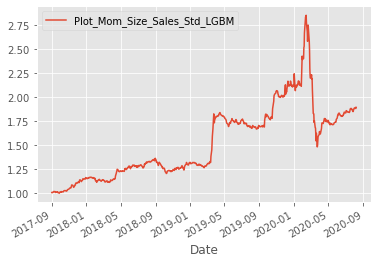

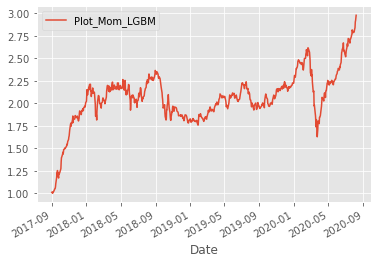

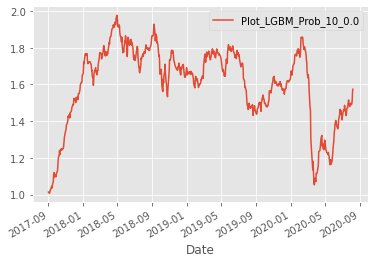

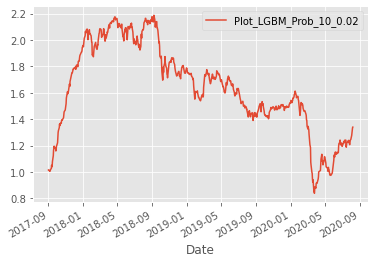

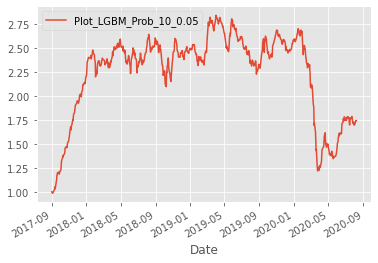

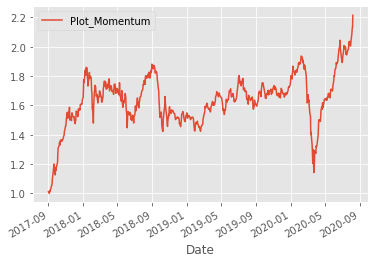

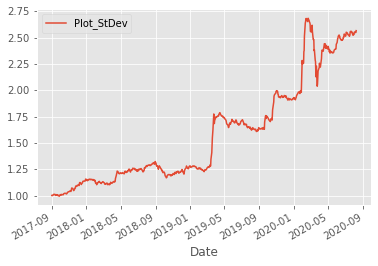

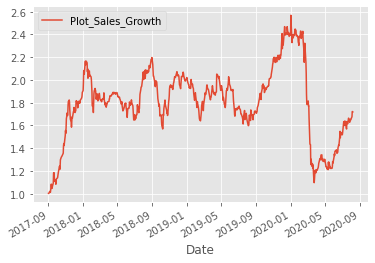

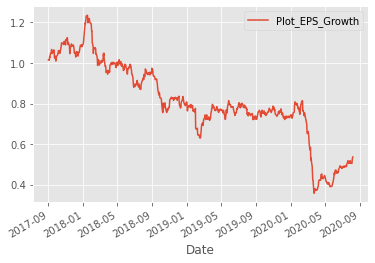

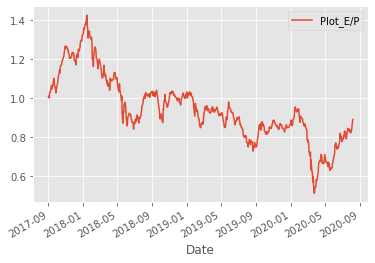

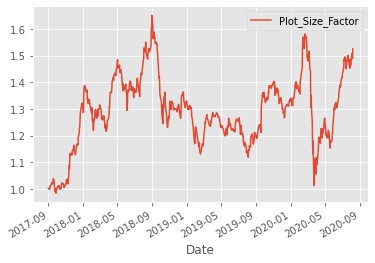

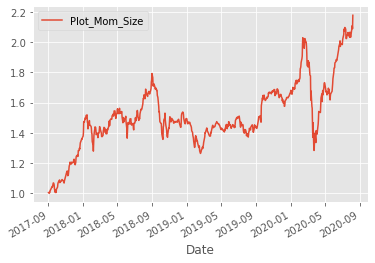

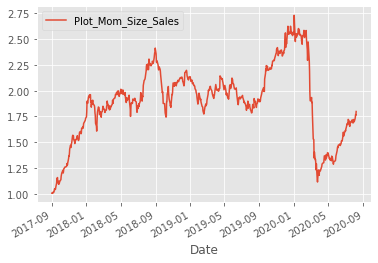

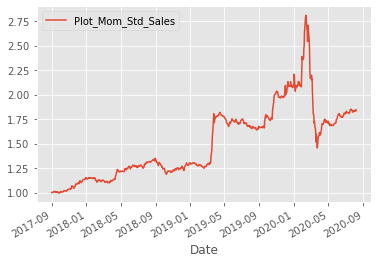

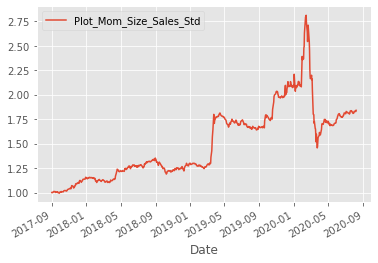

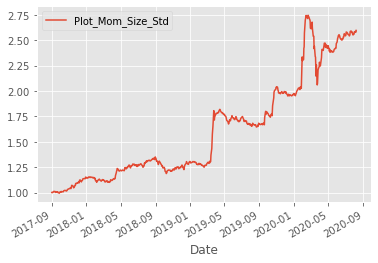

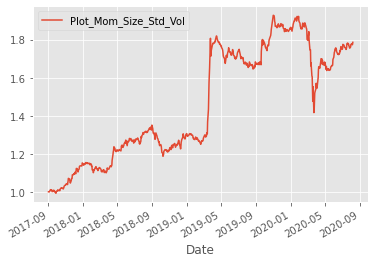

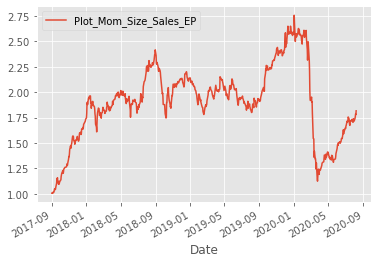

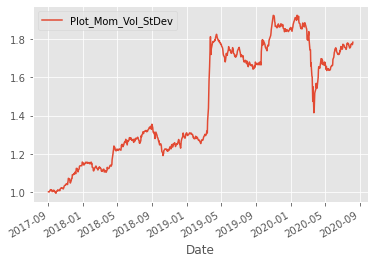

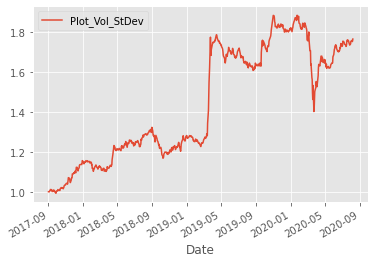

In [11]:
screener_detailed_df=pd.DataFrame()
screener_profit_df=pd.DataFrame()
#rebalance_period_list=[5,10,20]
#screen_stock_list=[10,12,15]
rebalance_period_list=[10]
screen_stock_list=[10]
for rebalance_period in rebalance_period_list:
    for screen_stock in screen_stock_list:
        print("Now Processing for rebalance period:",rebalance_period," &: screen_stock: ",screen_stock )
        #factor_list=['Mom_Size_Sales','10_Mom_Size_Sales','Mom_Size_10_Sales','Mom_Size_Sales_10']
        factor_list=['Mom_Size_Sales_Std_LGBM','Mom_LGBM','LGBM_Prob_10_0.02', 'LGBM_Prob_10_0.05','Momentum', 'StDev','Sales_Growth', 'EPS_Growth','E/P','Size_Factor','Mom_Size',
       'Mom_Size_Sales', 'Mom_Std_Sales', 'Mom_Size_Sales_Std', 'Mom_Size_Std',
       'Mom_Size_Std_Vol', 'Mom_Size_Sales_EP', 'Mom_Vol_StDev', 'Vol_StDev']
        for factor_name in factor_list:
            print("Now processing for factor: ", factor_name)
            z1, concat_df7, screener_out = evaluate_Long_Portfolio(read_data,predict_frame,factor_name , rebalance_period= rebalance_period,screen_stock=screen_stock)
            screener_out=screener_out[['Symbol',factor_name]]
            s1=screener_out
            screener_out=screener_out.groupby(['Date']).filter(lambda x:len(x) == screen_stock)
            screener_out.reset_index()
            screener_out[factor_name]=screener_out.groupby('Date')[factor_name].apply(lambda x:x/sum(x))
            screener_out=screener_out.reset_index()
            print('Screener Date Count:', len(screener_out["Date"].map(lambda t: t.date()).unique().tolist()))
            #screener_out.to_csv('screener_momentum.csv')
            screener_profit,screener_detailed=calculate_returns(factor_name,screener_out,read_data, investment=investment_amount,screen_stock=screen_stock)
            screener_profit['rebalance_period']=rebalance_period
            screener_profit['screen_stock']=screen_stock
            screener_detailed['rebalance_period']=rebalance_period
            screener_detailed['screen_stock']=screen_stock
            screener_detailed_df=screener_detailed_df.append(screener_detailed)
            screener_profit_df=screener_profit_df.append(screener_profit)
            print("Done processing for factor: ", factor_name)
screener_detailed_df.to_csv('data/screener_detailed_df_base_all_features_Avg_Q_LGBM.csv')
screener_profit_df.to_csv('data/screener_profit_df_base_all_features_Avg_Q_LGBM.csv')

In [15]:
screener_detailed_df1=screener_detailed_df[screener_detailed_df['Sell_Date']>='3/3/2015']
Factor_Efficieny=pd.DataFrame()
Factor_Efficieny['Profit']=screener_detailed_df1.groupby('Factor_Name')['Profit'].sum()
Factor_Efficieny['Profit_Stdev']=screener_detailed_df1.groupby('Factor_Name')['Profit'].std()
Factor_Efficieny['Correct_Bets']=screener_detailed_df1.groupby('Factor_Name').apply(lambda x:x[x['Profit']>0]['Profit'].count()/x['Profit'].count())

In [16]:
Factor_Efficieny.sort_values(by='Profit', ascending=False)

Profit  Profit_Stdev  Correct_Bets
Factor_Name                                                       
Mom_LGBM                 129863.371837   1116.543055      0.533803
Momentum                 120679.550690   1171.801586      0.519718
Sales_Growth             110626.952532   2358.145650      0.521127
Mom_Size                 110550.933963    974.536393      0.529577
LGBM_Prob_10_0.05        105041.596471   1091.097389      0.521127
Mom_Size_Sales            99170.434250   1994.447034      0.554930
Mom_Size_Sales_EP         99098.461138   1993.074453      0.554930
Mom_Size_Std              92541.551591   1361.765242      0.528169
StDev                     91935.778813   1361.090725      0.522535
Size_Factor               68471.138089    987.916387      0.507042
LGBM_Prob_10_0.0          63682.962527    875.922054      0.528169
Mom_Size_Std_Vol          61135.511980   1034.139902      0.526761
Mom_Vol_StDev             60805.342336   1034.160365      0.525352
Vol_StDev                 60607.158913   1033.022243      0.521127
Mom_Size_Sales_Std_LGBM   54293.901780   1898.956157      0.532394
Mom_Size_Sales_Std        53276.740852   1899.379772      0.532394
Mom_Std_Sales             52252.008226   1899.674618      0.529577
LGBM_Prob_10_0.02         40131.125653    917.393814      0.522535
E/P                       36855.669176   1045.924530      0.502817
EPS_Growth               -14184.720556   1349.630208      0.492958

In [25]:
f1=screener_detailed_df1.groupby(['Buy_Date','Factor_Name'])['Profit'].sum().reset_index()
f1['Rank']=f1.groupby('Buy_Date')['Profit'].rank()
f1['Rank'] = pd.qcut(f1['Rank'], 10, labels=False)
f1.to_csv('Rank_Factor.csv')

In [ ]:
read_data.to_csv('data_Q_base.csv')
class_report.to_csv('Classification_Report_Q_base.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
X_Features=read_data[['Momentum', 'StDev','Sales_Growth', 'EPS_Growth','E/P','Size_Factor']]
plotImp(lgbm,X_Features,num=25)

In [ ]:
read_data.head()

In [ ]:
import shap
X_importance = X_test
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance, ['RSI', 'CCI','Momentum', 'StDev','Liquidity', 'Volatility','Size_Factor','MACD_Signal', 'ForceIndex', 'EVM', 'ROC','OBV', 'ADX', 'ATR', 'HBBANDS', 'LBBANDS', 'CLV','vwap'])
shap.summary_plot(shap_values, X_importance, shap.summary_plot(shap_values, X_importance, agg_market_df[fcol].columns, plot_type='bar'), plot_type='bar')

In [ ]:
##############XGBOOST
import xgboost as xgb
test_predict=[0.02,0.05,0.1,0.15]
for predict_period in test_predict:
    print("Now Running for Predict Hit: ", predict_period)
    read_data_forecast['Cum_Cat_Label']=np.where(read_data_forecast['Cum5_Return']>predict_period, 1, 0)
    read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast[read_data_forecast['Cum_Cat_Label']==0].count()
    event_rate=read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast['Cum_Cat_Label'].count()
    event_cut_off=1-event_rate.iloc[0]   
    Y_Label=read_data_forecast['Cum_Cat_Label']
    Y_Label=np.array(Y_Label)
    sc = StandardScaler()
    X_Features=read_data_forecast[['RSI', 'CCI', 'Momentum', 'StDev','Liquidity', 'Volatility','Open','High','Low','Close','Adj Close','Volume','Return','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'PEG', 'Size_Factor','MACD_Signal', 'ForceIndex', 'EVM', 'ROC','OBV', 'ADX', 'ATR', 'ichi_a', 'ichi_b', 'HBBANDS', 'LBBANDS', 'CLV']]
    X_Features=np.array(X_Features)
    X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Label, test_size=0.2, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    def auc(m, train, test): 
        return (metrics.roc_auc_score(y_train,m.predict_proba(X_train)[:,1]),metrics.roc_auc_score(y_test,m.predict_proba(X_test)[:,1]))
    #xgb_model = xgb.XGBClassifier()
    #param_dist = {"max_depth": [10,30],
    #          "min_child_weight" : [3],#,3],
    #          "n_estimators": [5000],
    #          "learning_rate": [0.05,0.1],}
    #grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 3,verbose=10, n_jobs=-1)
    #grid_search.fit(X_train, y_train)
    #params = grid_search.best_params_
    params = {"max_depth": 10,
              "min_child_weight" :3,
              "n_estimators": 5000,
              "learning_rate": 0.05,
              "verbose": 0}
    xgb_model = xgb.XGBClassifier()
    xgb_model.set_params(**params)
    xgb_model.fit(X_train, y_train)
    y_train_pred = xgb_model.predict(X_train)
    y_train_pred = np.where(y_train_pred > event_cut_off, 1, 0)
    y_test_pred = xgb_model.predict(X_test)
    y_test_pred = np.where(y_test_pred > event_cut_off, 1, 0)
    print(confusion_matrix(y_train,y_train_pred))
    print(classification_report(y_test,y_test_pred))
    print(accuracy_score(y_test, y_test_pred))
    class_int=pd.DataFrame.from_dict(classification_report(y_test,y_test_pred,output_dict=True))
    var_name="XGB_Prob_10_"+str(predict_period)
    class_int['predict_period']=var_name
    class_report=class_report.append(class_int)    
    read_data_miss[var_name]=lgbm.predict(sc.fit_transform(read_data_miss[['RSI', 'CCI', 'Momentum', 'StDev','Liquidity', 'Volatility','Open','High','Low','Close','Adj Close','Volume','Return','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'PEG', 'Size_Factor','MACD_Signal', 'ForceIndex', 'EVM', 'ROC','OBV', 'ADX', 'ATR', 'ichi_a', 'ichi_b', 'HBBANDS', 'LBBANDS', 'CLV']].values))

In [ ]:
read_data_miss.to_csv('data_Y_base.csv')
class_report.to_csv('Classification_Report_Y_base.csv')

In [ ]:
####CAT Boost
import catboost as cb
test_predict=[0.02,0.05,0.1,0.15]
for predict_period in test_predict:
    print("Now Running for Predict Hit: ", predict_period)
    read_data_forecast['Cum_Cat_Label']=np.where(read_data_forecast['Cum5_Return']>predict_period, 1, 0)
    read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast[read_data_forecast['Cum_Cat_Label']==0].count()
    event_rate=read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast['Cum_Cat_Label'].count()
    event_cut_off=1-event_rate.iloc[0]   
    Y_Label=read_data_forecast['Cum_Cat_Label']
    Y_Label=np.array(Y_Label)
    sc = StandardScaler()
    X_Features=read_data_forecast[['Momentum', 'StDev','Liquidity', 'Volatility','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P','PEG', 'Size_Factor']]
    X_Features=np.array(X_Features)
    X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Label, test_size=0.2, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    def auc(m, train, test): 
        return (metrics.roc_auc_score(y_train,m.predict_proba(X_train)[:,1]),metrics.roc_auc_score(y_test,m.predict_proba(X_test)[:,1]))
    #model = xgb.XGBClassifier()
    params = {'depth': [4,7],
          'learning_rate' : [0.05],#, 0.1],
         'l2_leaf_reg': [1,4],
         'iterations': [5000]}
    cb = cb.CatBoostClassifier()
    cat_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
    cat_model.fit(X_train, y_train)
    y_train_pred = xgb_model.predict(X_train)
    y_train_pred = np.where(y_train_pred > event_cut_off, 1, 0)
    y_test_pred = xgb_model.predict(X_test)
    y_test_pred = np.where(y_test_pred > event_cut_off, 1, 0)
    print(confusion_matrix(y_train,y_train_pred))
    print(classification_report(y_test,y_test_pred))
    print(accuracy_score(y_test, y_test_pred))
    class_int=pd.DataFrame.from_dict(classification_report(y_test,y_test_pred,output_dict=True))
    var_name="CAT_Prob_10_"+str(predict_period)
    class_int['predict_period']=var_name
    class_report=class_report.append(class_int)    
    read_data_miss[var_name]=lgbm.predict(sc.fit_transform(read_data_miss[['Momentum', 'StDev','Liquidity', 'Volatility','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P','PEG', 'Size_Factor']].values))

In [ ]:
data3=data3.dropna()
data3=data3.replace([np.inf, -np.inf], np.nan)
data3=data3.dropna()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#rf = RandomForestRegressor(random_state = 42)
Y_Label=data3['Cum_Cat_Label']
Y_Label=np.array(Y_Label)
sc = StandardScaler()
X_Features=data3[['RSI', 'CCI', 'Momentum', 'StDev','Liquidity', 'Volatility','Open','High','Low','Close','Adj Close','Volume','Return','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'PEG', 'Size_Factor','MACD_Signal', 'ForceIndex', 'EVM', 'ROC','OBV', 'ADX', 'ATR', 'ichi_a', 'ichi_b', 'HBBANDS', 'LBBANDS', 'CLV']]
X_Features=np.array(X_Features)
X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Label, test_size=0.2, random_state=0)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf=LogisticRegression(random_state=0).fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test, y_test_pred))